In [1]:
import os
# set GPU number. This might work for several framework such as PyTorch, TensorFlow, Keras
gpu_id = '0'
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_id

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# sys.path.append('../../loglizer')
    
# from loglizer import dataloader
# from loglizer.preprocessing import Vectorizer, Iterator
import sys
import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
from torch.utils.data import Dataset
import torch.utils.data as Data
from torch.autograd import Variable
import pickle as pkl
import argparse
import time
import copy
import torchvision.transforms as transforms
import torchvision
import random
from collections import OrderedDict
from PIL import Image

import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from collections import defaultdict

In [4]:
# struct_log = '../data/HDFS/HDFS.log_structured.csv' # The structured log file

#初始參數
class Parser():
    def __init__(self):
        self.mode = 'fedadam'  #FedBN,FedAvg,fedprox,fedopt,fedadagrad,fedadam 待加入scoffold
        #所有方法都有使用Fedbn
        self.beta_1 = 0.9
        self.beta_2 = 0.99 #b1,b2 for adaptive opt
        self.tau = 1e-2
        self.batch = 32
        self.lr = 1e-1
        self.server_lr = 1e-1
        self.server_momentum = 0.5
        self.client_momentum = 0.9 # 0 is fedavg others is fedavgm
        self.no_cuda = False
        self.seed = 1
        self.client_num = 5
        self.wk_iters = 1 # training
        self.num_workers = 2 # dataloader
        self.mu = 1e-3
        self.iters = 50 #epochs
        self.local_epochs = 10
        self.server_opt = 'sgd'
        self.percent = 1
#         self.early_stop = 500
        self.window_size = 10
        self.train_ratio = 0.5
        self.split_type='sequential' # sequential, uniform

        
args = Parser()

use_cuda = not args.no_cuda and torch.cuda.is_available()
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed) 
random.seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")

In [5]:
sys.path.append('../')
from logdeep.tools.predict import Predicter
from logdeep.tools.train import Trainer
from logdeep.tools.utils import *

# Config Parameters

options = dict()
options['data_dir'] = '../data/'
options['window_size'] = 10
options['device'] = device

# Smaple
options['sample'] = "sliding_window"
options['window_size'] = 10  # if fix_window

# Features
options['sequentials'] = True
options['quantitatives'] = True
options['semantics'] = False
options['feature_num'] = sum(
    [options['sequentials'], options['quantitatives'], options['semantics']])

# Model
options['input_size'] = 1
options['hidden_size'] = 64
options['num_layers'] = 2
options['num_classes'] = 28

# Train
options['batch_size'] = 2048
options['accumulation_step'] = 1

options['optimizer'] = 'adam'
options['lr'] = 1e-3
options['max_epoch'] = args.local_epochs
options['lr_step'] = (300, 350)
options['lr_decay_ratio'] = 0.1

options['resume_path'] = None
options['model_name'] = "loganomaly"
options['save_dir'] = "../result/loganomaly/"

# Predict
options['model_path'] = "../result/loganomaly/loganomaly_last.pth"
options['num_candidates'] = 9

seed_everything(seed=1234)


def train():
    trainer = Trainer(Model, options)
    trainer.start_train()


def predict():
    predicter = Predicter(Model, options)
    predicter.predict_unsupervised()

# Preprocessing

In [6]:
# df = pd.read_csv(struct_log)
# print(df.shape)

# for i in range(args.client_num):
#     bound = int(df.shape[0]/args.client_num)
#     ddf = df[i* bound : (i+1)* bound]
#     ddf.to_csv("../../loglizer/data/client_alldata/client_"+str(i)+".csv", index=None)
#     print('Client',i, ddf.shape)
#     del ddf
# del df 

In [7]:
class deeplog(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(deeplog, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, num_keys)

    def forward(self, features, device):
        input0 = features[0]
        h0 = torch.zeros(self.num_layers, input0.size(0),
                         self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, input0.size(0),
                         self.hidden_size).to(device)
        out, _ = self.lstm(input0, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


class loganomaly(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(loganomaly, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm0 = nn.LSTM(input_size,
                             hidden_size,
                             num_layers,
                             batch_first=True)
        self.lstm1 = nn.LSTM(input_size,
                             hidden_size,
                             num_layers,
                             batch_first=True)
        self.fc = nn.Linear(2 * hidden_size, num_keys)
        self.attention_size = self.hidden_size

        self.w_omega = Variable(
            torch.zeros(self.hidden_size, self.attention_size))
        self.u_omega = Variable(torch.zeros(self.attention_size))

        self.sequence_length = 28

    def attention_net(self, lstm_output):
        output_reshape = torch.Tensor.reshape(lstm_output,
                                              [-1, self.hidden_size])
        attn_tanh = torch.tanh(torch.mm(output_reshape, self.w_omega))
        attn_hidden_layer = torch.mm(
            attn_tanh, torch.Tensor.reshape(self.u_omega, [-1, 1]))
        exps = torch.Tensor.reshape(torch.exp(attn_hidden_layer),
                                    [-1, self.sequence_length])
        alphas = exps / torch.Tensor.reshape(torch.sum(exps, 1), [-1, 1])
        alphas_reshape = torch.Tensor.reshape(alphas,
                                              [-1, self.sequence_length, 1])
        state = lstm_output
        attn_output = torch.sum(state * alphas_reshape, 1)
        return attn_output

    def forward(self, features, device):
        input0, input1 = features[0], features[1]

        h0_0 = torch.zeros(self.num_layers, input0.size(0),
                           self.hidden_size).to(device)
        c0_0 = torch.zeros(self.num_layers, input0.size(0),
                           self.hidden_size).to(device)

        out0, _ = self.lstm0(input0, (h0_0, c0_0))

        h0_1 = torch.zeros(self.num_layers, input1.size(0),
                           self.hidden_size).to(device)
        c0_1 = torch.zeros(self.num_layers, input1.size(0),
                           self.hidden_size).to(device)

        out1, _ = self.lstm1(input1, (h0_1, c0_1))
        multi_out = torch.cat((out0[:, -1, :], out1[:, -1, :]), -1)
        out = self.fc(multi_out)
        return out


class robustlog(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(robustlog, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, num_keys)

    def forward(self, features, device):
        input0 = features[0]
        h0 = torch.zeros(self.num_layers, input0.size(0),
                         self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, input0.size(0),
                         self.hidden_size).to(device)
        out, _ = self.lstm(input0, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


In [8]:
# def datasplit(args, gpu_id = 1):
#     train_loaders = []
#     test_loaders = []
#     hidden_size = 32
#     num_directions = 2
#     topk = 5
    
#     for i in range(args.client_num):
#         struct_log = '../../loglizer/data/client_data/client_'+str(i)+".csv"
#         label_file = '../../loglizer/data/HDFS/anomaly_label.csv' # The anomaly label file
        
#         (x_train, window_y_train, y_train), (x_test, window_y_test, y_test) = dataloader.load_HDFS(i, struct_log, label_file = label_file, window='session', window_size=args.window_size, train_ratio=args.train_ratio, split_type=args.split_type)
#         feature_extractor = Vectorizer()
#         train_dataset = feature_extractor.fit_transform(x_train, window_y_train, y_train)
#         test_dataset = feature_extractor.transform(x_test, window_y_test, y_test)
#         train_loader = Iterator(train_dataset, batch_size=args.batch, shuffle=True, num_workers=args.num_workers).iter
#         test_loader = Iterator(test_dataset, batch_size=args.batch, shuffle=False, num_workers=args.num_workers).iter
#         train_loaders.append(train_loader)
#         test_loaders.append(test_loader)
        
#     server_model = DeepLog(num_labels=feature_extractor.num_labels, hidden_size=hidden_size, num_directions=num_directions, topk=topk).to(device)
    
#     return train_loaders, test_loaders, server_model

In [9]:
# train_loaders, test_loaders, server_model = datasplit(args, gpu_id = 1)

# Federated learning

In [10]:
def communication(args, server_model, models, client_weights, v, grad):
    if args.mode.lower() == 'fedbn':
        with torch.no_grad():
            for key in server_model.state_dict().keys():
                if 'bn' not in key: #非BN層都去交換
                    temp = torch.zeros_like(server_model.state_dict()[key], dtype=torch.float32)
                    for client_idx in range(client_num):
                        temp += client_weights[client_idx] * models[client_idx].state_dict()[key]
                    server_model.state_dict()[key].data.copy_(temp)
                    for client_idx in range(client_num):
                        models[client_idx].state_dict()[key].data.copy_(server_model.state_dict()[key])
    
    elif args.mode.lower() == 'fedadagrad':
        with torch.no_grad():
            for key, param in server_model.named_parameters():
                temp = torch.zeros_like(server_model.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp = temp + client_weights[client_idx] * models[client_idx].state_dict()[key]                          
                param.grad = temp - param.data              
                param.grad = torch.mul(grad[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1)
                grad[key] = param.grad
                v[key] = v[key] + param.grad**2
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v[key]),args.tau)), args.server_lr) 

                for client_idx in range(len(client_weights)):
                    models[client_idx].state_dict()[key].data.copy_(server_model.state_dict()[key])            
    
    elif args.mode.lower() == 'fedadam':
        with torch.no_grad():
            for key, param in server_model.named_parameters():                
                temp = torch.zeros_like(server_model.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp += client_weights[client_idx] * models[client_idx].state_dict()[key]                         
                param.grad = temp - param.data              
                param.grad = torch.mul(grad[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1) 
                grad[key] = param.grad                
                v[key] = torch.mul(v[key], args.beta_2) + torch.mul(param.grad**2, 1-args.beta_2)
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v[key]),args.tau)), args.server_lr)
                
                for client_idx in range(len(client_weights)):
                    models[client_idx].state_dict()[key].data.copy_(server_model.state_dict()[key])

    else:
        with torch.no_grad():
            for key in server_model.state_dict().keys():#遇到BN層就直接拿第一個client參數使用
                # num_batches_tracked is a non trainable LongTensor and
                # num_batches_tracked are the same for all clients for the given datasets
                if 'num_batches_tracked' in key:
                    server_model.state_dict()[key].data.copy_(models[0].state_dict()[key])
                else:
                    temp = torch.zeros_like(server_model.state_dict()[key]).to(device)
                    for client_idx in range(len(client_weights)):
                        temp += client_weights[client_idx] * models[client_idx].state_dict()[key]                        
                    server_model.state_dict()[key].data.copy_(temp)#weight傳給server
                    for client_idx in range(len(client_weights)):
                        models[client_idx].state_dict()[key].data.copy_(server_model.state_dict()[key])        
    return server_model, models, v, grad

In [11]:
# # setup model
server_model = loganomaly(input_size=options['input_size'],
                    hidden_size=options['hidden_size'],
                    num_layers=options['num_layers'],
                    num_keys=options['num_classes']).to(device)
# for adaptive velocity
v = {}
grad = {}
for key in server_model.state_dict().keys():
    v[key] = torch.add(torch.zeros_like(server_model.state_dict()[key],dtype=torch.float32),args.tau**2)
    grad[key] = torch.zeros_like(server_model.state_dict()[key],dtype=torch.float32)
loss_fun = nn.CrossEntropyLoss()
# name of each datasets
datasets = ['Client'+str(i) for i in range(args.client_num)]
# federated client number
client_num = len(datasets)
client_weights = [1/client_num for i in range(client_num)]
# each local client model
models = [copy.deepcopy(server_model).to(device) for idx in range(client_num)]

start_iter = 0

lloogg_1 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_2 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_3 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_4 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_5 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}

result_recall = {}
result_precision = {}
result_f1 = {}
result_acc = {}
for i in range(client_num):
    result_recall[i] = []
    result_precision[i] = []
    result_f1[i] = []
    result_acc[i] = []

# Start training
for a_iter in range(start_iter, args.iters):
#     optimizers = [optim.SGD(params = models[idx].parameters(), lr=args.lr, momentum = args.client_momentum) for idx in range(client_num)]
    for wi in range(args.wk_iters):
        print("============ Train epoch {} ============".format(wi + a_iter * args.wk_iters))
        for client_idx, model in enumerate(models):
            print('Client ', client_idx)
            trainer = Trainer(model, options, args.client_num, client_idx)
            trainer.start_train()
            
            exec('lloogg_'+str(client_idx+1)+"['train']['epoch'].append(a_iter)")
            exec('lloogg_'+str(client_idx+1)+"['train']['lr'].append(trainer.log['train']['lr'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['train']['time'].append(trainer.log['train']['time'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['train']['loss'].append(trainer.log['train']['loss'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['val']['epoch'].append(a_iter)")
            exec('lloogg_'+str(client_idx+1)+"['val']['lr'].append(trainer.log['valid']['lr'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['val']['time'].append(trainer.log['valid']['time'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['val']['loss'].append(trainer.log['valid']['loss'][-1])")

    with torch.no_grad():
        # aggregation
        server_model, models, v, grad = communication(args, server_model, models, client_weights, v, grad )
        # Report loss after aggregation
        print("============ Test epoch {} ============".format(wi + a_iter * args.wk_iters))

        for client_idx, model in enumerate(models):
            print('Client ', client_idx)
            predicter = Predicter(model, options, args.client_num, client_idx)
            predicter.predict_unsupervised()
            
            result_recall[client_idx].append(predicter.recall)
            result_precision[client_idx].append(predicter.precision)
            result_f1[client_idx].append(predicter.f1)
            result_acc[client_idx].append(predicter.acc)

============ Train epoch 0 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3448.72it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:19:02 | Learning rate: 0.000031


Train loss: 3.31582: 100%|██████████| 5/5 [00:00<00:00, 20.11it/s]


Starting epoch: 1 | phase: train | ⏰: 00:19:02 | Learning rate: 0.000063


Train loss: 3.30787: 100%|██████████| 5/5 [00:00<00:00, 26.75it/s]


Starting epoch: 2 | phase: train | ⏰: 00:19:02 | Learning rate: 0.000125


Train loss: 3.29208: 100%|██████████| 5/5 [00:00<00:00, 22.24it/s]


Starting epoch: 3 | phase: train | ⏰: 00:19:02 | Learning rate: 0.000250


Train loss: 3.25961: 100%|██████████| 5/5 [00:00<00:00, 25.94it/s]


Starting epoch: 4 | phase: train | ⏰: 00:19:03 | Learning rate: 0.000500


Train loss: 3.18749: 100%|██████████| 5/5 [00:00<00:00, 26.55it/s]


Starting epoch: 5 | phase: train | ⏰: 00:19:03 | Learning rate: 0.001000


Train loss: 2.98304: 100%|██████████| 5/5 [00:00<00:00, 20.38it/s]


Starting epoch: 6 | phase: train | ⏰: 00:19:03 | Learning rate: 0.001000


Train loss: 2.46525: 100%|██████████| 5/5 [00:00<00:00, 27.00it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:19:03 


: 100%|██████████| 1/1 [00:00<00:00, 44.82it/s]


Validation loss: 2.0862162113189697
Starting epoch: 7 | phase: train | ⏰: 00:19:03 | Learning rate: 0.001000


Train loss: 1.94442: 100%|██████████| 5/5 [00:00<00:00, 20.69it/s]


Starting epoch: 8 | phase: train | ⏰: 00:19:03 | Learning rate: 0.001000


Train loss: 1.83519: 100%|██████████| 5/5 [00:00<00:00, 27.24it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:19:04 


: 100%|██████████| 1/1 [00:00<00:00, 60.32it/s]


Validation loss: 1.8452236652374268
Starting epoch: 9 | phase: train | ⏰: 00:19:04 | Learning rate: 0.001000


Train loss: 1.80094: 100%|██████████| 5/5 [00:00<00:00, 28.88it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3379.10it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:19:17 | Learning rate: 0.000031


Train loss: 3.31550: 100%|██████████| 5/5 [00:00<00:00, 26.17it/s]


Starting epoch: 1 | phase: train | ⏰: 00:19:17 | Learning rate: 0.000063


Train loss: 3.30746: 100%|██████████| 5/5 [00:00<00:00, 30.05it/s]


Starting epoch: 2 | phase: train | ⏰: 00:19:17 | Learning rate: 0.000125


Train loss: 3.29198: 100%|██████████| 5/5 [00:00<00:00, 20.27it/s]


Starting epoch: 3 | phase: train | ⏰: 00:19:17 | Learning rate: 0.000250


Train loss: 3.25991: 100%|██████████| 5/5 [00:00<00:00, 25.76it/s]


Starting epoch: 4 | phase: train | ⏰: 00:19:17 | Learning rate: 0.000500


Train loss: 3.18678: 100%|██████████| 5/5 [00:00<00:00, 23.28it/s]


Starting epoch: 5 | phase: train | ⏰: 00:19:18 | Learning rate: 0.001000


Train loss: 2.98573: 100%|██████████| 5/5 [00:00<00:00, 22.05it/s]


Starting epoch: 6 | phase: train | ⏰: 00:19:18 | Learning rate: 0.001000


Train loss: 2.47176: 100%|██████████| 5/5 [00:00<00:00, 27.63it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:19:18 


: 100%|██████████| 1/1 [00:00<00:00, 60.56it/s]


Validation loss: 2.037208080291748
Starting epoch: 7 | phase: train | ⏰: 00:19:18 | Learning rate: 0.001000


Train loss: 1.95560: 100%|██████████| 5/5 [00:00<00:00, 21.98it/s]


Starting epoch: 8 | phase: train | ⏰: 00:19:18 | Learning rate: 0.001000


Train loss: 1.84075: 100%|██████████| 5/5 [00:00<00:00, 26.87it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:19:18 


: 100%|██████████| 1/1 [00:00<00:00, 41.07it/s]


Validation loss: 1.7747759819030762
Starting epoch: 9 | phase: train | ⏰: 00:19:18 | Learning rate: 0.001000


Train loss: 1.80715: 100%|██████████| 5/5 [00:00<00:00, 28.75it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 2757.20it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:19:32 | Learning rate: 0.000031


Train loss: 3.31485: 100%|██████████| 5/5 [00:00<00:00, 21.99it/s]


Starting epoch: 1 | phase: train | ⏰: 00:19:32 | Learning rate: 0.000063


Train loss: 3.30703: 100%|██████████| 5/5 [00:00<00:00, 22.65it/s]


Starting epoch: 2 | phase: train | ⏰: 00:19:32 | Learning rate: 0.000125


Train loss: 3.29146: 100%|██████████| 5/5 [00:00<00:00, 19.88it/s]


Starting epoch: 3 | phase: train | ⏰: 00:19:32 | Learning rate: 0.000250


Train loss: 3.25941: 100%|██████████| 5/5 [00:00<00:00, 24.42it/s]


Starting epoch: 4 | phase: train | ⏰: 00:19:33 | Learning rate: 0.000500


Train loss: 3.18781: 100%|██████████| 5/5 [00:00<00:00, 26.31it/s]


Starting epoch: 5 | phase: train | ⏰: 00:19:33 | Learning rate: 0.001000


Train loss: 2.98390: 100%|██████████| 5/5 [00:00<00:00, 20.65it/s]


Starting epoch: 6 | phase: train | ⏰: 00:19:33 | Learning rate: 0.001000


Train loss: 2.46782: 100%|██████████| 5/5 [00:00<00:00, 26.22it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:19:33 


: 100%|██████████| 1/1 [00:00<00:00, 56.98it/s]


Validation loss: 2.0689847469329834
Starting epoch: 7 | phase: train | ⏰: 00:19:33 | Learning rate: 0.001000


Train loss: 1.95212: 100%|██████████| 5/5 [00:00<00:00, 22.75it/s]


Starting epoch: 8 | phase: train | ⏰: 00:19:33 | Learning rate: 0.001000


Train loss: 1.85676: 100%|██████████| 5/5 [00:00<00:00, 25.04it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:19:34 


: 100%|██████████| 1/1 [00:00<00:00, 41.24it/s]


Validation loss: 1.8257156610488892
Starting epoch: 9 | phase: train | ⏰: 00:19:34 | Learning rate: 0.001000


Train loss: 1.81694: 100%|██████████| 5/5 [00:00<00:00, 20.69it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3059.18it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:19:47 | Learning rate: 0.000031


Train loss: 3.31592: 100%|██████████| 5/5 [00:00<00:00, 27.53it/s]


Starting epoch: 1 | phase: train | ⏰: 00:19:47 | Learning rate: 0.000063


Train loss: 3.30800: 100%|██████████| 5/5 [00:00<00:00, 24.87it/s]


Starting epoch: 2 | phase: train | ⏰: 00:19:47 | Learning rate: 0.000125


Train loss: 3.29237: 100%|██████████| 5/5 [00:00<00:00, 21.92it/s]


Starting epoch: 3 | phase: train | ⏰: 00:19:47 | Learning rate: 0.000250


Train loss: 3.25988: 100%|██████████| 5/5 [00:00<00:00, 26.84it/s]


Starting epoch: 4 | phase: train | ⏰: 00:19:47 | Learning rate: 0.000500


Train loss: 3.18773: 100%|██████████| 5/5 [00:00<00:00, 26.07it/s]


Starting epoch: 5 | phase: train | ⏰: 00:19:48 | Learning rate: 0.001000


Train loss: 2.98308: 100%|██████████| 5/5 [00:00<00:00, 21.10it/s]


Starting epoch: 6 | phase: train | ⏰: 00:19:48 | Learning rate: 0.001000


Train loss: 2.46688: 100%|██████████| 5/5 [00:00<00:00, 28.60it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:19:48 


: 100%|██████████| 1/1 [00:00<00:00, 54.61it/s]


Validation loss: 2.090698480606079
Starting epoch: 7 | phase: train | ⏰: 00:19:48 | Learning rate: 0.001000


Train loss: 1.94344: 100%|██████████| 5/5 [00:00<00:00, 22.92it/s]


Starting epoch: 8 | phase: train | ⏰: 00:19:48 | Learning rate: 0.001000


Train loss: 1.83531: 100%|██████████| 5/5 [00:00<00:00, 27.49it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:19:48 


: 100%|██████████| 1/1 [00:00<00:00, 61.03it/s]


Validation loss: 1.8331999778747559
Starting epoch: 9 | phase: train | ⏰: 00:19:48 | Learning rate: 0.001000


Train loss: 1.79785: 100%|██████████| 5/5 [00:00<00:00, 27.28it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 2660.60it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:20:01 | Learning rate: 0.000031


Train loss: 3.31601: 100%|██████████| 5/5 [00:00<00:00, 22.43it/s]


Starting epoch: 1 | phase: train | ⏰: 00:20:02 | Learning rate: 0.000063


Train loss: 3.30768: 100%|██████████| 5/5 [00:00<00:00, 25.23it/s]

Starting epoch: 2 | phase: train | ⏰: 00:20:02 | Learning rate: 0.000125



Train loss: 3.29211: 100%|██████████| 5/5 [00:00<00:00, 20.68it/s]


Starting epoch: 3 | phase: train | ⏰: 00:20:02 | Learning rate: 0.000250


Train loss: 3.25994: 100%|██████████| 5/5 [00:00<00:00, 26.14it/s]


Starting epoch: 4 | phase: train | ⏰: 00:20:02 | Learning rate: 0.000500


Train loss: 3.18740: 100%|██████████| 5/5 [00:00<00:00, 27.93it/s]


Starting epoch: 5 | phase: train | ⏰: 00:20:02 | Learning rate: 0.001000


Train loss: 2.98047: 100%|██████████| 5/5 [00:00<00:00, 20.26it/s]


Starting epoch: 6 | phase: train | ⏰: 00:20:03 | Learning rate: 0.001000


Train loss: 2.46683: 100%|██████████| 5/5 [00:00<00:00, 26.97it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:20:03 


: 100%|██████████| 1/1 [00:00<00:00, 55.28it/s]


Validation loss: 2.0860390663146973
Starting epoch: 7 | phase: train | ⏰: 00:20:03 | Learning rate: 0.001000


Train loss: 1.93737: 100%|██████████| 5/5 [00:00<00:00, 21.37it/s]


Starting epoch: 8 | phase: train | ⏰: 00:20:03 | Learning rate: 0.001000


Train loss: 1.83289: 100%|██████████| 5/5 [00:00<00:00, 24.31it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:20:03 


: 100%|██████████| 1/1 [00:00<00:00, 61.77it/s]


Validation loss: 1.8325220346450806
Starting epoch: 9 | phase: train | ⏰: 00:20:03 | Learning rate: 0.001000


Train loss: 1.79841: 100%|██████████| 5/5 [00:00<00:00, 26.05it/s]


============ Test epoch 0 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:38<00:00, 29.85it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 379.3593201637268
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:40<00:00, 28.11it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 400.2483582496643
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:39<00:00, 27.97it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 415.59470868110657
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:41<00:00, 27.99it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 413.1490669250488
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:39<00:00, 28.36it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 397.0205862522125
============ Train epoch 1 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3077.05it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:53:45 | Learning rate: 0.000031


Train loss: 2.20120: 100%|██████████| 5/5 [00:00<00:00, 13.87it/s]


Starting epoch: 1 | phase: train | ⏰: 00:53:45 | Learning rate: 0.000063


Train loss: 2.17067: 100%|██████████| 5/5 [00:00<00:00, 13.81it/s]


Starting epoch: 2 | phase: train | ⏰: 00:53:46 | Learning rate: 0.000125


Train loss: 2.11342: 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]


Starting epoch: 3 | phase: train | ⏰: 00:53:46 | Learning rate: 0.000250


Train loss: 2.01985: 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]


Starting epoch: 4 | phase: train | ⏰: 00:53:47 | Learning rate: 0.000500


Train loss: 1.89552: 100%|██████████| 5/5 [00:00<00:00, 10.93it/s]


Starting epoch: 5 | phase: train | ⏰: 00:53:47 | Learning rate: 0.001000


Train loss: 1.81296: 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]


Starting epoch: 6 | phase: train | ⏰: 00:53:48 | Learning rate: 0.001000


Train loss: 1.77425: 100%|██████████| 5/5 [00:00<00:00, 20.37it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:53:48 


: 100%|██████████| 1/1 [00:00<00:00, 35.61it/s]


Validation loss: 1.7641416788101196
Starting epoch: 7 | phase: train | ⏰: 00:53:48 | Learning rate: 0.001000


Train loss: 1.72403: 100%|██████████| 5/5 [00:00<00:00, 15.52it/s]


Starting epoch: 8 | phase: train | ⏰: 00:53:48 | Learning rate: 0.001000


Train loss: 1.66833: 100%|██████████| 5/5 [00:00<00:00, 25.47it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:53:48 


: 100%|██████████| 1/1 [00:00<00:00, 50.12it/s]


Validation loss: 1.6504669189453125
Starting epoch: 9 | phase: train | ⏰: 00:53:48 | Learning rate: 0.001000


Train loss: 1.61580: 100%|██████████| 5/5 [00:00<00:00, 25.63it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3354.90it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:54:01 | Learning rate: 0.000031


Train loss: 2.20620: 100%|██████████| 5/5 [00:00<00:00, 27.34it/s]


Starting epoch: 1 | phase: train | ⏰: 00:54:01 | Learning rate: 0.000063


Train loss: 2.17603: 100%|██████████| 5/5 [00:00<00:00, 21.35it/s]


Starting epoch: 2 | phase: train | ⏰: 00:54:02 | Learning rate: 0.000125


Train loss: 2.11860: 100%|██████████| 5/5 [00:00<00:00, 17.76it/s]


Starting epoch: 3 | phase: train | ⏰: 00:54:02 | Learning rate: 0.000250


Train loss: 2.02643: 100%|██████████| 5/5 [00:00<00:00, 22.55it/s]


Starting epoch: 4 | phase: train | ⏰: 00:54:02 | Learning rate: 0.000500


Train loss: 1.90660: 100%|██████████| 5/5 [00:00<00:00, 23.35it/s]


Starting epoch: 5 | phase: train | ⏰: 00:54:02 | Learning rate: 0.001000


Train loss: 1.82508: 100%|██████████| 5/5 [00:00<00:00, 19.95it/s]


Starting epoch: 6 | phase: train | ⏰: 00:54:03 | Learning rate: 0.001000


Train loss: 1.78468: 100%|██████████| 5/5 [00:00<00:00, 25.03it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:54:03 


: 100%|██████████| 1/1 [00:00<00:00, 38.79it/s]


Validation loss: 1.7203906774520874
Starting epoch: 7 | phase: train | ⏰: 00:54:03 | Learning rate: 0.001000


Train loss: 1.74086: 100%|██████████| 5/5 [00:00<00:00, 20.61it/s]


Starting epoch: 8 | phase: train | ⏰: 00:54:03 | Learning rate: 0.001000


Train loss: 1.67829: 100%|██████████| 5/5 [00:00<00:00, 24.10it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:54:03 


: 100%|██████████| 1/1 [00:00<00:00, 53.38it/s]


Validation loss: 1.6166517734527588
Starting epoch: 9 | phase: train | ⏰: 00:54:03 | Learning rate: 0.001000


Train loss: 1.63117: 100%|██████████| 5/5 [00:00<00:00, 26.70it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3186.05it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:54:17 | Learning rate: 0.000031


Train loss: 2.20875: 100%|██████████| 5/5 [00:00<00:00, 22.17it/s]


Starting epoch: 1 | phase: train | ⏰: 00:54:17 | Learning rate: 0.000063


Train loss: 2.17871: 100%|██████████| 5/5 [00:00<00:00, 21.92it/s]


Starting epoch: 2 | phase: train | ⏰: 00:54:17 | Learning rate: 0.000125


Train loss: 2.12371: 100%|██████████| 5/5 [00:00<00:00, 18.59it/s]


Starting epoch: 3 | phase: train | ⏰: 00:54:17 | Learning rate: 0.000250


Train loss: 2.03055: 100%|██████████| 5/5 [00:00<00:00, 18.78it/s]


Starting epoch: 4 | phase: train | ⏰: 00:54:18 | Learning rate: 0.000500


Train loss: 1.91193: 100%|██████████| 5/5 [00:00<00:00, 20.91it/s]


Starting epoch: 5 | phase: train | ⏰: 00:54:18 | Learning rate: 0.001000


Train loss: 1.83405: 100%|██████████| 5/5 [00:00<00:00, 19.51it/s]


Starting epoch: 6 | phase: train | ⏰: 00:54:18 | Learning rate: 0.001000


Train loss: 1.79145: 100%|██████████| 5/5 [00:00<00:00, 20.24it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:54:18 


: 100%|██████████| 1/1 [00:00<00:00, 32.29it/s]


Validation loss: 1.7530088424682617
Starting epoch: 7 | phase: train | ⏰: 00:54:18 | Learning rate: 0.001000


Train loss: 1.74236: 100%|██████████| 5/5 [00:00<00:00, 17.04it/s]


Starting epoch: 8 | phase: train | ⏰: 00:54:19 | Learning rate: 0.001000


Train loss: 1.68835: 100%|██████████| 5/5 [00:00<00:00, 18.82it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:54:19 


: 100%|██████████| 1/1 [00:00<00:00, 34.55it/s]


Validation loss: 1.6316975355148315
Starting epoch: 9 | phase: train | ⏰: 00:54:19 | Learning rate: 0.001000


Train loss: 1.63304: 100%|██████████| 5/5 [00:00<00:00, 23.23it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3288.36it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:54:32 | Learning rate: 0.000031


Train loss: 2.19955: 100%|██████████| 5/5 [00:00<00:00, 19.71it/s]


Starting epoch: 1 | phase: train | ⏰: 00:54:33 | Learning rate: 0.000063


Train loss: 2.16912: 100%|██████████| 5/5 [00:00<00:00, 22.99it/s]


Starting epoch: 2 | phase: train | ⏰: 00:54:33 | Learning rate: 0.000125


Train loss: 2.11297: 100%|██████████| 5/5 [00:00<00:00, 17.16it/s]


Starting epoch: 3 | phase: train | ⏰: 00:54:33 | Learning rate: 0.000250


Train loss: 2.01617: 100%|██████████| 5/5 [00:00<00:00, 20.72it/s]


Starting epoch: 4 | phase: train | ⏰: 00:54:33 | Learning rate: 0.000500


Train loss: 1.89364: 100%|██████████| 5/5 [00:00<00:00, 21.39it/s]


Starting epoch: 5 | phase: train | ⏰: 00:54:34 | Learning rate: 0.001000


Train loss: 1.81648: 100%|██████████| 5/5 [00:00<00:00, 19.12it/s]


Starting epoch: 6 | phase: train | ⏰: 00:54:34 | Learning rate: 0.001000


Train loss: 1.77686: 100%|██████████| 5/5 [00:00<00:00, 22.88it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:54:34 


: 100%|██████████| 1/1 [00:00<00:00, 33.91it/s]


Validation loss: 1.7040694952011108
Starting epoch: 7 | phase: train | ⏰: 00:54:34 | Learning rate: 0.001000


Train loss: 1.72235: 100%|██████████| 5/5 [00:00<00:00, 18.43it/s]


Starting epoch: 8 | phase: train | ⏰: 00:54:34 | Learning rate: 0.001000


Train loss: 1.66835: 100%|██████████| 5/5 [00:00<00:00, 24.30it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:54:35 


: 100%|██████████| 1/1 [00:00<00:00, 43.22it/s]


Validation loss: 1.6015610694885254
Starting epoch: 9 | phase: train | ⏰: 00:54:35 | Learning rate: 0.001000


Train loss: 1.61569: 100%|██████████| 5/5 [00:00<00:00, 23.07it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 2948.27it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:54:48 | Learning rate: 0.000031


Train loss: 2.19839: 100%|██████████| 5/5 [00:00<00:00, 21.58it/s]


Starting epoch: 1 | phase: train | ⏰: 00:54:48 | Learning rate: 0.000063


Train loss: 2.16822: 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]


Starting epoch: 2 | phase: train | ⏰: 00:54:48 | Learning rate: 0.000125


Train loss: 2.11221: 100%|██████████| 5/5 [00:00<00:00, 10.59it/s]


Starting epoch: 3 | phase: train | ⏰: 00:54:49 | Learning rate: 0.000250


Train loss: 2.01774: 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]


Starting epoch: 4 | phase: train | ⏰: 00:54:49 | Learning rate: 0.000500


Train loss: 1.89621: 100%|██████████| 5/5 [00:00<00:00, 10.74it/s]


Starting epoch: 5 | phase: train | ⏰: 00:54:50 | Learning rate: 0.001000


Train loss: 1.80987: 100%|██████████| 5/5 [00:00<00:00, 10.43it/s]


Starting epoch: 6 | phase: train | ⏰: 00:54:50 | Learning rate: 0.001000


Train loss: 1.77521: 100%|██████████| 5/5 [00:00<00:00, 11.81it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:54:51 


: 100%|██████████| 1/1 [00:00<00:00, 31.78it/s]


Validation loss: 1.7118088006973267
Starting epoch: 7 | phase: train | ⏰: 00:54:51 | Learning rate: 0.001000


Train loss: 1.72945: 100%|██████████| 5/5 [00:00<00:00, 11.27it/s]


Starting epoch: 8 | phase: train | ⏰: 00:54:51 | Learning rate: 0.001000


Train loss: 1.67551: 100%|██████████| 5/5 [00:00<00:00, 15.60it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:54:51 


: 100%|██████████| 1/1 [00:00<00:00, 37.25it/s]


Validation loss: 1.5873656272888184
Starting epoch: 9 | phase: train | ⏰: 00:54:51 | Learning rate: 0.001000


Train loss: 1.62368: 100%|██████████| 5/5 [00:00<00:00, 16.89it/s]


============ Test epoch 1 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:38<00:00, 29.81it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 411.05571818351746
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:39<00:00, 28.49it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 333.35113048553467
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:39<00:00, 28.24it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 410.2543029785156
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:41<00:00, 28.08it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 412.53516912460327
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:39<00:00, 28.54it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 398.12974667549133
============ Train epoch 2 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3162.79it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:27:54 | Learning rate: 0.000031


Train loss: 1.71994: 100%|██████████| 5/5 [00:00<00:00, 23.87it/s]


Starting epoch: 1 | phase: train | ⏰: 01:27:54 | Learning rate: 0.000063


Train loss: 1.71866: 100%|██████████| 5/5 [00:00<00:00, 22.06it/s]


Starting epoch: 2 | phase: train | ⏰: 01:27:54 | Learning rate: 0.000125


Train loss: 1.70532: 100%|██████████| 5/5 [00:00<00:00, 14.80it/s]


Starting epoch: 3 | phase: train | ⏰: 01:27:55 | Learning rate: 0.000250


Train loss: 1.69338: 100%|██████████| 5/5 [00:00<00:00, 16.54it/s]


Starting epoch: 4 | phase: train | ⏰: 01:27:55 | Learning rate: 0.000500


Train loss: 1.66439: 100%|██████████| 5/5 [00:00<00:00, 22.66it/s]


Starting epoch: 5 | phase: train | ⏰: 01:27:55 | Learning rate: 0.001000


Train loss: 1.61639: 100%|██████████| 5/5 [00:00<00:00, 18.30it/s]


Starting epoch: 6 | phase: train | ⏰: 01:27:55 | Learning rate: 0.001000


Train loss: 1.55662: 100%|██████████| 5/5 [00:00<00:00, 23.45it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:27:56 


: 100%|██████████| 1/1 [00:00<00:00, 35.54it/s]


Validation loss: 1.4746935367584229
Starting epoch: 7 | phase: train | ⏰: 01:27:56 | Learning rate: 0.001000


Train loss: 1.48202: 100%|██████████| 5/5 [00:00<00:00, 18.13it/s]


Starting epoch: 8 | phase: train | ⏰: 01:27:56 | Learning rate: 0.001000


Train loss: 1.40569: 100%|██████████| 5/5 [00:00<00:00, 22.41it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:27:56 


: 100%|██████████| 1/1 [00:00<00:00, 50.08it/s]


Validation loss: 1.3164716958999634
Starting epoch: 9 | phase: train | ⏰: 01:27:56 | Learning rate: 0.001000


Train loss: 1.31899: 100%|██████████| 5/5 [00:00<00:00, 19.25it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3166.47it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:28:10 | Learning rate: 0.000031


Train loss: 1.74016: 100%|██████████| 5/5 [00:00<00:00, 25.81it/s]


Starting epoch: 1 | phase: train | ⏰: 01:28:10 | Learning rate: 0.000063


Train loss: 1.72501: 100%|██████████| 5/5 [00:00<00:00, 25.94it/s]


Starting epoch: 2 | phase: train | ⏰: 01:28:10 | Learning rate: 0.000125


Train loss: 1.72072: 100%|██████████| 5/5 [00:00<00:00, 17.14it/s]


Starting epoch: 3 | phase: train | ⏰: 01:28:10 | Learning rate: 0.000250


Train loss: 1.70365: 100%|██████████| 5/5 [00:00<00:00, 24.13it/s]


Starting epoch: 4 | phase: train | ⏰: 01:28:10 | Learning rate: 0.000500


Train loss: 1.67960: 100%|██████████| 5/5 [00:00<00:00, 22.70it/s]


Starting epoch: 5 | phase: train | ⏰: 01:28:11 | Learning rate: 0.001000


Train loss: 1.62689: 100%|██████████| 5/5 [00:00<00:00, 19.53it/s]


Starting epoch: 6 | phase: train | ⏰: 01:28:11 | Learning rate: 0.001000


Train loss: 1.57539: 100%|██████████| 5/5 [00:00<00:00, 25.33it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:28:11 


: 100%|██████████| 1/1 [00:00<00:00, 55.67it/s]


Validation loss: 1.5279062986373901
Starting epoch: 7 | phase: train | ⏰: 01:28:11 | Learning rate: 0.001000


Train loss: 1.50289: 100%|██████████| 5/5 [00:00<00:00, 19.30it/s]


Starting epoch: 8 | phase: train | ⏰: 01:28:11 | Learning rate: 0.001000


Train loss: 1.42572: 100%|██████████| 5/5 [00:00<00:00, 23.45it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:28:12 


: 100%|██████████| 1/1 [00:00<00:00, 47.25it/s]


Validation loss: 1.368933916091919
Starting epoch: 9 | phase: train | ⏰: 01:28:12 | Learning rate: 0.001000


Train loss: 1.34222: 100%|██████████| 5/5 [00:00<00:00, 22.75it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3080.18it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:28:26 | Learning rate: 0.000031


Train loss: 1.74324: 100%|██████████| 5/5 [00:00<00:00, 21.32it/s]


Starting epoch: 1 | phase: train | ⏰: 01:28:26 | Learning rate: 0.000063


Train loss: 1.74152: 100%|██████████| 5/5 [00:00<00:00, 17.60it/s]


Starting epoch: 2 | phase: train | ⏰: 01:28:27 | Learning rate: 0.000125


Train loss: 1.73214: 100%|██████████| 5/5 [00:00<00:00, 17.28it/s]


Starting epoch: 3 | phase: train | ⏰: 01:28:27 | Learning rate: 0.000250


Train loss: 1.71660: 100%|██████████| 5/5 [00:00<00:00, 19.82it/s]


Starting epoch: 4 | phase: train | ⏰: 01:28:27 | Learning rate: 0.000500


Train loss: 1.68931: 100%|██████████| 5/5 [00:00<00:00, 18.13it/s]


Starting epoch: 5 | phase: train | ⏰: 01:28:28 | Learning rate: 0.001000


Train loss: 1.63643: 100%|██████████| 5/5 [00:00<00:00, 17.62it/s]


Starting epoch: 6 | phase: train | ⏰: 01:28:28 | Learning rate: 0.001000


Train loss: 1.57861: 100%|██████████| 5/5 [00:00<00:00, 21.79it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:28:28 


: 100%|██████████| 1/1 [00:00<00:00, 46.10it/s]


Validation loss: 1.5307996273040771
Starting epoch: 7 | phase: train | ⏰: 01:28:28 | Learning rate: 0.001000


Train loss: 1.50500: 100%|██████████| 5/5 [00:00<00:00, 17.99it/s]


Starting epoch: 8 | phase: train | ⏰: 01:28:28 | Learning rate: 0.001000


Train loss: 1.42463: 100%|██████████| 5/5 [00:00<00:00, 21.12it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:28:29 


: 100%|██████████| 1/1 [00:00<00:00, 43.54it/s]


Validation loss: 1.3642799854278564
Starting epoch: 9 | phase: train | ⏰: 01:28:29 | Learning rate: 0.001000


Train loss: 1.33823: 100%|██████████| 5/5 [00:00<00:00, 21.26it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3162.89it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:28:42 | Learning rate: 0.000031


Train loss: 1.72167: 100%|██████████| 5/5 [00:00<00:00, 17.88it/s]


Starting epoch: 1 | phase: train | ⏰: 01:28:43 | Learning rate: 0.000063


Train loss: 1.71490: 100%|██████████| 5/5 [00:00<00:00, 21.93it/s]


Starting epoch: 2 | phase: train | ⏰: 01:28:43 | Learning rate: 0.000125


Train loss: 1.70329: 100%|██████████| 5/5 [00:00<00:00, 16.64it/s]


Starting epoch: 3 | phase: train | ⏰: 01:28:43 | Learning rate: 0.000250


Train loss: 1.69297: 100%|██████████| 5/5 [00:00<00:00, 18.24it/s]


Starting epoch: 4 | phase: train | ⏰: 01:28:43 | Learning rate: 0.000500


Train loss: 1.66545: 100%|██████████| 5/5 [00:00<00:00, 19.25it/s]


Starting epoch: 5 | phase: train | ⏰: 01:28:44 | Learning rate: 0.001000


Train loss: 1.61604: 100%|██████████| 5/5 [00:00<00:00, 15.66it/s]


Starting epoch: 6 | phase: train | ⏰: 01:28:44 | Learning rate: 0.001000


Train loss: 1.56088: 100%|██████████| 5/5 [00:00<00:00, 23.97it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:28:44 


: 100%|██████████| 1/1 [00:00<00:00, 49.25it/s]


Validation loss: 1.4535636901855469
Starting epoch: 7 | phase: train | ⏰: 01:28:44 | Learning rate: 0.001000


Train loss: 1.48608: 100%|██████████| 5/5 [00:00<00:00, 17.91it/s]


Starting epoch: 8 | phase: train | ⏰: 01:28:44 | Learning rate: 0.001000


Train loss: 1.41159: 100%|██████████| 5/5 [00:00<00:00, 24.67it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:28:45 


: 100%|██████████| 1/1 [00:00<00:00, 51.84it/s]


Validation loss: 1.2868244647979736
Starting epoch: 9 | phase: train | ⏰: 01:28:45 | Learning rate: 0.001000


Train loss: 1.32382: 100%|██████████| 5/5 [00:00<00:00, 20.60it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3145.12it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:28:58 | Learning rate: 0.000031


Train loss: 1.72917: 100%|██████████| 5/5 [00:00<00:00, 21.32it/s]


Starting epoch: 1 | phase: train | ⏰: 01:28:58 | Learning rate: 0.000063


Train loss: 1.72187: 100%|██████████| 5/5 [00:00<00:00, 21.54it/s]


Starting epoch: 2 | phase: train | ⏰: 01:28:58 | Learning rate: 0.000125


Train loss: 1.71044: 100%|██████████| 5/5 [00:00<00:00, 16.42it/s]


Starting epoch: 3 | phase: train | ⏰: 01:28:59 | Learning rate: 0.000250


Train loss: 1.69777: 100%|██████████| 5/5 [00:00<00:00, 15.47it/s]


Starting epoch: 4 | phase: train | ⏰: 01:28:59 | Learning rate: 0.000500


Train loss: 1.67667: 100%|██████████| 5/5 [00:00<00:00, 18.98it/s]


Starting epoch: 5 | phase: train | ⏰: 01:28:59 | Learning rate: 0.001000


Train loss: 1.62016: 100%|██████████| 5/5 [00:00<00:00, 15.85it/s]


Starting epoch: 6 | phase: train | ⏰: 01:29:00 | Learning rate: 0.001000


Train loss: 1.56219: 100%|██████████| 5/5 [00:00<00:00, 20.84it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:29:00 


: 100%|██████████| 1/1 [00:00<00:00, 52.07it/s]


Validation loss: 1.5477293729782104
Starting epoch: 7 | phase: train | ⏰: 01:29:00 | Learning rate: 0.001000


Train loss: 1.49646: 100%|██████████| 5/5 [00:00<00:00, 18.15it/s]


Starting epoch: 8 | phase: train | ⏰: 01:29:00 | Learning rate: 0.001000


Train loss: 1.42001: 100%|██████████| 5/5 [00:00<00:00, 23.20it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:29:00 


: 100%|██████████| 1/1 [00:00<00:00, 49.72it/s]


Validation loss: 1.3862361907958984
Starting epoch: 9 | phase: train | ⏰: 01:29:00 | Learning rate: 0.001000


Train loss: 1.33671: 100%|██████████| 5/5 [00:00<00:00, 19.78it/s]


============ Test epoch 2 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:38<00:00, 29.80it/s]


false positive (FP): 473, false negative (FN): 24, Precision: 87.605%, Recall: 99.287%, F1-measure: 93.081%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.564
Finished Predicting
elapsed_time: 410.41934752464294
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:40<00:00, 28.34it/s]


false positive (FP): 510, false negative (FN): 25, Precision: 86.760%, Recall: 99.257%, F1-measure: 92.589%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.531
Finished Predicting
elapsed_time: 396.3532946109772
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:39<00:00, 28.40it/s]


false positive (FP): 457, false negative (FN): 30, Precision: 87.955%, Recall: 99.109%, F1-measure: 93.199%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.573
Finished Predicting
elapsed_time: 365.43301820755005
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:41<00:00, 27.93it/s]


false positive (FP): 434, false negative (FN): 28, Precision: 88.497%, Recall: 99.168%, F1-measure: 93.529%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.595
Finished Predicting
elapsed_time: 414.66261768341064
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:39<00:00, 28.19it/s]


false positive (FP): 512, false negative (FN): 32, Precision: 86.691%, Recall: 99.050%, F1-measure: 92.459%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.523
Finished Predicting
elapsed_time: 401.7886252403259
============ Train epoch 3 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3178.03it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:02:26 | Learning rate: 0.000031


Train loss: 1.75532: 100%|██████████| 5/5 [00:00<00:00, 23.74it/s]


Starting epoch: 1 | phase: train | ⏰: 02:02:26 | Learning rate: 0.000063


Train loss: 1.73367: 100%|██████████| 5/5 [00:00<00:00, 18.10it/s]


Starting epoch: 2 | phase: train | ⏰: 02:02:26 | Learning rate: 0.000125


Train loss: 1.70115: 100%|██████████| 5/5 [00:00<00:00, 17.93it/s]


Starting epoch: 3 | phase: train | ⏰: 02:02:27 | Learning rate: 0.000250


Train loss: 1.66428: 100%|██████████| 5/5 [00:00<00:00, 24.91it/s]


Starting epoch: 4 | phase: train | ⏰: 02:02:27 | Learning rate: 0.000500


Train loss: 1.60324: 100%|██████████| 5/5 [00:00<00:00, 25.78it/s]


Starting epoch: 5 | phase: train | ⏰: 02:02:27 | Learning rate: 0.001000


Train loss: 1.51730: 100%|██████████| 5/5 [00:00<00:00, 19.14it/s]


Starting epoch: 6 | phase: train | ⏰: 02:02:27 | Learning rate: 0.001000


Train loss: 1.43722: 100%|██████████| 5/5 [00:00<00:00, 20.53it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:02:28 


: 100%|██████████| 1/1 [00:00<00:00, 50.17it/s]


Validation loss: 1.3756402730941772
Starting epoch: 7 | phase: train | ⏰: 02:02:28 | Learning rate: 0.001000


Train loss: 1.37969: 100%|██████████| 5/5 [00:00<00:00, 18.45it/s]


Starting epoch: 8 | phase: train | ⏰: 02:02:28 | Learning rate: 0.001000


Train loss: 1.31101: 100%|██████████| 5/5 [00:00<00:00, 25.23it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:02:28 


: 100%|██████████| 1/1 [00:00<00:00, 51.83it/s]


Validation loss: 1.2518388032913208
Starting epoch: 9 | phase: train | ⏰: 02:02:28 | Learning rate: 0.001000


Train loss: 1.25053: 100%|██████████| 5/5 [00:00<00:00, 21.10it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3133.65it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:02:42 | Learning rate: 0.000031


Train loss: 1.77905: 100%|██████████| 5/5 [00:00<00:00, 20.43it/s]


Starting epoch: 1 | phase: train | ⏰: 02:02:42 | Learning rate: 0.000063


Train loss: 1.75981: 100%|██████████| 5/5 [00:00<00:00, 21.97it/s]


Starting epoch: 2 | phase: train | ⏰: 02:02:43 | Learning rate: 0.000125


Train loss: 1.72819: 100%|██████████| 5/5 [00:00<00:00, 16.60it/s]


Starting epoch: 3 | phase: train | ⏰: 02:02:43 | Learning rate: 0.000250


Train loss: 1.68422: 100%|██████████| 5/5 [00:00<00:00, 19.50it/s]


Starting epoch: 4 | phase: train | ⏰: 02:02:43 | Learning rate: 0.000500


Train loss: 1.62476: 100%|██████████| 5/5 [00:00<00:00, 21.33it/s]


Starting epoch: 5 | phase: train | ⏰: 02:02:43 | Learning rate: 0.001000


Train loss: 1.54016: 100%|██████████| 5/5 [00:00<00:00, 18.52it/s]


Starting epoch: 6 | phase: train | ⏰: 02:02:44 | Learning rate: 0.001000


Train loss: 1.45742: 100%|██████████| 5/5 [00:00<00:00, 22.55it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:02:44 


: 100%|██████████| 1/1 [00:00<00:00, 41.72it/s]


Validation loss: 1.395829200744629
Starting epoch: 7 | phase: train | ⏰: 02:02:44 | Learning rate: 0.001000


Train loss: 1.39763: 100%|██████████| 5/5 [00:00<00:00, 17.38it/s]


Starting epoch: 8 | phase: train | ⏰: 02:02:44 | Learning rate: 0.001000


Train loss: 1.33544: 100%|██████████| 5/5 [00:00<00:00, 23.86it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:02:44 


: 100%|██████████| 1/1 [00:00<00:00, 37.31it/s]


Validation loss: 1.2701356410980225
Starting epoch: 9 | phase: train | ⏰: 02:02:44 | Learning rate: 0.001000


Train loss: 1.26969: 100%|██████████| 5/5 [00:00<00:00, 20.77it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3227.05it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:02:58 | Learning rate: 0.000031


Train loss: 1.79035: 100%|██████████| 5/5 [00:00<00:00, 19.84it/s]


Starting epoch: 1 | phase: train | ⏰: 02:02:58 | Learning rate: 0.000063


Train loss: 1.77356: 100%|██████████| 5/5 [00:00<00:00, 22.41it/s]


Starting epoch: 2 | phase: train | ⏰: 02:02:59 | Learning rate: 0.000125


Train loss: 1.73597: 100%|██████████| 5/5 [00:00<00:00, 17.76it/s]


Starting epoch: 3 | phase: train | ⏰: 02:02:59 | Learning rate: 0.000250


Train loss: 1.69849: 100%|██████████| 5/5 [00:00<00:00, 17.36it/s]


Starting epoch: 4 | phase: train | ⏰: 02:02:59 | Learning rate: 0.000500


Train loss: 1.63655: 100%|██████████| 5/5 [00:00<00:00, 21.20it/s]


Starting epoch: 5 | phase: train | ⏰: 02:02:59 | Learning rate: 0.001000


Train loss: 1.55029: 100%|██████████| 5/5 [00:00<00:00, 15.01it/s]


Starting epoch: 6 | phase: train | ⏰: 02:03:00 | Learning rate: 0.001000


Train loss: 1.47042: 100%|██████████| 5/5 [00:00<00:00, 17.81it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:03:00 


: 100%|██████████| 1/1 [00:00<00:00, 34.29it/s]


Validation loss: 1.4059151411056519
Starting epoch: 7 | phase: train | ⏰: 02:03:00 | Learning rate: 0.001000


Train loss: 1.41216: 100%|██████████| 5/5 [00:00<00:00, 15.60it/s]


Starting epoch: 8 | phase: train | ⏰: 02:03:00 | Learning rate: 0.001000


Train loss: 1.34753: 100%|██████████| 5/5 [00:00<00:00, 19.81it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:03:01 


: 100%|██████████| 1/1 [00:00<00:00, 43.49it/s]


Validation loss: 1.2742496728897095
Starting epoch: 9 | phase: train | ⏰: 02:03:01 | Learning rate: 0.001000


Train loss: 1.28251: 100%|██████████| 5/5 [00:00<00:00, 21.68it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3316.19it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:03:14 | Learning rate: 0.000031


Train loss: 1.75018: 100%|██████████| 5/5 [00:00<00:00, 22.40it/s]


Starting epoch: 1 | phase: train | ⏰: 02:03:14 | Learning rate: 0.000063


Train loss: 1.73151: 100%|██████████| 5/5 [00:00<00:00, 20.02it/s]


Starting epoch: 2 | phase: train | ⏰: 02:03:15 | Learning rate: 0.000125


Train loss: 1.70026: 100%|██████████| 5/5 [00:00<00:00, 19.36it/s]


Starting epoch: 3 | phase: train | ⏰: 02:03:15 | Learning rate: 0.000250


Train loss: 1.66314: 100%|██████████| 5/5 [00:00<00:00, 24.37it/s]


Starting epoch: 4 | phase: train | ⏰: 02:03:15 | Learning rate: 0.000500


Train loss: 1.60563: 100%|██████████| 5/5 [00:00<00:00, 24.71it/s]


Starting epoch: 5 | phase: train | ⏰: 02:03:15 | Learning rate: 0.001000


Train loss: 1.52137: 100%|██████████| 5/5 [00:00<00:00, 18.39it/s]


Starting epoch: 6 | phase: train | ⏰: 02:03:15 | Learning rate: 0.001000


Train loss: 1.43703: 100%|██████████| 5/5 [00:00<00:00, 26.11it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:03:16 


: 100%|██████████| 1/1 [00:00<00:00, 38.97it/s]


Validation loss: 1.428803563117981
Starting epoch: 7 | phase: train | ⏰: 02:03:16 | Learning rate: 0.001000


Train loss: 1.38229: 100%|██████████| 5/5 [00:00<00:00, 17.31it/s]


Starting epoch: 8 | phase: train | ⏰: 02:03:16 | Learning rate: 0.001000


Train loss: 1.31864: 100%|██████████| 5/5 [00:00<00:00, 22.28it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:03:16 


: 100%|██████████| 1/1 [00:00<00:00, 54.50it/s]


Validation loss: 1.3024368286132812
Starting epoch: 9 | phase: train | ⏰: 02:03:16 | Learning rate: 0.001000


Train loss: 1.25460: 100%|██████████| 5/5 [00:00<00:00, 21.67it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 2886.78it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:03:32 | Learning rate: 0.000031


Train loss: 1.77113: 100%|██████████| 5/5 [00:00<00:00, 18.65it/s]


Starting epoch: 1 | phase: train | ⏰: 02:03:32 | Learning rate: 0.000063


Train loss: 1.74702: 100%|██████████| 5/5 [00:00<00:00, 17.68it/s]


Starting epoch: 2 | phase: train | ⏰: 02:03:32 | Learning rate: 0.000125


Train loss: 1.71482: 100%|██████████| 5/5 [00:00<00:00, 16.71it/s]


Starting epoch: 3 | phase: train | ⏰: 02:03:33 | Learning rate: 0.000250


Train loss: 1.67439: 100%|██████████| 5/5 [00:00<00:00, 22.24it/s]


Starting epoch: 4 | phase: train | ⏰: 02:03:33 | Learning rate: 0.000500


Train loss: 1.61966: 100%|██████████| 5/5 [00:00<00:00, 20.64it/s]


Starting epoch: 5 | phase: train | ⏰: 02:03:33 | Learning rate: 0.001000


Train loss: 1.53837: 100%|██████████| 5/5 [00:00<00:00, 17.40it/s]


Starting epoch: 6 | phase: train | ⏰: 02:03:34 | Learning rate: 0.001000


Train loss: 1.45680: 100%|██████████| 5/5 [00:00<00:00, 19.81it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:03:34 


: 100%|██████████| 1/1 [00:00<00:00, 35.53it/s]


Validation loss: 1.3753857612609863
Starting epoch: 7 | phase: train | ⏰: 02:03:34 | Learning rate: 0.001000


Train loss: 1.40180: 100%|██████████| 5/5 [00:00<00:00, 19.23it/s]


Starting epoch: 8 | phase: train | ⏰: 02:03:34 | Learning rate: 0.001000


Train loss: 1.33491: 100%|██████████| 5/5 [00:00<00:00, 16.22it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:03:34 


: 100%|██████████| 1/1 [00:00<00:00, 29.58it/s]


Validation loss: 1.2421636581420898
Starting epoch: 9 | phase: train | ⏰: 02:03:34 | Learning rate: 0.001000


Train loss: 1.27480: 100%|██████████| 5/5 [00:00<00:00, 19.21it/s]


============ Test epoch 3 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:38<00:00, 29.84it/s]


false positive (FP): 484, false negative (FN): 24, Precision: 87.353%, Recall: 99.287%, F1-measure: 92.939%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.555
Finished Predicting
elapsed_time: 411.19727301597595
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:40<00:00, 28.46it/s]


false positive (FP): 524, false negative (FN): 25, Precision: 86.446%, Recall: 99.257%, F1-measure: 92.410%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.519
Finished Predicting
elapsed_time: 394.83322834968567
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:39<00:00, 28.21it/s]


false positive (FP): 466, false negative (FN): 30, Precision: 87.747%, Recall: 99.109%, F1-measure: 93.082%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.565
Finished Predicting
elapsed_time: 410.17986583709717
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:33<00:00, 34.35it/s]


false positive (FP): 446, false negative (FN): 29, Precision: 88.214%, Recall: 99.139%, F1-measure: 93.358%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.583
Finished Predicting
elapsed_time: 383.5327777862549
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:39<00:00, 28.37it/s]


false positive (FP): 521, false negative (FN): 32, Precision: 86.489%, Recall: 99.050%, F1-measure: 92.344%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 387.12509274482727
============ Train epoch 4 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3207.68it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:36:59 | Learning rate: 0.000031


Train loss: 1.75238: 100%|██████████| 5/5 [00:00<00:00, 23.30it/s]


Starting epoch: 1 | phase: train | ⏰: 02:36:59 | Learning rate: 0.000063


Train loss: 1.71023: 100%|██████████| 5/5 [00:00<00:00, 24.27it/s]


Starting epoch: 2 | phase: train | ⏰: 02:36:59 | Learning rate: 0.000125


Train loss: 1.62074: 100%|██████████| 5/5 [00:00<00:00, 16.54it/s]


Starting epoch: 3 | phase: train | ⏰: 02:37:00 | Learning rate: 0.000250


Train loss: 1.50440: 100%|██████████| 5/5 [00:00<00:00, 19.92it/s]


Starting epoch: 4 | phase: train | ⏰: 02:37:00 | Learning rate: 0.000500


Train loss: 1.42613: 100%|██████████| 5/5 [00:00<00:00, 22.85it/s]


Starting epoch: 5 | phase: train | ⏰: 02:37:00 | Learning rate: 0.001000


Train loss: 1.32366: 100%|██████████| 5/5 [00:00<00:00, 14.62it/s]


Starting epoch: 6 | phase: train | ⏰: 02:37:00 | Learning rate: 0.001000


Train loss: 1.23475: 100%|██████████| 5/5 [00:00<00:00, 23.82it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:37:01 


: 100%|██████████| 1/1 [00:00<00:00, 51.89it/s]


Validation loss: 1.147050380706787
Starting epoch: 7 | phase: train | ⏰: 02:37:01 | Learning rate: 0.001000


Train loss: 1.18429: 100%|██████████| 5/5 [00:00<00:00, 19.18it/s]


Starting epoch: 8 | phase: train | ⏰: 02:37:01 | Learning rate: 0.001000


Train loss: 1.13213: 100%|██████████| 5/5 [00:00<00:00, 20.93it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:37:01 


: 100%|██████████| 1/1 [00:00<00:00, 49.55it/s]


Validation loss: 1.062865972518921
Starting epoch: 9 | phase: train | ⏰: 02:37:01 | Learning rate: 0.001000


Train loss: 1.08845: 100%|██████████| 5/5 [00:00<00:00, 20.13it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3430.55it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:37:14 | Learning rate: 0.000031


Train loss: 1.77983: 100%|██████████| 5/5 [00:00<00:00, 26.36it/s]


Starting epoch: 1 | phase: train | ⏰: 02:37:15 | Learning rate: 0.000063


Train loss: 1.73053: 100%|██████████| 5/5 [00:00<00:00, 20.79it/s]


Starting epoch: 2 | phase: train | ⏰: 02:37:15 | Learning rate: 0.000125


Train loss: 1.64023: 100%|██████████| 5/5 [00:00<00:00, 17.19it/s]


Starting epoch: 3 | phase: train | ⏰: 02:37:15 | Learning rate: 0.000250


Train loss: 1.53199: 100%|██████████| 5/5 [00:00<00:00, 23.56it/s]


Starting epoch: 4 | phase: train | ⏰: 02:37:15 | Learning rate: 0.000500


Train loss: 1.45014: 100%|██████████| 5/5 [00:00<00:00, 19.16it/s]


Starting epoch: 5 | phase: train | ⏰: 02:37:16 | Learning rate: 0.001000


Train loss: 1.34531: 100%|██████████| 5/5 [00:00<00:00, 15.93it/s]


Starting epoch: 6 | phase: train | ⏰: 02:37:16 | Learning rate: 0.001000


Train loss: 1.26234: 100%|██████████| 5/5 [00:00<00:00, 15.08it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:37:16 


: 100%|██████████| 1/1 [00:00<00:00, 24.21it/s]


Validation loss: 1.2061102390289307
Starting epoch: 7 | phase: train | ⏰: 02:37:16 | Learning rate: 0.001000


Train loss: 1.20750: 100%|██████████| 5/5 [00:00<00:00, 15.12it/s]


Starting epoch: 8 | phase: train | ⏰: 02:37:17 | Learning rate: 0.001000


Train loss: 1.15503: 100%|██████████| 5/5 [00:00<00:00, 24.68it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:37:17 


: 100%|██████████| 1/1 [00:00<00:00, 37.42it/s]


Validation loss: 1.1110262870788574
Starting epoch: 9 | phase: train | ⏰: 02:37:17 | Learning rate: 0.001000


Train loss: 1.11167: 100%|██████████| 5/5 [00:00<00:00, 17.93it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3265.43it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:37:31 | Learning rate: 0.000031


Train loss: 1.78097: 100%|██████████| 5/5 [00:00<00:00, 23.76it/s]


Starting epoch: 1 | phase: train | ⏰: 02:37:31 | Learning rate: 0.000063


Train loss: 1.73867: 100%|██████████| 5/5 [00:00<00:00, 19.46it/s]


Starting epoch: 2 | phase: train | ⏰: 02:37:32 | Learning rate: 0.000125


Train loss: 1.64899: 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]


Starting epoch: 3 | phase: train | ⏰: 02:37:32 | Learning rate: 0.000250


Train loss: 1.53259: 100%|██████████| 5/5 [00:00<00:00, 17.38it/s]


Starting epoch: 4 | phase: train | ⏰: 02:37:32 | Learning rate: 0.000500


Train loss: 1.45826: 100%|██████████| 5/5 [00:00<00:00, 16.98it/s]


Starting epoch: 5 | phase: train | ⏰: 02:37:33 | Learning rate: 0.001000


Train loss: 1.35812: 100%|██████████| 5/5 [00:00<00:00, 15.57it/s]


Starting epoch: 6 | phase: train | ⏰: 02:37:33 | Learning rate: 0.001000


Train loss: 1.27317: 100%|██████████| 5/5 [00:00<00:00, 15.23it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:37:33 


: 100%|██████████| 1/1 [00:00<00:00, 29.17it/s]


Validation loss: 1.156252384185791
Starting epoch: 7 | phase: train | ⏰: 02:37:33 | Learning rate: 0.001000


Train loss: 1.22431: 100%|██████████| 5/5 [00:00<00:00, 14.26it/s]


Starting epoch: 8 | phase: train | ⏰: 02:37:34 | Learning rate: 0.001000


Train loss: 1.16648: 100%|██████████| 5/5 [00:00<00:00, 22.33it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:37:34 


: 100%|██████████| 1/1 [00:00<00:00, 49.69it/s]


Validation loss: 1.0657613277435303
Starting epoch: 9 | phase: train | ⏰: 02:37:34 | Learning rate: 0.001000


Train loss: 1.12629: 100%|██████████| 5/5 [00:00<00:00, 17.75it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3264.55it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:37:48 | Learning rate: 0.000031


Train loss: 1.75138: 100%|██████████| 5/5 [00:00<00:00, 22.61it/s]


Starting epoch: 1 | phase: train | ⏰: 02:37:48 | Learning rate: 0.000063


Train loss: 1.71538: 100%|██████████| 5/5 [00:00<00:00, 22.30it/s]


Starting epoch: 2 | phase: train | ⏰: 02:37:48 | Learning rate: 0.000125


Train loss: 1.62508: 100%|██████████| 5/5 [00:00<00:00, 16.14it/s]


Starting epoch: 3 | phase: train | ⏰: 02:37:49 | Learning rate: 0.000250


Train loss: 1.50814: 100%|██████████| 5/5 [00:00<00:00, 19.49it/s]


Starting epoch: 4 | phase: train | ⏰: 02:37:49 | Learning rate: 0.000500


Train loss: 1.43722: 100%|██████████| 5/5 [00:00<00:00, 18.87it/s]


Starting epoch: 5 | phase: train | ⏰: 02:37:49 | Learning rate: 0.001000


Train loss: 1.33278: 100%|██████████| 5/5 [00:00<00:00, 15.45it/s]


Starting epoch: 6 | phase: train | ⏰: 02:37:50 | Learning rate: 0.001000


Train loss: 1.24207: 100%|██████████| 5/5 [00:00<00:00, 14.41it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:37:50 


: 100%|██████████| 1/1 [00:00<00:00, 34.65it/s]


Validation loss: 1.2210664749145508
Starting epoch: 7 | phase: train | ⏰: 02:37:50 | Learning rate: 0.001000


Train loss: 1.19627: 100%|██████████| 5/5 [00:00<00:00, 13.27it/s]


Starting epoch: 8 | phase: train | ⏰: 02:37:50 | Learning rate: 0.001000


Train loss: 1.14399: 100%|██████████| 5/5 [00:00<00:00, 15.32it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:37:51 


: 100%|██████████| 1/1 [00:00<00:00, 35.28it/s]


Validation loss: 1.1154142618179321
Starting epoch: 9 | phase: train | ⏰: 02:37:51 | Learning rate: 0.001000


Train loss: 1.10163: 100%|██████████| 5/5 [00:00<00:00, 15.60it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3240.31it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:38:04 | Learning rate: 0.000031


Train loss: 1.77252: 100%|██████████| 5/5 [00:00<00:00, 23.36it/s]


Starting epoch: 1 | phase: train | ⏰: 02:38:04 | Learning rate: 0.000063


Train loss: 1.72636: 100%|██████████| 5/5 [00:00<00:00, 21.61it/s]


Starting epoch: 2 | phase: train | ⏰: 02:38:04 | Learning rate: 0.000125


Train loss: 1.63666: 100%|██████████| 5/5 [00:00<00:00, 15.66it/s]


Starting epoch: 3 | phase: train | ⏰: 02:38:05 | Learning rate: 0.000250


Train loss: 1.52087: 100%|██████████| 5/5 [00:00<00:00, 22.60it/s]


Starting epoch: 4 | phase: train | ⏰: 02:38:05 | Learning rate: 0.000500


Train loss: 1.44240: 100%|██████████| 5/5 [00:00<00:00, 23.75it/s]


Starting epoch: 5 | phase: train | ⏰: 02:38:05 | Learning rate: 0.001000


Train loss: 1.35445: 100%|██████████| 5/5 [00:00<00:00, 17.56it/s]


Starting epoch: 6 | phase: train | ⏰: 02:38:05 | Learning rate: 0.001000


Train loss: 1.26897: 100%|██████████| 5/5 [00:00<00:00, 23.59it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:38:06 


: 100%|██████████| 1/1 [00:00<00:00, 41.71it/s]


Validation loss: 1.2739191055297852
Starting epoch: 7 | phase: train | ⏰: 02:38:06 | Learning rate: 0.001000


Train loss: 1.20956: 100%|██████████| 5/5 [00:00<00:00, 14.59it/s]


Starting epoch: 8 | phase: train | ⏰: 02:38:06 | Learning rate: 0.001000


Train loss: 1.15847: 100%|██████████| 5/5 [00:00<00:00, 18.36it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:38:06 


: 100%|██████████| 1/1 [00:00<00:00, 28.36it/s]


Validation loss: 1.170485496520996
Starting epoch: 9 | phase: train | ⏰: 02:38:06 | Learning rate: 0.001000


Train loss: 1.11697: 100%|██████████| 5/5 [00:00<00:00, 15.90it/s]


============ Test epoch 4 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:39<00:00, 28.90it/s]


false positive (FP): 487, false negative (FN): 24, Precision: 87.285%, Recall: 99.287%, F1-measure: 92.900%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.552
Finished Predicting
elapsed_time: 409.2536664009094
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:41<00:00, 27.51it/s]


false positive (FP): 526, false negative (FN): 25, Precision: 86.401%, Recall: 99.257%, F1-measure: 92.384%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.517
Finished Predicting
elapsed_time: 395.9054973125458
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:40<00:00, 27.54it/s]


false positive (FP): 466, false negative (FN): 30, Precision: 87.747%, Recall: 99.109%, F1-measure: 93.082%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.565
Finished Predicting
elapsed_time: 410.9416501522064
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:42<00:00, 27.14it/s]


false positive (FP): 448, false negative (FN): 28, Precision: 88.170%, Recall: 99.168%, F1-measure: 93.346%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.583
Finished Predicting
elapsed_time: 413.73907923698425
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:31<00:00, 35.47it/s]


false positive (FP): 522, false negative (FN): 32, Precision: 86.466%, Recall: 99.050%, F1-measure: 92.331%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.514
Finished Predicting
elapsed_time: 389.23972511291504
============ Train epoch 5 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3027.94it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:12:02 | Learning rate: 0.000031


Train loss: 1.70241: 100%|██████████| 5/5 [00:00<00:00, 23.10it/s]


Starting epoch: 1 | phase: train | ⏰: 03:12:03 | Learning rate: 0.000063


Train loss: 1.63615: 100%|██████████| 5/5 [00:00<00:00, 20.78it/s]


Starting epoch: 2 | phase: train | ⏰: 03:12:03 | Learning rate: 0.000125


Train loss: 1.52407: 100%|██████████| 5/5 [00:00<00:00, 20.41it/s]


Starting epoch: 3 | phase: train | ⏰: 03:12:03 | Learning rate: 0.000250


Train loss: 1.34468: 100%|██████████| 5/5 [00:00<00:00, 22.01it/s]


Starting epoch: 4 | phase: train | ⏰: 03:12:03 | Learning rate: 0.000500


Train loss: 1.17726: 100%|██████████| 5/5 [00:00<00:00, 20.07it/s]


Starting epoch: 5 | phase: train | ⏰: 03:12:03 | Learning rate: 0.001000


Train loss: 1.19871: 100%|██████████| 5/5 [00:00<00:00, 17.99it/s]


Starting epoch: 6 | phase: train | ⏰: 03:12:04 | Learning rate: 0.001000


Train loss: 1.11729: 100%|██████████| 5/5 [00:00<00:00, 20.31it/s]


Starting epoch: 6 | phase: valid | ⏰: 03:12:04 


: 100%|██████████| 1/1 [00:00<00:00, 35.37it/s]


Validation loss: 1.036653995513916
Starting epoch: 7 | phase: train | ⏰: 03:12:04 | Learning rate: 0.001000


Train loss: 1.08345: 100%|██████████| 5/5 [00:00<00:00, 17.76it/s]


Starting epoch: 8 | phase: train | ⏰: 03:12:04 | Learning rate: 0.001000


Train loss: 1.03419: 100%|██████████| 5/5 [00:00<00:00, 22.38it/s]


Starting epoch: 8 | phase: valid | ⏰: 03:12:05 


: 100%|██████████| 1/1 [00:00<00:00, 40.59it/s]


Validation loss: 0.9506262540817261
Starting epoch: 9 | phase: train | ⏰: 03:12:05 | Learning rate: 0.001000


Train loss: 0.99361: 100%|██████████| 5/5 [00:00<00:00, 20.34it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 2915.77it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:12:19 | Learning rate: 0.000031


Train loss: 1.73836: 100%|██████████| 5/5 [00:00<00:00, 21.63it/s]


Starting epoch: 1 | phase: train | ⏰: 03:12:19 | Learning rate: 0.000063


Train loss: 1.66788: 100%|██████████| 5/5 [00:00<00:00, 25.42it/s]


Starting epoch: 2 | phase: train | ⏰: 03:12:19 | Learning rate: 0.000125


Train loss: 1.55797: 100%|██████████| 5/5 [00:00<00:00, 18.93it/s]


Starting epoch: 3 | phase: train | ⏰: 03:12:19 | Learning rate: 0.000250


Train loss: 1.36394: 100%|██████████| 5/5 [00:00<00:00, 22.09it/s]


Starting epoch: 4 | phase: train | ⏰: 03:12:20 | Learning rate: 0.000500


Train loss: 1.20150: 100%|██████████| 5/5 [00:00<00:00, 19.00it/s]


Starting epoch: 5 | phase: train | ⏰: 03:12:20 | Learning rate: 0.001000


Train loss: 1.22923: 100%|██████████| 5/5 [00:00<00:00, 17.76it/s]


Starting epoch: 6 | phase: train | ⏰: 03:12:20 | Learning rate: 0.001000


Train loss: 1.13969: 100%|██████████| 5/5 [00:00<00:00, 19.49it/s]


Starting epoch: 6 | phase: valid | ⏰: 03:12:20 


: 100%|██████████| 1/1 [00:00<00:00, 36.40it/s]


Validation loss: 1.0676738023757935
Starting epoch: 7 | phase: train | ⏰: 03:12:20 | Learning rate: 0.001000


Train loss: 1.10758: 100%|██████████| 5/5 [00:00<00:00, 17.43it/s]


Starting epoch: 8 | phase: train | ⏰: 03:12:21 | Learning rate: 0.001000


Train loss: 1.06271: 100%|██████████| 5/5 [00:00<00:00, 23.75it/s]


Starting epoch: 8 | phase: valid | ⏰: 03:12:21 


: 100%|██████████| 1/1 [00:00<00:00, 52.41it/s]


Validation loss: 0.9838847517967224
Starting epoch: 9 | phase: train | ⏰: 03:12:21 | Learning rate: 0.001000


Train loss: 1.02060: 100%|██████████| 5/5 [00:00<00:00, 20.63it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3207.25it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:12:35 | Learning rate: 0.000031


Train loss: 1.73093: 100%|██████████| 5/5 [00:00<00:00, 20.26it/s]


Starting epoch: 1 | phase: train | ⏰: 03:12:35 | Learning rate: 0.000063


Train loss: 1.66534: 100%|██████████| 5/5 [00:00<00:00, 18.83it/s]


Starting epoch: 2 | phase: train | ⏰: 03:12:36 | Learning rate: 0.000125


Train loss: 1.55175: 100%|██████████| 5/5 [00:00<00:00, 17.70it/s]


Starting epoch: 3 | phase: train | ⏰: 03:12:36 | Learning rate: 0.000250


Train loss: 1.38123: 100%|██████████| 5/5 [00:00<00:00, 22.31it/s]


Starting epoch: 4 | phase: train | ⏰: 03:12:36 | Learning rate: 0.000500


Train loss: 1.21230: 100%|██████████| 5/5 [00:00<00:00, 22.17it/s]


Starting epoch: 5 | phase: train | ⏰: 03:12:36 | Learning rate: 0.001000


Train loss: 1.23469: 100%|██████████| 5/5 [00:00<00:00, 19.02it/s]


Starting epoch: 6 | phase: train | ⏰: 03:12:37 | Learning rate: 0.001000


Train loss: 1.14751: 100%|██████████| 5/5 [00:00<00:00, 23.84it/s]


Starting epoch: 6 | phase: valid | ⏰: 03:12:37 


: 100%|██████████| 1/1 [00:00<00:00, 53.73it/s]


Validation loss: 1.0314229726791382
Starting epoch: 7 | phase: train | ⏰: 03:12:37 | Learning rate: 0.001000


Train loss: 1.11769: 100%|██████████| 5/5 [00:00<00:00, 18.64it/s]


Starting epoch: 8 | phase: train | ⏰: 03:12:37 | Learning rate: 0.001000


Train loss: 1.06228: 100%|██████████| 5/5 [00:00<00:00, 23.87it/s]


Starting epoch: 8 | phase: valid | ⏰: 03:12:37 


: 100%|██████████| 1/1 [00:00<00:00, 39.64it/s]


Validation loss: 0.9616085290908813
Starting epoch: 9 | phase: train | ⏰: 03:12:37 | Learning rate: 0.001000


Train loss: 1.03329: 100%|██████████| 5/5 [00:00<00:00, 23.73it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 2928.78it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:12:51 | Learning rate: 0.000031


Train loss: 1.70974: 100%|██████████| 5/5 [00:00<00:00, 24.60it/s]


Starting epoch: 1 | phase: train | ⏰: 03:12:51 | Learning rate: 0.000063


Train loss: 1.64204: 100%|██████████| 5/5 [00:00<00:00, 24.28it/s]


Starting epoch: 2 | phase: train | ⏰: 03:12:51 | Learning rate: 0.000125


Train loss: 1.53195: 100%|██████████| 5/5 [00:00<00:00, 19.80it/s]


Starting epoch: 3 | phase: train | ⏰: 03:12:51 | Learning rate: 0.000250


Train loss: 1.35362: 100%|██████████| 5/5 [00:00<00:00, 22.44it/s]


Starting epoch: 4 | phase: train | ⏰: 03:12:52 | Learning rate: 0.000500


Train loss: 1.19922: 100%|██████████| 5/5 [00:00<00:00, 15.18it/s]


Starting epoch: 5 | phase: train | ⏰: 03:12:52 | Learning rate: 0.001000


Train loss: 1.21179: 100%|██████████| 5/5 [00:00<00:00,  8.23it/s]


Starting epoch: 6 | phase: train | ⏰: 03:12:53 | Learning rate: 0.001000


Train loss: 1.11889: 100%|██████████| 5/5 [00:00<00:00, 10.32it/s]


Starting epoch: 6 | phase: valid | ⏰: 03:12:53 


: 100%|██████████| 1/1 [00:00<00:00, 16.54it/s]


Validation loss: 1.1222288608551025
Starting epoch: 7 | phase: train | ⏰: 03:12:53 | Learning rate: 0.001000


Train loss: 1.09475: 100%|██████████| 5/5 [00:00<00:00, 11.55it/s]


Starting epoch: 8 | phase: train | ⏰: 03:12:53 | Learning rate: 0.001000


Train loss: 1.03622: 100%|██████████| 5/5 [00:00<00:00, 10.79it/s]


Starting epoch: 8 | phase: valid | ⏰: 03:12:54 


: 100%|██████████| 1/1 [00:00<00:00, 27.37it/s]


Validation loss: 1.05008864402771
Starting epoch: 9 | phase: train | ⏰: 03:12:54 | Learning rate: 0.001000


Train loss: 1.00929: 100%|██████████| 5/5 [00:00<00:00,  9.98it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3168.84it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:13:08 | Learning rate: 0.000031


Train loss: 1.73969: 100%|██████████| 5/5 [00:00<00:00, 25.62it/s]


Starting epoch: 1 | phase: train | ⏰: 03:13:08 | Learning rate: 0.000063


Train loss: 1.66865: 100%|██████████| 5/5 [00:00<00:00, 25.84it/s]


Starting epoch: 2 | phase: train | ⏰: 03:13:08 | Learning rate: 0.000125


Train loss: 1.55814: 100%|██████████| 5/5 [00:00<00:00, 18.50it/s]


Starting epoch: 3 | phase: train | ⏰: 03:13:08 | Learning rate: 0.000250


Train loss: 1.37237: 100%|██████████| 5/5 [00:00<00:00, 22.06it/s]


Starting epoch: 4 | phase: train | ⏰: 03:13:09 | Learning rate: 0.000500


Train loss: 1.21556: 100%|██████████| 5/5 [00:00<00:00, 23.84it/s]


Starting epoch: 5 | phase: train | ⏰: 03:13:09 | Learning rate: 0.001000


Train loss: 1.23107: 100%|██████████| 5/5 [00:00<00:00, 18.40it/s]


Starting epoch: 6 | phase: train | ⏰: 03:13:09 | Learning rate: 0.001000


Train loss: 1.15135: 100%|██████████| 5/5 [00:00<00:00, 23.25it/s]


Starting epoch: 6 | phase: valid | ⏰: 03:13:09 


: 100%|██████████| 1/1 [00:00<00:00, 55.92it/s]


Validation loss: 1.0187805891036987
Starting epoch: 7 | phase: train | ⏰: 03:13:09 | Learning rate: 0.001000


Train loss: 1.11648: 100%|██████████| 5/5 [00:00<00:00, 21.36it/s]


Starting epoch: 8 | phase: train | ⏰: 03:13:10 | Learning rate: 0.001000


Train loss: 1.06868: 100%|██████████| 5/5 [00:00<00:00, 23.81it/s]


Starting epoch: 8 | phase: valid | ⏰: 03:13:10 


: 100%|██████████| 1/1 [00:00<00:00, 38.71it/s]


Validation loss: 0.9428151845932007
Starting epoch: 9 | phase: train | ⏰: 03:13:10 | Learning rate: 0.001000


Train loss: 1.02892: 100%|██████████| 5/5 [00:00<00:00, 22.99it/s]


============ Test epoch 5 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:39<00:00, 28.74it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 385.3416407108307
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:41<00:00, 27.35it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 397.54326939582825
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:40<00:00, 27.49it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 412.569002866745
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:43<00:00, 26.95it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 415.7084059715271
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:40<00:00, 27.40it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 400.7340428829193
============ Train epoch 6 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3153.55it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:46:58 | Learning rate: 0.000031


Train loss: 1.14299: 100%|██████████| 5/5 [00:00<00:00, 15.77it/s]


Starting epoch: 1 | phase: train | ⏰: 03:46:59 | Learning rate: 0.000063


Train loss: 1.11572: 100%|██████████| 5/5 [00:00<00:00, 18.43it/s]


Starting epoch: 2 | phase: train | ⏰: 03:46:59 | Learning rate: 0.000125


Train loss: 1.06636: 100%|██████████| 5/5 [00:00<00:00, 17.60it/s]


Starting epoch: 3 | phase: train | ⏰: 03:46:59 | Learning rate: 0.000250


Train loss: 1.02348: 100%|██████████| 5/5 [00:00<00:00, 17.81it/s]


Starting epoch: 4 | phase: train | ⏰: 03:47:00 | Learning rate: 0.000500


Train loss: 0.99572: 100%|██████████| 5/5 [00:00<00:00, 19.07it/s]


Starting epoch: 5 | phase: train | ⏰: 03:47:00 | Learning rate: 0.001000


Train loss: 0.94956: 100%|██████████| 5/5 [00:00<00:00, 18.11it/s]


Starting epoch: 6 | phase: train | ⏰: 03:47:00 | Learning rate: 0.001000


Train loss: 0.92099: 100%|██████████| 5/5 [00:00<00:00, 19.52it/s]


Starting epoch: 6 | phase: valid | ⏰: 03:47:00 


: 100%|██████████| 1/1 [00:00<00:00, 34.69it/s]


Validation loss: 0.9186251163482666
Starting epoch: 7 | phase: train | ⏰: 03:47:00 | Learning rate: 0.001000


Train loss: 0.88539: 100%|██████████| 5/5 [00:00<00:00, 15.79it/s]


Starting epoch: 8 | phase: train | ⏰: 03:47:01 | Learning rate: 0.001000


Train loss: 0.84901: 100%|██████████| 5/5 [00:00<00:00, 23.90it/s]


Starting epoch: 8 | phase: valid | ⏰: 03:47:01 


: 100%|██████████| 1/1 [00:00<00:00, 53.28it/s]


Validation loss: 0.8514693379402161
Starting epoch: 9 | phase: train | ⏰: 03:47:01 | Learning rate: 0.001000


Train loss: 0.82701: 100%|██████████| 5/5 [00:00<00:00, 23.88it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3289.42it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:47:14 | Learning rate: 0.000031


Train loss: 1.17852: 100%|██████████| 5/5 [00:00<00:00, 22.76it/s]


Starting epoch: 1 | phase: train | ⏰: 03:47:14 | Learning rate: 0.000063


Train loss: 1.14554: 100%|██████████| 5/5 [00:00<00:00, 17.07it/s]


Starting epoch: 2 | phase: train | ⏰: 03:47:15 | Learning rate: 0.000125


Train loss: 1.09603: 100%|██████████| 5/5 [00:00<00:00, 16.36it/s]


Starting epoch: 3 | phase: train | ⏰: 03:47:15 | Learning rate: 0.000250


Train loss: 1.05882: 100%|██████████| 5/5 [00:00<00:00, 20.91it/s]


Starting epoch: 4 | phase: train | ⏰: 03:47:15 | Learning rate: 0.000500


Train loss: 1.02151: 100%|██████████| 5/5 [00:00<00:00, 22.33it/s]


Starting epoch: 5 | phase: train | ⏰: 03:47:15 | Learning rate: 0.001000


Train loss: 0.98833: 100%|██████████| 5/5 [00:00<00:00, 17.89it/s]


Starting epoch: 6 | phase: train | ⏰: 03:47:16 | Learning rate: 0.001000


Train loss: 0.95162: 100%|██████████| 5/5 [00:00<00:00, 23.11it/s]


Starting epoch: 6 | phase: valid | ⏰: 03:47:16 


: 100%|██████████| 1/1 [00:00<00:00, 53.81it/s]


Validation loss: 0.8484817743301392
Starting epoch: 7 | phase: train | ⏰: 03:47:16 | Learning rate: 0.001000


Train loss: 0.92224: 100%|██████████| 5/5 [00:00<00:00, 17.65it/s]


Starting epoch: 8 | phase: train | ⏰: 03:47:16 | Learning rate: 0.001000


Train loss: 0.88146: 100%|██████████| 5/5 [00:00<00:00, 23.17it/s]


Starting epoch: 8 | phase: valid | ⏰: 03:47:16 


: 100%|██████████| 1/1 [00:00<00:00, 44.19it/s]


Validation loss: 0.7873352766036987
Starting epoch: 9 | phase: train | ⏰: 03:47:17 | Learning rate: 0.001000


Train loss: 0.85809: 100%|██████████| 5/5 [00:00<00:00, 18.74it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 2976.47it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:47:30 | Learning rate: 0.000031


Train loss: 1.17149: 100%|██████████| 5/5 [00:00<00:00, 21.21it/s]


Starting epoch: 1 | phase: train | ⏰: 03:47:30 | Learning rate: 0.000063


Train loss: 1.14334: 100%|██████████| 5/5 [00:00<00:00, 22.19it/s]


Starting epoch: 2 | phase: train | ⏰: 03:47:31 | Learning rate: 0.000125


Train loss: 1.09801: 100%|██████████| 5/5 [00:00<00:00, 18.15it/s]


Starting epoch: 3 | phase: train | ⏰: 03:47:31 | Learning rate: 0.000250


Train loss: 1.06315: 100%|██████████| 5/5 [00:00<00:00, 20.50it/s]


Starting epoch: 4 | phase: train | ⏰: 03:47:31 | Learning rate: 0.000500


Train loss: 1.03487: 100%|██████████| 5/5 [00:00<00:00, 20.74it/s]


Starting epoch: 5 | phase: train | ⏰: 03:47:31 | Learning rate: 0.001000


Train loss: 0.99315: 100%|██████████| 5/5 [00:00<00:00, 18.82it/s]


Starting epoch: 6 | phase: train | ⏰: 03:47:32 | Learning rate: 0.001000


Train loss: 0.95669: 100%|██████████| 5/5 [00:00<00:00, 21.24it/s]


Starting epoch: 6 | phase: valid | ⏰: 03:47:32 


: 100%|██████████| 1/1 [00:00<00:00, 37.67it/s]


Validation loss: 0.9109888672828674
Starting epoch: 7 | phase: train | ⏰: 03:47:32 | Learning rate: 0.001000


Train loss: 0.91804: 100%|██████████| 5/5 [00:00<00:00, 16.89it/s]


Starting epoch: 8 | phase: train | ⏰: 03:47:32 | Learning rate: 0.001000


Train loss: 0.88860: 100%|██████████| 5/5 [00:00<00:00, 18.08it/s]


Starting epoch: 8 | phase: valid | ⏰: 03:47:32 


: 100%|██████████| 1/1 [00:00<00:00, 42.65it/s]


Validation loss: 0.8437584638595581
Starting epoch: 9 | phase: train | ⏰: 03:47:32 | Learning rate: 0.001000


Train loss: 0.85891: 100%|██████████| 5/5 [00:00<00:00, 17.25it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3257.94it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:47:46 | Learning rate: 0.000031


Train loss: 1.15533: 100%|██████████| 5/5 [00:00<00:00, 23.68it/s]


Starting epoch: 1 | phase: train | ⏰: 03:47:46 | Learning rate: 0.000063


Train loss: 1.12115: 100%|██████████| 5/5 [00:00<00:00, 23.95it/s]


Starting epoch: 2 | phase: train | ⏰: 03:47:47 | Learning rate: 0.000125


Train loss: 1.07663: 100%|██████████| 5/5 [00:00<00:00, 19.85it/s]


Starting epoch: 3 | phase: train | ⏰: 03:47:47 | Learning rate: 0.000250


Train loss: 1.03149: 100%|██████████| 5/5 [00:00<00:00, 23.21it/s]


Starting epoch: 4 | phase: train | ⏰: 03:47:47 | Learning rate: 0.000500


Train loss: 1.00492: 100%|██████████| 5/5 [00:00<00:00, 26.04it/s]


Starting epoch: 5 | phase: train | ⏰: 03:47:47 | Learning rate: 0.001000


Train loss: 0.95822: 100%|██████████| 5/5 [00:00<00:00, 20.47it/s]


Starting epoch: 6 | phase: train | ⏰: 03:47:47 | Learning rate: 0.001000


Train loss: 0.93105: 100%|██████████| 5/5 [00:00<00:00, 23.18it/s]


Starting epoch: 6 | phase: valid | ⏰: 03:47:48 


: 100%|██████████| 1/1 [00:00<00:00, 54.60it/s]


Validation loss: 0.8485365509986877
Starting epoch: 7 | phase: train | ⏰: 03:47:48 | Learning rate: 0.001000


Train loss: 0.89920: 100%|██████████| 5/5 [00:00<00:00, 20.45it/s]


Starting epoch: 8 | phase: train | ⏰: 03:47:48 | Learning rate: 0.001000


Train loss: 0.85716: 100%|██████████| 5/5 [00:00<00:00, 24.72it/s]


Starting epoch: 8 | phase: valid | ⏰: 03:47:48 


: 100%|██████████| 1/1 [00:00<00:00, 54.06it/s]


Validation loss: 0.7772449851036072
Starting epoch: 9 | phase: train | ⏰: 03:47:48 | Learning rate: 0.001000


Train loss: 0.83804: 100%|██████████| 5/5 [00:00<00:00, 20.88it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 2958.68it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:48:02 | Learning rate: 0.000031


Train loss: 1.17915: 100%|██████████| 5/5 [00:00<00:00, 20.60it/s]


Starting epoch: 1 | phase: train | ⏰: 03:48:03 | Learning rate: 0.000063


Train loss: 1.15089: 100%|██████████| 5/5 [00:00<00:00, 18.54it/s]


Starting epoch: 2 | phase: train | ⏰: 03:48:03 | Learning rate: 0.000125


Train loss: 1.09765: 100%|██████████| 5/5 [00:00<00:00, 19.11it/s]


Starting epoch: 3 | phase: train | ⏰: 03:48:03 | Learning rate: 0.000250


Train loss: 1.05063: 100%|██████████| 5/5 [00:00<00:00, 21.19it/s]


Starting epoch: 4 | phase: train | ⏰: 03:48:04 | Learning rate: 0.000500


Train loss: 1.02802: 100%|██████████| 5/5 [00:00<00:00, 23.10it/s]


Starting epoch: 5 | phase: train | ⏰: 03:48:04 | Learning rate: 0.001000


Train loss: 0.98610: 100%|██████████| 5/5 [00:00<00:00, 19.11it/s]


Starting epoch: 6 | phase: train | ⏰: 03:48:04 | Learning rate: 0.001000


Train loss: 0.95342: 100%|██████████| 5/5 [00:00<00:00, 24.55it/s]


Starting epoch: 6 | phase: valid | ⏰: 03:48:04 


: 100%|██████████| 1/1 [00:00<00:00, 45.37it/s]


Validation loss: 0.9044026732444763
Starting epoch: 7 | phase: train | ⏰: 03:48:04 | Learning rate: 0.001000


Train loss: 0.91590: 100%|██████████| 5/5 [00:00<00:00, 17.33it/s]


Starting epoch: 8 | phase: train | ⏰: 03:48:05 | Learning rate: 0.001000


Train loss: 0.88097: 100%|██████████| 5/5 [00:00<00:00, 19.35it/s]


Starting epoch: 8 | phase: valid | ⏰: 03:48:05 


: 100%|██████████| 1/1 [00:00<00:00, 42.11it/s]


Validation loss: 0.8360317349433899
Starting epoch: 9 | phase: train | ⏰: 03:48:05 | Learning rate: 0.001000


Train loss: 0.85822: 100%|██████████| 5/5 [00:00<00:00, 23.92it/s]


============ Test epoch 6 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:38<00:00, 29.27it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 399.45285725593567
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:41<00:00, 27.54it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 350.54061126708984
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:40<00:00, 27.49it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 411.8345777988434
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:42<00:00, 26.98it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 414.80918431282043
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:39<00:00, 28.24it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 433.4863247871399
============ Train epoch 7 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3087.24it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:21:52 | Learning rate: 0.000031


Train loss: 0.91557: 100%|██████████| 5/5 [00:00<00:00, 19.56it/s]


Starting epoch: 1 | phase: train | ⏰: 04:21:52 | Learning rate: 0.000063


Train loss: 0.89874: 100%|██████████| 5/5 [00:00<00:00, 19.10it/s]


Starting epoch: 2 | phase: train | ⏰: 04:21:53 | Learning rate: 0.000125


Train loss: 0.87579: 100%|██████████| 5/5 [00:00<00:00, 18.50it/s]


Starting epoch: 3 | phase: train | ⏰: 04:21:53 | Learning rate: 0.000250


Train loss: 0.85789: 100%|██████████| 5/5 [00:00<00:00, 19.92it/s]


Starting epoch: 4 | phase: train | ⏰: 04:21:53 | Learning rate: 0.000500


Train loss: 0.82820: 100%|██████████| 5/5 [00:00<00:00, 22.45it/s]


Starting epoch: 5 | phase: train | ⏰: 04:21:53 | Learning rate: 0.001000


Train loss: 0.80563: 100%|██████████| 5/5 [00:00<00:00, 16.56it/s]


Starting epoch: 6 | phase: train | ⏰: 04:21:54 | Learning rate: 0.001000


Train loss: 0.78165: 100%|██████████| 5/5 [00:00<00:00, 21.76it/s]


Starting epoch: 6 | phase: valid | ⏰: 04:21:54 


: 100%|██████████| 1/1 [00:00<00:00, 44.93it/s]


Validation loss: 0.7529172897338867
Starting epoch: 7 | phase: train | ⏰: 04:21:54 | Learning rate: 0.001000


Train loss: 0.75684: 100%|██████████| 5/5 [00:00<00:00, 16.13it/s]


Starting epoch: 8 | phase: train | ⏰: 04:21:54 | Learning rate: 0.001000


Train loss: 0.73823: 100%|██████████| 5/5 [00:00<00:00, 16.25it/s]


Starting epoch: 8 | phase: valid | ⏰: 04:21:55 


: 100%|██████████| 1/1 [00:00<00:00, 43.35it/s]


Validation loss: 0.7064306735992432
Starting epoch: 9 | phase: train | ⏰: 04:21:55 | Learning rate: 0.001000


Train loss: 0.71730: 100%|██████████| 5/5 [00:00<00:00, 19.12it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 2815.31it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:22:08 | Learning rate: 0.000031


Train loss: 0.93313: 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]


Starting epoch: 1 | phase: train | ⏰: 04:22:08 | Learning rate: 0.000063


Train loss: 0.92306: 100%|██████████| 5/5 [00:00<00:00, 19.08it/s]


Starting epoch: 2 | phase: train | ⏰: 04:22:09 | Learning rate: 0.000125


Train loss: 0.90255: 100%|██████████| 5/5 [00:00<00:00, 15.98it/s]


Starting epoch: 3 | phase: train | ⏰: 04:22:09 | Learning rate: 0.000250


Train loss: 0.89489: 100%|██████████| 5/5 [00:00<00:00, 22.24it/s]


Starting epoch: 4 | phase: train | ⏰: 04:22:09 | Learning rate: 0.000500


Train loss: 0.85663: 100%|██████████| 5/5 [00:00<00:00, 21.68it/s]


Starting epoch: 5 | phase: train | ⏰: 04:22:09 | Learning rate: 0.001000


Train loss: 0.83847: 100%|██████████| 5/5 [00:00<00:00, 18.37it/s]


Starting epoch: 6 | phase: train | ⏰: 04:22:10 | Learning rate: 0.001000


Train loss: 0.81324: 100%|██████████| 5/5 [00:00<00:00, 23.91it/s]


Starting epoch: 6 | phase: valid | ⏰: 04:22:10 


: 100%|██████████| 1/1 [00:00<00:00, 50.27it/s]


Validation loss: 0.7493228912353516
Starting epoch: 7 | phase: train | ⏰: 04:22:10 | Learning rate: 0.001000


Train loss: 0.77877: 100%|██████████| 5/5 [00:00<00:00, 18.34it/s]


Starting epoch: 8 | phase: train | ⏰: 04:22:10 | Learning rate: 0.001000


Train loss: 0.75465: 100%|██████████| 5/5 [00:00<00:00, 20.22it/s]


Starting epoch: 8 | phase: valid | ⏰: 04:22:10 


: 100%|██████████| 1/1 [00:00<00:00, 46.46it/s]


Validation loss: 0.7105515599250793
Starting epoch: 9 | phase: train | ⏰: 04:22:10 | Learning rate: 0.001000


Train loss: 0.73707: 100%|██████████| 5/5 [00:00<00:00, 15.35it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3235.57it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:22:24 | Learning rate: 0.000031


Train loss: 0.95055: 100%|██████████| 5/5 [00:00<00:00, 20.49it/s]


Starting epoch: 1 | phase: train | ⏰: 04:22:24 | Learning rate: 0.000063


Train loss: 0.93116: 100%|██████████| 5/5 [00:00<00:00, 24.77it/s]


Starting epoch: 2 | phase: train | ⏰: 04:22:24 | Learning rate: 0.000125


Train loss: 0.91044: 100%|██████████| 5/5 [00:00<00:00, 16.67it/s]


Starting epoch: 3 | phase: train | ⏰: 04:22:24 | Learning rate: 0.000250


Train loss: 0.89537: 100%|██████████| 5/5 [00:00<00:00, 22.80it/s]


Starting epoch: 4 | phase: train | ⏰: 04:22:25 | Learning rate: 0.000500


Train loss: 0.86721: 100%|██████████| 5/5 [00:00<00:00, 20.10it/s]


Starting epoch: 5 | phase: train | ⏰: 04:22:25 | Learning rate: 0.001000


Train loss: 0.84450: 100%|██████████| 5/5 [00:00<00:00, 15.17it/s]


Starting epoch: 6 | phase: train | ⏰: 04:22:25 | Learning rate: 0.001000


Train loss: 0.82045: 100%|██████████| 5/5 [00:00<00:00, 23.68it/s]


Starting epoch: 6 | phase: valid | ⏰: 04:22:25 


: 100%|██████████| 1/1 [00:00<00:00, 45.75it/s]


Validation loss: 0.7822967171669006
Starting epoch: 7 | phase: train | ⏰: 04:22:25 | Learning rate: 0.001000


Train loss: 0.79472: 100%|██████████| 5/5 [00:00<00:00, 16.34it/s]


Starting epoch: 8 | phase: train | ⏰: 04:22:26 | Learning rate: 0.001000


Train loss: 0.77128: 100%|██████████| 5/5 [00:00<00:00, 23.26it/s]


Starting epoch: 8 | phase: valid | ⏰: 04:22:26 


: 100%|██████████| 1/1 [00:00<00:00, 49.12it/s]


Validation loss: 0.7400503754615784
Starting epoch: 9 | phase: train | ⏰: 04:22:26 | Learning rate: 0.001000


Train loss: 0.74479: 100%|██████████| 5/5 [00:00<00:00, 20.20it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3272.60it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:22:40 | Learning rate: 0.000031


Train loss: 0.93178: 100%|██████████| 5/5 [00:00<00:00, 21.85it/s]


Starting epoch: 1 | phase: train | ⏰: 04:22:40 | Learning rate: 0.000063


Train loss: 0.91667: 100%|██████████| 5/5 [00:00<00:00, 22.19it/s]


Starting epoch: 2 | phase: train | ⏰: 04:22:40 | Learning rate: 0.000125


Train loss: 0.89201: 100%|██████████| 5/5 [00:00<00:00, 19.29it/s]


Starting epoch: 3 | phase: train | ⏰: 04:22:40 | Learning rate: 0.000250


Train loss: 0.87382: 100%|██████████| 5/5 [00:00<00:00, 21.71it/s]


Starting epoch: 4 | phase: train | ⏰: 04:22:40 | Learning rate: 0.000500


Train loss: 0.84812: 100%|██████████| 5/5 [00:00<00:00, 18.62it/s]


Starting epoch: 5 | phase: train | ⏰: 04:22:41 | Learning rate: 0.001000


Train loss: 0.82399: 100%|██████████| 5/5 [00:00<00:00, 17.59it/s]


Starting epoch: 6 | phase: train | ⏰: 04:22:41 | Learning rate: 0.001000


Train loss: 0.79490: 100%|██████████| 5/5 [00:00<00:00, 25.37it/s]


Starting epoch: 6 | phase: valid | ⏰: 04:22:41 


: 100%|██████████| 1/1 [00:00<00:00, 53.44it/s]


Validation loss: 0.7888702750205994
Starting epoch: 7 | phase: train | ⏰: 04:22:41 | Learning rate: 0.001000


Train loss: 0.77047: 100%|██████████| 5/5 [00:00<00:00, 20.38it/s]


Starting epoch: 8 | phase: train | ⏰: 04:22:42 | Learning rate: 0.001000


Train loss: 0.74716: 100%|██████████| 5/5 [00:00<00:00, 22.90it/s]


Starting epoch: 8 | phase: valid | ⏰: 04:22:42 


: 100%|██████████| 1/1 [00:00<00:00, 36.20it/s]


Validation loss: 0.7478721141815186
Starting epoch: 9 | phase: train | ⏰: 04:22:42 | Learning rate: 0.001000


Train loss: 0.72756: 100%|██████████| 5/5 [00:00<00:00, 22.52it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3325.00it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:22:55 | Learning rate: 0.000031


Train loss: 0.94748: 100%|██████████| 5/5 [00:00<00:00, 23.34it/s]


Starting epoch: 1 | phase: train | ⏰: 04:22:55 | Learning rate: 0.000063


Train loss: 0.92697: 100%|██████████| 5/5 [00:00<00:00, 24.25it/s]


Starting epoch: 2 | phase: train | ⏰: 04:22:56 | Learning rate: 0.000125


Train loss: 0.90374: 100%|██████████| 5/5 [00:00<00:00, 20.05it/s]


Starting epoch: 3 | phase: train | ⏰: 04:22:56 | Learning rate: 0.000250


Train loss: 0.89166: 100%|██████████| 5/5 [00:00<00:00, 26.38it/s]


Starting epoch: 4 | phase: train | ⏰: 04:22:56 | Learning rate: 0.000500


Train loss: 0.86590: 100%|██████████| 5/5 [00:00<00:00, 22.79it/s]


Starting epoch: 5 | phase: train | ⏰: 04:22:56 | Learning rate: 0.001000


Train loss: 0.84031: 100%|██████████| 5/5 [00:00<00:00, 17.66it/s]


Starting epoch: 6 | phase: train | ⏰: 04:22:57 | Learning rate: 0.001000


Train loss: 0.81922: 100%|██████████| 5/5 [00:00<00:00, 22.95it/s]


Starting epoch: 6 | phase: valid | ⏰: 04:22:57 


: 100%|██████████| 1/1 [00:00<00:00, 43.99it/s]


Validation loss: 0.7583876252174377
Starting epoch: 7 | phase: train | ⏰: 04:22:57 | Learning rate: 0.001000


Train loss: 0.79106: 100%|██████████| 5/5 [00:00<00:00, 17.63it/s]


Starting epoch: 8 | phase: train | ⏰: 04:22:57 | Learning rate: 0.001000


Train loss: 0.76944: 100%|██████████| 5/5 [00:00<00:00, 22.34it/s]


Starting epoch: 8 | phase: valid | ⏰: 04:22:57 


: 100%|██████████| 1/1 [00:00<00:00, 42.00it/s]


Validation loss: 0.712751030921936
Starting epoch: 9 | phase: train | ⏰: 04:22:57 | Learning rate: 0.001000


Train loss: 0.74806: 100%|██████████| 5/5 [00:00<00:00, 24.00it/s]


============ Test epoch 7 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:39<00:00, 29.06it/s]


false positive (FP): 7384, false negative (FN): 23, Precision: 31.171%, Recall: 99.317%, F1-measure: 47.449%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 93.505
Finished Predicting
elapsed_time: 359.139839887619
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:40<00:00, 27.79it/s]


false positive (FP): 6968, false negative (FN): 18, Precision: 32.461%, Recall: 99.465%, F1-measure: 48.948%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 93.874
Finished Predicting
elapsed_time: 363.04851269721985
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:34<00:00, 32.00it/s]


false positive (FP): 7032, false negative (FN): 30, Precision: 32.182%, Recall: 99.109%, F1-measure: 48.588%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 93.807
Finished Predicting
elapsed_time: 352.49216532707214
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:41<00:00, 27.96it/s]


false positive (FP): 7216, false negative (FN): 26, Precision: 31.647%, Recall: 99.228%, F1-measure: 47.989%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 93.650
Finished Predicting
elapsed_time: 356.469251871109
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:40<00:00, 27.97it/s]


false positive (FP): 6781, false negative (FN): 30, Precision: 32.981%, Recall: 99.109%, F1-measure: 49.492%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 94.028
Finished Predicting
elapsed_time: 366.58174443244934
============ Train epoch 8 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3292.05it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:53:12 | Learning rate: 0.000031


Train loss: 1.03069: 100%|██████████| 5/5 [00:00<00:00, 22.92it/s]


Starting epoch: 1 | phase: train | ⏰: 04:53:12 | Learning rate: 0.000063


Train loss: 0.98914: 100%|██████████| 5/5 [00:00<00:00, 22.81it/s]


Starting epoch: 2 | phase: train | ⏰: 04:53:12 | Learning rate: 0.000125


Train loss: 0.90230: 100%|██████████| 5/5 [00:00<00:00, 15.78it/s]


Starting epoch: 3 | phase: train | ⏰: 04:53:12 | Learning rate: 0.000250


Train loss: 0.81337: 100%|██████████| 5/5 [00:00<00:00, 20.16it/s]


Starting epoch: 4 | phase: train | ⏰: 04:53:13 | Learning rate: 0.000500


Train loss: 0.78643: 100%|██████████| 5/5 [00:00<00:00, 21.40it/s]


Starting epoch: 5 | phase: train | ⏰: 04:53:13 | Learning rate: 0.001000


Train loss: 0.79627: 100%|██████████| 5/5 [00:00<00:00, 16.89it/s]


Starting epoch: 6 | phase: train | ⏰: 04:53:13 | Learning rate: 0.001000


Train loss: 0.73041: 100%|██████████| 5/5 [00:00<00:00, 21.36it/s]


Starting epoch: 6 | phase: valid | ⏰: 04:53:13 


: 100%|██████████| 1/1 [00:00<00:00, 52.31it/s]


Validation loss: 0.7328245043754578
Starting epoch: 7 | phase: train | ⏰: 04:53:14 | Learning rate: 0.001000


Train loss: 0.71552: 100%|██████████| 5/5 [00:00<00:00, 18.39it/s]


Starting epoch: 8 | phase: train | ⏰: 04:53:14 | Learning rate: 0.001000


Train loss: 0.68381: 100%|██████████| 5/5 [00:00<00:00, 23.98it/s]


Starting epoch: 8 | phase: valid | ⏰: 04:53:14 


: 100%|██████████| 1/1 [00:00<00:00, 50.41it/s]


Validation loss: 0.6862682104110718
Starting epoch: 9 | phase: train | ⏰: 04:53:14 | Learning rate: 0.001000


Train loss: 0.67793: 100%|██████████| 5/5 [00:00<00:00, 24.13it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3265.80it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:53:27 | Learning rate: 0.000031


Train loss: 1.04629: 100%|██████████| 5/5 [00:00<00:00, 21.83it/s]


Starting epoch: 1 | phase: train | ⏰: 04:53:28 | Learning rate: 0.000063


Train loss: 0.99919: 100%|██████████| 5/5 [00:00<00:00, 23.54it/s]


Starting epoch: 2 | phase: train | ⏰: 04:53:28 | Learning rate: 0.000125


Train loss: 0.92170: 100%|██████████| 5/5 [00:00<00:00, 18.87it/s]


Starting epoch: 3 | phase: train | ⏰: 04:53:28 | Learning rate: 0.000250


Train loss: 0.83500: 100%|██████████| 5/5 [00:00<00:00, 24.81it/s]


Starting epoch: 4 | phase: train | ⏰: 04:53:28 | Learning rate: 0.000500


Train loss: 0.82204: 100%|██████████| 5/5 [00:00<00:00, 21.66it/s]


Starting epoch: 5 | phase: train | ⏰: 04:53:28 | Learning rate: 0.001000


Train loss: 0.82409: 100%|██████████| 5/5 [00:00<00:00, 15.96it/s]


Starting epoch: 6 | phase: train | ⏰: 04:53:29 | Learning rate: 0.001000


Train loss: 0.75223: 100%|██████████| 5/5 [00:00<00:00, 19.93it/s]


Starting epoch: 6 | phase: valid | ⏰: 04:53:29 


: 100%|██████████| 1/1 [00:00<00:00, 36.59it/s]


Validation loss: 0.680606484413147
Starting epoch: 7 | phase: train | ⏰: 04:53:29 | Learning rate: 0.001000


Train loss: 0.74252: 100%|██████████| 5/5 [00:00<00:00, 18.89it/s]


Starting epoch: 8 | phase: train | ⏰: 04:53:29 | Learning rate: 0.001000


Train loss: 0.71323: 100%|██████████| 5/5 [00:00<00:00, 23.20it/s]


Starting epoch: 8 | phase: valid | ⏰: 04:53:30 


: 100%|██████████| 1/1 [00:00<00:00, 48.94it/s]


Validation loss: 0.6415714025497437
Starting epoch: 9 | phase: train | ⏰: 04:53:30 | Learning rate: 0.001000


Train loss: 0.69320: 100%|██████████| 5/5 [00:00<00:00, 23.56it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3232.71it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:53:43 | Learning rate: 0.000031


Train loss: 1.07099: 100%|██████████| 5/5 [00:00<00:00, 21.63it/s]


Starting epoch: 1 | phase: train | ⏰: 04:53:43 | Learning rate: 0.000063


Train loss: 1.02187: 100%|██████████| 5/5 [00:00<00:00, 23.60it/s]


Starting epoch: 2 | phase: train | ⏰: 04:53:43 | Learning rate: 0.000125


Train loss: 0.93895: 100%|██████████| 5/5 [00:00<00:00, 18.82it/s]


Starting epoch: 3 | phase: train | ⏰: 04:53:44 | Learning rate: 0.000250


Train loss: 0.84717: 100%|██████████| 5/5 [00:00<00:00, 20.24it/s]


Starting epoch: 4 | phase: train | ⏰: 04:53:44 | Learning rate: 0.000500


Train loss: 0.82312: 100%|██████████| 5/5 [00:00<00:00, 24.08it/s]


Starting epoch: 5 | phase: train | ⏰: 04:53:44 | Learning rate: 0.001000


Train loss: 0.83719: 100%|██████████| 5/5 [00:00<00:00, 18.84it/s]


Starting epoch: 6 | phase: train | ⏰: 04:53:44 | Learning rate: 0.001000


Train loss: 0.76243: 100%|██████████| 5/5 [00:00<00:00, 21.30it/s]


Starting epoch: 6 | phase: valid | ⏰: 04:53:45 


: 100%|██████████| 1/1 [00:00<00:00, 39.12it/s]


Validation loss: 0.8074144721031189
Starting epoch: 7 | phase: train | ⏰: 04:53:45 | Learning rate: 0.001000


Train loss: 0.75621: 100%|██████████| 5/5 [00:00<00:00, 16.92it/s]


Starting epoch: 8 | phase: train | ⏰: 04:53:45 | Learning rate: 0.001000


Train loss: 0.72008: 100%|██████████| 5/5 [00:00<00:00, 19.59it/s]


Starting epoch: 8 | phase: valid | ⏰: 04:53:45 


: 100%|██████████| 1/1 [00:00<00:00, 46.79it/s]


Validation loss: 0.748898983001709
Starting epoch: 9 | phase: train | ⏰: 04:53:45 | Learning rate: 0.001000


Train loss: 0.70846: 100%|██████████| 5/5 [00:00<00:00, 22.92it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3411.13it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:53:58 | Learning rate: 0.000031


Train loss: 1.05408: 100%|██████████| 5/5 [00:00<00:00, 24.81it/s]


Starting epoch: 1 | phase: train | ⏰: 04:53:58 | Learning rate: 0.000063


Train loss: 1.00844: 100%|██████████| 5/5 [00:00<00:00, 25.27it/s]


Starting epoch: 2 | phase: train | ⏰: 04:53:58 | Learning rate: 0.000125


Train loss: 0.92967: 100%|██████████| 5/5 [00:00<00:00, 19.83it/s]


Starting epoch: 3 | phase: train | ⏰: 04:53:59 | Learning rate: 0.000250


Train loss: 0.82722: 100%|██████████| 5/5 [00:00<00:00, 24.71it/s]


Starting epoch: 4 | phase: train | ⏰: 04:53:59 | Learning rate: 0.000500


Train loss: 0.80064: 100%|██████████| 5/5 [00:00<00:00, 24.36it/s]


Starting epoch: 5 | phase: train | ⏰: 04:53:59 | Learning rate: 0.001000


Train loss: 0.81541: 100%|██████████| 5/5 [00:00<00:00, 15.89it/s]


Starting epoch: 6 | phase: train | ⏰: 04:53:59 | Learning rate: 0.001000


Train loss: 0.74313: 100%|██████████| 5/5 [00:00<00:00, 21.83it/s]


Starting epoch: 6 | phase: valid | ⏰: 04:54:00 


: 100%|██████████| 1/1 [00:00<00:00, 53.53it/s]


Validation loss: 0.7712633609771729
Starting epoch: 7 | phase: train | ⏰: 04:54:00 | Learning rate: 0.001000


Train loss: 0.73878: 100%|██████████| 5/5 [00:00<00:00, 19.59it/s]


Starting epoch: 8 | phase: train | ⏰: 04:54:00 | Learning rate: 0.001000


Train loss: 0.69940: 100%|██████████| 5/5 [00:00<00:00, 23.00it/s]


Starting epoch: 8 | phase: valid | ⏰: 04:54:00 


: 100%|██████████| 1/1 [00:00<00:00, 39.63it/s]


Validation loss: 0.7022929787635803
Starting epoch: 9 | phase: train | ⏰: 04:54:00 | Learning rate: 0.001000


Train loss: 0.69017: 100%|██████████| 5/5 [00:00<00:00, 23.50it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3160.16it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:54:14 | Learning rate: 0.000031


Train loss: 1.07721: 100%|██████████| 5/5 [00:00<00:00, 24.36it/s]


Starting epoch: 1 | phase: train | ⏰: 04:54:14 | Learning rate: 0.000063


Train loss: 1.01509: 100%|██████████| 5/5 [00:00<00:00, 19.61it/s]


Starting epoch: 2 | phase: train | ⏰: 04:54:14 | Learning rate: 0.000125


Train loss: 0.93795: 100%|██████████| 5/5 [00:00<00:00, 19.52it/s]


Starting epoch: 3 | phase: train | ⏰: 04:54:15 | Learning rate: 0.000250


Train loss: 0.84500: 100%|██████████| 5/5 [00:00<00:00, 22.83it/s]


Starting epoch: 4 | phase: train | ⏰: 04:54:15 | Learning rate: 0.000500


Train loss: 0.81827: 100%|██████████| 5/5 [00:00<00:00, 25.40it/s]


Starting epoch: 5 | phase: train | ⏰: 04:54:15 | Learning rate: 0.001000


Train loss: 0.83662: 100%|██████████| 5/5 [00:00<00:00, 18.66it/s]


Starting epoch: 6 | phase: train | ⏰: 04:54:15 | Learning rate: 0.001000


Train loss: 0.75804: 100%|██████████| 5/5 [00:00<00:00, 24.14it/s]


Starting epoch: 6 | phase: valid | ⏰: 04:54:16 


: 100%|██████████| 1/1 [00:00<00:00, 52.27it/s]


Validation loss: 0.7190083265304565
Starting epoch: 7 | phase: train | ⏰: 04:54:16 | Learning rate: 0.001000


Train loss: 0.75489: 100%|██████████| 5/5 [00:00<00:00, 18.94it/s]


Starting epoch: 8 | phase: train | ⏰: 04:54:16 | Learning rate: 0.001000


Train loss: 0.72071: 100%|██████████| 5/5 [00:00<00:00, 24.91it/s]


Starting epoch: 8 | phase: valid | ⏰: 04:54:16 


: 100%|██████████| 1/1 [00:00<00:00, 38.75it/s]


Validation loss: 0.6763384342193604
Starting epoch: 9 | phase: train | ⏰: 04:54:16 | Learning rate: 0.001000


Train loss: 0.71022: 100%|██████████| 5/5 [00:00<00:00, 24.38it/s]


============ Test epoch 8 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:27<00:00, 41.95it/s]


false positive (FP): 18466, false negative (FN): 19, Precision: 15.348%, Recall: 99.436%, F1-measure: 26.591%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 83.791
Finished Predicting
elapsed_time: 239.92285442352295
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:37<00:00, 30.39it/s]


false positive (FP): 17904, false negative (FN): 15, Precision: 15.770%, Recall: 99.554%, F1-measure: 27.227%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 84.287
Finished Predicting
elapsed_time: 258.103147983551
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:37<00:00, 30.14it/s]


false positive (FP): 18099, false negative (FN): 31, Precision: 15.563%, Recall: 99.079%, F1-measure: 26.901%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 84.102
Finished Predicting
elapsed_time: 264.73637342453003
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:36<00:00, 31.63it/s]


false positive (FP): 18480, false negative (FN): 24, Precision: 15.319%, Recall: 99.287%, F1-measure: 26.542%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 83.774
Finished Predicting
elapsed_time: 264.7581446170807
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:36<00:00, 30.91it/s]


false positive (FP): 17640, false negative (FN): 28, Precision: 15.916%, Recall: 99.168%, F1-measure: 27.430%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 84.507
Finished Predicting
elapsed_time: 261.8694837093353
============ Train epoch 9 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3250.11it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:16:04 | Learning rate: 0.000031


Train loss: 1.10014: 100%|██████████| 5/5 [00:00<00:00, 26.15it/s]


Starting epoch: 1 | phase: train | ⏰: 05:16:05 | Learning rate: 0.000063


Train loss: 1.03805: 100%|██████████| 5/5 [00:00<00:00, 21.51it/s]


Starting epoch: 2 | phase: train | ⏰: 05:16:05 | Learning rate: 0.000125


Train loss: 0.92887: 100%|██████████| 5/5 [00:00<00:00, 19.25it/s]


Starting epoch: 3 | phase: train | ⏰: 05:16:05 | Learning rate: 0.000250


Train loss: 0.78940: 100%|██████████| 5/5 [00:00<00:00, 21.60it/s]


Starting epoch: 4 | phase: train | ⏰: 05:16:05 | Learning rate: 0.000500


Train loss: 0.70789: 100%|██████████| 5/5 [00:00<00:00, 23.89it/s]


Starting epoch: 5 | phase: train | ⏰: 05:16:06 | Learning rate: 0.001000


Train loss: 0.76715: 100%|██████████| 5/5 [00:00<00:00, 18.84it/s]


Starting epoch: 6 | phase: train | ⏰: 05:16:06 | Learning rate: 0.001000


Train loss: 0.69530: 100%|██████████| 5/5 [00:00<00:00, 24.70it/s]


Starting epoch: 6 | phase: valid | ⏰: 05:16:06 


: 100%|██████████| 1/1 [00:00<00:00, 49.80it/s]


Validation loss: 0.7026188969612122
Starting epoch: 7 | phase: train | ⏰: 05:16:06 | Learning rate: 0.001000


Train loss: 0.66846: 100%|██████████| 5/5 [00:00<00:00, 15.49it/s]


Starting epoch: 8 | phase: train | ⏰: 05:16:06 | Learning rate: 0.001000


Train loss: 0.64962: 100%|██████████| 5/5 [00:00<00:00, 22.20it/s]


Starting epoch: 8 | phase: valid | ⏰: 05:16:07 


: 100%|██████████| 1/1 [00:00<00:00, 32.76it/s]


Validation loss: 0.6655014753341675
Starting epoch: 9 | phase: train | ⏰: 05:16:07 | Learning rate: 0.001000


Train loss: 0.63003: 100%|██████████| 5/5 [00:00<00:00, 17.17it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3331.55it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:16:20 | Learning rate: 0.000031


Train loss: 1.12047: 100%|██████████| 5/5 [00:00<00:00, 21.99it/s]


Starting epoch: 1 | phase: train | ⏰: 05:16:21 | Learning rate: 0.000063


Train loss: 1.05366: 100%|██████████| 5/5 [00:00<00:00, 22.95it/s]


Starting epoch: 2 | phase: train | ⏰: 05:16:21 | Learning rate: 0.000125


Train loss: 0.95586: 100%|██████████| 5/5 [00:00<00:00, 16.79it/s]


Starting epoch: 3 | phase: train | ⏰: 05:16:21 | Learning rate: 0.000250


Train loss: 0.81984: 100%|██████████| 5/5 [00:00<00:00, 24.18it/s]


Starting epoch: 4 | phase: train | ⏰: 05:16:21 | Learning rate: 0.000500


Train loss: 0.74276: 100%|██████████| 5/5 [00:00<00:00, 21.90it/s]


Starting epoch: 5 | phase: train | ⏰: 05:16:21 | Learning rate: 0.001000


Train loss: 0.80540: 100%|██████████| 5/5 [00:00<00:00, 19.84it/s]


Starting epoch: 6 | phase: train | ⏰: 05:16:22 | Learning rate: 0.001000


Train loss: 0.72495: 100%|██████████| 5/5 [00:00<00:00, 27.07it/s]


Starting epoch: 6 | phase: valid | ⏰: 05:16:22 


: 100%|██████████| 1/1 [00:00<00:00, 52.18it/s]


Validation loss: 0.5837719440460205
Starting epoch: 7 | phase: train | ⏰: 05:16:22 | Learning rate: 0.001000


Train loss: 0.69346: 100%|██████████| 5/5 [00:00<00:00, 18.52it/s]


Starting epoch: 8 | phase: train | ⏰: 05:16:22 | Learning rate: 0.001000


Train loss: 0.67761: 100%|██████████| 5/5 [00:00<00:00, 23.07it/s]


Starting epoch: 8 | phase: valid | ⏰: 05:16:22 


: 100%|██████████| 1/1 [00:00<00:00, 39.10it/s]


Validation loss: 0.5644116997718811
Starting epoch: 9 | phase: train | ⏰: 05:16:22 | Learning rate: 0.001000


Train loss: 0.65776: 100%|██████████| 5/5 [00:00<00:00, 22.74it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3340.81it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:16:36 | Learning rate: 0.000031


Train loss: 1.13791: 100%|██████████| 5/5 [00:00<00:00, 23.91it/s]


Starting epoch: 1 | phase: train | ⏰: 05:16:36 | Learning rate: 0.000063


Train loss: 1.07291: 100%|██████████| 5/5 [00:00<00:00, 21.48it/s]


Starting epoch: 2 | phase: train | ⏰: 05:16:36 | Learning rate: 0.000125


Train loss: 0.96426: 100%|██████████| 5/5 [00:00<00:00, 17.74it/s]


Starting epoch: 3 | phase: train | ⏰: 05:16:37 | Learning rate: 0.000250


Train loss: 0.81478: 100%|██████████| 5/5 [00:00<00:00, 24.00it/s]


Starting epoch: 4 | phase: train | ⏰: 05:16:37 | Learning rate: 0.000500


Train loss: 0.73263: 100%|██████████| 5/5 [00:00<00:00, 21.76it/s]


Starting epoch: 5 | phase: train | ⏰: 05:16:37 | Learning rate: 0.001000


Train loss: 0.80931: 100%|██████████| 5/5 [00:00<00:00, 16.48it/s]


Starting epoch: 6 | phase: train | ⏰: 05:16:37 | Learning rate: 0.001000


Train loss: 0.73407: 100%|██████████| 5/5 [00:00<00:00, 23.61it/s]


Starting epoch: 6 | phase: valid | ⏰: 05:16:38 


: 100%|██████████| 1/1 [00:00<00:00, 50.07it/s]


Validation loss: 0.7318171858787537
Starting epoch: 7 | phase: train | ⏰: 05:16:38 | Learning rate: 0.001000


Train loss: 0.70382: 100%|██████████| 5/5 [00:00<00:00, 16.33it/s]


Starting epoch: 8 | phase: train | ⏰: 05:16:38 | Learning rate: 0.001000


Train loss: 0.68569: 100%|██████████| 5/5 [00:00<00:00, 23.30it/s]


Starting epoch: 8 | phase: valid | ⏰: 05:16:38 


: 100%|██████████| 1/1 [00:00<00:00, 50.84it/s]


Validation loss: 0.6868942379951477
Starting epoch: 9 | phase: train | ⏰: 05:16:38 | Learning rate: 0.001000


Train loss: 0.66191: 100%|██████████| 5/5 [00:00<00:00, 20.79it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3222.36it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:16:51 | Learning rate: 0.000031


Train loss: 1.13584: 100%|██████████| 5/5 [00:00<00:00, 24.43it/s]


Starting epoch: 1 | phase: train | ⏰: 05:16:52 | Learning rate: 0.000063


Train loss: 1.05822: 100%|██████████| 5/5 [00:00<00:00, 25.85it/s]


Starting epoch: 2 | phase: train | ⏰: 05:16:52 | Learning rate: 0.000125


Train loss: 0.95633: 100%|██████████| 5/5 [00:00<00:00, 19.47it/s]


Starting epoch: 3 | phase: train | ⏰: 05:16:52 | Learning rate: 0.000250


Train loss: 0.80245: 100%|██████████| 5/5 [00:00<00:00, 20.28it/s]


Starting epoch: 4 | phase: train | ⏰: 05:16:52 | Learning rate: 0.000500


Train loss: 0.72088: 100%|██████████| 5/5 [00:00<00:00, 21.98it/s]


Starting epoch: 5 | phase: train | ⏰: 05:16:53 | Learning rate: 0.001000


Train loss: 0.79819: 100%|██████████| 5/5 [00:00<00:00, 17.67it/s]


Starting epoch: 6 | phase: train | ⏰: 05:16:53 | Learning rate: 0.001000


Train loss: 0.71550: 100%|██████████| 5/5 [00:00<00:00, 20.14it/s]


Starting epoch: 6 | phase: valid | ⏰: 05:16:53 


: 100%|██████████| 1/1 [00:00<00:00, 38.07it/s]


Validation loss: 0.6944126486778259
Starting epoch: 7 | phase: train | ⏰: 05:16:53 | Learning rate: 0.001000


Train loss: 0.68653: 100%|██████████| 5/5 [00:00<00:00, 17.43it/s]


Starting epoch: 8 | phase: train | ⏰: 05:16:53 | Learning rate: 0.001000


Train loss: 0.66852: 100%|██████████| 5/5 [00:00<00:00, 22.72it/s]


Starting epoch: 8 | phase: valid | ⏰: 05:16:54 


: 100%|██████████| 1/1 [00:00<00:00, 39.13it/s]


Validation loss: 0.6562380790710449
Starting epoch: 9 | phase: train | ⏰: 05:16:54 | Learning rate: 0.001000


Train loss: 0.64789: 100%|██████████| 5/5 [00:00<00:00, 20.55it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3411.77it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:17:06 | Learning rate: 0.000031


Train loss: 1.13963: 100%|██████████| 5/5 [00:00<00:00, 25.07it/s]


Starting epoch: 1 | phase: train | ⏰: 05:17:07 | Learning rate: 0.000063


Train loss: 1.07410: 100%|██████████| 5/5 [00:00<00:00, 24.15it/s]


Starting epoch: 2 | phase: train | ⏰: 05:17:07 | Learning rate: 0.000125


Train loss: 0.97079: 100%|██████████| 5/5 [00:00<00:00, 17.46it/s]


Starting epoch: 3 | phase: train | ⏰: 05:17:07 | Learning rate: 0.000250


Train loss: 0.82200: 100%|██████████| 5/5 [00:00<00:00, 20.90it/s]


Starting epoch: 4 | phase: train | ⏰: 05:17:07 | Learning rate: 0.000500


Train loss: 0.73788: 100%|██████████| 5/5 [00:00<00:00, 24.17it/s]


Starting epoch: 5 | phase: train | ⏰: 05:17:08 | Learning rate: 0.001000


Train loss: 0.81367: 100%|██████████| 5/5 [00:00<00:00, 20.14it/s]


Starting epoch: 6 | phase: train | ⏰: 05:17:08 | Learning rate: 0.001000


Train loss: 0.73023: 100%|██████████| 5/5 [00:00<00:00, 25.16it/s]


Starting epoch: 6 | phase: valid | ⏰: 05:17:08 


: 100%|██████████| 1/1 [00:00<00:00, 43.35it/s]


Validation loss: 0.6283661127090454
Starting epoch: 7 | phase: train | ⏰: 05:17:08 | Learning rate: 0.001000


Train loss: 0.70232: 100%|██████████| 5/5 [00:00<00:00, 17.91it/s]


Starting epoch: 8 | phase: train | ⏰: 05:17:08 | Learning rate: 0.001000


Train loss: 0.68969: 100%|██████████| 5/5 [00:00<00:00, 21.78it/s]


Starting epoch: 8 | phase: valid | ⏰: 05:17:09 


: 100%|██████████| 1/1 [00:00<00:00, 44.62it/s]


Validation loss: 0.6057588458061218
Starting epoch: 9 | phase: train | ⏰: 05:17:09 | Learning rate: 0.001000


Train loss: 0.66209: 100%|██████████| 5/5 [00:00<00:00, 22.21it/s]


============ Test epoch 9 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:30<00:00, 37.30it/s]


false positive (FP): 17789, false negative (FN): 25, Precision: 15.816%, Recall: 99.257%, F1-measure: 27.284%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 84.379
Finished Predicting
elapsed_time: 273.3553819656372
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:42<00:00, 27.05it/s]


false positive (FP): 17246, false negative (FN): 20, Precision: 16.253%, Recall: 99.406%, F1-measure: 27.938%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 84.860
Finished Predicting
elapsed_time: 268.51540994644165
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:39<00:00, 28.02it/s]


false positive (FP): 17370, false negative (FN): 43, Precision: 16.063%, Recall: 98.723%, F1-measure: 27.630%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 84.731
Finished Predicting
elapsed_time: 263.6944217681885
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:40<00:00, 28.68it/s]


false positive (FP): 17828, false negative (FN): 33, Precision: 15.755%, Recall: 99.020%, F1-measure: 27.184%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 84.338
Finished Predicting
elapsed_time: 259.0787425041199
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:39<00:00, 28.69it/s]


false positive (FP): 17056, false negative (FN): 40, Precision: 16.322%, Recall: 98.812%, F1-measure: 28.017%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.009
Finished Predicting
elapsed_time: 280.43461298942566
============ Train epoch 10 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3455.44it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:39:50 | Learning rate: 0.000031


Train loss: 0.76994: 100%|██████████| 5/5 [00:00<00:00, 25.42it/s]


Starting epoch: 1 | phase: train | ⏰: 05:39:50 | Learning rate: 0.000063


Train loss: 0.73761: 100%|██████████| 5/5 [00:00<00:00, 23.83it/s]


Starting epoch: 2 | phase: train | ⏰: 05:39:50 | Learning rate: 0.000125


Train loss: 0.69223: 100%|██████████| 5/5 [00:00<00:00, 18.91it/s]


Starting epoch: 3 | phase: train | ⏰: 05:39:51 | Learning rate: 0.000250


Train loss: 0.65161: 100%|██████████| 5/5 [00:00<00:00, 25.64it/s]


Starting epoch: 4 | phase: train | ⏰: 05:39:51 | Learning rate: 0.000500


Train loss: 0.64411: 100%|██████████| 5/5 [00:00<00:00, 25.42it/s]


Starting epoch: 5 | phase: train | ⏰: 05:39:51 | Learning rate: 0.001000


Train loss: 0.63048: 100%|██████████| 5/5 [00:00<00:00, 20.51it/s]


Starting epoch: 6 | phase: train | ⏰: 05:39:51 | Learning rate: 0.001000


Train loss: 0.60985: 100%|██████████| 5/5 [00:00<00:00, 25.68it/s]


Starting epoch: 6 | phase: valid | ⏰: 05:39:51 


: 100%|██████████| 1/1 [00:00<00:00, 53.14it/s]


Validation loss: 0.6254741549491882
Starting epoch: 7 | phase: train | ⏰: 05:39:52 | Learning rate: 0.001000


Train loss: 0.58974: 100%|██████████| 5/5 [00:00<00:00, 19.63it/s]


Starting epoch: 8 | phase: train | ⏰: 05:39:52 | Learning rate: 0.001000


Train loss: 0.57129: 100%|██████████| 5/5 [00:00<00:00, 24.47it/s]


Starting epoch: 8 | phase: valid | ⏰: 05:39:52 


: 100%|██████████| 1/1 [00:00<00:00, 50.97it/s]


Validation loss: 0.5984634160995483
Starting epoch: 9 | phase: train | ⏰: 05:39:52 | Learning rate: 0.001000


Train loss: 0.57125: 100%|██████████| 5/5 [00:00<00:00, 24.78it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3247.10it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:40:05 | Learning rate: 0.000031


Train loss: 0.79593: 100%|██████████| 5/5 [00:00<00:00, 26.52it/s]


Starting epoch: 1 | phase: train | ⏰: 05:40:05 | Learning rate: 0.000063


Train loss: 0.76629: 100%|██████████| 5/5 [00:00<00:00, 23.01it/s]


Starting epoch: 2 | phase: train | ⏰: 05:40:06 | Learning rate: 0.000125


Train loss: 0.72250: 100%|██████████| 5/5 [00:00<00:00, 20.27it/s]


Starting epoch: 3 | phase: train | ⏰: 05:40:06 | Learning rate: 0.000250


Train loss: 0.67802: 100%|██████████| 5/5 [00:00<00:00, 25.47it/s]


Starting epoch: 4 | phase: train | ⏰: 05:40:06 | Learning rate: 0.000500


Train loss: 0.67833: 100%|██████████| 5/5 [00:00<00:00, 24.53it/s]


Starting epoch: 5 | phase: train | ⏰: 05:40:06 | Learning rate: 0.001000


Train loss: 0.65183: 100%|██████████| 5/5 [00:00<00:00, 20.51it/s]


Starting epoch: 6 | phase: train | ⏰: 05:40:07 | Learning rate: 0.001000


Train loss: 0.63083: 100%|██████████| 5/5 [00:00<00:00, 26.38it/s]


Starting epoch: 6 | phase: valid | ⏰: 05:40:07 


: 100%|██████████| 1/1 [00:00<00:00, 53.40it/s]


Validation loss: 0.6132228970527649
Starting epoch: 7 | phase: train | ⏰: 05:40:07 | Learning rate: 0.001000


Train loss: 0.60502: 100%|██████████| 5/5 [00:00<00:00, 20.98it/s]


Starting epoch: 8 | phase: train | ⏰: 05:40:07 | Learning rate: 0.001000


Train loss: 0.59605: 100%|██████████| 5/5 [00:00<00:00, 25.49it/s]


Starting epoch: 8 | phase: valid | ⏰: 05:40:07 


: 100%|██████████| 1/1 [00:00<00:00, 40.24it/s]


Validation loss: 0.5857452750205994
Starting epoch: 9 | phase: train | ⏰: 05:40:07 | Learning rate: 0.001000


Train loss: 0.58618: 100%|██████████| 5/5 [00:00<00:00, 24.79it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3337.30it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:40:20 | Learning rate: 0.000031


Train loss: 0.80380: 100%|██████████| 5/5 [00:00<00:00, 25.33it/s]


Starting epoch: 1 | phase: train | ⏰: 05:40:21 | Learning rate: 0.000063


Train loss: 0.77139: 100%|██████████| 5/5 [00:00<00:00, 23.26it/s]


Starting epoch: 2 | phase: train | ⏰: 05:40:21 | Learning rate: 0.000125


Train loss: 0.72621: 100%|██████████| 5/5 [00:00<00:00, 19.98it/s]


Starting epoch: 3 | phase: train | ⏰: 05:40:21 | Learning rate: 0.000250


Train loss: 0.68208: 100%|██████████| 5/5 [00:00<00:00, 21.82it/s]


Starting epoch: 4 | phase: train | ⏰: 05:40:21 | Learning rate: 0.000500


Train loss: 0.68134: 100%|██████████| 5/5 [00:00<00:00, 25.55it/s]


Starting epoch: 5 | phase: train | ⏰: 05:40:22 | Learning rate: 0.001000


Train loss: 0.65515: 100%|██████████| 5/5 [00:00<00:00, 20.24it/s]


Starting epoch: 6 | phase: train | ⏰: 05:40:22 | Learning rate: 0.001000


Train loss: 0.64130: 100%|██████████| 5/5 [00:00<00:00, 24.32it/s]


Starting epoch: 6 | phase: valid | ⏰: 05:40:22 


: 100%|██████████| 1/1 [00:00<00:00, 52.18it/s]


Validation loss: 0.6248248219490051
Starting epoch: 7 | phase: train | ⏰: 05:40:22 | Learning rate: 0.001000


Train loss: 0.61881: 100%|██████████| 5/5 [00:00<00:00, 19.74it/s]


Starting epoch: 8 | phase: train | ⏰: 05:40:22 | Learning rate: 0.001000


Train loss: 0.60388: 100%|██████████| 5/5 [00:00<00:00, 23.67it/s]


Starting epoch: 8 | phase: valid | ⏰: 05:40:22 


: 100%|██████████| 1/1 [00:00<00:00, 50.19it/s]


Validation loss: 0.5843833684921265
Starting epoch: 9 | phase: train | ⏰: 05:40:22 | Learning rate: 0.001000


Train loss: 0.60129: 100%|██████████| 5/5 [00:00<00:00, 21.50it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3328.34it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:40:35 | Learning rate: 0.000031


Train loss: 0.77980: 100%|██████████| 5/5 [00:00<00:00, 25.23it/s]


Starting epoch: 1 | phase: train | ⏰: 05:40:35 | Learning rate: 0.000063


Train loss: 0.75191: 100%|██████████| 5/5 [00:00<00:00, 24.70it/s]


Starting epoch: 2 | phase: train | ⏰: 05:40:36 | Learning rate: 0.000125


Train loss: 0.70813: 100%|██████████| 5/5 [00:00<00:00, 20.18it/s]


Starting epoch: 3 | phase: train | ⏰: 05:40:36 | Learning rate: 0.000250


Train loss: 0.66930: 100%|██████████| 5/5 [00:00<00:00, 24.77it/s]


Starting epoch: 4 | phase: train | ⏰: 05:40:36 | Learning rate: 0.000500


Train loss: 0.66792: 100%|██████████| 5/5 [00:00<00:00, 22.99it/s]


Starting epoch: 5 | phase: train | ⏰: 05:40:36 | Learning rate: 0.001000


Train loss: 0.64435: 100%|██████████| 5/5 [00:00<00:00, 18.97it/s]


Starting epoch: 6 | phase: train | ⏰: 05:40:37 | Learning rate: 0.001000


Train loss: 0.62751: 100%|██████████| 5/5 [00:00<00:00, 22.81it/s]


Starting epoch: 6 | phase: valid | ⏰: 05:40:37 


: 100%|██████████| 1/1 [00:00<00:00, 32.26it/s]


Validation loss: 0.6112346649169922
Starting epoch: 7 | phase: train | ⏰: 05:40:37 | Learning rate: 0.001000


Train loss: 0.59889: 100%|██████████| 5/5 [00:00<00:00, 17.87it/s]


Starting epoch: 8 | phase: train | ⏰: 05:40:37 | Learning rate: 0.001000


Train loss: 0.58876: 100%|██████████| 5/5 [00:00<00:00, 23.69it/s]


Starting epoch: 8 | phase: valid | ⏰: 05:40:37 


: 100%|██████████| 1/1 [00:00<00:00, 39.45it/s]


Validation loss: 0.5854228138923645
Starting epoch: 9 | phase: train | ⏰: 05:40:37 | Learning rate: 0.001000


Train loss: 0.58111: 100%|██████████| 5/5 [00:00<00:00, 21.79it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3393.03it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:40:50 | Learning rate: 0.000031


Train loss: 0.80615: 100%|██████████| 5/5 [00:00<00:00, 21.56it/s]


Starting epoch: 1 | phase: train | ⏰: 05:40:50 | Learning rate: 0.000063


Train loss: 0.77898: 100%|██████████| 5/5 [00:00<00:00, 19.84it/s]


Starting epoch: 2 | phase: train | ⏰: 05:40:51 | Learning rate: 0.000125


Train loss: 0.73204: 100%|██████████| 5/5 [00:00<00:00, 18.95it/s]


Starting epoch: 3 | phase: train | ⏰: 05:40:51 | Learning rate: 0.000250


Train loss: 0.68921: 100%|██████████| 5/5 [00:00<00:00, 22.56it/s]


Starting epoch: 4 | phase: train | ⏰: 05:40:51 | Learning rate: 0.000500


Train loss: 0.68561: 100%|██████████| 5/5 [00:00<00:00, 24.33it/s]


Starting epoch: 5 | phase: train | ⏰: 05:40:51 | Learning rate: 0.001000


Train loss: 0.66133: 100%|██████████| 5/5 [00:00<00:00, 19.71it/s]


Starting epoch: 6 | phase: train | ⏰: 05:40:52 | Learning rate: 0.001000


Train loss: 0.64146: 100%|██████████| 5/5 [00:00<00:00, 25.63it/s]


Starting epoch: 6 | phase: valid | ⏰: 05:40:52 


: 100%|██████████| 1/1 [00:00<00:00, 52.33it/s]


Validation loss: 0.5978856086730957
Starting epoch: 7 | phase: train | ⏰: 05:40:52 | Learning rate: 0.001000


Train loss: 0.62388: 100%|██████████| 5/5 [00:00<00:00, 21.17it/s]


Starting epoch: 8 | phase: train | ⏰: 05:40:52 | Learning rate: 0.001000


Train loss: 0.60651: 100%|██████████| 5/5 [00:00<00:00, 26.69it/s]


Starting epoch: 8 | phase: valid | ⏰: 05:40:52 


: 100%|██████████| 1/1 [00:00<00:00, 54.75it/s]


Validation loss: 0.5767071843147278
Starting epoch: 9 | phase: train | ⏰: 05:40:52 | Learning rate: 0.001000


Train loss: 0.60084: 100%|██████████| 5/5 [00:00<00:00, 26.06it/s]


============ Test epoch 10 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:41<00:00, 27.59it/s]


false positive (FP): 1389, false negative (FN): 27, Precision: 70.628%, Recall: 99.198%, F1-measure: 82.510%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 98.758
Finished Predicting
elapsed_time: 408.87499380111694
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:43<00:00, 26.17it/s]


false positive (FP): 1320, false negative (FN): 29, Precision: 71.662%, Recall: 99.139%, F1-measure: 83.190%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 98.817
Finished Predicting
elapsed_time: 393.18647837638855
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:42<00:00, 26.51it/s]


false positive (FP): 1276, false negative (FN): 44, Precision: 72.255%, Recall: 98.693%, F1-measure: 83.430%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 98.843
Finished Predicting
elapsed_time: 407.2154402732849
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:33<00:00, 34.89it/s]


false positive (FP): 1264, false negative (FN): 39, Precision: 72.474%, Recall: 98.842%, F1-measure: 83.629%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 98.857
Finished Predicting
elapsed_time: 375.68507385253906
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:33<00:00, 33.79it/s]


false positive (FP): 1312, false negative (FN): 51, Precision: 71.651%, Recall: 98.485%, F1-measure: 82.952%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 98.805
Finished Predicting
elapsed_time: 374.34834361076355
============ Train epoch 11 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3322.37it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:13:48 | Learning rate: 0.000031


Train loss: 0.60175: 100%|██████████| 5/5 [00:00<00:00, 25.59it/s]


Starting epoch: 1 | phase: train | ⏰: 06:13:48 | Learning rate: 0.000063


Train loss: 0.59882: 100%|██████████| 5/5 [00:00<00:00, 25.20it/s]


Starting epoch: 2 | phase: train | ⏰: 06:13:48 | Learning rate: 0.000125


Train loss: 0.58726: 100%|██████████| 5/5 [00:00<00:00, 19.66it/s]


Starting epoch: 3 | phase: train | ⏰: 06:13:48 | Learning rate: 0.000250


Train loss: 0.57695: 100%|██████████| 5/5 [00:00<00:00, 26.02it/s]


Starting epoch: 4 | phase: train | ⏰: 06:13:49 | Learning rate: 0.000500


Train loss: 0.56341: 100%|██████████| 5/5 [00:00<00:00, 25.52it/s]


Starting epoch: 5 | phase: train | ⏰: 06:13:49 | Learning rate: 0.001000


Train loss: 0.55295: 100%|██████████| 5/5 [00:00<00:00, 20.53it/s]


Starting epoch: 6 | phase: train | ⏰: 06:13:49 | Learning rate: 0.001000


Train loss: 0.54072: 100%|██████████| 5/5 [00:00<00:00, 26.51it/s]


Starting epoch: 6 | phase: valid | ⏰: 06:13:49 


: 100%|██████████| 1/1 [00:00<00:00, 54.18it/s]


Validation loss: 0.5786119699478149
Starting epoch: 7 | phase: train | ⏰: 06:13:49 | Learning rate: 0.001000


Train loss: 0.52452: 100%|██████████| 5/5 [00:00<00:00, 20.66it/s]


Starting epoch: 8 | phase: train | ⏰: 06:13:49 | Learning rate: 0.001000


Train loss: 0.52323: 100%|██████████| 5/5 [00:00<00:00, 26.94it/s]


Starting epoch: 8 | phase: valid | ⏰: 06:13:50 


: 100%|██████████| 1/1 [00:00<00:00, 53.95it/s]


Validation loss: 0.5596190094947815
Starting epoch: 9 | phase: train | ⏰: 06:13:50 | Learning rate: 0.001000


Train loss: 0.50809: 100%|██████████| 5/5 [00:00<00:00, 22.55it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3229.13it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:14:03 | Learning rate: 0.000031


Train loss: 0.63281: 100%|██████████| 5/5 [00:00<00:00, 25.22it/s]


Starting epoch: 1 | phase: train | ⏰: 06:14:03 | Learning rate: 0.000063


Train loss: 0.62219: 100%|██████████| 5/5 [00:00<00:00, 26.78it/s]


Starting epoch: 2 | phase: train | ⏰: 06:14:03 | Learning rate: 0.000125


Train loss: 0.60784: 100%|██████████| 5/5 [00:00<00:00, 21.18it/s]


Starting epoch: 3 | phase: train | ⏰: 06:14:03 | Learning rate: 0.000250


Train loss: 0.60182: 100%|██████████| 5/5 [00:00<00:00, 27.74it/s]


Starting epoch: 4 | phase: train | ⏰: 06:14:03 | Learning rate: 0.000500


Train loss: 0.59011: 100%|██████████| 5/5 [00:00<00:00, 28.19it/s]


Starting epoch: 5 | phase: train | ⏰: 06:14:04 | Learning rate: 0.001000


Train loss: 0.57396: 100%|██████████| 5/5 [00:00<00:00, 22.33it/s]


Starting epoch: 6 | phase: train | ⏰: 06:14:04 | Learning rate: 0.001000


Train loss: 0.55452: 100%|██████████| 5/5 [00:00<00:00, 26.67it/s]


Starting epoch: 6 | phase: valid | ⏰: 06:14:04 


: 100%|██████████| 1/1 [00:00<00:00, 55.05it/s]


Validation loss: 0.5248546600341797
Starting epoch: 7 | phase: train | ⏰: 06:14:04 | Learning rate: 0.001000


Train loss: 0.54293: 100%|██████████| 5/5 [00:00<00:00, 22.16it/s]


Starting epoch: 8 | phase: train | ⏰: 06:14:04 | Learning rate: 0.001000


Train loss: 0.53933: 100%|██████████| 5/5 [00:00<00:00, 27.22it/s]


Starting epoch: 8 | phase: valid | ⏰: 06:14:04 


: 100%|██████████| 1/1 [00:00<00:00, 53.98it/s]


Validation loss: 0.503467857837677
Starting epoch: 9 | phase: train | ⏰: 06:14:04 | Learning rate: 0.001000


Train loss: 0.52259: 100%|██████████| 5/5 [00:00<00:00, 28.77it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3226.85it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:14:17 | Learning rate: 0.000031


Train loss: 0.63339: 100%|██████████| 5/5 [00:00<00:00, 20.83it/s]


Starting epoch: 1 | phase: train | ⏰: 06:14:18 | Learning rate: 0.000063


Train loss: 0.62567: 100%|██████████| 5/5 [00:00<00:00, 22.22it/s]


Starting epoch: 2 | phase: train | ⏰: 06:14:18 | Learning rate: 0.000125


Train loss: 0.61950: 100%|██████████| 5/5 [00:00<00:00, 21.27it/s]


Starting epoch: 3 | phase: train | ⏰: 06:14:18 | Learning rate: 0.000250


Train loss: 0.60600: 100%|██████████| 5/5 [00:00<00:00, 25.87it/s]


Starting epoch: 4 | phase: train | ⏰: 06:14:18 | Learning rate: 0.000500


Train loss: 0.59675: 100%|██████████| 5/5 [00:00<00:00, 24.61it/s]


Starting epoch: 5 | phase: train | ⏰: 06:14:18 | Learning rate: 0.001000


Train loss: 0.58477: 100%|██████████| 5/5 [00:00<00:00, 19.29it/s]


Starting epoch: 6 | phase: train | ⏰: 06:14:19 | Learning rate: 0.001000


Train loss: 0.56922: 100%|██████████| 5/5 [00:00<00:00, 25.38it/s]


Starting epoch: 6 | phase: valid | ⏰: 06:14:19 


: 100%|██████████| 1/1 [00:00<00:00, 54.52it/s]


Validation loss: 0.5102506875991821
Starting epoch: 7 | phase: train | ⏰: 06:14:19 | Learning rate: 0.001000


Train loss: 0.55981: 100%|██████████| 5/5 [00:00<00:00, 19.51it/s]


Starting epoch: 8 | phase: train | ⏰: 06:14:19 | Learning rate: 0.001000


Train loss: 0.54675: 100%|██████████| 5/5 [00:00<00:00, 22.83it/s]


Starting epoch: 8 | phase: valid | ⏰: 06:14:19 


: 100%|██████████| 1/1 [00:00<00:00, 49.80it/s]


Validation loss: 0.49117666482925415
Starting epoch: 9 | phase: train | ⏰: 06:14:19 | Learning rate: 0.001000


Train loss: 0.53948: 100%|██████████| 5/5 [00:00<00:00, 25.49it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3206.42it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:14:32 | Learning rate: 0.000031


Train loss: 0.61532: 100%|██████████| 5/5 [00:00<00:00, 25.84it/s]


Starting epoch: 1 | phase: train | ⏰: 06:14:32 | Learning rate: 0.000063


Train loss: 0.60503: 100%|██████████| 5/5 [00:00<00:00, 26.16it/s]


Starting epoch: 2 | phase: train | ⏰: 06:14:33 | Learning rate: 0.000125


Train loss: 0.60694: 100%|██████████| 5/5 [00:00<00:00, 20.40it/s]


Starting epoch: 3 | phase: train | ⏰: 06:14:33 | Learning rate: 0.000250


Train loss: 0.59307: 100%|██████████| 5/5 [00:00<00:00, 24.21it/s]


Starting epoch: 4 | phase: train | ⏰: 06:14:33 | Learning rate: 0.000500


Train loss: 0.58168: 100%|██████████| 5/5 [00:00<00:00, 26.25it/s]


Starting epoch: 5 | phase: train | ⏰: 06:14:33 | Learning rate: 0.001000


Train loss: 0.56800: 100%|██████████| 5/5 [00:00<00:00, 21.24it/s]


Starting epoch: 6 | phase: train | ⏰: 06:14:33 | Learning rate: 0.001000


Train loss: 0.54946: 100%|██████████| 5/5 [00:00<00:00, 26.23it/s]


Starting epoch: 6 | phase: valid | ⏰: 06:14:34 


: 100%|██████████| 1/1 [00:00<00:00, 51.48it/s]


Validation loss: 0.5706158876419067
Starting epoch: 7 | phase: train | ⏰: 06:14:34 | Learning rate: 0.001000


Train loss: 0.53753: 100%|██████████| 5/5 [00:00<00:00, 20.22it/s]


Starting epoch: 8 | phase: train | ⏰: 06:14:34 | Learning rate: 0.001000


Train loss: 0.52629: 100%|██████████| 5/5 [00:00<00:00, 24.99it/s]


Starting epoch: 8 | phase: valid | ⏰: 06:14:34 


: 100%|██████████| 1/1 [00:00<00:00, 51.40it/s]


Validation loss: 0.5520846247673035
Starting epoch: 9 | phase: train | ⏰: 06:14:34 | Learning rate: 0.001000


Train loss: 0.52456: 100%|██████████| 5/5 [00:00<00:00, 26.13it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3396.03it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:14:47 | Learning rate: 0.000031


Train loss: 0.63691: 100%|██████████| 5/5 [00:00<00:00, 27.28it/s]


Starting epoch: 1 | phase: train | ⏰: 06:14:47 | Learning rate: 0.000063


Train loss: 0.63293: 100%|██████████| 5/5 [00:00<00:00, 26.88it/s]


Starting epoch: 2 | phase: train | ⏰: 06:14:47 | Learning rate: 0.000125


Train loss: 0.62017: 100%|██████████| 5/5 [00:00<00:00, 21.73it/s]


Starting epoch: 3 | phase: train | ⏰: 06:14:47 | Learning rate: 0.000250


Train loss: 0.61507: 100%|██████████| 5/5 [00:00<00:00, 27.03it/s]


Starting epoch: 4 | phase: train | ⏰: 06:14:48 | Learning rate: 0.000500


Train loss: 0.59969: 100%|██████████| 5/5 [00:00<00:00, 27.20it/s]


Starting epoch: 5 | phase: train | ⏰: 06:14:48 | Learning rate: 0.001000


Train loss: 0.58454: 100%|██████████| 5/5 [00:00<00:00, 21.57it/s]


Starting epoch: 6 | phase: train | ⏰: 06:14:48 | Learning rate: 0.001000


Train loss: 0.57251: 100%|██████████| 5/5 [00:00<00:00, 27.69it/s]


Starting epoch: 6 | phase: valid | ⏰: 06:14:48 


: 100%|██████████| 1/1 [00:00<00:00, 53.41it/s]


Validation loss: 0.49868398904800415
Starting epoch: 7 | phase: train | ⏰: 06:14:48 | Learning rate: 0.001000


Train loss: 0.56229: 100%|██████████| 5/5 [00:00<00:00, 21.41it/s]


Starting epoch: 8 | phase: train | ⏰: 06:14:48 | Learning rate: 0.001000


Train loss: 0.55292: 100%|██████████| 5/5 [00:00<00:00, 27.99it/s]


Starting epoch: 8 | phase: valid | ⏰: 06:14:49 


: 100%|██████████| 1/1 [00:00<00:00, 58.64it/s]


Validation loss: 0.48108094930648804
Starting epoch: 9 | phase: train | ⏰: 06:14:49 | Learning rate: 0.001000


Train loss: 0.54941: 100%|██████████| 5/5 [00:00<00:00, 27.65it/s]


============ Test epoch 11 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:41<00:00, 27.65it/s]


false positive (FP): 554, false negative (FN): 29, Precision: 85.766%, Recall: 99.139%, F1-measure: 91.969%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.489
Finished Predicting
elapsed_time: 420.2408411502838
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:43<00:00, 26.28it/s]


false positive (FP): 584, false negative (FN): 35, Precision: 85.087%, Recall: 98.960%, F1-measure: 91.501%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.457
Finished Predicting
elapsed_time: 402.1254360675812
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:43<00:00, 25.84it/s]


false positive (FP): 520, false negative (FN): 43, Precision: 86.472%, Recall: 98.723%, F1-measure: 92.192%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.506
Finished Predicting
elapsed_time: 418.96008014678955
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:40<00:00, 28.71it/s]


false positive (FP): 517, false negative (FN): 36, Precision: 86.564%, Recall: 98.931%, F1-measure: 92.335%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 414.8039355278015
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:42<00:00, 26.11it/s]


false positive (FP): 569, false negative (FN): 49, Precision: 85.361%, Recall: 98.545%, F1-measure: 91.481%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.458
Finished Predicting
elapsed_time: 386.1262962818146
============ Train epoch 12 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3248.34it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:49:09 | Learning rate: 0.000031


Train loss: 0.64832: 100%|██████████| 5/5 [00:00<00:00, 26.04it/s]


Starting epoch: 1 | phase: train | ⏰: 06:49:09 | Learning rate: 0.000063


Train loss: 0.61739: 100%|██████████| 5/5 [00:00<00:00, 27.08it/s]


Starting epoch: 2 | phase: train | ⏰: 06:49:10 | Learning rate: 0.000125


Train loss: 0.56242: 100%|██████████| 5/5 [00:00<00:00, 19.08it/s]


Starting epoch: 3 | phase: train | ⏰: 06:49:10 | Learning rate: 0.000250


Train loss: 0.53153: 100%|██████████| 5/5 [00:00<00:00, 25.21it/s]


Starting epoch: 4 | phase: train | ⏰: 06:49:10 | Learning rate: 0.000500


Train loss: 0.53868: 100%|██████████| 5/5 [00:00<00:00, 25.84it/s]


Starting epoch: 5 | phase: train | ⏰: 06:49:10 | Learning rate: 0.001000


Train loss: 0.53517: 100%|██████████| 5/5 [00:00<00:00, 20.22it/s]


Starting epoch: 6 | phase: train | ⏰: 06:49:10 | Learning rate: 0.001000


Train loss: 0.51633: 100%|██████████| 5/5 [00:00<00:00, 25.93it/s]


Starting epoch: 6 | phase: valid | ⏰: 06:49:11 


: 100%|██████████| 1/1 [00:00<00:00, 51.96it/s]


Validation loss: 0.512706995010376
Starting epoch: 7 | phase: train | ⏰: 06:49:11 | Learning rate: 0.001000


Train loss: 0.50546: 100%|██████████| 5/5 [00:00<00:00, 20.56it/s]


Starting epoch: 8 | phase: train | ⏰: 06:49:11 | Learning rate: 0.001000


Train loss: 0.50077: 100%|██████████| 5/5 [00:00<00:00, 24.40it/s]


Starting epoch: 8 | phase: valid | ⏰: 06:49:11 


: 100%|██████████| 1/1 [00:00<00:00, 37.38it/s]


Validation loss: 0.5041201114654541
Starting epoch: 9 | phase: train | ⏰: 06:49:11 | Learning rate: 0.001000


Train loss: 0.49145: 100%|██████████| 5/5 [00:00<00:00, 25.12it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3522.94it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:49:24 | Learning rate: 0.000031


Train loss: 0.65973: 100%|██████████| 5/5 [00:00<00:00, 24.89it/s]


Starting epoch: 1 | phase: train | ⏰: 06:49:24 | Learning rate: 0.000063


Train loss: 0.63098: 100%|██████████| 5/5 [00:00<00:00, 26.47it/s]


Starting epoch: 2 | phase: train | ⏰: 06:49:24 | Learning rate: 0.000125


Train loss: 0.57986: 100%|██████████| 5/5 [00:00<00:00, 21.68it/s]


Starting epoch: 3 | phase: train | ⏰: 06:49:24 | Learning rate: 0.000250


Train loss: 0.54950: 100%|██████████| 5/5 [00:00<00:00, 27.29it/s]


Starting epoch: 4 | phase: train | ⏰: 06:49:25 | Learning rate: 0.000500


Train loss: 0.55732: 100%|██████████| 5/5 [00:00<00:00, 26.01it/s]


Starting epoch: 5 | phase: train | ⏰: 06:49:25 | Learning rate: 0.001000


Train loss: 0.54671: 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]


Starting epoch: 6 | phase: train | ⏰: 06:49:25 | Learning rate: 0.001000


Train loss: 0.53565: 100%|██████████| 5/5 [00:00<00:00, 16.64it/s]


Starting epoch: 6 | phase: valid | ⏰: 06:49:25 


: 100%|██████████| 1/1 [00:00<00:00, 38.14it/s]


Validation loss: 0.4574142098426819
Starting epoch: 7 | phase: train | ⏰: 06:49:26 | Learning rate: 0.001000


Train loss: 0.51739: 100%|██████████| 5/5 [00:00<00:00, 12.91it/s]


Starting epoch: 8 | phase: train | ⏰: 06:49:26 | Learning rate: 0.001000


Train loss: 0.51395: 100%|██████████| 5/5 [00:00<00:00, 15.66it/s]


Starting epoch: 8 | phase: valid | ⏰: 06:49:26 


: 100%|██████████| 1/1 [00:00<00:00, 32.05it/s]


Validation loss: 0.44476622343063354
Starting epoch: 9 | phase: train | ⏰: 06:49:26 | Learning rate: 0.001000


Train loss: 0.50560: 100%|██████████| 5/5 [00:00<00:00, 13.06it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3352.26it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:49:42 | Learning rate: 0.000031


Train loss: 0.67628: 100%|██████████| 5/5 [00:00<00:00, 23.48it/s]


Starting epoch: 1 | phase: train | ⏰: 06:49:42 | Learning rate: 0.000063


Train loss: 0.64506: 100%|██████████| 5/5 [00:00<00:00, 22.94it/s]


Starting epoch: 2 | phase: train | ⏰: 06:49:42 | Learning rate: 0.000125


Train loss: 0.59476: 100%|██████████| 5/5 [00:00<00:00, 18.27it/s]


Starting epoch: 3 | phase: train | ⏰: 06:49:43 | Learning rate: 0.000250


Train loss: 0.55724: 100%|██████████| 5/5 [00:00<00:00, 25.60it/s]


Starting epoch: 4 | phase: train | ⏰: 06:49:43 | Learning rate: 0.000500


Train loss: 0.57051: 100%|██████████| 5/5 [00:00<00:00, 20.04it/s]


Starting epoch: 5 | phase: train | ⏰: 06:49:43 | Learning rate: 0.001000


Train loss: 0.55840: 100%|██████████| 5/5 [00:00<00:00, 19.74it/s]


Starting epoch: 6 | phase: train | ⏰: 06:49:43 | Learning rate: 0.001000


Train loss: 0.54617: 100%|██████████| 5/5 [00:00<00:00, 25.90it/s]


Starting epoch: 6 | phase: valid | ⏰: 06:49:44 


: 100%|██████████| 1/1 [00:00<00:00, 52.20it/s]


Validation loss: 0.5144892930984497
Starting epoch: 7 | phase: train | ⏰: 06:49:44 | Learning rate: 0.001000


Train loss: 0.53312: 100%|██████████| 5/5 [00:00<00:00, 20.16it/s]


Starting epoch: 8 | phase: train | ⏰: 06:49:44 | Learning rate: 0.001000


Train loss: 0.52565: 100%|██████████| 5/5 [00:00<00:00, 26.08it/s]


Starting epoch: 8 | phase: valid | ⏰: 06:49:44 


: 100%|██████████| 1/1 [00:00<00:00, 51.67it/s]


Validation loss: 0.4931396245956421
Starting epoch: 9 | phase: train | ⏰: 06:49:44 | Learning rate: 0.001000


Train loss: 0.51626: 100%|██████████| 5/5 [00:00<00:00, 22.41it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3389.13it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:49:57 | Learning rate: 0.000031


Train loss: 0.65088: 100%|██████████| 5/5 [00:00<00:00, 24.91it/s]


Starting epoch: 1 | phase: train | ⏰: 06:49:57 | Learning rate: 0.000063


Train loss: 0.62562: 100%|██████████| 5/5 [00:00<00:00, 18.50it/s]


Starting epoch: 2 | phase: train | ⏰: 06:49:57 | Learning rate: 0.000125


Train loss: 0.57591: 100%|██████████| 5/5 [00:00<00:00, 17.73it/s]


Starting epoch: 3 | phase: train | ⏰: 06:49:58 | Learning rate: 0.000250


Train loss: 0.53700: 100%|██████████| 5/5 [00:00<00:00, 18.18it/s]


Starting epoch: 4 | phase: train | ⏰: 06:49:58 | Learning rate: 0.000500


Train loss: 0.55295: 100%|██████████| 5/5 [00:00<00:00, 20.26it/s]


Starting epoch: 5 | phase: train | ⏰: 06:49:58 | Learning rate: 0.001000


Train loss: 0.53729: 100%|██████████| 5/5 [00:00<00:00, 18.39it/s]


Starting epoch: 6 | phase: train | ⏰: 06:49:58 | Learning rate: 0.001000


Train loss: 0.52343: 100%|██████████| 5/5 [00:00<00:00, 21.00it/s]


Starting epoch: 6 | phase: valid | ⏰: 06:49:59 


: 100%|██████████| 1/1 [00:00<00:00, 37.06it/s]


Validation loss: 0.48338231444358826
Starting epoch: 7 | phase: train | ⏰: 06:49:59 | Learning rate: 0.001000


Train loss: 0.51792: 100%|██████████| 5/5 [00:00<00:00, 15.44it/s]


Starting epoch: 8 | phase: train | ⏰: 06:49:59 | Learning rate: 0.001000


Train loss: 0.50903: 100%|██████████| 5/5 [00:00<00:00, 15.21it/s]


Starting epoch: 8 | phase: valid | ⏰: 06:49:59 


: 100%|██████████| 1/1 [00:00<00:00, 34.71it/s]


Validation loss: 0.4660680592060089
Starting epoch: 9 | phase: train | ⏰: 06:49:59 | Learning rate: 0.001000


Train loss: 0.49546: 100%|██████████| 5/5 [00:00<00:00, 19.85it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 2829.39it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:50:13 | Learning rate: 0.000031


Train loss: 0.68316: 100%|██████████| 5/5 [00:00<00:00, 24.00it/s]


Starting epoch: 1 | phase: train | ⏰: 06:50:13 | Learning rate: 0.000063


Train loss: 0.64750: 100%|██████████| 5/5 [00:00<00:00, 21.47it/s]


Starting epoch: 2 | phase: train | ⏰: 06:50:13 | Learning rate: 0.000125


Train loss: 0.59229: 100%|██████████| 5/5 [00:00<00:00, 16.67it/s]


Starting epoch: 3 | phase: train | ⏰: 06:50:14 | Learning rate: 0.000250


Train loss: 0.56674: 100%|██████████| 5/5 [00:00<00:00, 22.52it/s]


Starting epoch: 4 | phase: train | ⏰: 06:50:14 | Learning rate: 0.000500


Train loss: 0.57429: 100%|██████████| 5/5 [00:00<00:00, 23.24it/s]


Starting epoch: 5 | phase: train | ⏰: 06:50:14 | Learning rate: 0.001000


Train loss: 0.56709: 100%|██████████| 5/5 [00:00<00:00, 17.41it/s]


Starting epoch: 6 | phase: train | ⏰: 06:50:14 | Learning rate: 0.001000


Train loss: 0.54743: 100%|██████████| 5/5 [00:00<00:00, 19.47it/s]


Starting epoch: 6 | phase: valid | ⏰: 06:50:15 


: 100%|██████████| 1/1 [00:00<00:00, 36.63it/s]


Validation loss: 0.5135900378227234
Starting epoch: 7 | phase: train | ⏰: 06:50:15 | Learning rate: 0.001000


Train loss: 0.54134: 100%|██████████| 5/5 [00:00<00:00, 15.67it/s]


Starting epoch: 8 | phase: train | ⏰: 06:50:15 | Learning rate: 0.001000


Train loss: 0.53097: 100%|██████████| 5/5 [00:00<00:00, 21.97it/s]


Starting epoch: 8 | phase: valid | ⏰: 06:50:15 


: 100%|██████████| 1/1 [00:00<00:00, 39.84it/s]


Validation loss: 0.501415491104126
Starting epoch: 9 | phase: train | ⏰: 06:50:15 | Learning rate: 0.001000


Train loss: 0.52658: 100%|██████████| 5/5 [00:00<00:00, 20.07it/s]


============ Test epoch 12 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:40<00:00, 27.90it/s]


false positive (FP): 517, false negative (FN): 29, Precision: 86.589%, Recall: 99.139%, F1-measure: 92.440%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.521
Finished Predicting
elapsed_time: 408.1032917499542
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:42<00:00, 26.57it/s]


false positive (FP): 550, false negative (FN): 33, Precision: 85.839%, Recall: 99.020%, F1-measure: 91.960%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.489
Finished Predicting
elapsed_time: 382.8873076438904
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:42<00:00, 26.58it/s]


false positive (FP): 484, false negative (FN): 32, Precision: 87.327%, Recall: 99.050%, F1-measure: 92.819%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.548
Finished Predicting
elapsed_time: 418.0305247306824
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:44<00:00, 26.20it/s]


false positive (FP): 472, false negative (FN): 30, Precision: 87.608%, Recall: 99.109%, F1-measure: 93.004%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.560
Finished Predicting
elapsed_time: 419.3481342792511
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:42<00:00, 26.42it/s]


false positive (FP): 532, false negative (FN): 40, Precision: 86.214%, Recall: 98.812%, F1-measure: 92.084%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.498
Finished Predicting
elapsed_time: 379.82489919662476
============ Train epoch 13 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3055.91it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:24:03 | Learning rate: 0.000031


Train loss: 0.62374: 100%|██████████| 5/5 [00:00<00:00, 22.86it/s]


Starting epoch: 1 | phase: train | ⏰: 07:24:04 | Learning rate: 0.000063


Train loss: 0.59074: 100%|██████████| 5/5 [00:00<00:00, 21.97it/s]


Starting epoch: 2 | phase: train | ⏰: 07:24:04 | Learning rate: 0.000125


Train loss: 0.54787: 100%|██████████| 5/5 [00:00<00:00, 18.89it/s]


Starting epoch: 3 | phase: train | ⏰: 07:24:04 | Learning rate: 0.000250


Train loss: 0.51455: 100%|██████████| 5/5 [00:00<00:00, 23.41it/s]


Starting epoch: 4 | phase: train | ⏰: 07:24:04 | Learning rate: 0.000500


Train loss: 0.51488: 100%|██████████| 5/5 [00:00<00:00, 24.91it/s]


Starting epoch: 5 | phase: train | ⏰: 07:24:04 | Learning rate: 0.001000


Train loss: 0.50049: 100%|██████████| 5/5 [00:00<00:00, 18.41it/s]


Starting epoch: 6 | phase: train | ⏰: 07:24:05 | Learning rate: 0.001000


Train loss: 0.47922: 100%|██████████| 5/5 [00:00<00:00, 23.00it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:24:05 


: 100%|██████████| 1/1 [00:00<00:00, 50.31it/s]


Validation loss: 0.48674216866493225
Starting epoch: 7 | phase: train | ⏰: 07:24:05 | Learning rate: 0.001000


Train loss: 0.48057: 100%|██████████| 5/5 [00:00<00:00, 19.02it/s]


Starting epoch: 8 | phase: train | ⏰: 07:24:05 | Learning rate: 0.001000


Train loss: 0.47236: 100%|██████████| 5/5 [00:00<00:00, 24.20it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:24:05 


: 100%|██████████| 1/1 [00:00<00:00, 47.94it/s]


Validation loss: 0.4743668735027313
Starting epoch: 9 | phase: train | ⏰: 07:24:05 | Learning rate: 0.001000


Train loss: 0.46504: 100%|██████████| 5/5 [00:00<00:00, 22.60it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3273.60it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:24:18 | Learning rate: 0.000031


Train loss: 0.64065: 100%|██████████| 5/5 [00:00<00:00, 26.72it/s]


Starting epoch: 1 | phase: train | ⏰: 07:24:18 | Learning rate: 0.000063


Train loss: 0.61142: 100%|██████████| 5/5 [00:00<00:00, 22.42it/s]


Starting epoch: 2 | phase: train | ⏰: 07:24:18 | Learning rate: 0.000125


Train loss: 0.56537: 100%|██████████| 5/5 [00:00<00:00, 20.23it/s]


Starting epoch: 3 | phase: train | ⏰: 07:24:19 | Learning rate: 0.000250


Train loss: 0.52882: 100%|██████████| 5/5 [00:00<00:00, 26.13it/s]


Starting epoch: 4 | phase: train | ⏰: 07:24:19 | Learning rate: 0.000500


Train loss: 0.53404: 100%|██████████| 5/5 [00:00<00:00, 26.77it/s]


Starting epoch: 5 | phase: train | ⏰: 07:24:19 | Learning rate: 0.001000


Train loss: 0.51182: 100%|██████████| 5/5 [00:00<00:00, 22.37it/s]


Starting epoch: 6 | phase: train | ⏰: 07:24:19 | Learning rate: 0.001000


Train loss: 0.49730: 100%|██████████| 5/5 [00:00<00:00, 25.44it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:24:20 


: 100%|██████████| 1/1 [00:00<00:00, 49.73it/s]


Validation loss: 0.4770650267601013
Starting epoch: 7 | phase: train | ⏰: 07:24:20 | Learning rate: 0.001000


Train loss: 0.48827: 100%|██████████| 5/5 [00:00<00:00, 20.56it/s]


Starting epoch: 8 | phase: train | ⏰: 07:24:20 | Learning rate: 0.001000


Train loss: 0.48768: 100%|██████████| 5/5 [00:00<00:00, 26.25it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:24:20 


: 100%|██████████| 1/1 [00:00<00:00, 51.24it/s]


Validation loss: 0.46700984239578247
Starting epoch: 9 | phase: train | ⏰: 07:24:20 | Learning rate: 0.001000


Train loss: 0.48030: 100%|██████████| 5/5 [00:00<00:00, 27.28it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3309.93it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:24:33 | Learning rate: 0.000031


Train loss: 0.65902: 100%|██████████| 5/5 [00:00<00:00, 27.24it/s]


Starting epoch: 1 | phase: train | ⏰: 07:24:33 | Learning rate: 0.000063


Train loss: 0.63042: 100%|██████████| 5/5 [00:00<00:00, 27.37it/s]


Starting epoch: 2 | phase: train | ⏰: 07:24:33 | Learning rate: 0.000125


Train loss: 0.58529: 100%|██████████| 5/5 [00:00<00:00, 22.02it/s]


Starting epoch: 3 | phase: train | ⏰: 07:24:33 | Learning rate: 0.000250


Train loss: 0.54563: 100%|██████████| 5/5 [00:00<00:00, 26.99it/s]


Starting epoch: 4 | phase: train | ⏰: 07:24:34 | Learning rate: 0.000500


Train loss: 0.54266: 100%|██████████| 5/5 [00:00<00:00, 26.41it/s]


Starting epoch: 5 | phase: train | ⏰: 07:24:34 | Learning rate: 0.001000


Train loss: 0.53129: 100%|██████████| 5/5 [00:00<00:00, 21.76it/s]


Starting epoch: 6 | phase: train | ⏰: 07:24:34 | Learning rate: 0.001000


Train loss: 0.51115: 100%|██████████| 5/5 [00:00<00:00, 25.98it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:24:34 


: 100%|██████████| 1/1 [00:00<00:00, 54.66it/s]


Validation loss: 0.4807109832763672
Starting epoch: 7 | phase: train | ⏰: 07:24:34 | Learning rate: 0.001000


Train loss: 0.51102: 100%|██████████| 5/5 [00:00<00:00, 20.87it/s]


Starting epoch: 8 | phase: train | ⏰: 07:24:34 | Learning rate: 0.001000


Train loss: 0.49784: 100%|██████████| 5/5 [00:00<00:00, 25.58it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:24:35 


: 100%|██████████| 1/1 [00:00<00:00, 50.12it/s]


Validation loss: 0.4552854597568512
Starting epoch: 9 | phase: train | ⏰: 07:24:35 | Learning rate: 0.001000


Train loss: 0.49329: 100%|██████████| 5/5 [00:00<00:00, 26.48it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3246.09it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:24:48 | Learning rate: 0.000031


Train loss: 0.63759: 100%|██████████| 5/5 [00:00<00:00, 26.29it/s]


Starting epoch: 1 | phase: train | ⏰: 07:24:48 | Learning rate: 0.000063


Train loss: 0.61041: 100%|██████████| 5/5 [00:00<00:00, 26.12it/s]


Starting epoch: 2 | phase: train | ⏰: 07:24:48 | Learning rate: 0.000125


Train loss: 0.55856: 100%|██████████| 5/5 [00:00<00:00, 19.43it/s]


Starting epoch: 3 | phase: train | ⏰: 07:24:48 | Learning rate: 0.000250


Train loss: 0.51899: 100%|██████████| 5/5 [00:00<00:00, 25.93it/s]


Starting epoch: 4 | phase: train | ⏰: 07:24:48 | Learning rate: 0.000500


Train loss: 0.52606: 100%|██████████| 5/5 [00:00<00:00, 26.97it/s]


Starting epoch: 5 | phase: train | ⏰: 07:24:49 | Learning rate: 0.001000


Train loss: 0.51124: 100%|██████████| 5/5 [00:00<00:00, 19.05it/s]


Starting epoch: 6 | phase: train | ⏰: 07:24:49 | Learning rate: 0.001000


Train loss: 0.48792: 100%|██████████| 5/5 [00:00<00:00, 24.06it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:24:49 


: 100%|██████████| 1/1 [00:00<00:00, 51.68it/s]


Validation loss: 0.552278459072113
Starting epoch: 7 | phase: train | ⏰: 07:24:49 | Learning rate: 0.001000


Train loss: 0.48954: 100%|██████████| 5/5 [00:00<00:00, 19.97it/s]


Starting epoch: 8 | phase: train | ⏰: 07:24:49 | Learning rate: 0.001000


Train loss: 0.47599: 100%|██████████| 5/5 [00:00<00:00, 22.23it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:24:50 


: 100%|██████████| 1/1 [00:00<00:00, 52.85it/s]


Validation loss: 0.5234891772270203
Starting epoch: 9 | phase: train | ⏰: 07:24:50 | Learning rate: 0.001000


Train loss: 0.47075: 100%|██████████| 5/5 [00:00<00:00, 24.00it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3408.22it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:25:02 | Learning rate: 0.000031


Train loss: 0.66113: 100%|██████████| 5/5 [00:00<00:00, 23.81it/s]


Starting epoch: 1 | phase: train | ⏰: 07:25:03 | Learning rate: 0.000063


Train loss: 0.62947: 100%|██████████| 5/5 [00:00<00:00, 22.81it/s]


Starting epoch: 2 | phase: train | ⏰: 07:25:03 | Learning rate: 0.000125


Train loss: 0.58126: 100%|██████████| 5/5 [00:00<00:00, 19.84it/s]


Starting epoch: 3 | phase: train | ⏰: 07:25:03 | Learning rate: 0.000250


Train loss: 0.54483: 100%|██████████| 5/5 [00:00<00:00, 25.34it/s]


Starting epoch: 4 | phase: train | ⏰: 07:25:03 | Learning rate: 0.000500


Train loss: 0.55032: 100%|██████████| 5/5 [00:00<00:00, 25.77it/s]


Starting epoch: 5 | phase: train | ⏰: 07:25:03 | Learning rate: 0.001000


Train loss: 0.53643: 100%|██████████| 5/5 [00:00<00:00, 20.28it/s]


Starting epoch: 6 | phase: train | ⏰: 07:25:04 | Learning rate: 0.001000


Train loss: 0.51954: 100%|██████████| 5/5 [00:00<00:00, 25.92it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:25:04 


: 100%|██████████| 1/1 [00:00<00:00, 52.78it/s]


Validation loss: 0.5031067132949829
Starting epoch: 7 | phase: train | ⏰: 07:25:04 | Learning rate: 0.001000


Train loss: 0.50865: 100%|██████████| 5/5 [00:00<00:00, 20.74it/s]


Starting epoch: 8 | phase: train | ⏰: 07:25:04 | Learning rate: 0.001000


Train loss: 0.50317: 100%|██████████| 5/5 [00:00<00:00, 26.14it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:25:04 


: 100%|██████████| 1/1 [00:00<00:00, 51.73it/s]


Validation loss: 0.48352372646331787
Starting epoch: 9 | phase: train | ⏰: 07:25:04 | Learning rate: 0.001000


Train loss: 0.49954: 100%|██████████| 5/5 [00:00<00:00, 21.24it/s]


============ Test epoch 13 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:41<00:00, 27.52it/s]


false positive (FP): 504, false negative (FN): 24, Precision: 86.899%, Recall: 99.287%, F1-measure: 92.681%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.537
Finished Predicting
elapsed_time: 422.2891426086426
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:43<00:00, 26.34it/s]


false positive (FP): 543, false negative (FN): 24, Precision: 86.027%, Recall: 99.287%, F1-measure: 92.183%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.503
Finished Predicting
elapsed_time: 381.8066999912262
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:34<00:00, 32.80it/s]


false positive (FP): 478, false negative (FN): 32, Precision: 87.464%, Recall: 99.050%, F1-measure: 92.897%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.553
Finished Predicting
elapsed_time: 403.27725315093994
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:44<00:00, 25.92it/s]


false positive (FP): 469, false negative (FN): 28, Precision: 87.684%, Recall: 99.168%, F1-measure: 93.073%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.564
Finished Predicting
elapsed_time: 416.787579536438
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:42<00:00, 26.52it/s]


false positive (FP): 534, false negative (FN): 32, Precision: 86.198%, Recall: 99.050%, F1-measure: 92.178%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.504
Finished Predicting
elapsed_time: 380.32448077201843
============ Train epoch 14 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3281.65it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:58:45 | Learning rate: 0.000031


Train loss: 0.53362: 100%|██████████| 5/5 [00:00<00:00, 25.22it/s]


Starting epoch: 1 | phase: train | ⏰: 07:58:45 | Learning rate: 0.000063


Train loss: 0.51756: 100%|██████████| 5/5 [00:00<00:00, 27.02it/s]


Starting epoch: 2 | phase: train | ⏰: 07:58:45 | Learning rate: 0.000125


Train loss: 0.49662: 100%|██████████| 5/5 [00:00<00:00, 21.00it/s]


Starting epoch: 3 | phase: train | ⏰: 07:58:46 | Learning rate: 0.000250


Train loss: 0.48224: 100%|██████████| 5/5 [00:00<00:00, 25.55it/s]


Starting epoch: 4 | phase: train | ⏰: 07:58:46 | Learning rate: 0.000500


Train loss: 0.46961: 100%|██████████| 5/5 [00:00<00:00, 25.77it/s]


Starting epoch: 5 | phase: train | ⏰: 07:58:46 | Learning rate: 0.001000


Train loss: 0.47539: 100%|██████████| 5/5 [00:00<00:00, 19.09it/s]


Starting epoch: 6 | phase: train | ⏰: 07:58:46 | Learning rate: 0.001000


Train loss: 0.45883: 100%|██████████| 5/5 [00:00<00:00, 23.88it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:58:46 


: 100%|██████████| 1/1 [00:00<00:00, 50.14it/s]


Validation loss: 0.48139774799346924
Starting epoch: 7 | phase: train | ⏰: 07:58:46 | Learning rate: 0.001000


Train loss: 0.44771: 100%|██████████| 5/5 [00:00<00:00, 19.65it/s]


Starting epoch: 8 | phase: train | ⏰: 07:58:47 | Learning rate: 0.001000


Train loss: 0.43276: 100%|██████████| 5/5 [00:00<00:00, 24.53it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:58:47 


: 100%|██████████| 1/1 [00:00<00:00, 38.98it/s]


Validation loss: 0.45667362213134766
Starting epoch: 9 | phase: train | ⏰: 07:58:47 | Learning rate: 0.001000


Train loss: 0.43513: 100%|██████████| 5/5 [00:00<00:00, 24.37it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3327.17it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:59:00 | Learning rate: 0.000031


Train loss: 0.55512: 100%|██████████| 5/5 [00:00<00:00, 26.09it/s]


Starting epoch: 1 | phase: train | ⏰: 07:59:00 | Learning rate: 0.000063


Train loss: 0.53664: 100%|██████████| 5/5 [00:00<00:00, 26.72it/s]


Starting epoch: 2 | phase: train | ⏰: 07:59:00 | Learning rate: 0.000125


Train loss: 0.51150: 100%|██████████| 5/5 [00:00<00:00, 21.70it/s]


Starting epoch: 3 | phase: train | ⏰: 07:59:00 | Learning rate: 0.000250


Train loss: 0.49470: 100%|██████████| 5/5 [00:00<00:00, 26.39it/s]


Starting epoch: 4 | phase: train | ⏰: 07:59:00 | Learning rate: 0.000500


Train loss: 0.49487: 100%|██████████| 5/5 [00:00<00:00, 27.90it/s]


Starting epoch: 5 | phase: train | ⏰: 07:59:01 | Learning rate: 0.001000


Train loss: 0.47869: 100%|██████████| 5/5 [00:00<00:00, 22.13it/s]


Starting epoch: 6 | phase: train | ⏰: 07:59:01 | Learning rate: 0.001000


Train loss: 0.47060: 100%|██████████| 5/5 [00:00<00:00, 26.68it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:59:01 


: 100%|██████████| 1/1 [00:00<00:00, 53.77it/s]


Validation loss: 0.38836270570755005
Starting epoch: 7 | phase: train | ⏰: 07:59:01 | Learning rate: 0.001000


Train loss: 0.45526: 100%|██████████| 5/5 [00:00<00:00, 21.76it/s]


Starting epoch: 8 | phase: train | ⏰: 07:59:01 | Learning rate: 0.001000


Train loss: 0.44698: 100%|██████████| 5/5 [00:00<00:00, 27.97it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:59:01 


: 100%|██████████| 1/1 [00:00<00:00, 52.33it/s]


Validation loss: 0.36166179180145264
Starting epoch: 9 | phase: train | ⏰: 07:59:01 | Learning rate: 0.001000


Train loss: 0.44621: 100%|██████████| 5/5 [00:00<00:00, 28.06it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3305.28it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:59:14 | Learning rate: 0.000031


Train loss: 0.56971: 100%|██████████| 5/5 [00:00<00:00, 21.22it/s]


Starting epoch: 1 | phase: train | ⏰: 07:59:15 | Learning rate: 0.000063


Train loss: 0.55726: 100%|██████████| 5/5 [00:00<00:00, 21.02it/s]


Starting epoch: 2 | phase: train | ⏰: 07:59:15 | Learning rate: 0.000125


Train loss: 0.53227: 100%|██████████| 5/5 [00:00<00:00, 20.03it/s]


Starting epoch: 3 | phase: train | ⏰: 07:59:15 | Learning rate: 0.000250


Train loss: 0.51374: 100%|██████████| 5/5 [00:00<00:00, 21.72it/s]


Starting epoch: 4 | phase: train | ⏰: 07:59:15 | Learning rate: 0.000500


Train loss: 0.50430: 100%|██████████| 5/5 [00:00<00:00, 24.08it/s]


Starting epoch: 5 | phase: train | ⏰: 07:59:16 | Learning rate: 0.001000


Train loss: 0.49603: 100%|██████████| 5/5 [00:00<00:00, 19.99it/s]


Starting epoch: 6 | phase: train | ⏰: 07:59:16 | Learning rate: 0.001000


Train loss: 0.48462: 100%|██████████| 5/5 [00:00<00:00, 24.56it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:59:16 


: 100%|██████████| 1/1 [00:00<00:00, 47.26it/s]


Validation loss: 0.4465906322002411
Starting epoch: 7 | phase: train | ⏰: 07:59:16 | Learning rate: 0.001000


Train loss: 0.47355: 100%|██████████| 5/5 [00:00<00:00, 18.62it/s]


Starting epoch: 8 | phase: train | ⏰: 07:59:16 | Learning rate: 0.001000


Train loss: 0.46296: 100%|██████████| 5/5 [00:00<00:00, 20.46it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:59:17 


: 100%|██████████| 1/1 [00:00<00:00, 47.26it/s]


Validation loss: 0.42895227670669556
Starting epoch: 9 | phase: train | ⏰: 07:59:17 | Learning rate: 0.001000


Train loss: 0.45686: 100%|██████████| 5/5 [00:00<00:00, 24.13it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3428.83it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:59:30 | Learning rate: 0.000031


Train loss: 0.54466: 100%|██████████| 5/5 [00:00<00:00, 25.25it/s]


Starting epoch: 1 | phase: train | ⏰: 07:59:30 | Learning rate: 0.000063


Train loss: 0.52955: 100%|██████████| 5/5 [00:00<00:00, 23.76it/s]


Starting epoch: 2 | phase: train | ⏰: 07:59:30 | Learning rate: 0.000125


Train loss: 0.50770: 100%|██████████| 5/5 [00:00<00:00, 19.66it/s]


Starting epoch: 3 | phase: train | ⏰: 07:59:30 | Learning rate: 0.000250


Train loss: 0.47995: 100%|██████████| 5/5 [00:00<00:00, 21.83it/s]


Starting epoch: 4 | phase: train | ⏰: 07:59:30 | Learning rate: 0.000500


Train loss: 0.47856: 100%|██████████| 5/5 [00:00<00:00, 23.27it/s]


Starting epoch: 5 | phase: train | ⏰: 07:59:31 | Learning rate: 0.001000


Train loss: 0.46896: 100%|██████████| 5/5 [00:00<00:00, 20.51it/s]


Starting epoch: 6 | phase: train | ⏰: 07:59:31 | Learning rate: 0.001000


Train loss: 0.45516: 100%|██████████| 5/5 [00:00<00:00, 25.40it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:59:31 


: 100%|██████████| 1/1 [00:00<00:00, 53.69it/s]


Validation loss: 0.44878047704696655
Starting epoch: 7 | phase: train | ⏰: 07:59:31 | Learning rate: 0.001000


Train loss: 0.45477: 100%|██████████| 5/5 [00:00<00:00, 18.01it/s]


Starting epoch: 8 | phase: train | ⏰: 07:59:31 | Learning rate: 0.001000


Train loss: 0.44022: 100%|██████████| 5/5 [00:00<00:00, 21.85it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:59:32 


: 100%|██████████| 1/1 [00:00<00:00, 46.61it/s]


Validation loss: 0.42310652136802673
Starting epoch: 9 | phase: train | ⏰: 07:59:32 | Learning rate: 0.001000


Train loss: 0.43257: 100%|██████████| 5/5 [00:00<00:00, 24.83it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3260.65it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:59:44 | Learning rate: 0.000031


Train loss: 0.57520: 100%|██████████| 5/5 [00:00<00:00, 25.40it/s]


Starting epoch: 1 | phase: train | ⏰: 07:59:44 | Learning rate: 0.000063


Train loss: 0.55351: 100%|██████████| 5/5 [00:00<00:00, 24.21it/s]


Starting epoch: 2 | phase: train | ⏰: 07:59:45 | Learning rate: 0.000125


Train loss: 0.53538: 100%|██████████| 5/5 [00:00<00:00, 20.80it/s]


Starting epoch: 3 | phase: train | ⏰: 07:59:45 | Learning rate: 0.000250


Train loss: 0.51397: 100%|██████████| 5/5 [00:00<00:00, 26.52it/s]


Starting epoch: 4 | phase: train | ⏰: 07:59:45 | Learning rate: 0.000500


Train loss: 0.51387: 100%|██████████| 5/5 [00:00<00:00, 27.24it/s]


Starting epoch: 5 | phase: train | ⏰: 07:59:45 | Learning rate: 0.001000


Train loss: 0.50195: 100%|██████████| 5/5 [00:00<00:00, 21.70it/s]


Starting epoch: 6 | phase: train | ⏰: 07:59:46 | Learning rate: 0.001000


Train loss: 0.48597: 100%|██████████| 5/5 [00:00<00:00, 27.61it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:59:46 


: 100%|██████████| 1/1 [00:00<00:00, 53.28it/s]


Validation loss: 0.412984699010849
Starting epoch: 7 | phase: train | ⏰: 07:59:46 | Learning rate: 0.001000


Train loss: 0.48178: 100%|██████████| 5/5 [00:00<00:00, 21.74it/s]


Starting epoch: 8 | phase: train | ⏰: 07:59:46 | Learning rate: 0.001000


Train loss: 0.46652: 100%|██████████| 5/5 [00:00<00:00, 27.45it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:59:46 


: 100%|██████████| 1/1 [00:00<00:00, 52.74it/s]


Validation loss: 0.3972737491130829
Starting epoch: 9 | phase: train | ⏰: 07:59:46 | Learning rate: 0.001000


Train loss: 0.45809: 100%|██████████| 5/5 [00:00<00:00, 24.58it/s]


============ Test epoch 14 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:41<00:00, 27.18it/s]


false positive (FP): 530, false negative (FN): 23, Precision: 86.319%, Recall: 99.317%, F1-measure: 92.363%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 422.34293603897095
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:44<00:00, 25.85it/s]


false positive (FP): 565, false negative (FN): 24, Precision: 85.542%, Recall: 99.287%, F1-measure: 91.904%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.484
Finished Predicting
elapsed_time: 404.44632601737976
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:37<00:00, 29.51it/s]


false positive (FP): 498, false negative (FN): 33, Precision: 87.004%, Recall: 99.020%, F1-measure: 92.624%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.534
Finished Predicting
elapsed_time: 415.3316969871521
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:45<00:00, 25.43it/s]


false positive (FP): 481, false negative (FN): 28, Precision: 87.408%, Recall: 99.168%, F1-measure: 92.918%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.554
Finished Predicting
elapsed_time: 405.30395102500916
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:43<00:00, 25.98it/s]


false positive (FP): 547, false negative (FN): 32, Precision: 85.909%, Recall: 99.050%, F1-measure: 92.013%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.492
Finished Predicting
elapsed_time: 351.00076150894165
============ Train epoch 15 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3239.72it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:33:21 | Learning rate: 0.000031


Train loss: 0.46989: 100%|██████████| 5/5 [00:00<00:00, 23.20it/s]


Starting epoch: 1 | phase: train | ⏰: 08:33:21 | Learning rate: 0.000063


Train loss: 0.46518: 100%|██████████| 5/5 [00:00<00:00, 25.41it/s]


Starting epoch: 2 | phase: train | ⏰: 08:33:21 | Learning rate: 0.000125


Train loss: 0.45730: 100%|██████████| 5/5 [00:00<00:00, 19.20it/s]


Starting epoch: 3 | phase: train | ⏰: 08:33:21 | Learning rate: 0.000250


Train loss: 0.44137: 100%|██████████| 5/5 [00:00<00:00, 21.80it/s]


Starting epoch: 4 | phase: train | ⏰: 08:33:21 | Learning rate: 0.000500


Train loss: 0.43490: 100%|██████████| 5/5 [00:00<00:00, 24.00it/s]


Starting epoch: 5 | phase: train | ⏰: 08:33:22 | Learning rate: 0.001000


Train loss: 0.42654: 100%|██████████| 5/5 [00:00<00:00, 19.88it/s]


Starting epoch: 6 | phase: train | ⏰: 08:33:22 | Learning rate: 0.001000


Train loss: 0.42159: 100%|██████████| 5/5 [00:00<00:00, 24.88it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:33:22 


: 100%|██████████| 1/1 [00:00<00:00, 52.35it/s]


Validation loss: 0.45537644624710083
Starting epoch: 7 | phase: train | ⏰: 08:33:22 | Learning rate: 0.001000


Train loss: 0.41004: 100%|██████████| 5/5 [00:00<00:00, 19.44it/s]


Starting epoch: 8 | phase: train | ⏰: 08:33:22 | Learning rate: 0.001000


Train loss: 0.40397: 100%|██████████| 5/5 [00:00<00:00, 24.57it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:33:23 


: 100%|██████████| 1/1 [00:00<00:00, 32.90it/s]


Validation loss: 0.4358727037906647
Starting epoch: 9 | phase: train | ⏰: 08:33:23 | Learning rate: 0.001000


Train loss: 0.39775: 100%|██████████| 5/5 [00:00<00:00, 24.05it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3442.91it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:33:35 | Learning rate: 0.000031


Train loss: 0.47746: 100%|██████████| 5/5 [00:00<00:00, 24.34it/s]


Starting epoch: 1 | phase: train | ⏰: 08:33:36 | Learning rate: 0.000063


Train loss: 0.47771: 100%|██████████| 5/5 [00:00<00:00, 25.14it/s]


Starting epoch: 2 | phase: train | ⏰: 08:33:36 | Learning rate: 0.000125


Train loss: 0.46630: 100%|██████████| 5/5 [00:00<00:00, 22.19it/s]


Starting epoch: 3 | phase: train | ⏰: 08:33:36 | Learning rate: 0.000250


Train loss: 0.45287: 100%|██████████| 5/5 [00:00<00:00, 27.59it/s]


Starting epoch: 4 | phase: train | ⏰: 08:33:36 | Learning rate: 0.000500


Train loss: 0.44411: 100%|██████████| 5/5 [00:00<00:00, 27.33it/s]


Starting epoch: 5 | phase: train | ⏰: 08:33:36 | Learning rate: 0.001000


Train loss: 0.43732: 100%|██████████| 5/5 [00:00<00:00, 21.63it/s]


Starting epoch: 6 | phase: train | ⏰: 08:33:37 | Learning rate: 0.001000


Train loss: 0.42834: 100%|██████████| 5/5 [00:00<00:00, 28.16it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:33:37 


: 100%|██████████| 1/1 [00:00<00:00, 49.97it/s]


Validation loss: 0.43379634618759155
Starting epoch: 7 | phase: train | ⏰: 08:33:37 | Learning rate: 0.001000


Train loss: 0.41869: 100%|██████████| 5/5 [00:00<00:00, 21.75it/s]


Starting epoch: 8 | phase: train | ⏰: 08:33:37 | Learning rate: 0.001000


Train loss: 0.41005: 100%|██████████| 5/5 [00:00<00:00, 27.66it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:33:37 


: 100%|██████████| 1/1 [00:00<00:00, 51.71it/s]


Validation loss: 0.41642528772354126
Starting epoch: 9 | phase: train | ⏰: 08:33:37 | Learning rate: 0.001000


Train loss: 0.40355: 100%|██████████| 5/5 [00:00<00:00, 25.77it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3270.45it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:33:51 | Learning rate: 0.000031


Train loss: 0.50277: 100%|██████████| 5/5 [00:00<00:00, 24.66it/s]


Starting epoch: 1 | phase: train | ⏰: 08:33:51 | Learning rate: 0.000063


Train loss: 0.49746: 100%|██████████| 5/5 [00:00<00:00, 23.91it/s]


Starting epoch: 2 | phase: train | ⏰: 08:33:51 | Learning rate: 0.000125


Train loss: 0.48598: 100%|██████████| 5/5 [00:00<00:00, 19.96it/s]


Starting epoch: 3 | phase: train | ⏰: 08:33:52 | Learning rate: 0.000250


Train loss: 0.46996: 100%|██████████| 5/5 [00:00<00:00, 25.03it/s]


Starting epoch: 4 | phase: train | ⏰: 08:33:52 | Learning rate: 0.000500


Train loss: 0.46537: 100%|██████████| 5/5 [00:00<00:00, 25.60it/s]


Starting epoch: 5 | phase: train | ⏰: 08:33:52 | Learning rate: 0.001000


Train loss: 0.45509: 100%|██████████| 5/5 [00:00<00:00, 21.04it/s]


Starting epoch: 6 | phase: train | ⏰: 08:33:52 | Learning rate: 0.001000


Train loss: 0.44356: 100%|██████████| 5/5 [00:00<00:00, 20.40it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:33:52 


: 100%|██████████| 1/1 [00:00<00:00, 50.26it/s]


Validation loss: 0.3959771990776062
Starting epoch: 7 | phase: train | ⏰: 08:33:52 | Learning rate: 0.001000


Train loss: 0.43826: 100%|██████████| 5/5 [00:00<00:00, 19.80it/s]


Starting epoch: 8 | phase: train | ⏰: 08:33:53 | Learning rate: 0.001000


Train loss: 0.42620: 100%|██████████| 5/5 [00:00<00:00, 25.36it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:33:53 


: 100%|██████████| 1/1 [00:00<00:00, 52.71it/s]


Validation loss: 0.38735106587409973
Starting epoch: 9 | phase: train | ⏰: 08:33:53 | Learning rate: 0.001000


Train loss: 0.42235: 100%|██████████| 5/5 [00:00<00:00, 21.32it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3303.45it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:34:06 | Learning rate: 0.000031


Train loss: 0.46963: 100%|██████████| 5/5 [00:00<00:00, 25.45it/s]


Starting epoch: 1 | phase: train | ⏰: 08:34:06 | Learning rate: 0.000063


Train loss: 0.46473: 100%|██████████| 5/5 [00:00<00:00, 24.33it/s]


Starting epoch: 2 | phase: train | ⏰: 08:34:06 | Learning rate: 0.000125


Train loss: 0.45662: 100%|██████████| 5/5 [00:00<00:00, 20.05it/s]


Starting epoch: 3 | phase: train | ⏰: 08:34:07 | Learning rate: 0.000250


Train loss: 0.44752: 100%|██████████| 5/5 [00:00<00:00, 25.56it/s]


Starting epoch: 4 | phase: train | ⏰: 08:34:07 | Learning rate: 0.000500


Train loss: 0.44289: 100%|██████████| 5/5 [00:00<00:00, 24.13it/s]


Starting epoch: 5 | phase: train | ⏰: 08:34:07 | Learning rate: 0.001000


Train loss: 0.42752: 100%|██████████| 5/5 [00:00<00:00, 19.07it/s]


Starting epoch: 6 | phase: train | ⏰: 08:34:07 | Learning rate: 0.001000


Train loss: 0.41693: 100%|██████████| 5/5 [00:00<00:00, 26.43it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:34:07 


: 100%|██████████| 1/1 [00:00<00:00, 51.85it/s]


Validation loss: 0.4113443195819855
Starting epoch: 7 | phase: train | ⏰: 08:34:08 | Learning rate: 0.001000


Train loss: 0.40894: 100%|██████████| 5/5 [00:00<00:00, 18.41it/s]


Starting epoch: 8 | phase: train | ⏰: 08:34:08 | Learning rate: 0.001000


Train loss: 0.40011: 100%|██████████| 5/5 [00:00<00:00, 24.12it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:34:08 


: 100%|██████████| 1/1 [00:00<00:00, 49.94it/s]


Validation loss: 0.3992946147918701
Starting epoch: 9 | phase: train | ⏰: 08:34:08 | Learning rate: 0.001000


Train loss: 0.39568: 100%|██████████| 5/5 [00:00<00:00, 24.76it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3309.99it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:34:21 | Learning rate: 0.000031


Train loss: 0.51226: 100%|██████████| 5/5 [00:00<00:00, 24.18it/s]


Starting epoch: 1 | phase: train | ⏰: 08:34:21 | Learning rate: 0.000063


Train loss: 0.50057: 100%|██████████| 5/5 [00:00<00:00, 25.82it/s]


Starting epoch: 2 | phase: train | ⏰: 08:34:21 | Learning rate: 0.000125


Train loss: 0.49203: 100%|██████████| 5/5 [00:00<00:00, 20.80it/s]


Starting epoch: 3 | phase: train | ⏰: 08:34:21 | Learning rate: 0.000250


Train loss: 0.47521: 100%|██████████| 5/5 [00:00<00:00, 25.41it/s]


Starting epoch: 4 | phase: train | ⏰: 08:34:22 | Learning rate: 0.000500


Train loss: 0.46568: 100%|██████████| 5/5 [00:00<00:00, 25.25it/s]


Starting epoch: 5 | phase: train | ⏰: 08:34:22 | Learning rate: 0.001000


Train loss: 0.46163: 100%|██████████| 5/5 [00:00<00:00, 21.40it/s]


Starting epoch: 6 | phase: train | ⏰: 08:34:22 | Learning rate: 0.001000


Train loss: 0.44960: 100%|██████████| 5/5 [00:00<00:00, 26.11it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:34:22 


: 100%|██████████| 1/1 [00:00<00:00, 55.16it/s]


Validation loss: 0.4027685821056366
Starting epoch: 7 | phase: train | ⏰: 08:34:22 | Learning rate: 0.001000


Train loss: 0.43959: 100%|██████████| 5/5 [00:00<00:00, 19.92it/s]


Starting epoch: 8 | phase: train | ⏰: 08:34:22 | Learning rate: 0.001000


Train loss: 0.43419: 100%|██████████| 5/5 [00:00<00:00, 27.04it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:34:23 


: 100%|██████████| 1/1 [00:00<00:00, 47.36it/s]


Validation loss: 0.38684970140457153
Starting epoch: 9 | phase: train | ⏰: 08:34:23 | Learning rate: 0.001000


Train loss: 0.42500: 100%|██████████| 5/5 [00:00<00:00, 24.85it/s]


============ Test epoch 15 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:43<00:00, 26.22it/s]


false positive (FP): 559, false negative (FN): 20, Precision: 85.689%, Recall: 99.406%, F1-measure: 92.039%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.492
Finished Predicting
elapsed_time: 423.99547600746155
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:45<00:00, 24.81it/s]


false positive (FP): 584, false negative (FN): 23, Precision: 85.132%, Recall: 99.317%, F1-measure: 91.679%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.468
Finished Predicting
elapsed_time: 407.13723134994507
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:44<00:00, 25.02it/s]


false positive (FP): 520, false negative (FN): 29, Precision: 86.522%, Recall: 99.139%, F1-measure: 92.401%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.519
Finished Predicting
elapsed_time: 421.8077893257141
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:47<00:00, 24.60it/s]


false positive (FP): 512, false negative (FN): 27, Precision: 86.708%, Recall: 99.198%, F1-measure: 92.534%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.527
Finished Predicting
elapsed_time: 422.94475293159485
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:44<00:00, 25.06it/s]


false positive (FP): 566, false negative (FN): 27, Precision: 85.509%, Recall: 99.198%, F1-measure: 91.847%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.480
Finished Predicting
elapsed_time: 342.85857939720154
============ Train epoch 16 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3059.73it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:08:18 | Learning rate: 0.000031


Train loss: 0.43397: 100%|██████████| 5/5 [00:00<00:00, 15.32it/s]


Starting epoch: 1 | phase: train | ⏰: 09:08:18 | Learning rate: 0.000063


Train loss: 0.42405: 100%|██████████| 5/5 [00:00<00:00, 18.15it/s]


Starting epoch: 2 | phase: train | ⏰: 09:08:18 | Learning rate: 0.000125


Train loss: 0.41744: 100%|██████████| 5/5 [00:00<00:00, 18.64it/s]


Starting epoch: 3 | phase: train | ⏰: 09:08:18 | Learning rate: 0.000250


Train loss: 0.40843: 100%|██████████| 5/5 [00:00<00:00, 21.52it/s]


Starting epoch: 4 | phase: train | ⏰: 09:08:19 | Learning rate: 0.000500


Train loss: 0.40551: 100%|██████████| 5/5 [00:00<00:00, 22.79it/s]


Starting epoch: 5 | phase: train | ⏰: 09:08:19 | Learning rate: 0.001000


Train loss: 0.40056: 100%|██████████| 5/5 [00:00<00:00, 18.88it/s]


Starting epoch: 6 | phase: train | ⏰: 09:08:19 | Learning rate: 0.001000


Train loss: 0.39152: 100%|██████████| 5/5 [00:00<00:00, 22.70it/s]


Starting epoch: 6 | phase: valid | ⏰: 09:08:19 


: 100%|██████████| 1/1 [00:00<00:00, 48.08it/s]


Validation loss: 0.3760364055633545
Starting epoch: 7 | phase: train | ⏰: 09:08:19 | Learning rate: 0.001000


Train loss: 0.38399: 100%|██████████| 5/5 [00:00<00:00, 20.04it/s]


Starting epoch: 8 | phase: train | ⏰: 09:08:20 | Learning rate: 0.001000


Train loss: 0.37954: 100%|██████████| 5/5 [00:00<00:00, 25.32it/s]


Starting epoch: 8 | phase: valid | ⏰: 09:08:20 


: 100%|██████████| 1/1 [00:00<00:00, 47.11it/s]


Validation loss: 0.36512595415115356
Starting epoch: 9 | phase: train | ⏰: 09:08:20 | Learning rate: 0.001000


Train loss: 0.37863: 100%|██████████| 5/5 [00:00<00:00, 25.06it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3263.80it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:08:33 | Learning rate: 0.000031


Train loss: 0.45064: 100%|██████████| 5/5 [00:00<00:00, 25.40it/s]


Starting epoch: 1 | phase: train | ⏰: 09:08:33 | Learning rate: 0.000063


Train loss: 0.44004: 100%|██████████| 5/5 [00:00<00:00, 24.07it/s]


Starting epoch: 2 | phase: train | ⏰: 09:08:33 | Learning rate: 0.000125


Train loss: 0.42607: 100%|██████████| 5/5 [00:00<00:00, 20.90it/s]


Starting epoch: 3 | phase: train | ⏰: 09:08:33 | Learning rate: 0.000250


Train loss: 0.41419: 100%|██████████| 5/5 [00:00<00:00, 25.99it/s]


Starting epoch: 4 | phase: train | ⏰: 09:08:33 | Learning rate: 0.000500


Train loss: 0.41836: 100%|██████████| 5/5 [00:00<00:00, 23.05it/s]


Starting epoch: 5 | phase: train | ⏰: 09:08:34 | Learning rate: 0.001000


Train loss: 0.40194: 100%|██████████| 5/5 [00:00<00:00, 21.15it/s]


Starting epoch: 6 | phase: train | ⏰: 09:08:34 | Learning rate: 0.001000


Train loss: 0.40332: 100%|██████████| 5/5 [00:00<00:00, 27.41it/s]


Starting epoch: 6 | phase: valid | ⏰: 09:08:34 


: 100%|██████████| 1/1 [00:00<00:00, 51.48it/s]


Validation loss: 0.38024070858955383
Starting epoch: 7 | phase: train | ⏰: 09:08:34 | Learning rate: 0.001000


Train loss: 0.38935: 100%|██████████| 5/5 [00:00<00:00, 20.62it/s]


Starting epoch: 8 | phase: train | ⏰: 09:08:34 | Learning rate: 0.001000


Train loss: 0.38580: 100%|██████████| 5/5 [00:00<00:00, 23.87it/s]


Starting epoch: 8 | phase: valid | ⏰: 09:08:34 


: 100%|██████████| 1/1 [00:00<00:00, 51.15it/s]


Validation loss: 0.36478859186172485
Starting epoch: 9 | phase: train | ⏰: 09:08:35 | Learning rate: 0.001000


Train loss: 0.38098: 100%|██████████| 5/5 [00:00<00:00, 25.87it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3270.33it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:08:47 | Learning rate: 0.000031


Train loss: 0.46125: 100%|██████████| 5/5 [00:00<00:00, 21.28it/s]


Starting epoch: 1 | phase: train | ⏰: 09:08:48 | Learning rate: 0.000063


Train loss: 0.45180: 100%|██████████| 5/5 [00:00<00:00, 22.61it/s]


Starting epoch: 2 | phase: train | ⏰: 09:08:48 | Learning rate: 0.000125


Train loss: 0.44101: 100%|██████████| 5/5 [00:00<00:00, 19.92it/s]


Starting epoch: 3 | phase: train | ⏰: 09:08:48 | Learning rate: 0.000250


Train loss: 0.43467: 100%|██████████| 5/5 [00:00<00:00, 22.19it/s]


Starting epoch: 4 | phase: train | ⏰: 09:08:48 | Learning rate: 0.000500


Train loss: 0.43267: 100%|██████████| 5/5 [00:00<00:00, 22.02it/s]


Starting epoch: 5 | phase: train | ⏰: 09:08:48 | Learning rate: 0.001000


Train loss: 0.42221: 100%|██████████| 5/5 [00:00<00:00, 19.44it/s]


Starting epoch: 6 | phase: train | ⏰: 09:08:49 | Learning rate: 0.001000


Train loss: 0.41605: 100%|██████████| 5/5 [00:00<00:00, 20.83it/s]


Starting epoch: 6 | phase: valid | ⏰: 09:08:49 


: 100%|██████████| 1/1 [00:00<00:00, 49.52it/s]


Validation loss: 0.36267736554145813
Starting epoch: 7 | phase: train | ⏰: 09:08:49 | Learning rate: 0.001000


Train loss: 0.40642: 100%|██████████| 5/5 [00:00<00:00, 19.13it/s]


Starting epoch: 8 | phase: train | ⏰: 09:08:49 | Learning rate: 0.001000


Train loss: 0.40459: 100%|██████████| 5/5 [00:00<00:00, 24.39it/s]


Starting epoch: 8 | phase: valid | ⏰: 09:08:49 


: 100%|██████████| 1/1 [00:00<00:00, 55.33it/s]


Validation loss: 0.3534325361251831
Starting epoch: 9 | phase: train | ⏰: 09:08:49 | Learning rate: 0.001000


Train loss: 0.39846: 100%|██████████| 5/5 [00:00<00:00, 25.01it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3132.30it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:09:02 | Learning rate: 0.000031


Train loss: 0.43507: 100%|██████████| 5/5 [00:00<00:00, 25.08it/s]


Starting epoch: 1 | phase: train | ⏰: 09:09:03 | Learning rate: 0.000063


Train loss: 0.42746: 100%|██████████| 5/5 [00:00<00:00, 26.34it/s]


Starting epoch: 2 | phase: train | ⏰: 09:09:03 | Learning rate: 0.000125


Train loss: 0.41385: 100%|██████████| 5/5 [00:00<00:00, 20.58it/s]


Starting epoch: 3 | phase: train | ⏰: 09:09:03 | Learning rate: 0.000250


Train loss: 0.41355: 100%|██████████| 5/5 [00:00<00:00, 25.99it/s]


Starting epoch: 4 | phase: train | ⏰: 09:09:03 | Learning rate: 0.000500


Train loss: 0.40438: 100%|██████████| 5/5 [00:00<00:00, 26.41it/s]


Starting epoch: 5 | phase: train | ⏰: 09:09:03 | Learning rate: 0.001000


Train loss: 0.39968: 100%|██████████| 5/5 [00:00<00:00, 20.84it/s]


Starting epoch: 6 | phase: train | ⏰: 09:09:04 | Learning rate: 0.001000


Train loss: 0.39226: 100%|██████████| 5/5 [00:00<00:00, 25.46it/s]


Starting epoch: 6 | phase: valid | ⏰: 09:09:04 


: 100%|██████████| 1/1 [00:00<00:00, 47.79it/s]


Validation loss: 0.37927013635635376
Starting epoch: 7 | phase: train | ⏰: 09:09:04 | Learning rate: 0.001000


Train loss: 0.38739: 100%|██████████| 5/5 [00:00<00:00, 21.42it/s]


Starting epoch: 8 | phase: train | ⏰: 09:09:04 | Learning rate: 0.001000


Train loss: 0.38231: 100%|██████████| 5/5 [00:00<00:00, 26.65it/s]


Starting epoch: 8 | phase: valid | ⏰: 09:09:04 


: 100%|██████████| 1/1 [00:00<00:00, 46.14it/s]


Validation loss: 0.3636595606803894
Starting epoch: 9 | phase: train | ⏰: 09:09:04 | Learning rate: 0.001000


Train loss: 0.37549: 100%|██████████| 5/5 [00:00<00:00, 25.76it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3351.88it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:09:17 | Learning rate: 0.000031


Train loss: 0.47459: 100%|██████████| 5/5 [00:00<00:00, 26.58it/s]


Starting epoch: 1 | phase: train | ⏰: 09:09:17 | Learning rate: 0.000063


Train loss: 0.46143: 100%|██████████| 5/5 [00:00<00:00, 26.77it/s]


Starting epoch: 2 | phase: train | ⏰: 09:09:17 | Learning rate: 0.000125


Train loss: 0.44985: 100%|██████████| 5/5 [00:00<00:00, 21.24it/s]


Starting epoch: 3 | phase: train | ⏰: 09:09:17 | Learning rate: 0.000250


Train loss: 0.44205: 100%|██████████| 5/5 [00:00<00:00, 26.61it/s]


Starting epoch: 4 | phase: train | ⏰: 09:09:18 | Learning rate: 0.000500


Train loss: 0.44166: 100%|██████████| 5/5 [00:00<00:00, 26.17it/s]


Starting epoch: 5 | phase: train | ⏰: 09:09:18 | Learning rate: 0.001000


Train loss: 0.43396: 100%|██████████| 5/5 [00:00<00:00, 21.36it/s]


Starting epoch: 6 | phase: train | ⏰: 09:09:18 | Learning rate: 0.001000


Train loss: 0.41958: 100%|██████████| 5/5 [00:00<00:00, 26.99it/s]


Starting epoch: 6 | phase: valid | ⏰: 09:09:18 


: 100%|██████████| 1/1 [00:00<00:00, 52.78it/s]


Validation loss: 0.40895605087280273
Starting epoch: 7 | phase: train | ⏰: 09:09:18 | Learning rate: 0.001000


Train loss: 0.41523: 100%|██████████| 5/5 [00:00<00:00, 22.02it/s]


Starting epoch: 8 | phase: train | ⏰: 09:09:19 | Learning rate: 0.001000


Train loss: 0.40878: 100%|██████████| 5/5 [00:00<00:00, 26.64it/s]


Starting epoch: 8 | phase: valid | ⏰: 09:09:19 


: 100%|██████████| 1/1 [00:00<00:00, 54.03it/s]


Validation loss: 0.40244558453559875
Starting epoch: 9 | phase: train | ⏰: 09:09:19 | Learning rate: 0.001000


Train loss: 0.40328: 100%|██████████| 5/5 [00:00<00:00, 27.22it/s]


============ Test epoch 16 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:34<00:00, 32.67it/s]


false positive (FP): 622, false negative (FN): 17, Precision: 84.340%, Recall: 99.495%, F1-measure: 91.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.440
Finished Predicting
elapsed_time: 412.61260437965393
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:48<00:00, 23.61it/s]


false positive (FP): 625, false negative (FN): 24, Precision: 84.249%, Recall: 99.287%, F1-measure: 91.152%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.431
Finished Predicting
elapsed_time: 399.2233130931854
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:46<00:00, 24.16it/s]


false positive (FP): 559, false negative (FN): 22, Precision: 85.681%, Recall: 99.347%, F1-measure: 92.009%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.491
Finished Predicting
elapsed_time: 422.2299473285675
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:48<00:00, 23.89it/s]


false positive (FP): 566, false negative (FN): 22, Precision: 85.528%, Recall: 99.347%, F1-measure: 91.921%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.484
Finished Predicting
elapsed_time: 423.16872668266296
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:35<00:00, 31.87it/s]


false positive (FP): 608, false negative (FN): 27, Precision: 84.600%, Recall: 99.198%, F1-measure: 91.319%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.443
Finished Predicting
elapsed_time: 386.3620536327362
============ Train epoch 17 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3069.76it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:43:39 | Learning rate: 0.000031


Train loss: 0.40285: 100%|██████████| 5/5 [00:00<00:00, 21.84it/s]


Starting epoch: 1 | phase: train | ⏰: 09:43:39 | Learning rate: 0.000063


Train loss: 0.39879: 100%|██████████| 5/5 [00:00<00:00, 24.56it/s]


Starting epoch: 2 | phase: train | ⏰: 09:43:39 | Learning rate: 0.000125


Train loss: 0.38835: 100%|██████████| 5/5 [00:00<00:00, 17.18it/s]


Starting epoch: 3 | phase: train | ⏰: 09:43:39 | Learning rate: 0.000250


Train loss: 0.38141: 100%|██████████| 5/5 [00:00<00:00, 20.56it/s]


Starting epoch: 4 | phase: train | ⏰: 09:43:40 | Learning rate: 0.000500


Train loss: 0.38347: 100%|██████████| 5/5 [00:00<00:00, 24.13it/s]


Starting epoch: 5 | phase: train | ⏰: 09:43:40 | Learning rate: 0.001000


Train loss: 0.37167: 100%|██████████| 5/5 [00:00<00:00, 18.52it/s]


Starting epoch: 6 | phase: train | ⏰: 09:43:40 | Learning rate: 0.001000


Train loss: 0.37028: 100%|██████████| 5/5 [00:00<00:00, 21.20it/s]


Starting epoch: 6 | phase: valid | ⏰: 09:43:40 


: 100%|██████████| 1/1 [00:00<00:00, 39.34it/s]


Validation loss: 0.5107805132865906
Starting epoch: 7 | phase: train | ⏰: 09:43:40 | Learning rate: 0.001000


Train loss: 0.36152: 100%|██████████| 5/5 [00:00<00:00, 19.47it/s]


Starting epoch: 8 | phase: train | ⏰: 09:43:41 | Learning rate: 0.001000


Train loss: 0.36011: 100%|██████████| 5/5 [00:00<00:00, 25.11it/s]


Starting epoch: 8 | phase: valid | ⏰: 09:43:41 


: 100%|██████████| 1/1 [00:00<00:00, 50.45it/s]


Validation loss: 0.49876314401626587
Starting epoch: 9 | phase: train | ⏰: 09:43:41 | Learning rate: 0.001000


Train loss: 0.35253: 100%|██████████| 5/5 [00:00<00:00, 22.19it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3155.05it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:43:54 | Learning rate: 0.000031


Train loss: 0.42181: 100%|██████████| 5/5 [00:00<00:00, 21.70it/s]


Starting epoch: 1 | phase: train | ⏰: 09:43:54 | Learning rate: 0.000063


Train loss: 0.40827: 100%|██████████| 5/5 [00:00<00:00, 17.21it/s]


Starting epoch: 2 | phase: train | ⏰: 09:43:54 | Learning rate: 0.000125


Train loss: 0.39789: 100%|██████████| 5/5 [00:00<00:00, 19.68it/s]


Starting epoch: 3 | phase: train | ⏰: 09:43:54 | Learning rate: 0.000250


Train loss: 0.39513: 100%|██████████| 5/5 [00:00<00:00, 26.48it/s]


Starting epoch: 4 | phase: train | ⏰: 09:43:54 | Learning rate: 0.000500


Train loss: 0.39288: 100%|██████████| 5/5 [00:00<00:00, 26.39it/s]


Starting epoch: 5 | phase: train | ⏰: 09:43:55 | Learning rate: 0.001000


Train loss: 0.38204: 100%|██████████| 5/5 [00:00<00:00, 20.99it/s]


Starting epoch: 6 | phase: train | ⏰: 09:43:55 | Learning rate: 0.001000


Train loss: 0.37723: 100%|██████████| 5/5 [00:00<00:00, 23.86it/s]


Starting epoch: 6 | phase: valid | ⏰: 09:43:55 


: 100%|██████████| 1/1 [00:00<00:00, 48.67it/s]


Validation loss: 0.4201136827468872
Starting epoch: 7 | phase: train | ⏰: 09:43:55 | Learning rate: 0.001000


Train loss: 0.37153: 100%|██████████| 5/5 [00:00<00:00, 20.89it/s]


Starting epoch: 8 | phase: train | ⏰: 09:43:55 | Learning rate: 0.001000


Train loss: 0.36588: 100%|██████████| 5/5 [00:00<00:00, 25.12it/s]


Starting epoch: 8 | phase: valid | ⏰: 09:43:56 


: 100%|██████████| 1/1 [00:00<00:00, 40.90it/s]


Validation loss: 0.4126734435558319
Starting epoch: 9 | phase: train | ⏰: 09:43:56 | Learning rate: 0.001000


Train loss: 0.36231: 100%|██████████| 5/5 [00:00<00:00, 24.55it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3263.14it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:44:08 | Learning rate: 0.000031


Train loss: 0.43008: 100%|██████████| 5/5 [00:00<00:00, 25.55it/s]


Starting epoch: 1 | phase: train | ⏰: 09:44:09 | Learning rate: 0.000063


Train loss: 0.42405: 100%|██████████| 5/5 [00:00<00:00, 24.58it/s]


Starting epoch: 2 | phase: train | ⏰: 09:44:09 | Learning rate: 0.000125


Train loss: 0.41049: 100%|██████████| 5/5 [00:00<00:00, 19.43it/s]


Starting epoch: 3 | phase: train | ⏰: 09:44:09 | Learning rate: 0.000250


Train loss: 0.40661: 100%|██████████| 5/5 [00:00<00:00, 22.70it/s]


Starting epoch: 4 | phase: train | ⏰: 09:44:09 | Learning rate: 0.000500


Train loss: 0.40756: 100%|██████████| 5/5 [00:00<00:00, 24.53it/s]


Starting epoch: 5 | phase: train | ⏰: 09:44:10 | Learning rate: 0.001000


Train loss: 0.39739: 100%|██████████| 5/5 [00:00<00:00, 19.51it/s]


Starting epoch: 6 | phase: train | ⏰: 09:44:10 | Learning rate: 0.001000


Train loss: 0.39012: 100%|██████████| 5/5 [00:00<00:00, 23.57it/s]


Starting epoch: 6 | phase: valid | ⏰: 09:44:10 


: 100%|██████████| 1/1 [00:00<00:00, 50.60it/s]


Validation loss: 0.41586390137672424
Starting epoch: 7 | phase: train | ⏰: 09:44:10 | Learning rate: 0.001000


Train loss: 0.38522: 100%|██████████| 5/5 [00:00<00:00, 19.01it/s]


Starting epoch: 8 | phase: train | ⏰: 09:44:10 | Learning rate: 0.001000


Train loss: 0.38114: 100%|██████████| 5/5 [00:00<00:00, 24.86it/s]


Starting epoch: 8 | phase: valid | ⏰: 09:44:11 


: 100%|██████████| 1/1 [00:00<00:00, 50.28it/s]


Validation loss: 0.4042750597000122
Starting epoch: 9 | phase: train | ⏰: 09:44:11 | Learning rate: 0.001000


Train loss: 0.37619: 100%|██████████| 5/5 [00:00<00:00, 26.56it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3185.97it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:44:23 | Learning rate: 0.000031


Train loss: 0.41342: 100%|██████████| 5/5 [00:00<00:00, 25.38it/s]


Starting epoch: 1 | phase: train | ⏰: 09:44:24 | Learning rate: 0.000063


Train loss: 0.40298: 100%|██████████| 5/5 [00:00<00:00, 23.86it/s]


Starting epoch: 2 | phase: train | ⏰: 09:44:24 | Learning rate: 0.000125


Train loss: 0.38805: 100%|██████████| 5/5 [00:00<00:00, 16.90it/s]


Starting epoch: 3 | phase: train | ⏰: 09:44:24 | Learning rate: 0.000250


Train loss: 0.38460: 100%|██████████| 5/5 [00:00<00:00, 20.95it/s]


Starting epoch: 4 | phase: train | ⏰: 09:44:24 | Learning rate: 0.000500


Train loss: 0.37974: 100%|██████████| 5/5 [00:00<00:00, 22.08it/s]


Starting epoch: 5 | phase: train | ⏰: 09:44:24 | Learning rate: 0.001000


Train loss: 0.37213: 100%|██████████| 5/5 [00:00<00:00, 18.46it/s]


Starting epoch: 6 | phase: train | ⏰: 09:44:25 | Learning rate: 0.001000


Train loss: 0.37419: 100%|██████████| 5/5 [00:00<00:00, 27.21it/s]


Starting epoch: 6 | phase: valid | ⏰: 09:44:25 


: 100%|██████████| 1/1 [00:00<00:00, 54.30it/s]


Validation loss: 0.3527638912200928
Starting epoch: 7 | phase: train | ⏰: 09:44:25 | Learning rate: 0.001000


Train loss: 0.36984: 100%|██████████| 5/5 [00:00<00:00, 21.49it/s]


Starting epoch: 8 | phase: train | ⏰: 09:44:25 | Learning rate: 0.001000


Train loss: 0.35824: 100%|██████████| 5/5 [00:00<00:00, 25.23it/s]


Starting epoch: 8 | phase: valid | ⏰: 09:44:25 


: 100%|██████████| 1/1 [00:00<00:00, 53.46it/s]


Validation loss: 0.3456270098686218
Starting epoch: 9 | phase: train | ⏰: 09:44:25 | Learning rate: 0.001000


Train loss: 0.35029: 100%|██████████| 5/5 [00:00<00:00, 26.21it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3201.89it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:44:38 | Learning rate: 0.000031


Train loss: 0.44263: 100%|██████████| 5/5 [00:00<00:00, 25.65it/s]


Starting epoch: 1 | phase: train | ⏰: 09:44:38 | Learning rate: 0.000063


Train loss: 0.43263: 100%|██████████| 5/5 [00:00<00:00, 26.03it/s]


Starting epoch: 2 | phase: train | ⏰: 09:44:39 | Learning rate: 0.000125


Train loss: 0.42192: 100%|██████████| 5/5 [00:00<00:00, 21.18it/s]


Starting epoch: 3 | phase: train | ⏰: 09:44:39 | Learning rate: 0.000250


Train loss: 0.41451: 100%|██████████| 5/5 [00:00<00:00, 25.73it/s]


Starting epoch: 4 | phase: train | ⏰: 09:44:39 | Learning rate: 0.000500


Train loss: 0.41230: 100%|██████████| 5/5 [00:00<00:00, 22.14it/s]


Starting epoch: 5 | phase: train | ⏰: 09:44:39 | Learning rate: 0.001000


Train loss: 0.40404: 100%|██████████| 5/5 [00:00<00:00, 18.28it/s]


Starting epoch: 6 | phase: train | ⏰: 09:44:39 | Learning rate: 0.001000


Train loss: 0.39504: 100%|██████████| 5/5 [00:00<00:00, 20.64it/s]


Starting epoch: 6 | phase: valid | ⏰: 09:44:40 


: 100%|██████████| 1/1 [00:00<00:00, 50.17it/s]


Validation loss: 0.35224273800849915
Starting epoch: 7 | phase: train | ⏰: 09:44:40 | Learning rate: 0.001000


Train loss: 0.39328: 100%|██████████| 5/5 [00:00<00:00, 19.02it/s]


Starting epoch: 8 | phase: train | ⏰: 09:44:40 | Learning rate: 0.001000


Train loss: 0.38524: 100%|██████████| 5/5 [00:00<00:00, 26.08it/s]


Starting epoch: 8 | phase: valid | ⏰: 09:44:40 


: 100%|██████████| 1/1 [00:00<00:00, 46.20it/s]


Validation loss: 0.3408530354499817
Starting epoch: 9 | phase: train | ⏰: 09:44:40 | Learning rate: 0.001000


Train loss: 0.37826: 100%|██████████| 5/5 [00:00<00:00, 26.57it/s]


============ Test epoch 17 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:42<00:00, 26.63it/s]


false positive (FP): 662, false negative (FN): 18, Precision: 83.495%, Recall: 99.465%, F1-measure: 90.783%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.404
Finished Predicting
elapsed_time: 402.63154101371765
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:49<00:00, 23.07it/s]


false positive (FP): 663, false negative (FN): 22, Precision: 83.458%, Recall: 99.347%, F1-measure: 90.712%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.399
Finished Predicting
elapsed_time: 410.01756620407104
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:47<00:00, 23.40it/s]


false positive (FP): 609, false negative (FN): 24, Precision: 84.590%, Recall: 99.287%, F1-measure: 91.351%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.445
Finished Predicting
elapsed_time: 402.5046589374542
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [01:05<00:00, 17.79it/s]


false positive (FP): 614, false negative (FN): 24, Precision: 84.483%, Recall: 99.287%, F1-measure: 91.289%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.441
Finished Predicting
elapsed_time: 439.8677086830139
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:38<00:00, 29.14it/s]


false positive (FP): 653, false negative (FN): 29, Precision: 83.638%, Recall: 99.139%, F1-measure: 90.731%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.402
Finished Predicting
elapsed_time: 417.62411403656006
============ Train epoch 18 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3029.56it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:19:30 | Learning rate: 0.000031


Train loss: 0.38630: 100%|██████████| 5/5 [00:00<00:00, 19.80it/s]


Starting epoch: 1 | phase: train | ⏰: 10:19:31 | Learning rate: 0.000063


Train loss: 0.38286: 100%|██████████| 5/5 [00:00<00:00, 19.94it/s]


Starting epoch: 2 | phase: train | ⏰: 10:19:31 | Learning rate: 0.000125


Train loss: 0.37366: 100%|██████████| 5/5 [00:00<00:00, 18.41it/s]


Starting epoch: 3 | phase: train | ⏰: 10:19:31 | Learning rate: 0.000250


Train loss: 0.36461: 100%|██████████| 5/5 [00:00<00:00, 22.28it/s]


Starting epoch: 4 | phase: train | ⏰: 10:19:31 | Learning rate: 0.000500


Train loss: 0.35958: 100%|██████████| 5/5 [00:00<00:00, 23.75it/s]


Starting epoch: 5 | phase: train | ⏰: 10:19:32 | Learning rate: 0.001000


Train loss: 0.35653: 100%|██████████| 5/5 [00:00<00:00, 17.02it/s]


Starting epoch: 6 | phase: train | ⏰: 10:19:32 | Learning rate: 0.001000


Train loss: 0.35170: 100%|██████████| 5/5 [00:00<00:00, 17.87it/s]


Starting epoch: 6 | phase: valid | ⏰: 10:19:32 


: 100%|██████████| 1/1 [00:00<00:00, 31.11it/s]


Validation loss: 0.3556027114391327
Starting epoch: 7 | phase: train | ⏰: 10:19:32 | Learning rate: 0.001000


Train loss: 0.34851: 100%|██████████| 5/5 [00:00<00:00, 13.39it/s]


Starting epoch: 8 | phase: train | ⏰: 10:19:33 | Learning rate: 0.001000


Train loss: 0.34389: 100%|██████████| 5/5 [00:00<00:00, 17.34it/s]


Starting epoch: 8 | phase: valid | ⏰: 10:19:33 


: 100%|██████████| 1/1 [00:00<00:00, 37.20it/s]


Validation loss: 0.349784791469574
Starting epoch: 9 | phase: train | ⏰: 10:19:33 | Learning rate: 0.001000


Train loss: 0.34021: 100%|██████████| 5/5 [00:00<00:00, 23.03it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3232.66it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:19:46 | Learning rate: 0.000031


Train loss: 0.38896: 100%|██████████| 5/5 [00:00<00:00, 20.95it/s]


Starting epoch: 1 | phase: train | ⏰: 10:19:46 | Learning rate: 0.000063


Train loss: 0.38789: 100%|██████████| 5/5 [00:00<00:00, 23.95it/s]


Starting epoch: 2 | phase: train | ⏰: 10:19:47 | Learning rate: 0.000125


Train loss: 0.37976: 100%|██████████| 5/5 [00:00<00:00, 19.86it/s]


Starting epoch: 3 | phase: train | ⏰: 10:19:47 | Learning rate: 0.000250


Train loss: 0.36762: 100%|██████████| 5/5 [00:00<00:00, 19.95it/s]


Starting epoch: 4 | phase: train | ⏰: 10:19:47 | Learning rate: 0.000500


Train loss: 0.35960: 100%|██████████| 5/5 [00:00<00:00, 16.96it/s]


Starting epoch: 5 | phase: train | ⏰: 10:19:47 | Learning rate: 0.001000


Train loss: 0.35406: 100%|██████████| 5/5 [00:00<00:00, 17.57it/s]


Starting epoch: 6 | phase: train | ⏰: 10:19:48 | Learning rate: 0.001000


Train loss: 0.35190: 100%|██████████| 5/5 [00:00<00:00, 21.53it/s]


Starting epoch: 6 | phase: valid | ⏰: 10:19:48 


: 100%|██████████| 1/1 [00:00<00:00, 34.43it/s]


Validation loss: 0.3382869362831116
Starting epoch: 7 | phase: train | ⏰: 10:19:48 | Learning rate: 0.001000


Train loss: 0.35244: 100%|██████████| 5/5 [00:00<00:00, 15.31it/s]


Starting epoch: 8 | phase: train | ⏰: 10:19:48 | Learning rate: 0.001000


Train loss: 0.34036: 100%|██████████| 5/5 [00:00<00:00, 18.40it/s]


Starting epoch: 8 | phase: valid | ⏰: 10:19:49 


: 100%|██████████| 1/1 [00:00<00:00, 34.28it/s]


Validation loss: 0.3312019407749176
Starting epoch: 9 | phase: train | ⏰: 10:19:49 | Learning rate: 0.001000


Train loss: 0.34178: 100%|██████████| 5/5 [00:00<00:00, 23.16it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3090.58it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:20:02 | Learning rate: 0.000031


Train loss: 0.40664: 100%|██████████| 5/5 [00:00<00:00, 22.16it/s]


Starting epoch: 1 | phase: train | ⏰: 10:20:02 | Learning rate: 0.000063


Train loss: 0.40314: 100%|██████████| 5/5 [00:00<00:00, 22.19it/s]


Starting epoch: 2 | phase: train | ⏰: 10:20:02 | Learning rate: 0.000125


Train loss: 0.39728: 100%|██████████| 5/5 [00:00<00:00, 17.25it/s]


Starting epoch: 3 | phase: train | ⏰: 10:20:03 | Learning rate: 0.000250


Train loss: 0.38805: 100%|██████████| 5/5 [00:00<00:00, 21.36it/s]


Starting epoch: 4 | phase: train | ⏰: 10:20:03 | Learning rate: 0.000500


Train loss: 0.38427: 100%|██████████| 5/5 [00:00<00:00, 17.98it/s]


Starting epoch: 5 | phase: train | ⏰: 10:20:03 | Learning rate: 0.001000


Train loss: 0.37846: 100%|██████████| 5/5 [00:00<00:00, 18.72it/s]


Starting epoch: 6 | phase: train | ⏰: 10:20:03 | Learning rate: 0.001000


Train loss: 0.37381: 100%|██████████| 5/5 [00:00<00:00, 21.10it/s]


Starting epoch: 6 | phase: valid | ⏰: 10:20:04 


: 100%|██████████| 1/1 [00:00<00:00, 35.28it/s]


Validation loss: 0.32359907031059265
Starting epoch: 7 | phase: train | ⏰: 10:20:04 | Learning rate: 0.001000


Train loss: 0.36688: 100%|██████████| 5/5 [00:00<00:00, 14.04it/s]


Starting epoch: 8 | phase: train | ⏰: 10:20:04 | Learning rate: 0.001000


Train loss: 0.36052: 100%|██████████| 5/5 [00:00<00:00, 18.87it/s]


Starting epoch: 8 | phase: valid | ⏰: 10:20:04 


: 100%|██████████| 1/1 [00:00<00:00, 50.68it/s]


Validation loss: 0.31792333722114563
Starting epoch: 9 | phase: train | ⏰: 10:20:04 | Learning rate: 0.001000


Train loss: 0.36100: 100%|██████████| 5/5 [00:00<00:00, 23.40it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3448.34it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:20:18 | Learning rate: 0.000031


Train loss: 0.38928: 100%|██████████| 5/5 [00:00<00:00, 21.88it/s]


Starting epoch: 1 | phase: train | ⏰: 10:20:18 | Learning rate: 0.000063


Train loss: 0.37962: 100%|██████████| 5/5 [00:00<00:00, 24.11it/s]


Starting epoch: 2 | phase: train | ⏰: 10:20:18 | Learning rate: 0.000125


Train loss: 0.37710: 100%|██████████| 5/5 [00:00<00:00, 18.29it/s]


Starting epoch: 3 | phase: train | ⏰: 10:20:18 | Learning rate: 0.000250


Train loss: 0.37105: 100%|██████████| 5/5 [00:00<00:00, 24.56it/s]


Starting epoch: 4 | phase: train | ⏰: 10:20:18 | Learning rate: 0.000500


Train loss: 0.35764: 100%|██████████| 5/5 [00:00<00:00, 23.82it/s]


Starting epoch: 5 | phase: train | ⏰: 10:20:19 | Learning rate: 0.001000


Train loss: 0.35901: 100%|██████████| 5/5 [00:00<00:00, 20.05it/s]


Starting epoch: 6 | phase: train | ⏰: 10:20:19 | Learning rate: 0.001000


Train loss: 0.35218: 100%|██████████| 5/5 [00:00<00:00, 21.57it/s]


Starting epoch: 6 | phase: valid | ⏰: 10:20:19 


: 100%|██████████| 1/1 [00:00<00:00, 37.90it/s]


Validation loss: 0.3497266471385956
Starting epoch: 7 | phase: train | ⏰: 10:20:19 | Learning rate: 0.001000


Train loss: 0.34395: 100%|██████████| 5/5 [00:00<00:00, 19.30it/s]


Starting epoch: 8 | phase: train | ⏰: 10:20:19 | Learning rate: 0.001000


Train loss: 0.34293: 100%|██████████| 5/5 [00:00<00:00, 24.39it/s]


Starting epoch: 8 | phase: valid | ⏰: 10:20:20 


: 100%|██████████| 1/1 [00:00<00:00, 50.29it/s]


Validation loss: 0.3408655822277069
Starting epoch: 9 | phase: train | ⏰: 10:20:20 | Learning rate: 0.001000


Train loss: 0.33685: 100%|██████████| 5/5 [00:00<00:00, 24.03it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3276.41it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:20:34 | Learning rate: 0.000031


Train loss: 0.41684: 100%|██████████| 5/5 [00:00<00:00, 24.61it/s]


Starting epoch: 1 | phase: train | ⏰: 10:20:34 | Learning rate: 0.000063


Train loss: 0.40965: 100%|██████████| 5/5 [00:00<00:00, 21.96it/s]


Starting epoch: 2 | phase: train | ⏰: 10:20:34 | Learning rate: 0.000125


Train loss: 0.39962: 100%|██████████| 5/5 [00:00<00:00, 14.07it/s]


Starting epoch: 3 | phase: train | ⏰: 10:20:34 | Learning rate: 0.000250


Train loss: 0.39481: 100%|██████████| 5/5 [00:00<00:00, 23.66it/s]


Starting epoch: 4 | phase: train | ⏰: 10:20:35 | Learning rate: 0.000500


Train loss: 0.38753: 100%|██████████| 5/5 [00:00<00:00, 19.19it/s]


Starting epoch: 5 | phase: train | ⏰: 10:20:35 | Learning rate: 0.001000


Train loss: 0.38572: 100%|██████████| 5/5 [00:00<00:00, 17.37it/s]


Starting epoch: 6 | phase: train | ⏰: 10:20:35 | Learning rate: 0.001000


Train loss: 0.38176: 100%|██████████| 5/5 [00:00<00:00, 21.70it/s]


Starting epoch: 6 | phase: valid | ⏰: 10:20:35 


: 100%|██████████| 1/1 [00:00<00:00, 36.27it/s]


Validation loss: 0.3997359573841095
Starting epoch: 7 | phase: train | ⏰: 10:20:35 | Learning rate: 0.001000


Train loss: 0.37111: 100%|██████████| 5/5 [00:00<00:00, 18.24it/s]


Starting epoch: 8 | phase: train | ⏰: 10:20:36 | Learning rate: 0.001000


Train loss: 0.36759: 100%|██████████| 5/5 [00:00<00:00, 21.77it/s]


Starting epoch: 8 | phase: valid | ⏰: 10:20:36 


: 100%|██████████| 1/1 [00:00<00:00, 39.28it/s]


Validation loss: 0.3922976553440094
Starting epoch: 9 | phase: train | ⏰: 10:20:36 | Learning rate: 0.001000


Train loss: 0.36301: 100%|██████████| 5/5 [00:00<00:00, 18.74it/s]


============ Test epoch 18 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:46<00:00, 24.46it/s]


false positive (FP): 711, false negative (FN): 18, Precision: 82.488%, Recall: 99.465%, F1-measure: 90.184%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.361
Finished Predicting
elapsed_time: 425.857057094574
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:48<00:00, 23.25it/s]


false positive (FP): 731, false negative (FN): 26, Precision: 82.048%, Recall: 99.228%, F1-measure: 89.824%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.336
Finished Predicting
elapsed_time: 408.5252106189728
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:47<00:00, 23.60it/s]


false positive (FP): 654, false negative (FN): 27, Precision: 83.625%, Recall: 99.198%, F1-measure: 90.749%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.403
Finished Predicting
elapsed_time: 397.9182834625244
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:47<00:00, 24.42it/s]


false positive (FP): 657, false negative (FN): 29, Precision: 83.554%, Recall: 99.139%, F1-measure: 90.682%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.398
Finished Predicting
elapsed_time: 420.0200262069702
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:47<00:00, 23.38it/s]


false positive (FP): 704, false negative (FN): 38, Precision: 82.544%, Recall: 98.871%, F1-measure: 89.973%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.349
Finished Predicting
elapsed_time: 391.45183873176575
============ Train epoch 19 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3269.65it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:54:56 | Learning rate: 0.000031


Train loss: 0.38236: 100%|██████████| 5/5 [00:00<00:00, 25.09it/s]


Starting epoch: 1 | phase: train | ⏰: 10:54:56 | Learning rate: 0.000063


Train loss: 0.37367: 100%|██████████| 5/5 [00:00<00:00, 21.34it/s]


Starting epoch: 2 | phase: train | ⏰: 10:54:56 | Learning rate: 0.000125


Train loss: 0.36744: 100%|██████████| 5/5 [00:00<00:00, 18.86it/s]


Starting epoch: 3 | phase: train | ⏰: 10:54:57 | Learning rate: 0.000250


Train loss: 0.35784: 100%|██████████| 5/5 [00:00<00:00, 23.99it/s]


Starting epoch: 4 | phase: train | ⏰: 10:54:57 | Learning rate: 0.000500


Train loss: 0.34814: 100%|██████████| 5/5 [00:00<00:00, 24.13it/s]


Starting epoch: 5 | phase: train | ⏰: 10:54:57 | Learning rate: 0.001000


Train loss: 0.34510: 100%|██████████| 5/5 [00:00<00:00, 18.74it/s]


Starting epoch: 6 | phase: train | ⏰: 10:54:57 | Learning rate: 0.001000


Train loss: 0.34009: 100%|██████████| 5/5 [00:00<00:00, 24.60it/s]


Starting epoch: 6 | phase: valid | ⏰: 10:54:57 


: 100%|██████████| 1/1 [00:00<00:00, 40.25it/s]


Validation loss: 0.31603261828422546
Starting epoch: 7 | phase: train | ⏰: 10:54:58 | Learning rate: 0.001000


Train loss: 0.33743: 100%|██████████| 5/5 [00:00<00:00, 20.15it/s]


Starting epoch: 8 | phase: train | ⏰: 10:54:58 | Learning rate: 0.001000


Train loss: 0.33286: 100%|██████████| 5/5 [00:00<00:00, 23.33it/s]


Starting epoch: 8 | phase: valid | ⏰: 10:54:58 


: 100%|██████████| 1/1 [00:00<00:00, 51.71it/s]


Validation loss: 0.31406429409980774
Starting epoch: 9 | phase: train | ⏰: 10:54:58 | Learning rate: 0.001000


Train loss: 0.33043: 100%|██████████| 5/5 [00:00<00:00, 25.74it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3287.24it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:55:11 | Learning rate: 0.000031


Train loss: 0.37718: 100%|██████████| 5/5 [00:00<00:00, 25.39it/s]


Starting epoch: 1 | phase: train | ⏰: 10:55:11 | Learning rate: 0.000063


Train loss: 0.37452: 100%|██████████| 5/5 [00:00<00:00, 25.23it/s]


Starting epoch: 2 | phase: train | ⏰: 10:55:11 | Learning rate: 0.000125


Train loss: 0.36638: 100%|██████████| 5/5 [00:00<00:00, 20.04it/s]


Starting epoch: 3 | phase: train | ⏰: 10:55:11 | Learning rate: 0.000250


Train loss: 0.36019: 100%|██████████| 5/5 [00:00<00:00, 26.12it/s]


Starting epoch: 4 | phase: train | ⏰: 10:55:11 | Learning rate: 0.000500


Train loss: 0.34679: 100%|██████████| 5/5 [00:00<00:00, 25.10it/s]


Starting epoch: 5 | phase: train | ⏰: 10:55:12 | Learning rate: 0.001000


Train loss: 0.35038: 100%|██████████| 5/5 [00:00<00:00, 20.50it/s]


Starting epoch: 6 | phase: train | ⏰: 10:55:12 | Learning rate: 0.001000


Train loss: 0.34176: 100%|██████████| 5/5 [00:00<00:00, 25.45it/s]


Starting epoch: 6 | phase: valid | ⏰: 10:55:12 


: 100%|██████████| 1/1 [00:00<00:00, 52.30it/s]


Validation loss: 0.32723432779312134
Starting epoch: 7 | phase: train | ⏰: 10:55:12 | Learning rate: 0.001000


Train loss: 0.33442: 100%|██████████| 5/5 [00:00<00:00, 17.85it/s]


Starting epoch: 8 | phase: train | ⏰: 10:55:12 | Learning rate: 0.001000


Train loss: 0.33564: 100%|██████████| 5/5 [00:00<00:00, 26.05it/s]


Starting epoch: 8 | phase: valid | ⏰: 10:55:12 


: 100%|██████████| 1/1 [00:00<00:00, 49.25it/s]


Validation loss: 0.3211849629878998
Starting epoch: 9 | phase: train | ⏰: 10:55:13 | Learning rate: 0.001000


Train loss: 0.32905: 100%|██████████| 5/5 [00:00<00:00, 26.53it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 2774.02it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:55:25 | Learning rate: 0.000031


Train loss: 0.40500: 100%|██████████| 5/5 [00:00<00:00, 23.27it/s]


Starting epoch: 1 | phase: train | ⏰: 10:55:26 | Learning rate: 0.000063


Train loss: 0.39666: 100%|██████████| 5/5 [00:00<00:00, 23.53it/s]


Starting epoch: 2 | phase: train | ⏰: 10:55:26 | Learning rate: 0.000125


Train loss: 0.39049: 100%|██████████| 5/5 [00:00<00:00, 17.11it/s]


Starting epoch: 3 | phase: train | ⏰: 10:55:26 | Learning rate: 0.000250


Train loss: 0.38023: 100%|██████████| 5/5 [00:00<00:00, 21.84it/s]


Starting epoch: 4 | phase: train | ⏰: 10:55:26 | Learning rate: 0.000500


Train loss: 0.36861: 100%|██████████| 5/5 [00:00<00:00, 21.31it/s]


Starting epoch: 5 | phase: train | ⏰: 10:55:27 | Learning rate: 0.001000


Train loss: 0.36359: 100%|██████████| 5/5 [00:00<00:00, 18.26it/s]


Starting epoch: 6 | phase: train | ⏰: 10:55:27 | Learning rate: 0.001000


Train loss: 0.35905: 100%|██████████| 5/5 [00:00<00:00, 25.83it/s]


Starting epoch: 6 | phase: valid | ⏰: 10:55:27 


: 100%|██████████| 1/1 [00:00<00:00, 54.58it/s]


Validation loss: 0.32511579990386963
Starting epoch: 7 | phase: train | ⏰: 10:55:27 | Learning rate: 0.001000


Train loss: 0.35397: 100%|██████████| 5/5 [00:00<00:00, 17.48it/s]


Starting epoch: 8 | phase: train | ⏰: 10:55:27 | Learning rate: 0.001000


Train loss: 0.34747: 100%|██████████| 5/5 [00:00<00:00, 22.67it/s]


Starting epoch: 8 | phase: valid | ⏰: 10:55:28 


: 100%|██████████| 1/1 [00:00<00:00, 38.32it/s]


Validation loss: 0.31871476769447327
Starting epoch: 9 | phase: train | ⏰: 10:55:28 | Learning rate: 0.001000


Train loss: 0.34778: 100%|██████████| 5/5 [00:00<00:00, 24.99it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3032.67it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:55:40 | Learning rate: 0.000031


Train loss: 0.38426: 100%|██████████| 5/5 [00:00<00:00, 26.56it/s]


Starting epoch: 1 | phase: train | ⏰: 10:55:40 | Learning rate: 0.000063


Train loss: 0.37906: 100%|██████████| 5/5 [00:00<00:00, 24.91it/s]


Starting epoch: 2 | phase: train | ⏰: 10:55:41 | Learning rate: 0.000125


Train loss: 0.36837: 100%|██████████| 5/5 [00:00<00:00, 20.45it/s]


Starting epoch: 3 | phase: train | ⏰: 10:55:41 | Learning rate: 0.000250


Train loss: 0.35843: 100%|██████████| 5/5 [00:00<00:00, 26.07it/s]


Starting epoch: 4 | phase: train | ⏰: 10:55:41 | Learning rate: 0.000500


Train loss: 0.34736: 100%|██████████| 5/5 [00:00<00:00, 22.00it/s]


Starting epoch: 5 | phase: train | ⏰: 10:55:41 | Learning rate: 0.001000


Train loss: 0.34245: 100%|██████████| 5/5 [00:00<00:00, 18.44it/s]


Starting epoch: 6 | phase: train | ⏰: 10:55:42 | Learning rate: 0.001000


Train loss: 0.33585: 100%|██████████| 5/5 [00:00<00:00, 22.21it/s]


Starting epoch: 6 | phase: valid | ⏰: 10:55:42 


: 100%|██████████| 1/1 [00:00<00:00, 42.95it/s]


Validation loss: 0.35835063457489014
Starting epoch: 7 | phase: train | ⏰: 10:55:42 | Learning rate: 0.001000


Train loss: 0.33274: 100%|██████████| 5/5 [00:00<00:00, 18.33it/s]


Starting epoch: 8 | phase: train | ⏰: 10:55:42 | Learning rate: 0.001000


Train loss: 0.32888: 100%|██████████| 5/5 [00:00<00:00, 20.69it/s]


Starting epoch: 8 | phase: valid | ⏰: 10:55:42 


: 100%|██████████| 1/1 [00:00<00:00, 38.89it/s]


Validation loss: 0.352516770362854
Starting epoch: 9 | phase: train | ⏰: 10:55:42 | Learning rate: 0.001000


Train loss: 0.32527: 100%|██████████| 5/5 [00:00<00:00, 22.76it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 2737.64it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:55:56 | Learning rate: 0.000031


Train loss: 0.40509: 100%|██████████| 5/5 [00:00<00:00, 24.20it/s]


Starting epoch: 1 | phase: train | ⏰: 10:55:56 | Learning rate: 0.000063


Train loss: 0.39939: 100%|██████████| 5/5 [00:00<00:00, 21.81it/s]


Starting epoch: 2 | phase: train | ⏰: 10:55:56 | Learning rate: 0.000125


Train loss: 0.39595: 100%|██████████| 5/5 [00:00<00:00, 18.59it/s]


Starting epoch: 3 | phase: train | ⏰: 10:55:56 | Learning rate: 0.000250


Train loss: 0.38312: 100%|██████████| 5/5 [00:00<00:00, 20.68it/s]


Starting epoch: 4 | phase: train | ⏰: 10:55:57 | Learning rate: 0.000500


Train loss: 0.37440: 100%|██████████| 5/5 [00:00<00:00, 20.67it/s]


Starting epoch: 5 | phase: train | ⏰: 10:55:57 | Learning rate: 0.001000


Train loss: 0.36879: 100%|██████████| 5/5 [00:00<00:00, 18.96it/s]


Starting epoch: 6 | phase: train | ⏰: 10:55:57 | Learning rate: 0.001000


Train loss: 0.35875: 100%|██████████| 5/5 [00:00<00:00, 22.28it/s]


Starting epoch: 6 | phase: valid | ⏰: 10:55:57 


: 100%|██████████| 1/1 [00:00<00:00, 46.26it/s]


Validation loss: 0.3382033109664917
Starting epoch: 7 | phase: train | ⏰: 10:55:57 | Learning rate: 0.001000


Train loss: 0.35922: 100%|██████████| 5/5 [00:00<00:00, 19.23it/s]


Starting epoch: 8 | phase: train | ⏰: 10:55:58 | Learning rate: 0.001000


Train loss: 0.35365: 100%|██████████| 5/5 [00:00<00:00, 22.07it/s]


Starting epoch: 8 | phase: valid | ⏰: 10:55:58 


: 100%|██████████| 1/1 [00:00<00:00, 52.71it/s]


Validation loss: 0.326178640127182
Starting epoch: 9 | phase: train | ⏰: 10:55:58 | Learning rate: 0.001000


Train loss: 0.34952: 100%|██████████| 5/5 [00:00<00:00, 25.56it/s]


============ Test epoch 19 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:46<00:00, 24.40it/s]


false positive (FP): 742, false negative (FN): 27, Precision: 81.823%, Recall: 99.198%, F1-measure: 89.676%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.326
Finished Predicting
elapsed_time: 415.19703793525696
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:49<00:00, 23.11it/s]


false positive (FP): 769, false negative (FN): 33, Precision: 81.258%, Recall: 99.020%, F1-measure: 89.264%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.297
Finished Predicting
elapsed_time: 410.0791881084442
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:48<00:00, 22.90it/s]


false positive (FP): 713, false negative (FN): 36, Precision: 82.369%, Recall: 98.931%, F1-measure: 89.893%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.343
Finished Predicting
elapsed_time: 425.4821021556854
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:50<00:00, 22.81it/s]


false positive (FP): 717, false negative (FN): 38, Precision: 82.279%, Recall: 98.871%, F1-measure: 89.815%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.338
Finished Predicting
elapsed_time: 404.74044394493103
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:48<00:00, 22.97it/s]


false positive (FP): 763, false negative (FN): 55, Precision: 81.276%, Recall: 98.366%, F1-measure: 89.008%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.283
Finished Predicting
elapsed_time: 412.75715374946594
============ Train epoch 20 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3290.35it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 11:30:42 | Learning rate: 0.000031


Train loss: 0.37354: 100%|██████████| 5/5 [00:00<00:00, 23.95it/s]


Starting epoch: 1 | phase: train | ⏰: 11:30:42 | Learning rate: 0.000063


Train loss: 0.35808: 100%|██████████| 5/5 [00:00<00:00, 25.78it/s]


Starting epoch: 2 | phase: train | ⏰: 11:30:43 | Learning rate: 0.000125


Train loss: 0.34929: 100%|██████████| 5/5 [00:00<00:00, 19.56it/s]


Starting epoch: 3 | phase: train | ⏰: 11:30:43 | Learning rate: 0.000250


Train loss: 0.34048: 100%|██████████| 5/5 [00:00<00:00, 24.29it/s]


Starting epoch: 4 | phase: train | ⏰: 11:30:43 | Learning rate: 0.000500


Train loss: 0.33705: 100%|██████████| 5/5 [00:00<00:00, 24.99it/s]


Starting epoch: 5 | phase: train | ⏰: 11:30:43 | Learning rate: 0.001000


Train loss: 0.33243: 100%|██████████| 5/5 [00:00<00:00, 18.94it/s]


Starting epoch: 6 | phase: train | ⏰: 11:30:44 | Learning rate: 0.001000


Train loss: 0.33141: 100%|██████████| 5/5 [00:00<00:00, 24.04it/s]


Starting epoch: 6 | phase: valid | ⏰: 11:30:44 


: 100%|██████████| 1/1 [00:00<00:00, 51.23it/s]


Validation loss: 0.3442063629627228
Starting epoch: 7 | phase: train | ⏰: 11:30:44 | Learning rate: 0.001000


Train loss: 0.32759: 100%|██████████| 5/5 [00:00<00:00, 18.46it/s]


Starting epoch: 8 | phase: train | ⏰: 11:30:44 | Learning rate: 0.001000


Train loss: 0.32586: 100%|██████████| 5/5 [00:00<00:00, 24.41it/s]


Starting epoch: 8 | phase: valid | ⏰: 11:30:44 


: 100%|██████████| 1/1 [00:00<00:00, 50.84it/s]


Validation loss: 0.34300678968429565
Starting epoch: 9 | phase: train | ⏰: 11:30:44 | Learning rate: 0.001000


Train loss: 0.32162: 100%|██████████| 5/5 [00:00<00:00, 23.44it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3158.53it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 11:30:57 | Learning rate: 0.000031


Train loss: 0.37582: 100%|██████████| 5/5 [00:00<00:00, 26.43it/s]


Starting epoch: 1 | phase: train | ⏰: 11:30:57 | Learning rate: 0.000063


Train loss: 0.36105: 100%|██████████| 5/5 [00:00<00:00, 23.92it/s]


Starting epoch: 2 | phase: train | ⏰: 11:30:57 | Learning rate: 0.000125


Train loss: 0.34984: 100%|██████████| 5/5 [00:00<00:00, 21.12it/s]


Starting epoch: 3 | phase: train | ⏰: 11:30:58 | Learning rate: 0.000250


Train loss: 0.34082: 100%|██████████| 5/5 [00:00<00:00, 25.12it/s]


Starting epoch: 4 | phase: train | ⏰: 11:30:58 | Learning rate: 0.000500


Train loss: 0.34405: 100%|██████████| 5/5 [00:00<00:00, 25.30it/s]


Starting epoch: 5 | phase: train | ⏰: 11:30:58 | Learning rate: 0.001000


Train loss: 0.33898: 100%|██████████| 5/5 [00:00<00:00, 20.14it/s]


Starting epoch: 6 | phase: train | ⏰: 11:30:58 | Learning rate: 0.001000


Train loss: 0.33219: 100%|██████████| 5/5 [00:00<00:00, 25.20it/s]


Starting epoch: 6 | phase: valid | ⏰: 11:30:58 


: 100%|██████████| 1/1 [00:00<00:00, 38.78it/s]


Validation loss: 0.3408016264438629
Starting epoch: 7 | phase: train | ⏰: 11:30:59 | Learning rate: 0.001000


Train loss: 0.32356: 100%|██████████| 5/5 [00:00<00:00, 19.78it/s]


Starting epoch: 8 | phase: train | ⏰: 11:30:59 | Learning rate: 0.001000


Train loss: 0.31580: 100%|██████████| 5/5 [00:00<00:00, 25.08it/s]


Starting epoch: 8 | phase: valid | ⏰: 11:30:59 


: 100%|██████████| 1/1 [00:00<00:00, 52.53it/s]


Validation loss: 0.3350151479244232
Starting epoch: 9 | phase: train | ⏰: 11:30:59 | Learning rate: 0.001000


Train loss: 0.32078: 100%|██████████| 5/5 [00:00<00:00, 25.82it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3309.37it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 11:31:12 | Learning rate: 0.000031


Train loss: 0.39692: 100%|██████████| 5/5 [00:00<00:00, 24.89it/s]


Starting epoch: 1 | phase: train | ⏰: 11:31:12 | Learning rate: 0.000063


Train loss: 0.38212: 100%|██████████| 5/5 [00:00<00:00, 24.26it/s]


Starting epoch: 2 | phase: train | ⏰: 11:31:12 | Learning rate: 0.000125


Train loss: 0.36915: 100%|██████████| 5/5 [00:00<00:00, 20.12it/s]


Starting epoch: 3 | phase: train | ⏰: 11:31:12 | Learning rate: 0.000250


Train loss: 0.36368: 100%|██████████| 5/5 [00:00<00:00, 25.38it/s]


Starting epoch: 4 | phase: train | ⏰: 11:31:13 | Learning rate: 0.000500


Train loss: 0.35702: 100%|██████████| 5/5 [00:00<00:00, 25.28it/s]


Starting epoch: 5 | phase: train | ⏰: 11:31:13 | Learning rate: 0.001000


Train loss: 0.35441: 100%|██████████| 5/5 [00:00<00:00, 18.17it/s]


Starting epoch: 6 | phase: train | ⏰: 11:31:13 | Learning rate: 0.001000


Train loss: 0.35124: 100%|██████████| 5/5 [00:00<00:00, 22.39it/s]


Starting epoch: 6 | phase: valid | ⏰: 11:31:13 


: 100%|██████████| 1/1 [00:00<00:00, 50.31it/s]


Validation loss: 0.3406161665916443
Starting epoch: 7 | phase: train | ⏰: 11:31:13 | Learning rate: 0.001000


Train loss: 0.34297: 100%|██████████| 5/5 [00:00<00:00, 19.52it/s]


Starting epoch: 8 | phase: train | ⏰: 11:31:14 | Learning rate: 0.001000


Train loss: 0.33900: 100%|██████████| 5/5 [00:00<00:00, 24.20it/s]


Starting epoch: 8 | phase: valid | ⏰: 11:31:14 


: 100%|██████████| 1/1 [00:00<00:00, 52.97it/s]


Validation loss: 0.3398321270942688
Starting epoch: 9 | phase: train | ⏰: 11:31:14 | Learning rate: 0.001000


Train loss: 0.33611: 100%|██████████| 5/5 [00:00<00:00, 25.39it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3246.84it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 11:31:27 | Learning rate: 0.000031


Train loss: 0.37548: 100%|██████████| 5/5 [00:00<00:00, 24.93it/s]


Starting epoch: 1 | phase: train | ⏰: 11:31:27 | Learning rate: 0.000063


Train loss: 0.36299: 100%|██████████| 5/5 [00:00<00:00, 23.52it/s]


Starting epoch: 2 | phase: train | ⏰: 11:31:27 | Learning rate: 0.000125


Train loss: 0.35075: 100%|██████████| 5/5 [00:00<00:00, 21.05it/s]


Starting epoch: 3 | phase: train | ⏰: 11:31:27 | Learning rate: 0.000250


Train loss: 0.34089: 100%|██████████| 5/5 [00:00<00:00, 25.53it/s]


Starting epoch: 4 | phase: train | ⏰: 11:31:27 | Learning rate: 0.000500


Train loss: 0.33406: 100%|██████████| 5/5 [00:00<00:00, 23.77it/s]


Starting epoch: 5 | phase: train | ⏰: 11:31:28 | Learning rate: 0.001000


Train loss: 0.33664: 100%|██████████| 5/5 [00:00<00:00, 19.52it/s]


Starting epoch: 6 | phase: train | ⏰: 11:31:28 | Learning rate: 0.001000


Train loss: 0.32717: 100%|██████████| 5/5 [00:00<00:00, 25.41it/s]


Starting epoch: 6 | phase: valid | ⏰: 11:31:28 


: 100%|██████████| 1/1 [00:00<00:00, 38.48it/s]


Validation loss: 0.3092251121997833
Starting epoch: 7 | phase: train | ⏰: 11:31:28 | Learning rate: 0.001000


Train loss: 0.32024: 100%|██████████| 5/5 [00:00<00:00, 20.81it/s]


Starting epoch: 8 | phase: train | ⏰: 11:31:28 | Learning rate: 0.001000


Train loss: 0.32048: 100%|██████████| 5/5 [00:00<00:00, 25.50it/s]


Starting epoch: 8 | phase: valid | ⏰: 11:31:29 


: 100%|██████████| 1/1 [00:00<00:00, 53.09it/s]


Validation loss: 0.30698996782302856
Starting epoch: 9 | phase: train | ⏰: 11:31:29 | Learning rate: 0.001000


Train loss: 0.31408: 100%|██████████| 5/5 [00:00<00:00, 26.10it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3429.57it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 11:31:41 | Learning rate: 0.000031


Train loss: 0.40226: 100%|██████████| 5/5 [00:00<00:00, 23.87it/s]


Starting epoch: 1 | phase: train | ⏰: 11:31:42 | Learning rate: 0.000063


Train loss: 0.38413: 100%|██████████| 5/5 [00:00<00:00, 25.38it/s]


Starting epoch: 2 | phase: train | ⏰: 11:31:42 | Learning rate: 0.000125


Train loss: 0.37236: 100%|██████████| 5/5 [00:00<00:00, 20.20it/s]


Starting epoch: 3 | phase: train | ⏰: 11:31:42 | Learning rate: 0.000250


Train loss: 0.36856: 100%|██████████| 5/5 [00:00<00:00, 26.37it/s]


Starting epoch: 4 | phase: train | ⏰: 11:31:42 | Learning rate: 0.000500


Train loss: 0.36131: 100%|██████████| 5/5 [00:00<00:00, 25.71it/s]


Starting epoch: 5 | phase: train | ⏰: 11:31:42 | Learning rate: 0.001000


Train loss: 0.35738: 100%|██████████| 5/5 [00:00<00:00, 20.53it/s]


Starting epoch: 6 | phase: train | ⏰: 11:31:43 | Learning rate: 0.001000


Train loss: 0.35089: 100%|██████████| 5/5 [00:00<00:00, 25.34it/s]


Starting epoch: 6 | phase: valid | ⏰: 11:31:43 


: 100%|██████████| 1/1 [00:00<00:00, 49.88it/s]


Validation loss: 0.3732403516769409
Starting epoch: 7 | phase: train | ⏰: 11:31:43 | Learning rate: 0.001000


Train loss: 0.34907: 100%|██████████| 5/5 [00:00<00:00, 19.06it/s]


Starting epoch: 8 | phase: train | ⏰: 11:31:43 | Learning rate: 0.001000


Train loss: 0.34501: 100%|██████████| 5/5 [00:00<00:00, 26.94it/s]


Starting epoch: 8 | phase: valid | ⏰: 11:31:43 


: 100%|██████████| 1/1 [00:00<00:00, 39.16it/s]


Validation loss: 0.3714323341846466
Starting epoch: 9 | phase: train | ⏰: 11:31:43 | Learning rate: 0.001000


Train loss: 0.34121: 100%|██████████| 5/5 [00:00<00:00, 26.85it/s]


============ Test epoch 20 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:45<00:00, 24.71it/s]


false positive (FP): 551, false negative (FN): 35, Precision: 85.810%, Recall: 98.960%, F1-measure: 91.917%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.486
Finished Predicting
elapsed_time: 372.16234850883484
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:49<00:00, 23.24it/s]


false positive (FP): 593, false negative (FN): 40, Precision: 84.872%, Recall: 98.812%, F1-measure: 91.313%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.445
Finished Predicting
elapsed_time: 411.72922539711
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:48<00:00, 23.21it/s]


false positive (FP): 532, false negative (FN): 41, Precision: 86.210%, Recall: 98.782%, F1-measure: 92.069%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.498
Finished Predicting
elapsed_time: 427.0607717037201
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:49<00:00, 23.37it/s]


false positive (FP): 521, false negative (FN): 40, Precision: 86.460%, Recall: 98.812%, F1-measure: 92.225%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.508
Finished Predicting
elapsed_time: 426.6583821773529
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:36<00:00, 30.73it/s]


false positive (FP): 595, false negative (FN): 52, Precision: 84.783%, Recall: 98.456%, F1-measure: 91.109%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.433
Finished Predicting
elapsed_time: 390.4336943626404
============ Train epoch 21 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3240.04it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 12:05:48 | Learning rate: 0.000031


Train loss: 0.34736: 100%|██████████| 5/5 [00:00<00:00, 22.62it/s]


Starting epoch: 1 | phase: train | ⏰: 12:05:48 | Learning rate: 0.000063


Train loss: 0.33570: 100%|██████████| 5/5 [00:00<00:00, 23.89it/s]


Starting epoch: 2 | phase: train | ⏰: 12:05:48 | Learning rate: 0.000125


Train loss: 0.32922: 100%|██████████| 5/5 [00:00<00:00, 18.74it/s]


Starting epoch: 3 | phase: train | ⏰: 12:05:48 | Learning rate: 0.000250


Train loss: 0.32585: 100%|██████████| 5/5 [00:00<00:00, 25.73it/s]


Starting epoch: 4 | phase: train | ⏰: 12:05:49 | Learning rate: 0.000500


Train loss: 0.32472: 100%|██████████| 5/5 [00:00<00:00, 25.22it/s]


Starting epoch: 5 | phase: train | ⏰: 12:05:49 | Learning rate: 0.001000


Train loss: 0.32093: 100%|██████████| 5/5 [00:00<00:00, 18.55it/s]


Starting epoch: 6 | phase: train | ⏰: 12:05:49 | Learning rate: 0.001000


Train loss: 0.31775: 100%|██████████| 5/5 [00:00<00:00, 24.13it/s]


Starting epoch: 6 | phase: valid | ⏰: 12:05:49 


: 100%|██████████| 1/1 [00:00<00:00, 53.28it/s]


Validation loss: 0.36258766055107117
Starting epoch: 7 | phase: train | ⏰: 12:05:49 | Learning rate: 0.001000


Train loss: 0.31057: 100%|██████████| 5/5 [00:00<00:00, 17.23it/s]


Starting epoch: 8 | phase: train | ⏰: 12:05:49 | Learning rate: 0.001000


Train loss: 0.31156: 100%|██████████| 5/5 [00:00<00:00, 23.87it/s]


Starting epoch: 8 | phase: valid | ⏰: 12:05:50 


: 100%|██████████| 1/1 [00:00<00:00, 44.95it/s]


Validation loss: 0.3596104681491852
Starting epoch: 9 | phase: train | ⏰: 12:05:50 | Learning rate: 0.001000


Train loss: 0.30735: 100%|██████████| 5/5 [00:00<00:00, 23.38it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3407.36it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 12:06:02 | Learning rate: 0.000031


Train loss: 0.35057: 100%|██████████| 5/5 [00:00<00:00, 25.39it/s]


Starting epoch: 1 | phase: train | ⏰: 12:06:03 | Learning rate: 0.000063


Train loss: 0.33698: 100%|██████████| 5/5 [00:00<00:00, 26.59it/s]


Starting epoch: 2 | phase: train | ⏰: 12:06:03 | Learning rate: 0.000125


Train loss: 0.33780: 100%|██████████| 5/5 [00:00<00:00, 20.76it/s]


Starting epoch: 3 | phase: train | ⏰: 12:06:03 | Learning rate: 0.000250


Train loss: 0.33006: 100%|██████████| 5/5 [00:00<00:00, 25.10it/s]


Starting epoch: 4 | phase: train | ⏰: 12:06:03 | Learning rate: 0.000500


Train loss: 0.32459: 100%|██████████| 5/5 [00:00<00:00, 25.74it/s]


Starting epoch: 5 | phase: train | ⏰: 12:06:03 | Learning rate: 0.001000


Train loss: 0.32379: 100%|██████████| 5/5 [00:00<00:00, 21.11it/s]


Starting epoch: 6 | phase: train | ⏰: 12:06:04 | Learning rate: 0.001000


Train loss: 0.31478: 100%|██████████| 5/5 [00:00<00:00, 26.14it/s]


Starting epoch: 6 | phase: valid | ⏰: 12:06:04 


: 100%|██████████| 1/1 [00:00<00:00, 53.10it/s]


Validation loss: 0.30224889516830444
Starting epoch: 7 | phase: train | ⏰: 12:06:04 | Learning rate: 0.001000


Train loss: 0.30892: 100%|██████████| 5/5 [00:00<00:00, 21.93it/s]


Starting epoch: 8 | phase: train | ⏰: 12:06:04 | Learning rate: 0.001000


Train loss: 0.31051: 100%|██████████| 5/5 [00:00<00:00, 26.77it/s]


Starting epoch: 8 | phase: valid | ⏰: 12:06:04 


: 100%|██████████| 1/1 [00:00<00:00, 52.11it/s]


Validation loss: 0.30188897252082825
Starting epoch: 9 | phase: train | ⏰: 12:06:04 | Learning rate: 0.001000


Train loss: 0.30845: 100%|██████████| 5/5 [00:00<00:00, 26.91it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3288.08it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 12:06:17 | Learning rate: 0.000031


Train loss: 0.37119: 100%|██████████| 5/5 [00:00<00:00, 25.09it/s]


Starting epoch: 1 | phase: train | ⏰: 12:06:17 | Learning rate: 0.000063


Train loss: 0.35810: 100%|██████████| 5/5 [00:00<00:00, 24.01it/s]


Starting epoch: 2 | phase: train | ⏰: 12:06:17 | Learning rate: 0.000125


Train loss: 0.35129: 100%|██████████| 5/5 [00:00<00:00, 21.12it/s]


Starting epoch: 3 | phase: train | ⏰: 12:06:17 | Learning rate: 0.000250


Train loss: 0.34314: 100%|██████████| 5/5 [00:00<00:00, 26.60it/s]


Starting epoch: 4 | phase: train | ⏰: 12:06:18 | Learning rate: 0.000500


Train loss: 0.34437: 100%|██████████| 5/5 [00:00<00:00, 25.68it/s]


Starting epoch: 5 | phase: train | ⏰: 12:06:18 | Learning rate: 0.001000


Train loss: 0.34336: 100%|██████████| 5/5 [00:00<00:00, 21.13it/s]


Starting epoch: 6 | phase: train | ⏰: 12:06:18 | Learning rate: 0.001000


Train loss: 0.33459: 100%|██████████| 5/5 [00:00<00:00, 26.02it/s]


Starting epoch: 6 | phase: valid | ⏰: 12:06:18 


: 100%|██████████| 1/1 [00:00<00:00, 50.47it/s]


Validation loss: 0.3023698031902313
Starting epoch: 7 | phase: train | ⏰: 12:06:18 | Learning rate: 0.001000


Train loss: 0.32936: 100%|██████████| 5/5 [00:00<00:00, 21.27it/s]


Starting epoch: 8 | phase: train | ⏰: 12:06:18 | Learning rate: 0.001000


Train loss: 0.32461: 100%|██████████| 5/5 [00:00<00:00, 25.64it/s]


Starting epoch: 8 | phase: valid | ⏰: 12:06:19 


: 100%|██████████| 1/1 [00:00<00:00, 52.94it/s]


Validation loss: 0.29854312539100647
Starting epoch: 9 | phase: train | ⏰: 12:06:19 | Learning rate: 0.001000


Train loss: 0.32221: 100%|██████████| 5/5 [00:00<00:00, 25.62it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3109.74it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 12:06:31 | Learning rate: 0.000031


Train loss: 0.35120: 100%|██████████| 5/5 [00:00<00:00, 24.49it/s]


Starting epoch: 1 | phase: train | ⏰: 12:06:32 | Learning rate: 0.000063


Train loss: 0.33875: 100%|██████████| 5/5 [00:00<00:00, 24.67it/s]


Starting epoch: 2 | phase: train | ⏰: 12:06:32 | Learning rate: 0.000125


Train loss: 0.32477: 100%|██████████| 5/5 [00:00<00:00, 20.54it/s]


Starting epoch: 3 | phase: train | ⏰: 12:06:32 | Learning rate: 0.000250


Train loss: 0.32160: 100%|██████████| 5/5 [00:00<00:00, 25.77it/s]


Starting epoch: 4 | phase: train | ⏰: 12:06:32 | Learning rate: 0.000500


Train loss: 0.31845: 100%|██████████| 5/5 [00:00<00:00, 24.92it/s]


Starting epoch: 5 | phase: train | ⏰: 12:06:32 | Learning rate: 0.001000


Train loss: 0.32017: 100%|██████████| 5/5 [00:00<00:00, 21.33it/s]


Starting epoch: 6 | phase: train | ⏰: 12:06:33 | Learning rate: 0.001000


Train loss: 0.31171: 100%|██████████| 5/5 [00:00<00:00, 26.41it/s]


Starting epoch: 6 | phase: valid | ⏰: 12:06:33 


: 100%|██████████| 1/1 [00:00<00:00, 53.08it/s]


Validation loss: 0.36290761828422546
Starting epoch: 7 | phase: train | ⏰: 12:06:33 | Learning rate: 0.001000


Train loss: 0.30750: 100%|██████████| 5/5 [00:00<00:00, 19.97it/s]


Starting epoch: 8 | phase: train | ⏰: 12:06:33 | Learning rate: 0.001000


Train loss: 0.30625: 100%|██████████| 5/5 [00:00<00:00, 25.80it/s]


Starting epoch: 8 | phase: valid | ⏰: 12:06:33 


: 100%|██████████| 1/1 [00:00<00:00, 48.26it/s]


Validation loss: 0.35397979617118835
Starting epoch: 9 | phase: train | ⏰: 12:06:33 | Learning rate: 0.001000


Train loss: 0.30668: 100%|██████████| 5/5 [00:00<00:00, 23.27it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3478.87it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 12:06:46 | Learning rate: 0.000031


Train loss: 0.37697: 100%|██████████| 5/5 [00:00<00:00, 23.72it/s]


Starting epoch: 1 | phase: train | ⏰: 12:06:46 | Learning rate: 0.000063


Train loss: 0.36571: 100%|██████████| 5/5 [00:00<00:00, 24.65it/s]


Starting epoch: 2 | phase: train | ⏰: 12:06:46 | Learning rate: 0.000125


Train loss: 0.35535: 100%|██████████| 5/5 [00:00<00:00, 20.05it/s]


Starting epoch: 3 | phase: train | ⏰: 12:06:46 | Learning rate: 0.000250


Train loss: 0.35275: 100%|██████████| 5/5 [00:00<00:00, 24.79it/s]


Starting epoch: 4 | phase: train | ⏰: 12:06:47 | Learning rate: 0.000500


Train loss: 0.35041: 100%|██████████| 5/5 [00:00<00:00, 23.40it/s]


Starting epoch: 5 | phase: train | ⏰: 12:06:47 | Learning rate: 0.001000


Train loss: 0.34478: 100%|██████████| 5/5 [00:00<00:00, 20.09it/s]


Starting epoch: 6 | phase: train | ⏰: 12:06:47 | Learning rate: 0.001000


Train loss: 0.34082: 100%|██████████| 5/5 [00:00<00:00, 21.94it/s]


Starting epoch: 6 | phase: valid | ⏰: 12:06:47 


: 100%|██████████| 1/1 [00:00<00:00, 37.00it/s]


Validation loss: 0.32049891352653503
Starting epoch: 7 | phase: train | ⏰: 12:06:47 | Learning rate: 0.001000


Train loss: 0.33517: 100%|██████████| 5/5 [00:00<00:00, 20.63it/s]


Starting epoch: 8 | phase: train | ⏰: 12:06:48 | Learning rate: 0.001000


Train loss: 0.32816: 100%|██████████| 5/5 [00:00<00:00, 21.71it/s]


Starting epoch: 8 | phase: valid | ⏰: 12:06:48 


: 100%|██████████| 1/1 [00:00<00:00, 48.61it/s]


Validation loss: 0.3164575695991516
Starting epoch: 9 | phase: train | ⏰: 12:06:48 | Learning rate: 0.001000


Train loss: 0.32662: 100%|██████████| 5/5 [00:00<00:00, 20.50it/s]


============ Test epoch 21 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:46<00:00, 24.67it/s]


false positive (FP): 402, false negative (FN): 72, Precision: 89.126%, Recall: 97.862%, F1-measure: 93.290%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.584
Finished Predicting
elapsed_time: 400.9208719730377
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:38<00:00, 29.61it/s]


false positive (FP): 473, false negative (FN): 74, Precision: 87.440%, Recall: 97.802%, F1-measure: 92.331%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.520
Finished Predicting
elapsed_time: 388.95081615448
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:47<00:00, 23.32it/s]


false positive (FP): 406, false negative (FN): 77, Precision: 89.015%, Recall: 97.713%, F1-measure: 93.162%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.576
Finished Predicting
elapsed_time: 427.4304370880127
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:50<00:00, 23.13it/s]


false positive (FP): 406, false negative (FN): 69, Precision: 89.039%, Recall: 97.951%, F1-measure: 93.282%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.583
Finished Predicting
elapsed_time: 427.0227665901184
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:48<00:00, 23.26it/s]


false positive (FP): 460, false negative (FN): 81, Precision: 87.720%, Recall: 97.594%, F1-measure: 92.394%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.526
Finished Predicting
elapsed_time: 416.41158628463745
============ Train epoch 22 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3235.24it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 12:41:25 | Learning rate: 0.000031


Train loss: 0.33176: 100%|██████████| 5/5 [00:00<00:00, 24.09it/s]


Starting epoch: 1 | phase: train | ⏰: 12:41:25 | Learning rate: 0.000063


Train loss: 0.32710: 100%|██████████| 5/5 [00:00<00:00, 23.05it/s]


Starting epoch: 2 | phase: train | ⏰: 12:41:25 | Learning rate: 0.000125


Train loss: 0.32135: 100%|██████████| 5/5 [00:00<00:00, 16.77it/s]


Starting epoch: 3 | phase: train | ⏰: 12:41:26 | Learning rate: 0.000250


Train loss: 0.31516: 100%|██████████| 5/5 [00:00<00:00, 24.42it/s]


Starting epoch: 4 | phase: train | ⏰: 12:41:26 | Learning rate: 0.000500


Train loss: 0.31456: 100%|██████████| 5/5 [00:00<00:00, 23.92it/s]


Starting epoch: 5 | phase: train | ⏰: 12:41:26 | Learning rate: 0.001000


Train loss: 0.30983: 100%|██████████| 5/5 [00:00<00:00, 19.15it/s]


Starting epoch: 6 | phase: train | ⏰: 12:41:26 | Learning rate: 0.001000


Train loss: 0.30952: 100%|██████████| 5/5 [00:00<00:00, 22.25it/s]


Starting epoch: 6 | phase: valid | ⏰: 12:41:27 


: 100%|██████████| 1/1 [00:00<00:00, 50.70it/s]


Validation loss: 0.29303568601608276
Starting epoch: 7 | phase: train | ⏰: 12:41:27 | Learning rate: 0.001000


Train loss: 0.30487: 100%|██████████| 5/5 [00:00<00:00, 20.27it/s]


Starting epoch: 8 | phase: train | ⏰: 12:41:27 | Learning rate: 0.001000


Train loss: 0.29892: 100%|██████████| 5/5 [00:00<00:00, 22.58it/s]


Starting epoch: 8 | phase: valid | ⏰: 12:41:27 


: 100%|██████████| 1/1 [00:00<00:00, 47.58it/s]


Validation loss: 0.2909037470817566
Starting epoch: 9 | phase: train | ⏰: 12:41:27 | Learning rate: 0.001000


Train loss: 0.29837: 100%|██████████| 5/5 [00:00<00:00, 25.96it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3343.41it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 12:41:40 | Learning rate: 0.000031


Train loss: 0.33096: 100%|██████████| 5/5 [00:00<00:00, 23.35it/s]


Starting epoch: 1 | phase: train | ⏰: 12:41:40 | Learning rate: 0.000063


Train loss: 0.33019: 100%|██████████| 5/5 [00:00<00:00, 25.50it/s]


Starting epoch: 2 | phase: train | ⏰: 12:41:40 | Learning rate: 0.000125


Train loss: 0.32467: 100%|██████████| 5/5 [00:00<00:00, 19.23it/s]


Starting epoch: 3 | phase: train | ⏰: 12:41:40 | Learning rate: 0.000250


Train loss: 0.32018: 100%|██████████| 5/5 [00:00<00:00, 24.18it/s]


Starting epoch: 4 | phase: train | ⏰: 12:41:41 | Learning rate: 0.000500


Train loss: 0.31380: 100%|██████████| 5/5 [00:00<00:00, 27.21it/s]


Starting epoch: 5 | phase: train | ⏰: 12:41:41 | Learning rate: 0.001000


Train loss: 0.30735: 100%|██████████| 5/5 [00:00<00:00, 21.67it/s]


Starting epoch: 6 | phase: train | ⏰: 12:41:41 | Learning rate: 0.001000


Train loss: 0.30778: 100%|██████████| 5/5 [00:00<00:00, 26.61it/s]


Starting epoch: 6 | phase: valid | ⏰: 12:41:41 


: 100%|██████████| 1/1 [00:00<00:00, 51.40it/s]


Validation loss: 0.3070972263813019
Starting epoch: 7 | phase: train | ⏰: 12:41:41 | Learning rate: 0.001000


Train loss: 0.30334: 100%|██████████| 5/5 [00:00<00:00, 20.92it/s]


Starting epoch: 8 | phase: train | ⏰: 12:41:41 | Learning rate: 0.001000


Train loss: 0.29589: 100%|██████████| 5/5 [00:00<00:00, 24.90it/s]


Starting epoch: 8 | phase: valid | ⏰: 12:41:42 


: 100%|██████████| 1/1 [00:00<00:00, 49.28it/s]


Validation loss: 0.3035659193992615
Starting epoch: 9 | phase: train | ⏰: 12:41:42 | Learning rate: 0.001000


Train loss: 0.29426: 100%|██████████| 5/5 [00:00<00:00, 24.84it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3367.14it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 12:41:54 | Learning rate: 0.000031


Train loss: 0.35006: 100%|██████████| 5/5 [00:00<00:00, 25.46it/s]


Starting epoch: 1 | phase: train | ⏰: 12:41:55 | Learning rate: 0.000063


Train loss: 0.34420: 100%|██████████| 5/5 [00:00<00:00, 25.71it/s]


Starting epoch: 2 | phase: train | ⏰: 12:41:55 | Learning rate: 0.000125


Train loss: 0.34090: 100%|██████████| 5/5 [00:00<00:00, 20.61it/s]


Starting epoch: 3 | phase: train | ⏰: 12:41:55 | Learning rate: 0.000250


Train loss: 0.34072: 100%|██████████| 5/5 [00:00<00:00, 25.83it/s]


Starting epoch: 4 | phase: train | ⏰: 12:41:55 | Learning rate: 0.000500


Train loss: 0.33314: 100%|██████████| 5/5 [00:00<00:00, 25.24it/s]


Starting epoch: 5 | phase: train | ⏰: 12:41:55 | Learning rate: 0.001000


Train loss: 0.32671: 100%|██████████| 5/5 [00:00<00:00, 19.50it/s]


Starting epoch: 6 | phase: train | ⏰: 12:41:56 | Learning rate: 0.001000


Train loss: 0.32354: 100%|██████████| 5/5 [00:00<00:00, 24.81it/s]


Starting epoch: 6 | phase: valid | ⏰: 12:41:56 


: 100%|██████████| 1/1 [00:00<00:00, 45.97it/s]


Validation loss: 0.2915182113647461
Starting epoch: 7 | phase: train | ⏰: 12:41:56 | Learning rate: 0.001000


Train loss: 0.31765: 100%|██████████| 5/5 [00:00<00:00, 18.77it/s]


Starting epoch: 8 | phase: train | ⏰: 12:41:56 | Learning rate: 0.001000


Train loss: 0.31655: 100%|██████████| 5/5 [00:00<00:00, 23.65it/s]


Starting epoch: 8 | phase: valid | ⏰: 12:41:56 


: 100%|██████████| 1/1 [00:00<00:00, 36.98it/s]


Validation loss: 0.28799062967300415
Starting epoch: 9 | phase: train | ⏰: 12:41:56 | Learning rate: 0.001000


Train loss: 0.31148: 100%|██████████| 5/5 [00:00<00:00, 24.14it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3108.71it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 12:42:09 | Learning rate: 0.000031


Train loss: 0.32766: 100%|██████████| 5/5 [00:00<00:00, 26.46it/s]


Starting epoch: 1 | phase: train | ⏰: 12:42:09 | Learning rate: 0.000063


Train loss: 0.31981: 100%|██████████| 5/5 [00:00<00:00, 23.62it/s]


Starting epoch: 2 | phase: train | ⏰: 12:42:10 | Learning rate: 0.000125


Train loss: 0.31410: 100%|██████████| 5/5 [00:00<00:00, 20.08it/s]


Starting epoch: 3 | phase: train | ⏰: 12:42:10 | Learning rate: 0.000250


Train loss: 0.31527: 100%|██████████| 5/5 [00:00<00:00, 23.76it/s]


Starting epoch: 4 | phase: train | ⏰: 12:42:10 | Learning rate: 0.000500


Train loss: 0.30914: 100%|██████████| 5/5 [00:00<00:00, 24.21it/s]


Starting epoch: 5 | phase: train | ⏰: 12:42:10 | Learning rate: 0.001000


Train loss: 0.30211: 100%|██████████| 5/5 [00:00<00:00, 18.34it/s]


Starting epoch: 6 | phase: train | ⏰: 12:42:11 | Learning rate: 0.001000


Train loss: 0.30438: 100%|██████████| 5/5 [00:00<00:00, 22.22it/s]


Starting epoch: 6 | phase: valid | ⏰: 12:42:11 


: 100%|██████████| 1/1 [00:00<00:00, 37.40it/s]


Validation loss: 0.3187669813632965
Starting epoch: 7 | phase: train | ⏰: 12:42:11 | Learning rate: 0.001000


Train loss: 0.29476: 100%|██████████| 5/5 [00:00<00:00, 18.82it/s]


Starting epoch: 8 | phase: train | ⏰: 12:42:11 | Learning rate: 0.001000


Train loss: 0.29134: 100%|██████████| 5/5 [00:00<00:00, 26.00it/s]


Starting epoch: 8 | phase: valid | ⏰: 12:42:11 


: 100%|██████████| 1/1 [00:00<00:00, 47.15it/s]


Validation loss: 0.31776806712150574
Starting epoch: 9 | phase: train | ⏰: 12:42:11 | Learning rate: 0.001000


Train loss: 0.29232: 100%|██████████| 5/5 [00:00<00:00, 22.91it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3277.19it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 12:42:24 | Learning rate: 0.000031


Train loss: 0.35345: 100%|██████████| 5/5 [00:00<00:00, 22.20it/s]


Starting epoch: 1 | phase: train | ⏰: 12:42:24 | Learning rate: 0.000063


Train loss: 0.34581: 100%|██████████| 5/5 [00:00<00:00, 22.16it/s]


Starting epoch: 2 | phase: train | ⏰: 12:42:24 | Learning rate: 0.000125


Train loss: 0.34792: 100%|██████████| 5/5 [00:00<00:00, 18.53it/s]


Starting epoch: 3 | phase: train | ⏰: 12:42:25 | Learning rate: 0.000250


Train loss: 0.34029: 100%|██████████| 5/5 [00:00<00:00, 22.81it/s]


Starting epoch: 4 | phase: train | ⏰: 12:42:25 | Learning rate: 0.000500


Train loss: 0.33247: 100%|██████████| 5/5 [00:00<00:00, 22.87it/s]


Starting epoch: 5 | phase: train | ⏰: 12:42:25 | Learning rate: 0.001000


Train loss: 0.32918: 100%|██████████| 5/5 [00:00<00:00, 20.73it/s]


Starting epoch: 6 | phase: train | ⏰: 12:42:25 | Learning rate: 0.001000


Train loss: 0.32602: 100%|██████████| 5/5 [00:00<00:00, 24.79it/s]


Starting epoch: 6 | phase: valid | ⏰: 12:42:26 


: 100%|██████████| 1/1 [00:00<00:00, 49.35it/s]


Validation loss: 0.2715263366699219
Starting epoch: 7 | phase: train | ⏰: 12:42:26 | Learning rate: 0.001000


Train loss: 0.32005: 100%|██████████| 5/5 [00:00<00:00, 21.15it/s]


Starting epoch: 8 | phase: train | ⏰: 12:42:26 | Learning rate: 0.001000


Train loss: 0.31549: 100%|██████████| 5/5 [00:00<00:00, 23.51it/s]


Starting epoch: 8 | phase: valid | ⏰: 12:42:26 


: 100%|██████████| 1/1 [00:00<00:00, 52.45it/s]


Validation loss: 0.2679816782474518
Starting epoch: 9 | phase: train | ⏰: 12:42:26 | Learning rate: 0.001000


Train loss: 0.31261: 100%|██████████| 5/5 [00:00<00:00, 21.79it/s]


============ Test epoch 22 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:44<00:00, 25.74it/s]


false positive (FP): 285, false negative (FN): 146, Precision: 91.871%, Recall: 95.664%, F1-measure: 93.729%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.622
Finished Predicting
elapsed_time: 401.8028998374939
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:52<00:00, 21.88it/s]


false positive (FP): 320, false negative (FN): 159, Precision: 90.930%, Recall: 95.278%, F1-measure: 93.053%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 399.6324977874756
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:43<00:00, 25.47it/s]


false positive (FP): 269, false negative (FN): 169, Precision: 92.241%, Recall: 94.981%, F1-measure: 93.591%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.616
Finished Predicting
elapsed_time: 397.9565284252167
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:45<00:00, 25.30it/s]


false positive (FP): 278, false negative (FN): 149, Precision: 92.048%, Recall: 95.575%, F1-measure: 93.778%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.626
Finished Predicting
elapsed_time: 353.2262361049652
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:44<00:00, 25.38it/s]


false positive (FP): 310, false negative (FN): 173, Precision: 91.153%, Recall: 94.862%, F1-measure: 92.970%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.576
Finished Predicting
elapsed_time: 361.95626878738403
============ Train epoch 23 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3609.13it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:14:36 | Learning rate: 0.000031


Train loss: 0.33194: 100%|██████████| 5/5 [00:00<00:00, 26.41it/s]


Starting epoch: 1 | phase: train | ⏰: 13:14:36 | Learning rate: 0.000063


Train loss: 0.32417: 100%|██████████| 5/5 [00:00<00:00, 27.07it/s]


Starting epoch: 2 | phase: train | ⏰: 13:14:36 | Learning rate: 0.000125


Train loss: 0.31718: 100%|██████████| 5/5 [00:00<00:00, 22.26it/s]


Starting epoch: 3 | phase: train | ⏰: 13:14:37 | Learning rate: 0.000250


Train loss: 0.31441: 100%|██████████| 5/5 [00:00<00:00, 27.73it/s]


Starting epoch: 4 | phase: train | ⏰: 13:14:37 | Learning rate: 0.000500


Train loss: 0.30761: 100%|██████████| 5/5 [00:00<00:00, 27.08it/s]


Starting epoch: 5 | phase: train | ⏰: 13:14:37 | Learning rate: 0.001000


Train loss: 0.30705: 100%|██████████| 5/5 [00:00<00:00, 21.32it/s]


Starting epoch: 6 | phase: train | ⏰: 13:14:37 | Learning rate: 0.001000


Train loss: 0.29769: 100%|██████████| 5/5 [00:00<00:00, 27.24it/s]


Starting epoch: 6 | phase: valid | ⏰: 13:14:38 


: 100%|██████████| 1/1 [00:00<00:00, 53.83it/s]


Validation loss: 0.32865971326828003
Starting epoch: 7 | phase: train | ⏰: 13:14:38 | Learning rate: 0.001000


Train loss: 0.29517: 100%|██████████| 5/5 [00:00<00:00, 20.59it/s]


Starting epoch: 8 | phase: train | ⏰: 13:14:38 | Learning rate: 0.001000


Train loss: 0.29340: 100%|██████████| 5/5 [00:00<00:00, 28.89it/s]


Starting epoch: 8 | phase: valid | ⏰: 13:14:38 


: 100%|██████████| 1/1 [00:00<00:00, 54.44it/s]


Validation loss: 0.3250107765197754
Starting epoch: 9 | phase: train | ⏰: 13:14:38 | Learning rate: 0.001000


Train loss: 0.28812: 100%|██████████| 5/5 [00:00<00:00, 27.50it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3635.18it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:14:50 | Learning rate: 0.000031


Train loss: 0.32005: 100%|██████████| 5/5 [00:00<00:00, 27.57it/s]


Starting epoch: 1 | phase: train | ⏰: 13:14:50 | Learning rate: 0.000063


Train loss: 0.31551: 100%|██████████| 5/5 [00:00<00:00, 28.10it/s]


Starting epoch: 2 | phase: train | ⏰: 13:14:51 | Learning rate: 0.000125


Train loss: 0.31186: 100%|██████████| 5/5 [00:00<00:00, 22.54it/s]


Starting epoch: 3 | phase: train | ⏰: 13:14:51 | Learning rate: 0.000250


Train loss: 0.30481: 100%|██████████| 5/5 [00:00<00:00, 29.34it/s]


Starting epoch: 4 | phase: train | ⏰: 13:14:51 | Learning rate: 0.000500


Train loss: 0.29961: 100%|██████████| 5/5 [00:00<00:00, 29.93it/s]


Starting epoch: 5 | phase: train | ⏰: 13:14:51 | Learning rate: 0.001000


Train loss: 0.30654: 100%|██████████| 5/5 [00:00<00:00, 22.71it/s]


Starting epoch: 6 | phase: train | ⏰: 13:14:51 | Learning rate: 0.001000


Train loss: 0.29614: 100%|██████████| 5/5 [00:00<00:00, 29.98it/s]


Starting epoch: 6 | phase: valid | ⏰: 13:14:51 


: 100%|██████████| 1/1 [00:00<00:00, 54.36it/s]


Validation loss: 0.32335904240608215
Starting epoch: 7 | phase: train | ⏰: 13:14:51 | Learning rate: 0.001000


Train loss: 0.28987: 100%|██████████| 5/5 [00:00<00:00, 22.81it/s]


Starting epoch: 8 | phase: train | ⏰: 13:14:52 | Learning rate: 0.001000


Train loss: 0.28338: 100%|██████████| 5/5 [00:00<00:00, 28.34it/s]


Starting epoch: 8 | phase: valid | ⏰: 13:14:52 


: 100%|██████████| 1/1 [00:00<00:00, 53.32it/s]


Validation loss: 0.32048383355140686
Starting epoch: 9 | phase: train | ⏰: 13:14:52 | Learning rate: 0.001000


Train loss: 0.28242: 100%|██████████| 5/5 [00:00<00:00, 27.78it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3469.89it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:15:04 | Learning rate: 0.000031


Train loss: 0.34025: 100%|██████████| 5/5 [00:00<00:00, 27.50it/s]


Starting epoch: 1 | phase: train | ⏰: 13:15:04 | Learning rate: 0.000063


Train loss: 0.33501: 100%|██████████| 5/5 [00:00<00:00, 28.61it/s]


Starting epoch: 2 | phase: train | ⏰: 13:15:04 | Learning rate: 0.000125


Train loss: 0.32882: 100%|██████████| 5/5 [00:00<00:00, 22.03it/s]


Starting epoch: 3 | phase: train | ⏰: 13:15:05 | Learning rate: 0.000250


Train loss: 0.32891: 100%|██████████| 5/5 [00:00<00:00, 28.05it/s]


Starting epoch: 4 | phase: train | ⏰: 13:15:05 | Learning rate: 0.000500


Train loss: 0.32193: 100%|██████████| 5/5 [00:00<00:00, 28.73it/s]


Starting epoch: 5 | phase: train | ⏰: 13:15:05 | Learning rate: 0.001000


Train loss: 0.31926: 100%|██████████| 5/5 [00:00<00:00, 21.12it/s]


Starting epoch: 6 | phase: train | ⏰: 13:15:05 | Learning rate: 0.001000


Train loss: 0.31016: 100%|██████████| 5/5 [00:00<00:00, 27.29it/s]


Starting epoch: 6 | phase: valid | ⏰: 13:15:05 


: 100%|██████████| 1/1 [00:00<00:00, 55.05it/s]


Validation loss: 0.3183034360408783
Starting epoch: 7 | phase: train | ⏰: 13:15:06 | Learning rate: 0.001000


Train loss: 0.30583: 100%|██████████| 5/5 [00:00<00:00, 21.56it/s]


Starting epoch: 8 | phase: train | ⏰: 13:15:06 | Learning rate: 0.001000


Train loss: 0.30425: 100%|██████████| 5/5 [00:00<00:00, 27.03it/s]


Starting epoch: 8 | phase: valid | ⏰: 13:15:06 


: 100%|██████████| 1/1 [00:00<00:00, 56.00it/s]


Validation loss: 0.3107067942619324
Starting epoch: 9 | phase: train | ⏰: 13:15:06 | Learning rate: 0.001000


Train loss: 0.30090: 100%|██████████| 5/5 [00:00<00:00, 29.15it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3514.78it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:15:18 | Learning rate: 0.000031


Train loss: 0.31917: 100%|██████████| 5/5 [00:00<00:00, 27.56it/s]


Starting epoch: 1 | phase: train | ⏰: 13:15:18 | Learning rate: 0.000063


Train loss: 0.31152: 100%|██████████| 5/5 [00:00<00:00, 27.80it/s]


Starting epoch: 2 | phase: train | ⏰: 13:15:18 | Learning rate: 0.000125


Train loss: 0.31012: 100%|██████████| 5/5 [00:00<00:00, 21.94it/s]


Starting epoch: 3 | phase: train | ⏰: 13:15:19 | Learning rate: 0.000250


Train loss: 0.29807: 100%|██████████| 5/5 [00:00<00:00, 27.29it/s]


Starting epoch: 4 | phase: train | ⏰: 13:15:19 | Learning rate: 0.000500


Train loss: 0.30036: 100%|██████████| 5/5 [00:00<00:00, 27.72it/s]


Starting epoch: 5 | phase: train | ⏰: 13:15:19 | Learning rate: 0.001000


Train loss: 0.29990: 100%|██████████| 5/5 [00:00<00:00, 22.98it/s]


Starting epoch: 6 | phase: train | ⏰: 13:15:19 | Learning rate: 0.001000


Train loss: 0.29574: 100%|██████████| 5/5 [00:00<00:00, 28.74it/s]


Starting epoch: 6 | phase: valid | ⏰: 13:15:19 


: 100%|██████████| 1/1 [00:00<00:00, 54.93it/s]


Validation loss: 0.30108898878097534
Starting epoch: 7 | phase: train | ⏰: 13:15:19 | Learning rate: 0.001000


Train loss: 0.29162: 100%|██████████| 5/5 [00:00<00:00, 23.47it/s]


Starting epoch: 8 | phase: train | ⏰: 13:15:20 | Learning rate: 0.001000


Train loss: 0.28569: 100%|██████████| 5/5 [00:00<00:00, 27.66it/s]


Starting epoch: 8 | phase: valid | ⏰: 13:15:20 


: 100%|██████████| 1/1 [00:00<00:00, 54.46it/s]


Validation loss: 0.2928954064846039
Starting epoch: 9 | phase: train | ⏰: 13:15:20 | Learning rate: 0.001000


Train loss: 0.28350: 100%|██████████| 5/5 [00:00<00:00, 28.01it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3530.58it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:15:32 | Learning rate: 0.000031


Train loss: 0.34495: 100%|██████████| 5/5 [00:00<00:00, 27.05it/s]


Starting epoch: 1 | phase: train | ⏰: 13:15:32 | Learning rate: 0.000063


Train loss: 0.33633: 100%|██████████| 5/5 [00:00<00:00, 27.37it/s]


Starting epoch: 2 | phase: train | ⏰: 13:15:32 | Learning rate: 0.000125


Train loss: 0.33314: 100%|██████████| 5/5 [00:00<00:00, 21.87it/s]


Starting epoch: 3 | phase: train | ⏰: 13:15:32 | Learning rate: 0.000250


Train loss: 0.32850: 100%|██████████| 5/5 [00:00<00:00, 28.11it/s]


Starting epoch: 4 | phase: train | ⏰: 13:15:33 | Learning rate: 0.000500


Train loss: 0.32496: 100%|██████████| 5/5 [00:00<00:00, 27.99it/s]


Starting epoch: 5 | phase: train | ⏰: 13:15:33 | Learning rate: 0.001000


Train loss: 0.32000: 100%|██████████| 5/5 [00:00<00:00, 22.09it/s]


Starting epoch: 6 | phase: train | ⏰: 13:15:33 | Learning rate: 0.001000


Train loss: 0.31396: 100%|██████████| 5/5 [00:00<00:00, 29.29it/s]


Starting epoch: 6 | phase: valid | ⏰: 13:15:33 


: 100%|██████████| 1/1 [00:00<00:00, 56.02it/s]


Validation loss: 0.2750696539878845
Starting epoch: 7 | phase: train | ⏰: 13:15:33 | Learning rate: 0.001000


Train loss: 0.30713: 100%|██████████| 5/5 [00:00<00:00, 22.94it/s]


Starting epoch: 8 | phase: train | ⏰: 13:15:33 | Learning rate: 0.001000


Train loss: 0.30535: 100%|██████████| 5/5 [00:00<00:00, 29.09it/s]


Starting epoch: 8 | phase: valid | ⏰: 13:15:34 


: 100%|██████████| 1/1 [00:00<00:00, 55.36it/s]


Validation loss: 0.26637426018714905
Starting epoch: 9 | phase: train | ⏰: 13:15:34 | Learning rate: 0.001000


Train loss: 0.30350: 100%|██████████| 5/5 [00:00<00:00, 29.37it/s]


============ Test epoch 23 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:42<00:00, 26.62it/s]


false positive (FP): 290, false negative (FN): 148, Precision: 91.736%, Recall: 95.604%, F1-measure: 93.630%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.616
Finished Predicting
elapsed_time: 349.2292311191559
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:45<00:00, 25.16it/s]


false positive (FP): 325, false negative (FN): 164, Precision: 90.788%, Recall: 95.129%, F1-measure: 92.908%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.571
Finished Predicting
elapsed_time: 359.0843780040741
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:44<00:00, 25.26it/s]


false positive (FP): 287, false negative (FN): 177, Precision: 91.746%, Recall: 94.743%, F1-measure: 93.220%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.593
Finished Predicting
elapsed_time: 352.44736766815186
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:46<00:00, 25.06it/s]


false positive (FP): 275, false negative (FN): 159, Precision: 92.105%, Recall: 95.278%, F1-measure: 93.664%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.619
Finished Predicting
elapsed_time: 374.1030476093292
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:35<00:00, 31.23it/s]


false positive (FP): 308, false negative (FN): 187, Precision: 91.170%, Recall: 94.446%, F1-measure: 92.779%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.566
Finished Predicting
elapsed_time: 342.8258728981018
============ Train epoch 24 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3446.56it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:45:26 | Learning rate: 0.000031


Train loss: 0.32762: 100%|██████████| 5/5 [00:00<00:00, 27.13it/s]


Starting epoch: 1 | phase: train | ⏰: 13:45:27 | Learning rate: 0.000063


Train loss: 0.31631: 100%|██████████| 5/5 [00:00<00:00, 25.45it/s]


Starting epoch: 2 | phase: train | ⏰: 13:45:27 | Learning rate: 0.000125


Train loss: 0.30532: 100%|██████████| 5/5 [00:00<00:00, 22.23it/s]


Starting epoch: 3 | phase: train | ⏰: 13:45:27 | Learning rate: 0.000250


Train loss: 0.29903: 100%|██████████| 5/5 [00:00<00:00, 27.94it/s]


Starting epoch: 4 | phase: train | ⏰: 13:45:27 | Learning rate: 0.000500


Train loss: 0.30064: 100%|██████████| 5/5 [00:00<00:00, 27.46it/s]


Starting epoch: 5 | phase: train | ⏰: 13:45:27 | Learning rate: 0.001000


Train loss: 0.29778: 100%|██████████| 5/5 [00:00<00:00, 21.58it/s]


Starting epoch: 6 | phase: train | ⏰: 13:45:28 | Learning rate: 0.001000


Train loss: 0.29617: 100%|██████████| 5/5 [00:00<00:00, 27.58it/s]


Starting epoch: 6 | phase: valid | ⏰: 13:45:28 


: 100%|██████████| 1/1 [00:00<00:00, 53.61it/s]


Validation loss: 0.2893342673778534
Starting epoch: 7 | phase: train | ⏰: 13:45:28 | Learning rate: 0.001000


Train loss: 0.29033: 100%|██████████| 5/5 [00:00<00:00, 21.86it/s]


Starting epoch: 8 | phase: train | ⏰: 13:45:28 | Learning rate: 0.001000


Train loss: 0.28908: 100%|██████████| 5/5 [00:00<00:00, 27.11it/s]


Starting epoch: 8 | phase: valid | ⏰: 13:45:28 


: 100%|██████████| 1/1 [00:00<00:00, 54.83it/s]


Validation loss: 0.2818298637866974
Starting epoch: 9 | phase: train | ⏰: 13:45:28 | Learning rate: 0.001000


Train loss: 0.28593: 100%|██████████| 5/5 [00:00<00:00, 27.20it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3588.48it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:45:40 | Learning rate: 0.000031


Train loss: 0.32403: 100%|██████████| 5/5 [00:00<00:00, 27.70it/s]


Starting epoch: 1 | phase: train | ⏰: 13:45:41 | Learning rate: 0.000063


Train loss: 0.30463: 100%|██████████| 5/5 [00:00<00:00, 29.07it/s]


Starting epoch: 2 | phase: train | ⏰: 13:45:41 | Learning rate: 0.000125


Train loss: 0.30393: 100%|██████████| 5/5 [00:00<00:00, 22.67it/s]


Starting epoch: 3 | phase: train | ⏰: 13:45:41 | Learning rate: 0.000250


Train loss: 0.29337: 100%|██████████| 5/5 [00:00<00:00, 28.46it/s]


Starting epoch: 4 | phase: train | ⏰: 13:45:41 | Learning rate: 0.000500


Train loss: 0.29377: 100%|██████████| 5/5 [00:00<00:00, 27.41it/s]


Starting epoch: 5 | phase: train | ⏰: 13:45:41 | Learning rate: 0.001000


Train loss: 0.28959: 100%|██████████| 5/5 [00:00<00:00, 23.78it/s]


Starting epoch: 6 | phase: train | ⏰: 13:45:42 | Learning rate: 0.001000


Train loss: 0.28552: 100%|██████████| 5/5 [00:00<00:00, 29.89it/s]


Starting epoch: 6 | phase: valid | ⏰: 13:45:42 


: 100%|██████████| 1/1 [00:00<00:00, 56.71it/s]


Validation loss: 0.2607065737247467
Starting epoch: 7 | phase: train | ⏰: 13:45:42 | Learning rate: 0.001000


Train loss: 0.28353: 100%|██████████| 5/5 [00:00<00:00, 23.42it/s]


Starting epoch: 8 | phase: train | ⏰: 13:45:42 | Learning rate: 0.001000


Train loss: 0.28010: 100%|██████████| 5/5 [00:00<00:00, 29.30it/s]


Starting epoch: 8 | phase: valid | ⏰: 13:45:42 


: 100%|██████████| 1/1 [00:00<00:00, 53.49it/s]


Validation loss: 0.2563294768333435
Starting epoch: 9 | phase: train | ⏰: 13:45:42 | Learning rate: 0.001000


Train loss: 0.27475: 100%|██████████| 5/5 [00:00<00:00, 27.83it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3561.70it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:45:54 | Learning rate: 0.000031


Train loss: 0.33912: 100%|██████████| 5/5 [00:00<00:00, 27.52it/s]


Starting epoch: 1 | phase: train | ⏰: 13:45:55 | Learning rate: 0.000063


Train loss: 0.32889: 100%|██████████| 5/5 [00:00<00:00, 26.19it/s]


Starting epoch: 2 | phase: train | ⏰: 13:45:55 | Learning rate: 0.000125


Train loss: 0.31984: 100%|██████████| 5/5 [00:00<00:00, 22.14it/s]


Starting epoch: 3 | phase: train | ⏰: 13:45:55 | Learning rate: 0.000250


Train loss: 0.31256: 100%|██████████| 5/5 [00:00<00:00, 27.32it/s]


Starting epoch: 4 | phase: train | ⏰: 13:45:55 | Learning rate: 0.000500


Train loss: 0.31002: 100%|██████████| 5/5 [00:00<00:00, 26.56it/s]


Starting epoch: 5 | phase: train | ⏰: 13:45:55 | Learning rate: 0.001000


Train loss: 0.31149: 100%|██████████| 5/5 [00:00<00:00, 20.90it/s]


Starting epoch: 6 | phase: train | ⏰: 13:45:56 | Learning rate: 0.001000


Train loss: 0.30310: 100%|██████████| 5/5 [00:00<00:00, 27.20it/s]


Starting epoch: 6 | phase: valid | ⏰: 13:45:56 


: 100%|██████████| 1/1 [00:00<00:00, 54.07it/s]


Validation loss: 0.25831282138824463
Starting epoch: 7 | phase: train | ⏰: 13:45:56 | Learning rate: 0.001000


Train loss: 0.29800: 100%|██████████| 5/5 [00:00<00:00, 22.72it/s]


Starting epoch: 8 | phase: train | ⏰: 13:45:56 | Learning rate: 0.001000


Train loss: 0.29631: 100%|██████████| 5/5 [00:00<00:00, 27.71it/s]


Starting epoch: 8 | phase: valid | ⏰: 13:45:56 


: 100%|██████████| 1/1 [00:00<00:00, 53.68it/s]


Validation loss: 0.2535201907157898
Starting epoch: 9 | phase: train | ⏰: 13:45:56 | Learning rate: 0.001000


Train loss: 0.29088: 100%|██████████| 5/5 [00:00<00:00, 26.50it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3585.84it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:46:08 | Learning rate: 0.000031


Train loss: 0.32300: 100%|██████████| 5/5 [00:00<00:00, 27.15it/s]


Starting epoch: 1 | phase: train | ⏰: 13:46:09 | Learning rate: 0.000063


Train loss: 0.30876: 100%|██████████| 5/5 [00:00<00:00, 29.62it/s]


Starting epoch: 2 | phase: train | ⏰: 13:46:09 | Learning rate: 0.000125


Train loss: 0.30046: 100%|██████████| 5/5 [00:00<00:00, 22.75it/s]


Starting epoch: 3 | phase: train | ⏰: 13:46:09 | Learning rate: 0.000250


Train loss: 0.29340: 100%|██████████| 5/5 [00:00<00:00, 29.51it/s]


Starting epoch: 4 | phase: train | ⏰: 13:46:09 | Learning rate: 0.000500


Train loss: 0.29511: 100%|██████████| 5/5 [00:00<00:00, 28.63it/s]


Starting epoch: 5 | phase: train | ⏰: 13:46:09 | Learning rate: 0.001000


Train loss: 0.29326: 100%|██████████| 5/5 [00:00<00:00, 23.35it/s]


Starting epoch: 6 | phase: train | ⏰: 13:46:10 | Learning rate: 0.001000


Train loss: 0.28651: 100%|██████████| 5/5 [00:00<00:00, 28.99it/s]


Starting epoch: 6 | phase: valid | ⏰: 13:46:10 


: 100%|██████████| 1/1 [00:00<00:00, 56.78it/s]


Validation loss: 0.3139733672142029
Starting epoch: 7 | phase: train | ⏰: 13:46:10 | Learning rate: 0.001000


Train loss: 0.28359: 100%|██████████| 5/5 [00:00<00:00, 22.24it/s]


Starting epoch: 8 | phase: train | ⏰: 13:46:10 | Learning rate: 0.001000


Train loss: 0.27953: 100%|██████████| 5/5 [00:00<00:00, 28.66it/s]


Starting epoch: 8 | phase: valid | ⏰: 13:46:10 


: 100%|██████████| 1/1 [00:00<00:00, 54.94it/s]


Validation loss: 0.3094424307346344
Starting epoch: 9 | phase: train | ⏰: 13:46:10 | Learning rate: 0.001000


Train loss: 0.27654: 100%|██████████| 5/5 [00:00<00:00, 27.51it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3488.90it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:46:22 | Learning rate: 0.000031


Train loss: 0.33816: 100%|██████████| 5/5 [00:00<00:00, 28.63it/s]


Starting epoch: 1 | phase: train | ⏰: 13:46:22 | Learning rate: 0.000063


Train loss: 0.32840: 100%|██████████| 5/5 [00:00<00:00, 28.44it/s]


Starting epoch: 2 | phase: train | ⏰: 13:46:22 | Learning rate: 0.000125


Train loss: 0.31878: 100%|██████████| 5/5 [00:00<00:00, 22.54it/s]


Starting epoch: 3 | phase: train | ⏰: 13:46:23 | Learning rate: 0.000250


Train loss: 0.31141: 100%|██████████| 5/5 [00:00<00:00, 28.22it/s]


Starting epoch: 4 | phase: train | ⏰: 13:46:23 | Learning rate: 0.000500


Train loss: 0.31406: 100%|██████████| 5/5 [00:00<00:00, 28.48it/s]


Starting epoch: 5 | phase: train | ⏰: 13:46:23 | Learning rate: 0.001000


Train loss: 0.31044: 100%|██████████| 5/5 [00:00<00:00, 22.73it/s]


Starting epoch: 6 | phase: train | ⏰: 13:46:23 | Learning rate: 0.001000


Train loss: 0.30370: 100%|██████████| 5/5 [00:00<00:00, 27.15it/s]


Starting epoch: 6 | phase: valid | ⏰: 13:46:23 


: 100%|██████████| 1/1 [00:00<00:00, 55.07it/s]


Validation loss: 0.2760179936885834
Starting epoch: 7 | phase: train | ⏰: 13:46:23 | Learning rate: 0.001000


Train loss: 0.30073: 100%|██████████| 5/5 [00:00<00:00, 21.34it/s]


Starting epoch: 8 | phase: train | ⏰: 13:46:24 | Learning rate: 0.001000


Train loss: 0.29573: 100%|██████████| 5/5 [00:00<00:00, 28.52it/s]


Starting epoch: 8 | phase: valid | ⏰: 13:46:24 


: 100%|██████████| 1/1 [00:00<00:00, 54.96it/s]


Validation loss: 0.2753102481365204
Starting epoch: 9 | phase: train | ⏰: 13:46:24 | Learning rate: 0.001000


Train loss: 0.29205: 100%|██████████| 5/5 [00:00<00:00, 25.68it/s]


============ Test epoch 24 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:43<00:00, 25.83it/s]


false positive (FP): 298, false negative (FN): 184, Precision: 91.439%, Recall: 94.535%, F1-measure: 92.961%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.577
Finished Predicting
elapsed_time: 352.0719356536865
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:46<00:00, 24.43it/s]


false positive (FP): 324, false negative (FN): 201, Precision: 90.716%, Recall: 94.030%, F1-measure: 92.344%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.540
Finished Predicting
elapsed_time: 362.5817725658417
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:45<00:00, 24.65it/s]


false positive (FP): 276, false negative (FN): 217, Precision: 91.944%, Recall: 93.555%, F1-measure: 92.743%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.568
Finished Predicting
elapsed_time: 374.6465175151825
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:45<00:00, 25.54it/s]


false positive (FP): 273, false negative (FN): 191, Precision: 92.085%, Recall: 94.327%, F1-measure: 93.192%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.593
Finished Predicting
elapsed_time: 355.2816903591156
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:46<00:00, 24.09it/s]


false positive (FP): 306, false negative (FN): 230, Precision: 91.112%, Recall: 93.169%, F1-measure: 92.129%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.530
Finished Predicting
elapsed_time: 366.3866910934448
============ Train epoch 25 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3396.38it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:16:50 | Learning rate: 0.000031


Train loss: 0.30923: 100%|██████████| 5/5 [00:00<00:00, 27.94it/s]


Starting epoch: 1 | phase: train | ⏰: 14:16:50 | Learning rate: 0.000063


Train loss: 0.30589: 100%|██████████| 5/5 [00:00<00:00, 28.17it/s]


Starting epoch: 2 | phase: train | ⏰: 14:16:50 | Learning rate: 0.000125


Train loss: 0.30036: 100%|██████████| 5/5 [00:00<00:00, 21.75it/s]


Starting epoch: 3 | phase: train | ⏰: 14:16:51 | Learning rate: 0.000250


Train loss: 0.29813: 100%|██████████| 5/5 [00:00<00:00, 27.58it/s]


Starting epoch: 4 | phase: train | ⏰: 14:16:51 | Learning rate: 0.000500


Train loss: 0.29525: 100%|██████████| 5/5 [00:00<00:00, 27.20it/s]


Starting epoch: 5 | phase: train | ⏰: 14:16:51 | Learning rate: 0.001000


Train loss: 0.28883: 100%|██████████| 5/5 [00:00<00:00, 21.56it/s]


Starting epoch: 6 | phase: train | ⏰: 14:16:51 | Learning rate: 0.001000


Train loss: 0.28392: 100%|██████████| 5/5 [00:00<00:00, 27.87it/s]


Starting epoch: 6 | phase: valid | ⏰: 14:16:51 


: 100%|██████████| 1/1 [00:00<00:00, 55.44it/s]


Validation loss: 0.2845948338508606
Starting epoch: 7 | phase: train | ⏰: 14:16:51 | Learning rate: 0.001000


Train loss: 0.28178: 100%|██████████| 5/5 [00:00<00:00, 21.82it/s]


Starting epoch: 8 | phase: train | ⏰: 14:16:52 | Learning rate: 0.001000


Train loss: 0.27850: 100%|██████████| 5/5 [00:00<00:00, 27.47it/s]


Starting epoch: 8 | phase: valid | ⏰: 14:16:52 


: 100%|██████████| 1/1 [00:00<00:00, 53.66it/s]


Validation loss: 0.27906903624534607
Starting epoch: 9 | phase: train | ⏰: 14:16:52 | Learning rate: 0.001000


Train loss: 0.27499: 100%|██████████| 5/5 [00:00<00:00, 27.00it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3429.35it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:17:04 | Learning rate: 0.000031


Train loss: 0.30148: 100%|██████████| 5/5 [00:00<00:00, 28.88it/s]


Starting epoch: 1 | phase: train | ⏰: 14:17:04 | Learning rate: 0.000063


Train loss: 0.29334: 100%|██████████| 5/5 [00:00<00:00, 29.16it/s]


Starting epoch: 2 | phase: train | ⏰: 14:17:04 | Learning rate: 0.000125


Train loss: 0.28737: 100%|██████████| 5/5 [00:00<00:00, 23.10it/s]


Starting epoch: 3 | phase: train | ⏰: 14:17:05 | Learning rate: 0.000250


Train loss: 0.28395: 100%|██████████| 5/5 [00:00<00:00, 29.46it/s]


Starting epoch: 4 | phase: train | ⏰: 14:17:05 | Learning rate: 0.000500


Train loss: 0.28197: 100%|██████████| 5/5 [00:00<00:00, 29.09it/s]


Starting epoch: 5 | phase: train | ⏰: 14:17:05 | Learning rate: 0.001000


Train loss: 0.28061: 100%|██████████| 5/5 [00:00<00:00, 22.39it/s]


Starting epoch: 6 | phase: train | ⏰: 14:17:05 | Learning rate: 0.001000


Train loss: 0.27531: 100%|██████████| 5/5 [00:00<00:00, 29.34it/s]


Starting epoch: 6 | phase: valid | ⏰: 14:17:05 


: 100%|██████████| 1/1 [00:00<00:00, 54.85it/s]


Validation loss: 0.271083801984787
Starting epoch: 7 | phase: train | ⏰: 14:17:05 | Learning rate: 0.001000


Train loss: 0.27468: 100%|██████████| 5/5 [00:00<00:00, 22.27it/s]


Starting epoch: 8 | phase: train | ⏰: 14:17:06 | Learning rate: 0.001000


Train loss: 0.27173: 100%|██████████| 5/5 [00:00<00:00, 28.10it/s]


Starting epoch: 8 | phase: valid | ⏰: 14:17:06 


: 100%|██████████| 1/1 [00:00<00:00, 56.42it/s]


Validation loss: 0.2677765190601349
Starting epoch: 9 | phase: train | ⏰: 14:17:06 | Learning rate: 0.001000


Train loss: 0.26905: 100%|██████████| 5/5 [00:00<00:00, 27.91it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3472.71it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:17:18 | Learning rate: 0.000031


Train loss: 0.32326: 100%|██████████| 5/5 [00:00<00:00, 26.96it/s]


Starting epoch: 1 | phase: train | ⏰: 14:17:18 | Learning rate: 0.000063


Train loss: 0.31334: 100%|██████████| 5/5 [00:00<00:00, 27.11it/s]


Starting epoch: 2 | phase: train | ⏰: 14:17:18 | Learning rate: 0.000125


Train loss: 0.30589: 100%|██████████| 5/5 [00:00<00:00, 21.12it/s]


Starting epoch: 3 | phase: train | ⏰: 14:17:19 | Learning rate: 0.000250


Train loss: 0.30580: 100%|██████████| 5/5 [00:00<00:00, 24.53it/s]


Starting epoch: 4 | phase: train | ⏰: 14:17:19 | Learning rate: 0.000500


Train loss: 0.30235: 100%|██████████| 5/5 [00:00<00:00, 26.46it/s]


Starting epoch: 5 | phase: train | ⏰: 14:17:19 | Learning rate: 0.001000


Train loss: 0.29748: 100%|██████████| 5/5 [00:00<00:00, 21.90it/s]


Starting epoch: 6 | phase: train | ⏰: 14:17:19 | Learning rate: 0.001000


Train loss: 0.29097: 100%|██████████| 5/5 [00:00<00:00, 27.46it/s]


Starting epoch: 6 | phase: valid | ⏰: 14:17:19 


: 100%|██████████| 1/1 [00:00<00:00, 41.36it/s]


Validation loss: 0.25533527135849
Starting epoch: 7 | phase: train | ⏰: 14:17:19 | Learning rate: 0.001000


Train loss: 0.28849: 100%|██████████| 5/5 [00:00<00:00, 22.16it/s]


Starting epoch: 8 | phase: train | ⏰: 14:17:20 | Learning rate: 0.001000


Train loss: 0.28586: 100%|██████████| 5/5 [00:00<00:00, 27.39it/s]


Starting epoch: 8 | phase: valid | ⏰: 14:17:20 


: 100%|██████████| 1/1 [00:00<00:00, 53.88it/s]


Validation loss: 0.25540921092033386
Starting epoch: 9 | phase: train | ⏰: 14:17:20 | Learning rate: 0.001000


Train loss: 0.28137: 100%|██████████| 5/5 [00:00<00:00, 27.71it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3446.55it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:17:32 | Learning rate: 0.000031


Train loss: 0.30911: 100%|██████████| 5/5 [00:00<00:00, 27.92it/s]


Starting epoch: 1 | phase: train | ⏰: 14:17:32 | Learning rate: 0.000063


Train loss: 0.29703: 100%|██████████| 5/5 [00:00<00:00, 27.49it/s]


Starting epoch: 2 | phase: train | ⏰: 14:17:32 | Learning rate: 0.000125


Train loss: 0.29224: 100%|██████████| 5/5 [00:00<00:00, 21.82it/s]


Starting epoch: 3 | phase: train | ⏰: 14:17:33 | Learning rate: 0.000250


Train loss: 0.29132: 100%|██████████| 5/5 [00:00<00:00, 27.67it/s]


Starting epoch: 4 | phase: train | ⏰: 14:17:33 | Learning rate: 0.000500


Train loss: 0.28326: 100%|██████████| 5/5 [00:00<00:00, 27.77it/s]


Starting epoch: 5 | phase: train | ⏰: 14:17:33 | Learning rate: 0.001000


Train loss: 0.28318: 100%|██████████| 5/5 [00:00<00:00, 22.24it/s]


Starting epoch: 6 | phase: train | ⏰: 14:17:33 | Learning rate: 0.001000


Train loss: 0.27739: 100%|██████████| 5/5 [00:00<00:00, 26.81it/s]


Starting epoch: 6 | phase: valid | ⏰: 14:17:33 


: 100%|██████████| 1/1 [00:00<00:00, 54.14it/s]


Validation loss: 0.2676246166229248
Starting epoch: 7 | phase: train | ⏰: 14:17:33 | Learning rate: 0.001000


Train loss: 0.27788: 100%|██████████| 5/5 [00:00<00:00, 22.28it/s]


Starting epoch: 8 | phase: train | ⏰: 14:17:34 | Learning rate: 0.001000


Train loss: 0.27183: 100%|██████████| 5/5 [00:00<00:00, 27.01it/s]


Starting epoch: 8 | phase: valid | ⏰: 14:17:34 


: 100%|██████████| 1/1 [00:00<00:00, 54.66it/s]


Validation loss: 0.2671494483947754
Starting epoch: 9 | phase: train | ⏰: 14:17:34 | Learning rate: 0.001000


Train loss: 0.27012: 100%|██████████| 5/5 [00:00<00:00, 29.78it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3665.98it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:17:46 | Learning rate: 0.000031


Train loss: 0.32621: 100%|██████████| 5/5 [00:00<00:00, 29.23it/s]


Starting epoch: 1 | phase: train | ⏰: 14:17:46 | Learning rate: 0.000063


Train loss: 0.31521: 100%|██████████| 5/5 [00:00<00:00, 27.91it/s]


Starting epoch: 2 | phase: train | ⏰: 14:17:46 | Learning rate: 0.000125


Train loss: 0.30830: 100%|██████████| 5/5 [00:00<00:00, 22.08it/s]


Starting epoch: 3 | phase: train | ⏰: 14:17:46 | Learning rate: 0.000250


Train loss: 0.30309: 100%|██████████| 5/5 [00:00<00:00, 28.11it/s]


Starting epoch: 4 | phase: train | ⏰: 14:17:47 | Learning rate: 0.000500


Train loss: 0.29915: 100%|██████████| 5/5 [00:00<00:00, 27.58it/s]


Starting epoch: 5 | phase: train | ⏰: 14:17:47 | Learning rate: 0.001000


Train loss: 0.29730: 100%|██████████| 5/5 [00:00<00:00, 21.95it/s]


Starting epoch: 6 | phase: train | ⏰: 14:17:47 | Learning rate: 0.001000


Train loss: 0.29399: 100%|██████████| 5/5 [00:00<00:00, 26.33it/s]


Starting epoch: 6 | phase: valid | ⏰: 14:17:47 


: 100%|██████████| 1/1 [00:00<00:00, 55.67it/s]


Validation loss: 0.2962091267108917
Starting epoch: 7 | phase: train | ⏰: 14:17:47 | Learning rate: 0.001000


Train loss: 0.29045: 100%|██████████| 5/5 [00:00<00:00, 21.67it/s]


Starting epoch: 8 | phase: train | ⏰: 14:17:48 | Learning rate: 0.001000


Train loss: 0.28654: 100%|██████████| 5/5 [00:00<00:00, 29.04it/s]


Starting epoch: 8 | phase: valid | ⏰: 14:17:48 


: 100%|██████████| 1/1 [00:00<00:00, 57.12it/s]


Validation loss: 0.2928048074245453
Starting epoch: 9 | phase: train | ⏰: 14:17:48 | Learning rate: 0.001000


Train loss: 0.28430: 100%|██████████| 5/5 [00:00<00:00, 27.90it/s]


============ Test epoch 25 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:39<00:00, 28.84it/s]


false positive (FP): 339, false negative (FN): 188, Precision: 90.364%, Recall: 94.416%, F1-measure: 92.346%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.538
Finished Predicting
elapsed_time: 346.9453740119934
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:46<00:00, 24.30it/s]


false positive (FP): 340, false negative (FN): 206, Precision: 90.288%, Recall: 93.882%, F1-measure: 92.050%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.521
Finished Predicting
elapsed_time: 348.1031210422516
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:45<00:00, 24.42it/s]


false positive (FP): 312, false negative (FN): 219, Precision: 90.983%, Recall: 93.496%, F1-measure: 92.222%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.534
Finished Predicting
elapsed_time: 375.85037446022034
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:47<00:00, 24.41it/s]


false positive (FP): 300, false negative (FN): 191, Precision: 91.369%, Recall: 94.327%, F1-measure: 92.825%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.569
Finished Predicting
elapsed_time: 376.3884780406952
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:44<00:00, 25.43it/s]


false positive (FP): 338, false negative (FN): 234, Precision: 90.262%, Recall: 93.050%, F1-measure: 91.635%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.498
Finished Predicting
elapsed_time: 363.97723627090454
============ Train epoch 26 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3319.27it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:48:14 | Learning rate: 0.000031


Train loss: 0.30036: 100%|██████████| 5/5 [00:00<00:00, 28.11it/s]


Starting epoch: 1 | phase: train | ⏰: 14:48:14 | Learning rate: 0.000063


Train loss: 0.29457: 100%|██████████| 5/5 [00:00<00:00, 28.35it/s]


Starting epoch: 2 | phase: train | ⏰: 14:48:15 | Learning rate: 0.000125


Train loss: 0.29249: 100%|██████████| 5/5 [00:00<00:00, 22.30it/s]


Starting epoch: 3 | phase: train | ⏰: 14:48:15 | Learning rate: 0.000250


Train loss: 0.28865: 100%|██████████| 5/5 [00:00<00:00, 27.34it/s]


Starting epoch: 4 | phase: train | ⏰: 14:48:15 | Learning rate: 0.000500


Train loss: 0.28613: 100%|██████████| 5/5 [00:00<00:00, 26.81it/s]


Starting epoch: 5 | phase: train | ⏰: 14:48:15 | Learning rate: 0.001000


Train loss: 0.27986: 100%|██████████| 5/5 [00:00<00:00, 21.48it/s]


Starting epoch: 6 | phase: train | ⏰: 14:48:15 | Learning rate: 0.001000


Train loss: 0.27633: 100%|██████████| 5/5 [00:00<00:00, 27.84it/s]


Starting epoch: 6 | phase: valid | ⏰: 14:48:16 


: 100%|██████████| 1/1 [00:00<00:00, 54.09it/s]


Validation loss: 0.27540022134780884
Starting epoch: 7 | phase: train | ⏰: 14:48:16 | Learning rate: 0.001000


Train loss: 0.27675: 100%|██████████| 5/5 [00:00<00:00, 21.70it/s]


Starting epoch: 8 | phase: train | ⏰: 14:48:16 | Learning rate: 0.001000


Train loss: 0.27112: 100%|██████████| 5/5 [00:00<00:00, 26.86it/s]


Starting epoch: 8 | phase: valid | ⏰: 14:48:16 


: 100%|██████████| 1/1 [00:00<00:00, 51.38it/s]


Validation loss: 0.27328723669052124
Starting epoch: 9 | phase: train | ⏰: 14:48:16 | Learning rate: 0.001000


Train loss: 0.26652: 100%|██████████| 5/5 [00:00<00:00, 28.15it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3357.80it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:48:28 | Learning rate: 0.000031


Train loss: 0.28839: 100%|██████████| 5/5 [00:00<00:00, 27.19it/s]


Starting epoch: 1 | phase: train | ⏰: 14:48:28 | Learning rate: 0.000063


Train loss: 0.28678: 100%|██████████| 5/5 [00:00<00:00, 30.20it/s]


Starting epoch: 2 | phase: train | ⏰: 14:48:29 | Learning rate: 0.000125


Train loss: 0.27801: 100%|██████████| 5/5 [00:00<00:00, 23.26it/s]


Starting epoch: 3 | phase: train | ⏰: 14:48:29 | Learning rate: 0.000250


Train loss: 0.27174: 100%|██████████| 5/5 [00:00<00:00, 29.53it/s]


Starting epoch: 4 | phase: train | ⏰: 14:48:29 | Learning rate: 0.000500


Train loss: 0.27441: 100%|██████████| 5/5 [00:00<00:00, 29.72it/s]


Starting epoch: 5 | phase: train | ⏰: 14:48:29 | Learning rate: 0.001000


Train loss: 0.26804: 100%|██████████| 5/5 [00:00<00:00, 23.33it/s]


Starting epoch: 6 | phase: train | ⏰: 14:48:29 | Learning rate: 0.001000


Train loss: 0.26179: 100%|██████████| 5/5 [00:00<00:00, 29.50it/s]


Starting epoch: 6 | phase: valid | ⏰: 14:48:30 


: 100%|██████████| 1/1 [00:00<00:00, 56.03it/s]


Validation loss: 0.30589932203292847
Starting epoch: 7 | phase: train | ⏰: 14:48:30 | Learning rate: 0.001000


Train loss: 0.26174: 100%|██████████| 5/5 [00:00<00:00, 23.80it/s]


Starting epoch: 8 | phase: train | ⏰: 14:48:30 | Learning rate: 0.001000


Train loss: 0.25973: 100%|██████████| 5/5 [00:00<00:00, 30.22it/s]


Starting epoch: 8 | phase: valid | ⏰: 14:48:30 


: 100%|██████████| 1/1 [00:00<00:00, 56.33it/s]


Validation loss: 0.30015403032302856
Starting epoch: 9 | phase: train | ⏰: 14:48:30 | Learning rate: 0.001000


Train loss: 0.26190: 100%|██████████| 5/5 [00:00<00:00, 29.47it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3525.56it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:48:42 | Learning rate: 0.000031


Train loss: 0.30738: 100%|██████████| 5/5 [00:00<00:00, 27.31it/s]


Starting epoch: 1 | phase: train | ⏰: 14:48:42 | Learning rate: 0.000063


Train loss: 0.30260: 100%|██████████| 5/5 [00:00<00:00, 26.07it/s]


Starting epoch: 2 | phase: train | ⏰: 14:48:43 | Learning rate: 0.000125


Train loss: 0.29893: 100%|██████████| 5/5 [00:00<00:00, 21.26it/s]


Starting epoch: 3 | phase: train | ⏰: 14:48:43 | Learning rate: 0.000250


Train loss: 0.29630: 100%|██████████| 5/5 [00:00<00:00, 27.47it/s]


Starting epoch: 4 | phase: train | ⏰: 14:48:43 | Learning rate: 0.000500


Train loss: 0.28871: 100%|██████████| 5/5 [00:00<00:00, 27.03it/s]


Starting epoch: 5 | phase: train | ⏰: 14:48:43 | Learning rate: 0.001000


Train loss: 0.28766: 100%|██████████| 5/5 [00:00<00:00, 21.18it/s]


Starting epoch: 6 | phase: train | ⏰: 14:48:43 | Learning rate: 0.001000


Train loss: 0.28346: 100%|██████████| 5/5 [00:00<00:00, 28.93it/s]


Starting epoch: 6 | phase: valid | ⏰: 14:48:44 


: 100%|██████████| 1/1 [00:00<00:00, 54.21it/s]


Validation loss: 0.2836867570877075
Starting epoch: 7 | phase: train | ⏰: 14:48:44 | Learning rate: 0.001000


Train loss: 0.28146: 100%|██████████| 5/5 [00:00<00:00, 22.78it/s]


Starting epoch: 8 | phase: train | ⏰: 14:48:44 | Learning rate: 0.001000


Train loss: 0.27656: 100%|██████████| 5/5 [00:00<00:00, 26.97it/s]


Starting epoch: 8 | phase: valid | ⏰: 14:48:44 


: 100%|██████████| 1/1 [00:00<00:00, 55.58it/s]


Validation loss: 0.281456857919693
Starting epoch: 9 | phase: train | ⏰: 14:48:44 | Learning rate: 0.001000


Train loss: 0.27398: 100%|██████████| 5/5 [00:00<00:00, 27.23it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3416.52it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:48:56 | Learning rate: 0.000031


Train loss: 0.29181: 100%|██████████| 5/5 [00:00<00:00, 27.50it/s]


Starting epoch: 1 | phase: train | ⏰: 14:48:56 | Learning rate: 0.000063


Train loss: 0.28782: 100%|██████████| 5/5 [00:00<00:00, 27.94it/s]


Starting epoch: 2 | phase: train | ⏰: 14:48:57 | Learning rate: 0.000125


Train loss: 0.28449: 100%|██████████| 5/5 [00:00<00:00, 22.40it/s]


Starting epoch: 3 | phase: train | ⏰: 14:48:57 | Learning rate: 0.000250


Train loss: 0.27848: 100%|██████████| 5/5 [00:00<00:00, 28.02it/s]


Starting epoch: 4 | phase: train | ⏰: 14:48:57 | Learning rate: 0.000500


Train loss: 0.27285: 100%|██████████| 5/5 [00:00<00:00, 28.17it/s]


Starting epoch: 5 | phase: train | ⏰: 14:48:57 | Learning rate: 0.001000


Train loss: 0.27243: 100%|██████████| 5/5 [00:00<00:00, 22.16it/s]


Starting epoch: 6 | phase: train | ⏰: 14:48:57 | Learning rate: 0.001000


Train loss: 0.26588: 100%|██████████| 5/5 [00:00<00:00, 28.20it/s]


Starting epoch: 6 | phase: valid | ⏰: 14:48:58 


: 100%|██████████| 1/1 [00:00<00:00, 56.27it/s]


Validation loss: 0.2604607939720154
Starting epoch: 7 | phase: train | ⏰: 14:48:58 | Learning rate: 0.001000


Train loss: 0.26769: 100%|██████████| 5/5 [00:00<00:00, 22.13it/s]


Starting epoch: 8 | phase: train | ⏰: 14:48:58 | Learning rate: 0.001000


Train loss: 0.26197: 100%|██████████| 5/5 [00:00<00:00, 29.46it/s]


Starting epoch: 8 | phase: valid | ⏰: 14:48:58 


: 100%|██████████| 1/1 [00:00<00:00, 54.54it/s]


Validation loss: 0.2536454200744629
Starting epoch: 9 | phase: train | ⏰: 14:48:58 | Learning rate: 0.001000


Train loss: 0.26139: 100%|██████████| 5/5 [00:00<00:00, 28.76it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3515.67it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:49:10 | Learning rate: 0.000031


Train loss: 0.30943: 100%|██████████| 5/5 [00:00<00:00, 27.23it/s]


Starting epoch: 1 | phase: train | ⏰: 14:49:10 | Learning rate: 0.000063


Train loss: 0.30540: 100%|██████████| 5/5 [00:00<00:00, 27.59it/s]


Starting epoch: 2 | phase: train | ⏰: 14:49:10 | Learning rate: 0.000125


Train loss: 0.30351: 100%|██████████| 5/5 [00:00<00:00, 22.03it/s]


Starting epoch: 3 | phase: train | ⏰: 14:49:11 | Learning rate: 0.000250


Train loss: 0.29450: 100%|██████████| 5/5 [00:00<00:00, 26.66it/s]


Starting epoch: 4 | phase: train | ⏰: 14:49:11 | Learning rate: 0.000500


Train loss: 0.29305: 100%|██████████| 5/5 [00:00<00:00, 26.22it/s]


Starting epoch: 5 | phase: train | ⏰: 14:49:11 | Learning rate: 0.001000


Train loss: 0.28850: 100%|██████████| 5/5 [00:00<00:00, 22.00it/s]


Starting epoch: 6 | phase: train | ⏰: 14:49:11 | Learning rate: 0.001000


Train loss: 0.28907: 100%|██████████| 5/5 [00:00<00:00, 28.48it/s]


Starting epoch: 6 | phase: valid | ⏰: 14:49:11 


: 100%|██████████| 1/1 [00:00<00:00, 57.36it/s]


Validation loss: 0.3209690749645233
Starting epoch: 7 | phase: train | ⏰: 14:49:11 | Learning rate: 0.001000


Train loss: 0.28378: 100%|██████████| 5/5 [00:00<00:00, 21.70it/s]


Starting epoch: 8 | phase: train | ⏰: 14:49:12 | Learning rate: 0.001000


Train loss: 0.27988: 100%|██████████| 5/5 [00:00<00:00, 28.48it/s]


Starting epoch: 8 | phase: valid | ⏰: 14:49:12 


: 100%|██████████| 1/1 [00:00<00:00, 57.17it/s]


Validation loss: 0.3168680965900421
Starting epoch: 9 | phase: train | ⏰: 14:49:12 | Learning rate: 0.001000


Train loss: 0.27924: 100%|██████████| 5/5 [00:00<00:00, 28.20it/s]


============ Test epoch 26 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:44<00:00, 25.67it/s]


false positive (FP): 292, false negative (FN): 186, Precision: 91.592%, Recall: 94.476%, F1-measure: 93.012%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.581
Finished Predicting
elapsed_time: 352.1488239765167
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:47<00:00, 24.02it/s]


false positive (FP): 298, false negative (FN): 209, Precision: 91.377%, Recall: 93.793%, F1-measure: 92.569%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.555
Finished Predicting
elapsed_time: 363.9978301525116
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:45<00:00, 24.31it/s]


false positive (FP): 275, false negative (FN): 220, Precision: 91.964%, Recall: 93.466%, F1-measure: 92.709%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.566
Finished Predicting
elapsed_time: 356.5581169128418
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:47<00:00, 24.22it/s]


false positive (FP): 263, false negative (FN): 191, Precision: 92.352%, Recall: 94.327%, F1-measure: 93.329%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.602
Finished Predicting
elapsed_time: 377.2353525161743
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:46<00:00, 23.96it/s]


false positive (FP): 297, false negative (FN): 229, Precision: 91.354%, Recall: 93.199%, F1-measure: 92.267%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.539
Finished Predicting
elapsed_time: 368.0465958118439
============ Train epoch 27 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3504.98it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:19:45 | Learning rate: 0.000031


Train loss: 0.28785: 100%|██████████| 5/5 [00:00<00:00, 27.86it/s]


Starting epoch: 1 | phase: train | ⏰: 15:19:45 | Learning rate: 0.000063


Train loss: 0.28863: 100%|██████████| 5/5 [00:00<00:00, 28.15it/s]


Starting epoch: 2 | phase: train | ⏰: 15:19:45 | Learning rate: 0.000125


Train loss: 0.28283: 100%|██████████| 5/5 [00:00<00:00, 22.42it/s]


Starting epoch: 3 | phase: train | ⏰: 15:19:46 | Learning rate: 0.000250


Train loss: 0.27943: 100%|██████████| 5/5 [00:00<00:00, 28.50it/s]


Starting epoch: 4 | phase: train | ⏰: 15:19:46 | Learning rate: 0.000500


Train loss: 0.27647: 100%|██████████| 5/5 [00:00<00:00, 28.83it/s]


Starting epoch: 5 | phase: train | ⏰: 15:19:46 | Learning rate: 0.001000


Train loss: 0.27357: 100%|██████████| 5/5 [00:00<00:00, 22.68it/s]


Starting epoch: 6 | phase: train | ⏰: 15:19:46 | Learning rate: 0.001000


Train loss: 0.27205: 100%|██████████| 5/5 [00:00<00:00, 29.21it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:19:46 


: 100%|██████████| 1/1 [00:00<00:00, 55.08it/s]


Validation loss: 0.2886645197868347
Starting epoch: 7 | phase: train | ⏰: 15:19:46 | Learning rate: 0.001000


Train loss: 0.26623: 100%|██████████| 5/5 [00:00<00:00, 22.22it/s]


Starting epoch: 8 | phase: train | ⏰: 15:19:47 | Learning rate: 0.001000


Train loss: 0.26211: 100%|██████████| 5/5 [00:00<00:00, 28.94it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:19:47 


: 100%|██████████| 1/1 [00:00<00:00, 55.46it/s]


Validation loss: 0.2825049161911011
Starting epoch: 9 | phase: train | ⏰: 15:19:47 | Learning rate: 0.001000


Train loss: 0.26346: 100%|██████████| 5/5 [00:00<00:00, 28.85it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3500.96it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:19:59 | Learning rate: 0.000031


Train loss: 0.28023: 100%|██████████| 5/5 [00:00<00:00, 28.79it/s]


Starting epoch: 1 | phase: train | ⏰: 15:19:59 | Learning rate: 0.000063


Train loss: 0.27830: 100%|██████████| 5/5 [00:00<00:00, 29.58it/s]


Starting epoch: 2 | phase: train | ⏰: 15:19:59 | Learning rate: 0.000125


Train loss: 0.27009: 100%|██████████| 5/5 [00:00<00:00, 21.82it/s]


Starting epoch: 3 | phase: train | ⏰: 15:20:00 | Learning rate: 0.000250


Train loss: 0.26752: 100%|██████████| 5/5 [00:00<00:00, 28.36it/s]


Starting epoch: 4 | phase: train | ⏰: 15:20:00 | Learning rate: 0.000500


Train loss: 0.26546: 100%|██████████| 5/5 [00:00<00:00, 28.09it/s]


Starting epoch: 5 | phase: train | ⏰: 15:20:00 | Learning rate: 0.001000


Train loss: 0.25954: 100%|██████████| 5/5 [00:00<00:00, 22.65it/s]


Starting epoch: 6 | phase: train | ⏰: 15:20:00 | Learning rate: 0.001000


Train loss: 0.26066: 100%|██████████| 5/5 [00:00<00:00, 28.17it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:20:00 


: 100%|██████████| 1/1 [00:00<00:00, 55.32it/s]


Validation loss: 0.2718077301979065
Starting epoch: 7 | phase: train | ⏰: 15:20:00 | Learning rate: 0.001000


Train loss: 0.25071: 100%|██████████| 5/5 [00:00<00:00, 22.61it/s]


Starting epoch: 8 | phase: train | ⏰: 15:20:01 | Learning rate: 0.001000


Train loss: 0.25081: 100%|██████████| 5/5 [00:00<00:00, 28.75it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:20:01 


: 100%|██████████| 1/1 [00:00<00:00, 54.13it/s]


Validation loss: 0.26706627011299133
Starting epoch: 9 | phase: train | ⏰: 15:20:01 | Learning rate: 0.001000


Train loss: 0.24903: 100%|██████████| 5/5 [00:00<00:00, 28.72it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3646.55it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:20:13 | Learning rate: 0.000031


Train loss: 0.30120: 100%|██████████| 5/5 [00:00<00:00, 28.27it/s]


Starting epoch: 1 | phase: train | ⏰: 15:20:13 | Learning rate: 0.000063


Train loss: 0.29556: 100%|██████████| 5/5 [00:00<00:00, 28.85it/s]


Starting epoch: 2 | phase: train | ⏰: 15:20:13 | Learning rate: 0.000125


Train loss: 0.29217: 100%|██████████| 5/5 [00:00<00:00, 22.31it/s]


Starting epoch: 3 | phase: train | ⏰: 15:20:13 | Learning rate: 0.000250


Train loss: 0.28694: 100%|██████████| 5/5 [00:00<00:00, 28.67it/s]


Starting epoch: 4 | phase: train | ⏰: 15:20:14 | Learning rate: 0.000500


Train loss: 0.28223: 100%|██████████| 5/5 [00:00<00:00, 26.20it/s]


Starting epoch: 5 | phase: train | ⏰: 15:20:14 | Learning rate: 0.001000


Train loss: 0.28131: 100%|██████████| 5/5 [00:00<00:00, 21.61it/s]


Starting epoch: 6 | phase: train | ⏰: 15:20:14 | Learning rate: 0.001000


Train loss: 0.27759: 100%|██████████| 5/5 [00:00<00:00, 25.77it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:20:14 


: 100%|██████████| 1/1 [00:00<00:00, 52.90it/s]


Validation loss: 0.2549949586391449
Starting epoch: 7 | phase: train | ⏰: 15:20:14 | Learning rate: 0.001000


Train loss: 0.27112: 100%|██████████| 5/5 [00:00<00:00, 21.55it/s]


Starting epoch: 8 | phase: train | ⏰: 15:20:14 | Learning rate: 0.001000


Train loss: 0.27116: 100%|██████████| 5/5 [00:00<00:00, 28.78it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:20:15 


: 100%|██████████| 1/1 [00:00<00:00, 53.91it/s]


Validation loss: 0.2521655857563019
Starting epoch: 9 | phase: train | ⏰: 15:20:15 | Learning rate: 0.001000


Train loss: 0.26789: 100%|██████████| 5/5 [00:00<00:00, 28.35it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3469.14it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:20:27 | Learning rate: 0.000031


Train loss: 0.28789: 100%|██████████| 5/5 [00:00<00:00, 28.27it/s]


Starting epoch: 1 | phase: train | ⏰: 15:20:27 | Learning rate: 0.000063


Train loss: 0.27868: 100%|██████████| 5/5 [00:00<00:00, 27.52it/s]


Starting epoch: 2 | phase: train | ⏰: 15:20:27 | Learning rate: 0.000125


Train loss: 0.27230: 100%|██████████| 5/5 [00:00<00:00, 22.02it/s]


Starting epoch: 3 | phase: train | ⏰: 15:20:27 | Learning rate: 0.000250


Train loss: 0.27445: 100%|██████████| 5/5 [00:00<00:00, 29.45it/s]


Starting epoch: 4 | phase: train | ⏰: 15:20:27 | Learning rate: 0.000500


Train loss: 0.26699: 100%|██████████| 5/5 [00:00<00:00, 29.62it/s]


Starting epoch: 5 | phase: train | ⏰: 15:20:28 | Learning rate: 0.001000


Train loss: 0.26634: 100%|██████████| 5/5 [00:00<00:00, 23.06it/s]


Starting epoch: 6 | phase: train | ⏰: 15:20:28 | Learning rate: 0.001000


Train loss: 0.26413: 100%|██████████| 5/5 [00:00<00:00, 27.35it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:20:28 


: 100%|██████████| 1/1 [00:00<00:00, 54.40it/s]


Validation loss: 0.3029208779335022
Starting epoch: 7 | phase: train | ⏰: 15:20:28 | Learning rate: 0.001000


Train loss: 0.25783: 100%|██████████| 5/5 [00:00<00:00, 21.86it/s]


Starting epoch: 8 | phase: train | ⏰: 15:20:28 | Learning rate: 0.001000


Train loss: 0.25613: 100%|██████████| 5/5 [00:00<00:00, 26.64it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:20:28 


: 100%|██████████| 1/1 [00:00<00:00, 56.74it/s]


Validation loss: 0.3003023862838745
Starting epoch: 9 | phase: train | ⏰: 15:20:28 | Learning rate: 0.001000


Train loss: 0.25716: 100%|██████████| 5/5 [00:00<00:00, 28.92it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3534.21it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:20:40 | Learning rate: 0.000031


Train loss: 0.30238: 100%|██████████| 5/5 [00:00<00:00, 28.88it/s]


Starting epoch: 1 | phase: train | ⏰: 15:20:41 | Learning rate: 0.000063


Train loss: 0.29928: 100%|██████████| 5/5 [00:00<00:00, 27.44it/s]


Starting epoch: 2 | phase: train | ⏰: 15:20:41 | Learning rate: 0.000125


Train loss: 0.29731: 100%|██████████| 5/5 [00:00<00:00, 22.28it/s]


Starting epoch: 3 | phase: train | ⏰: 15:20:41 | Learning rate: 0.000250


Train loss: 0.29106: 100%|██████████| 5/5 [00:00<00:00, 29.34it/s]


Starting epoch: 4 | phase: train | ⏰: 15:20:41 | Learning rate: 0.000500


Train loss: 0.28541: 100%|██████████| 5/5 [00:00<00:00, 29.22it/s]


Starting epoch: 5 | phase: train | ⏰: 15:20:41 | Learning rate: 0.001000


Train loss: 0.28343: 100%|██████████| 5/5 [00:00<00:00, 22.82it/s]


Starting epoch: 6 | phase: train | ⏰: 15:20:42 | Learning rate: 0.001000


Train loss: 0.27840: 100%|██████████| 5/5 [00:00<00:00, 27.31it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:20:42 


: 100%|██████████| 1/1 [00:00<00:00, 56.22it/s]


Validation loss: 0.26798707246780396
Starting epoch: 7 | phase: train | ⏰: 15:20:42 | Learning rate: 0.001000


Train loss: 0.27478: 100%|██████████| 5/5 [00:00<00:00, 21.60it/s]


Starting epoch: 8 | phase: train | ⏰: 15:20:42 | Learning rate: 0.001000


Train loss: 0.27305: 100%|██████████| 5/5 [00:00<00:00, 27.45it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:20:42 


: 100%|██████████| 1/1 [00:00<00:00, 55.74it/s]


Validation loss: 0.2656988799571991
Starting epoch: 9 | phase: train | ⏰: 15:20:42 | Learning rate: 0.001000


Train loss: 0.27119: 100%|██████████| 5/5 [00:00<00:00, 27.20it/s]


============ Test epoch 27 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:44<00:00, 25.50it/s]


false positive (FP): 252, false negative (FN): 186, Precision: 92.659%, Recall: 94.476%, F1-measure: 93.559%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.616
Finished Predicting
elapsed_time: 352.5717353820801
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:47<00:00, 23.97it/s]


false positive (FP): 273, false negative (FN): 211, Precision: 92.038%, Recall: 93.733%, F1-measure: 92.878%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.576
Finished Predicting
elapsed_time: 344.82224106788635
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:46<00:00, 24.23it/s]


false positive (FP): 235, false negative (FN): 210, Precision: 93.072%, Recall: 93.763%, F1-measure: 93.416%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.610
Finished Predicting
elapsed_time: 375.9106066226959
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:44<00:00, 26.34it/s]


false positive (FP): 229, false negative (FN): 190, Precision: 93.277%, Recall: 94.357%, F1-measure: 93.814%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.633
Finished Predicting
elapsed_time: 371.3638508319855
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:53<00:00, 20.94it/s]


false positive (FP): 254, false negative (FN): 219, Precision: 92.534%, Recall: 93.496%, F1-measure: 93.012%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.585
Finished Predicting
elapsed_time: 411.2741189002991
============ Train epoch 28 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3173.51it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:51:54 | Learning rate: 0.000031


Train loss: 0.27982: 100%|██████████| 5/5 [00:00<00:00, 23.79it/s]


Starting epoch: 1 | phase: train | ⏰: 15:51:54 | Learning rate: 0.000063


Train loss: 0.27747: 100%|██████████| 5/5 [00:00<00:00, 24.79it/s]


Starting epoch: 2 | phase: train | ⏰: 15:51:55 | Learning rate: 0.000125


Train loss: 0.27500: 100%|██████████| 5/5 [00:00<00:00, 19.89it/s]


Starting epoch: 3 | phase: train | ⏰: 15:51:55 | Learning rate: 0.000250


Train loss: 0.27067: 100%|██████████| 5/5 [00:00<00:00, 23.83it/s]


Starting epoch: 4 | phase: train | ⏰: 15:51:55 | Learning rate: 0.000500


Train loss: 0.26577: 100%|██████████| 5/5 [00:00<00:00, 22.56it/s]


Starting epoch: 5 | phase: train | ⏰: 15:51:55 | Learning rate: 0.001000


Train loss: 0.26423: 100%|██████████| 5/5 [00:00<00:00, 18.45it/s]


Starting epoch: 6 | phase: train | ⏰: 15:51:56 | Learning rate: 0.001000


Train loss: 0.26199: 100%|██████████| 5/5 [00:00<00:00, 24.90it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:51:56 


: 100%|██████████| 1/1 [00:00<00:00, 49.89it/s]


Validation loss: 0.3152274787425995
Starting epoch: 7 | phase: train | ⏰: 15:51:56 | Learning rate: 0.001000


Train loss: 0.25801: 100%|██████████| 5/5 [00:00<00:00, 19.09it/s]


Starting epoch: 8 | phase: train | ⏰: 15:51:56 | Learning rate: 0.001000


Train loss: 0.25767: 100%|██████████| 5/5 [00:00<00:00, 24.34it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:51:56 


: 100%|██████████| 1/1 [00:00<00:00, 37.48it/s]


Validation loss: 0.3116736114025116
Starting epoch: 9 | phase: train | ⏰: 15:51:56 | Learning rate: 0.001000


Train loss: 0.25659: 100%|██████████| 5/5 [00:00<00:00, 23.03it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3292.58it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:52:09 | Learning rate: 0.000031


Train loss: 0.27234: 100%|██████████| 5/5 [00:00<00:00, 22.85it/s]


Starting epoch: 1 | phase: train | ⏰: 15:52:09 | Learning rate: 0.000063


Train loss: 0.26999: 100%|██████████| 5/5 [00:00<00:00, 20.45it/s]


Starting epoch: 2 | phase: train | ⏰: 15:52:09 | Learning rate: 0.000125


Train loss: 0.26880: 100%|██████████| 5/5 [00:00<00:00, 20.26it/s]


Starting epoch: 3 | phase: train | ⏰: 15:52:10 | Learning rate: 0.000250


Train loss: 0.26137: 100%|██████████| 5/5 [00:00<00:00, 26.24it/s]


Starting epoch: 4 | phase: train | ⏰: 15:52:10 | Learning rate: 0.000500


Train loss: 0.25771: 100%|██████████| 5/5 [00:00<00:00, 24.82it/s]


Starting epoch: 5 | phase: train | ⏰: 15:52:10 | Learning rate: 0.001000


Train loss: 0.25905: 100%|██████████| 5/5 [00:00<00:00, 20.94it/s]


Starting epoch: 6 | phase: train | ⏰: 15:52:10 | Learning rate: 0.001000


Train loss: 0.25234: 100%|██████████| 5/5 [00:00<00:00, 24.42it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:52:11 


: 100%|██████████| 1/1 [00:00<00:00, 40.51it/s]


Validation loss: 0.2651851177215576
Starting epoch: 7 | phase: train | ⏰: 15:52:11 | Learning rate: 0.001000


Train loss: 0.24997: 100%|██████████| 5/5 [00:00<00:00, 19.10it/s]


Starting epoch: 8 | phase: train | ⏰: 15:52:11 | Learning rate: 0.001000


Train loss: 0.24615: 100%|██████████| 5/5 [00:00<00:00, 23.71it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:52:11 


: 100%|██████████| 1/1 [00:00<00:00, 43.53it/s]


Validation loss: 0.2644846439361572
Starting epoch: 9 | phase: train | ⏰: 15:52:11 | Learning rate: 0.001000


Train loss: 0.24445: 100%|██████████| 5/5 [00:00<00:00, 24.97it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3413.60it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:52:24 | Learning rate: 0.000031


Train loss: 0.28727: 100%|██████████| 5/5 [00:00<00:00, 19.32it/s]


Starting epoch: 1 | phase: train | ⏰: 15:52:24 | Learning rate: 0.000063


Train loss: 0.28510: 100%|██████████| 5/5 [00:00<00:00, 23.09it/s]


Starting epoch: 2 | phase: train | ⏰: 15:52:24 | Learning rate: 0.000125


Train loss: 0.28494: 100%|██████████| 5/5 [00:00<00:00, 18.79it/s]


Starting epoch: 3 | phase: train | ⏰: 15:52:25 | Learning rate: 0.000250


Train loss: 0.27896: 100%|██████████| 5/5 [00:00<00:00, 21.78it/s]


Starting epoch: 4 | phase: train | ⏰: 15:52:25 | Learning rate: 0.000500


Train loss: 0.27540: 100%|██████████| 5/5 [00:00<00:00, 22.14it/s]


Starting epoch: 5 | phase: train | ⏰: 15:52:25 | Learning rate: 0.001000


Train loss: 0.27523: 100%|██████████| 5/5 [00:00<00:00, 17.18it/s]


Starting epoch: 6 | phase: train | ⏰: 15:52:25 | Learning rate: 0.001000


Train loss: 0.26724: 100%|██████████| 5/5 [00:00<00:00, 21.66it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:52:26 


: 100%|██████████| 1/1 [00:00<00:00, 37.25it/s]


Validation loss: 0.24968285858631134
Starting epoch: 7 | phase: train | ⏰: 15:52:26 | Learning rate: 0.001000


Train loss: 0.26580: 100%|██████████| 5/5 [00:00<00:00, 15.53it/s]


Starting epoch: 8 | phase: train | ⏰: 15:52:26 | Learning rate: 0.001000


Train loss: 0.26270: 100%|██████████| 5/5 [00:00<00:00, 25.46it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:52:26 


: 100%|██████████| 1/1 [00:00<00:00, 46.20it/s]


Validation loss: 0.2496161013841629
Starting epoch: 9 | phase: train | ⏰: 15:52:26 | Learning rate: 0.001000


Train loss: 0.26164: 100%|██████████| 5/5 [00:00<00:00, 23.28it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3415.08it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:52:39 | Learning rate: 0.000031


Train loss: 0.27491: 100%|██████████| 5/5 [00:00<00:00, 24.24it/s]


Starting epoch: 1 | phase: train | ⏰: 15:52:39 | Learning rate: 0.000063


Train loss: 0.27123: 100%|██████████| 5/5 [00:00<00:00, 24.71it/s]


Starting epoch: 2 | phase: train | ⏰: 15:52:39 | Learning rate: 0.000125


Train loss: 0.26758: 100%|██████████| 5/5 [00:00<00:00, 20.71it/s]


Starting epoch: 3 | phase: train | ⏰: 15:52:40 | Learning rate: 0.000250


Train loss: 0.26603: 100%|██████████| 5/5 [00:00<00:00, 23.61it/s]


Starting epoch: 4 | phase: train | ⏰: 15:52:40 | Learning rate: 0.000500


Train loss: 0.26095: 100%|██████████| 5/5 [00:00<00:00, 25.65it/s]


Starting epoch: 5 | phase: train | ⏰: 15:52:40 | Learning rate: 0.001000


Train loss: 0.25709: 100%|██████████| 5/5 [00:00<00:00, 19.63it/s]


Starting epoch: 6 | phase: train | ⏰: 15:52:40 | Learning rate: 0.001000


Train loss: 0.25255: 100%|██████████| 5/5 [00:00<00:00, 24.04it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:52:40 


: 100%|██████████| 1/1 [00:00<00:00, 39.33it/s]


Validation loss: 0.2881198823451996
Starting epoch: 7 | phase: train | ⏰: 15:52:41 | Learning rate: 0.001000


Train loss: 0.25137: 100%|██████████| 5/5 [00:00<00:00, 19.61it/s]


Starting epoch: 8 | phase: train | ⏰: 15:52:41 | Learning rate: 0.001000


Train loss: 0.25083: 100%|██████████| 5/5 [00:00<00:00, 24.04it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:52:41 


: 100%|██████████| 1/1 [00:00<00:00, 51.39it/s]


Validation loss: 0.28940919041633606
Starting epoch: 9 | phase: train | ⏰: 15:52:41 | Learning rate: 0.001000


Train loss: 0.24797: 100%|██████████| 5/5 [00:00<00:00, 23.80it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3177.41it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:52:54 | Learning rate: 0.000031


Train loss: 0.29516: 100%|██████████| 5/5 [00:00<00:00, 22.80it/s]


Starting epoch: 1 | phase: train | ⏰: 15:52:54 | Learning rate: 0.000063


Train loss: 0.29128: 100%|██████████| 5/5 [00:00<00:00, 21.86it/s]


Starting epoch: 2 | phase: train | ⏰: 15:52:55 | Learning rate: 0.000125


Train loss: 0.28279: 100%|██████████| 5/5 [00:00<00:00, 18.63it/s]


Starting epoch: 3 | phase: train | ⏰: 15:52:55 | Learning rate: 0.000250


Train loss: 0.28216: 100%|██████████| 5/5 [00:00<00:00, 21.84it/s]


Starting epoch: 4 | phase: train | ⏰: 15:52:55 | Learning rate: 0.000500


Train loss: 0.28098: 100%|██████████| 5/5 [00:00<00:00, 22.75it/s]


Starting epoch: 5 | phase: train | ⏰: 15:52:55 | Learning rate: 0.001000


Train loss: 0.27706: 100%|██████████| 5/5 [00:00<00:00, 17.70it/s]


Starting epoch: 6 | phase: train | ⏰: 15:52:56 | Learning rate: 0.001000


Train loss: 0.27084: 100%|██████████| 5/5 [00:00<00:00, 24.60it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:52:56 


: 100%|██████████| 1/1 [00:00<00:00, 51.08it/s]


Validation loss: 0.2692684829235077
Starting epoch: 7 | phase: train | ⏰: 15:52:56 | Learning rate: 0.001000


Train loss: 0.26841: 100%|██████████| 5/5 [00:00<00:00, 19.62it/s]


Starting epoch: 8 | phase: train | ⏰: 15:52:56 | Learning rate: 0.001000


Train loss: 0.26771: 100%|██████████| 5/5 [00:00<00:00, 24.33it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:52:56 


: 100%|██████████| 1/1 [00:00<00:00, 41.00it/s]


Validation loss: 0.2694372236728668
Starting epoch: 9 | phase: train | ⏰: 15:52:56 | Learning rate: 0.001000


Train loss: 0.26361: 100%|██████████| 5/5 [00:00<00:00, 24.17it/s]


============ Test epoch 28 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:52<00:00, 21.66it/s]


false positive (FP): 230, false negative (FN): 196, Precision: 93.237%, Recall: 94.179%, F1-measure: 93.706%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.626
Finished Predicting
elapsed_time: 410.22253823280334
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:56<00:00, 20.31it/s]


false positive (FP): 250, false negative (FN): 221, Precision: 92.638%, Recall: 93.436%, F1-measure: 93.036%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.587
Finished Predicting
elapsed_time: 421.8252282142639
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:53<00:00, 20.72it/s]


false positive (FP): 218, false negative (FN): 222, Precision: 93.518%, Recall: 93.407%, F1-measure: 93.462%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.614
Finished Predicting
elapsed_time: 412.81884837150574
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:55<00:00, 20.84it/s]


false positive (FP): 206, false negative (FN): 196, Precision: 93.900%, Recall: 94.179%, F1-measure: 94.039%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.647
Finished Predicting
elapsed_time: 436.8308629989624
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:54<00:00, 20.52it/s]


false positive (FP): 248, false negative (FN): 229, Precision: 92.676%, Recall: 93.199%, F1-measure: 92.936%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.582
Finished Predicting
elapsed_time: 423.82695174217224
============ Train epoch 29 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3371.26it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:28:18 | Learning rate: 0.000031


Train loss: 0.27119: 100%|██████████| 5/5 [00:00<00:00, 24.32it/s]


Starting epoch: 1 | phase: train | ⏰: 16:28:18 | Learning rate: 0.000063


Train loss: 0.27071: 100%|██████████| 5/5 [00:00<00:00, 25.30it/s]


Starting epoch: 2 | phase: train | ⏰: 16:28:18 | Learning rate: 0.000125


Train loss: 0.26554: 100%|██████████| 5/5 [00:00<00:00, 19.58it/s]


Starting epoch: 3 | phase: train | ⏰: 16:28:19 | Learning rate: 0.000250


Train loss: 0.26602: 100%|██████████| 5/5 [00:00<00:00, 26.08it/s]


Starting epoch: 4 | phase: train | ⏰: 16:28:19 | Learning rate: 0.000500


Train loss: 0.25969: 100%|██████████| 5/5 [00:00<00:00, 25.67it/s]


Starting epoch: 5 | phase: train | ⏰: 16:28:19 | Learning rate: 0.001000


Train loss: 0.26068: 100%|██████████| 5/5 [00:00<00:00, 20.08it/s]


Starting epoch: 6 | phase: train | ⏰: 16:28:19 | Learning rate: 0.001000


Train loss: 0.25543: 100%|██████████| 5/5 [00:00<00:00, 25.13it/s]


Starting epoch: 6 | phase: valid | ⏰: 16:28:20 


: 100%|██████████| 1/1 [00:00<00:00, 50.38it/s]


Validation loss: 0.2522883415222168
Starting epoch: 7 | phase: train | ⏰: 16:28:20 | Learning rate: 0.001000


Train loss: 0.25512: 100%|██████████| 5/5 [00:00<00:00, 20.11it/s]


Starting epoch: 8 | phase: train | ⏰: 16:28:20 | Learning rate: 0.001000


Train loss: 0.25155: 100%|██████████| 5/5 [00:00<00:00, 25.63it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:28:20 


: 100%|██████████| 1/1 [00:00<00:00, 50.33it/s]


Validation loss: 0.2521079480648041
Starting epoch: 9 | phase: train | ⏰: 16:28:20 | Learning rate: 0.001000


Train loss: 0.25037: 100%|██████████| 5/5 [00:00<00:00, 24.11it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3362.63it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:28:33 | Learning rate: 0.000031


Train loss: 0.26707: 100%|██████████| 5/5 [00:00<00:00, 25.33it/s]


Starting epoch: 1 | phase: train | ⏰: 16:28:33 | Learning rate: 0.000063


Train loss: 0.26126: 100%|██████████| 5/5 [00:00<00:00, 25.41it/s]


Starting epoch: 2 | phase: train | ⏰: 16:28:33 | Learning rate: 0.000125


Train loss: 0.25828: 100%|██████████| 5/5 [00:00<00:00, 20.50it/s]


Starting epoch: 3 | phase: train | ⏰: 16:28:33 | Learning rate: 0.000250


Train loss: 0.25813: 100%|██████████| 5/5 [00:00<00:00, 24.72it/s]


Starting epoch: 4 | phase: train | ⏰: 16:28:33 | Learning rate: 0.000500


Train loss: 0.25309: 100%|██████████| 5/5 [00:00<00:00, 26.46it/s]


Starting epoch: 5 | phase: train | ⏰: 16:28:34 | Learning rate: 0.001000


Train loss: 0.24531: 100%|██████████| 5/5 [00:00<00:00, 21.16it/s]


Starting epoch: 6 | phase: train | ⏰: 16:28:34 | Learning rate: 0.001000


Train loss: 0.24617: 100%|██████████| 5/5 [00:00<00:00, 24.39it/s]


Starting epoch: 6 | phase: valid | ⏰: 16:28:34 


: 100%|██████████| 1/1 [00:00<00:00, 46.70it/s]


Validation loss: 0.2300274521112442
Starting epoch: 7 | phase: train | ⏰: 16:28:34 | Learning rate: 0.001000


Train loss: 0.24626: 100%|██████████| 5/5 [00:00<00:00, 19.63it/s]


Starting epoch: 8 | phase: train | ⏰: 16:28:34 | Learning rate: 0.001000


Train loss: 0.24039: 100%|██████████| 5/5 [00:00<00:00, 25.78it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:28:35 


: 100%|██████████| 1/1 [00:00<00:00, 51.84it/s]


Validation loss: 0.22560885548591614
Starting epoch: 9 | phase: train | ⏰: 16:28:35 | Learning rate: 0.001000


Train loss: 0.23955: 100%|██████████| 5/5 [00:00<00:00, 25.21it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3256.66it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:28:47 | Learning rate: 0.000031


Train loss: 0.27755: 100%|██████████| 5/5 [00:00<00:00, 24.65it/s]


Starting epoch: 1 | phase: train | ⏰: 16:28:48 | Learning rate: 0.000063


Train loss: 0.27777: 100%|██████████| 5/5 [00:00<00:00, 19.52it/s]


Starting epoch: 2 | phase: train | ⏰: 16:28:48 | Learning rate: 0.000125


Train loss: 0.27283: 100%|██████████| 5/5 [00:00<00:00, 16.19it/s]


Starting epoch: 3 | phase: train | ⏰: 16:28:48 | Learning rate: 0.000250


Train loss: 0.27138: 100%|██████████| 5/5 [00:00<00:00, 22.81it/s]


Starting epoch: 4 | phase: train | ⏰: 16:28:48 | Learning rate: 0.000500


Train loss: 0.26715: 100%|██████████| 5/5 [00:00<00:00, 20.72it/s]


Starting epoch: 5 | phase: train | ⏰: 16:28:49 | Learning rate: 0.001000


Train loss: 0.26589: 100%|██████████| 5/5 [00:00<00:00, 17.61it/s]


Starting epoch: 6 | phase: train | ⏰: 16:28:49 | Learning rate: 0.001000


Train loss: 0.26217: 100%|██████████| 5/5 [00:00<00:00, 21.86it/s]


Starting epoch: 6 | phase: valid | ⏰: 16:28:49 


: 100%|██████████| 1/1 [00:00<00:00, 51.37it/s]


Validation loss: 0.29837706685066223
Starting epoch: 7 | phase: train | ⏰: 16:28:49 | Learning rate: 0.001000


Train loss: 0.25596: 100%|██████████| 5/5 [00:00<00:00, 20.75it/s]


Starting epoch: 8 | phase: train | ⏰: 16:28:49 | Learning rate: 0.001000


Train loss: 0.25747: 100%|██████████| 5/5 [00:00<00:00, 24.45it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:28:50 


: 100%|██████████| 1/1 [00:00<00:00, 50.61it/s]


Validation loss: 0.29413074254989624
Starting epoch: 9 | phase: train | ⏰: 16:28:50 | Learning rate: 0.001000


Train loss: 0.25444: 100%|██████████| 5/5 [00:00<00:00, 24.65it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3306.22it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:29:02 | Learning rate: 0.000031


Train loss: 0.26243: 100%|██████████| 5/5 [00:00<00:00, 22.46it/s]


Starting epoch: 1 | phase: train | ⏰: 16:29:03 | Learning rate: 0.000063


Train loss: 0.25874: 100%|██████████| 5/5 [00:00<00:00, 22.19it/s]


Starting epoch: 2 | phase: train | ⏰: 16:29:03 | Learning rate: 0.000125


Train loss: 0.25733: 100%|██████████| 5/5 [00:00<00:00, 18.49it/s]


Starting epoch: 3 | phase: train | ⏰: 16:29:03 | Learning rate: 0.000250


Train loss: 0.25888: 100%|██████████| 5/5 [00:00<00:00, 24.92it/s]


Starting epoch: 4 | phase: train | ⏰: 16:29:03 | Learning rate: 0.000500


Train loss: 0.25254: 100%|██████████| 5/5 [00:00<00:00, 26.26it/s]


Starting epoch: 5 | phase: train | ⏰: 16:29:04 | Learning rate: 0.001000


Train loss: 0.25007: 100%|██████████| 5/5 [00:00<00:00, 19.51it/s]


Starting epoch: 6 | phase: train | ⏰: 16:29:04 | Learning rate: 0.001000


Train loss: 0.24749: 100%|██████████| 5/5 [00:00<00:00, 23.78it/s]


Starting epoch: 6 | phase: valid | ⏰: 16:29:04 


: 100%|██████████| 1/1 [00:00<00:00, 40.28it/s]


Validation loss: 0.25618529319763184
Starting epoch: 7 | phase: train | ⏰: 16:29:04 | Learning rate: 0.001000


Train loss: 0.25004: 100%|██████████| 5/5 [00:00<00:00, 19.46it/s]


Starting epoch: 8 | phase: train | ⏰: 16:29:04 | Learning rate: 0.001000


Train loss: 0.24326: 100%|██████████| 5/5 [00:00<00:00, 24.76it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:29:05 


: 100%|██████████| 1/1 [00:00<00:00, 50.66it/s]


Validation loss: 0.2566153407096863
Starting epoch: 9 | phase: train | ⏰: 16:29:05 | Learning rate: 0.001000


Train loss: 0.24116: 100%|██████████| 5/5 [00:00<00:00, 25.72it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3086.93it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:29:18 | Learning rate: 0.000031


Train loss: 0.28527: 100%|██████████| 5/5 [00:00<00:00, 25.20it/s]


Starting epoch: 1 | phase: train | ⏰: 16:29:18 | Learning rate: 0.000063


Train loss: 0.28446: 100%|██████████| 5/5 [00:00<00:00, 24.99it/s]


Starting epoch: 2 | phase: train | ⏰: 16:29:18 | Learning rate: 0.000125


Train loss: 0.27945: 100%|██████████| 5/5 [00:00<00:00, 19.06it/s]


Starting epoch: 3 | phase: train | ⏰: 16:29:18 | Learning rate: 0.000250


Train loss: 0.27719: 100%|██████████| 5/5 [00:00<00:00, 24.61it/s]


Starting epoch: 4 | phase: train | ⏰: 16:29:19 | Learning rate: 0.000500


Train loss: 0.27435: 100%|██████████| 5/5 [00:00<00:00, 25.69it/s]


Starting epoch: 5 | phase: train | ⏰: 16:29:19 | Learning rate: 0.001000


Train loss: 0.27092: 100%|██████████| 5/5 [00:00<00:00, 20.47it/s]


Starting epoch: 6 | phase: train | ⏰: 16:29:19 | Learning rate: 0.001000


Train loss: 0.26912: 100%|██████████| 5/5 [00:00<00:00, 23.16it/s]


Starting epoch: 6 | phase: valid | ⏰: 16:29:19 


: 100%|██████████| 1/1 [00:00<00:00, 52.76it/s]


Validation loss: 0.27776163816452026
Starting epoch: 7 | phase: train | ⏰: 16:29:19 | Learning rate: 0.001000


Train loss: 0.26181: 100%|██████████| 5/5 [00:00<00:00, 20.90it/s]


Starting epoch: 8 | phase: train | ⏰: 16:29:19 | Learning rate: 0.001000


Train loss: 0.26118: 100%|██████████| 5/5 [00:00<00:00, 25.12it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:29:20 


: 100%|██████████| 1/1 [00:00<00:00, 53.94it/s]


Validation loss: 0.2753070592880249
Starting epoch: 9 | phase: train | ⏰: 16:29:20 | Learning rate: 0.001000


Train loss: 0.25948: 100%|██████████| 5/5 [00:00<00:00, 22.06it/s]


============ Test epoch 29 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:53<00:00, 21.33it/s]


false positive (FP): 224, false negative (FN): 208, Precision: 93.379%, Recall: 93.822%, F1-measure: 93.600%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.621
Finished Predicting
elapsed_time: 399.17541456222534
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:56<00:00, 20.09it/s]


false positive (FP): 233, false negative (FN): 233, Precision: 93.080%, Recall: 93.080%, F1-measure: 93.080%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.591
Finished Predicting
elapsed_time: 424.2943305969238
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:54<00:00, 20.33it/s]


false positive (FP): 212, false negative (FN): 234, Precision: 93.662%, Recall: 93.050%, F1-measure: 93.355%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.609
Finished Predicting
elapsed_time: 437.31637167930603
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:56<00:00, 20.35it/s]


false positive (FP): 202, false negative (FN): 207, Precision: 93.992%, Recall: 93.852%, F1-measure: 93.922%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.641
Finished Predicting
elapsed_time: 417.95448875427246
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:55<00:00, 20.28it/s]


false positive (FP): 227, false negative (FN): 243, Precision: 93.226%, Recall: 92.783%, F1-measure: 93.004%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.588
Finished Predicting
elapsed_time: 426.18819856643677
============ Train epoch 30 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3213.47it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:04:41 | Learning rate: 0.000031


Train loss: 0.26769: 100%|██████████| 5/5 [00:00<00:00, 22.05it/s]


Starting epoch: 1 | phase: train | ⏰: 17:04:41 | Learning rate: 0.000063


Train loss: 0.26338: 100%|██████████| 5/5 [00:00<00:00, 21.83it/s]


Starting epoch: 2 | phase: train | ⏰: 17:04:42 | Learning rate: 0.000125


Train loss: 0.26109: 100%|██████████| 5/5 [00:00<00:00, 19.09it/s]


Starting epoch: 3 | phase: train | ⏰: 17:04:42 | Learning rate: 0.000250


Train loss: 0.25916: 100%|██████████| 5/5 [00:00<00:00, 23.90it/s]


Starting epoch: 4 | phase: train | ⏰: 17:04:42 | Learning rate: 0.000500


Train loss: 0.25473: 100%|██████████| 5/5 [00:00<00:00, 24.04it/s]


Starting epoch: 5 | phase: train | ⏰: 17:04:42 | Learning rate: 0.001000


Train loss: 0.25294: 100%|██████████| 5/5 [00:00<00:00, 18.51it/s]


Starting epoch: 6 | phase: train | ⏰: 17:04:42 | Learning rate: 0.001000


Train loss: 0.24957: 100%|██████████| 5/5 [00:00<00:00, 22.26it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:04:43 


: 100%|██████████| 1/1 [00:00<00:00, 49.70it/s]


Validation loss: 0.2675485908985138
Starting epoch: 7 | phase: train | ⏰: 17:04:43 | Learning rate: 0.001000


Train loss: 0.25216: 100%|██████████| 5/5 [00:00<00:00, 18.73it/s]


Starting epoch: 8 | phase: train | ⏰: 17:04:43 | Learning rate: 0.001000


Train loss: 0.24617: 100%|██████████| 5/5 [00:00<00:00, 24.93it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:04:43 


: 100%|██████████| 1/1 [00:00<00:00, 50.95it/s]


Validation loss: 0.26433393359184265
Starting epoch: 9 | phase: train | ⏰: 17:04:43 | Learning rate: 0.001000


Train loss: 0.24449: 100%|██████████| 5/5 [00:00<00:00, 22.75it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3315.82it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:04:56 | Learning rate: 0.000031


Train loss: 0.26141: 100%|██████████| 5/5 [00:00<00:00, 24.90it/s]


Starting epoch: 1 | phase: train | ⏰: 17:04:57 | Learning rate: 0.000063


Train loss: 0.25524: 100%|██████████| 5/5 [00:00<00:00, 24.18it/s]


Starting epoch: 2 | phase: train | ⏰: 17:04:57 | Learning rate: 0.000125


Train loss: 0.25632: 100%|██████████| 5/5 [00:00<00:00, 19.58it/s]


Starting epoch: 3 | phase: train | ⏰: 17:04:57 | Learning rate: 0.000250


Train loss: 0.24995: 100%|██████████| 5/5 [00:00<00:00, 23.23it/s]


Starting epoch: 4 | phase: train | ⏰: 17:04:57 | Learning rate: 0.000500


Train loss: 0.24787: 100%|██████████| 5/5 [00:00<00:00, 24.08it/s]


Starting epoch: 5 | phase: train | ⏰: 17:04:57 | Learning rate: 0.001000


Train loss: 0.24790: 100%|██████████| 5/5 [00:00<00:00, 19.34it/s]


Starting epoch: 6 | phase: train | ⏰: 17:04:58 | Learning rate: 0.001000


Train loss: 0.23975: 100%|██████████| 5/5 [00:00<00:00, 22.54it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:04:58 


: 100%|██████████| 1/1 [00:00<00:00, 40.78it/s]


Validation loss: 0.23957033455371857
Starting epoch: 7 | phase: train | ⏰: 17:04:58 | Learning rate: 0.001000


Train loss: 0.23950: 100%|██████████| 5/5 [00:00<00:00, 19.79it/s]


Starting epoch: 8 | phase: train | ⏰: 17:04:58 | Learning rate: 0.001000


Train loss: 0.23704: 100%|██████████| 5/5 [00:00<00:00, 25.64it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:04:58 


: 100%|██████████| 1/1 [00:00<00:00, 49.01it/s]


Validation loss: 0.23848296701908112
Starting epoch: 9 | phase: train | ⏰: 17:04:58 | Learning rate: 0.001000


Train loss: 0.23285: 100%|██████████| 5/5 [00:00<00:00, 23.98it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 2835.94it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:05:12 | Learning rate: 0.000031


Train loss: 0.27427: 100%|██████████| 5/5 [00:00<00:00, 20.05it/s]


Starting epoch: 1 | phase: train | ⏰: 17:05:12 | Learning rate: 0.000063


Train loss: 0.26976: 100%|██████████| 5/5 [00:00<00:00, 21.32it/s]


Starting epoch: 2 | phase: train | ⏰: 17:05:12 | Learning rate: 0.000125


Train loss: 0.26719: 100%|██████████| 5/5 [00:00<00:00, 14.89it/s]


Starting epoch: 3 | phase: train | ⏰: 17:05:13 | Learning rate: 0.000250


Train loss: 0.26496: 100%|██████████| 5/5 [00:00<00:00, 19.61it/s]


Starting epoch: 4 | phase: train | ⏰: 17:05:13 | Learning rate: 0.000500


Train loss: 0.26277: 100%|██████████| 5/5 [00:00<00:00, 21.69it/s]


Starting epoch: 5 | phase: train | ⏰: 17:05:13 | Learning rate: 0.001000


Train loss: 0.26174: 100%|██████████| 5/5 [00:00<00:00, 19.08it/s]


Starting epoch: 6 | phase: train | ⏰: 17:05:13 | Learning rate: 0.001000


Train loss: 0.25554: 100%|██████████| 5/5 [00:00<00:00, 23.48it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:05:13 


: 100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


Validation loss: 0.2653418183326721
Starting epoch: 7 | phase: train | ⏰: 17:05:14 | Learning rate: 0.001000


Train loss: 0.25187: 100%|██████████| 5/5 [00:00<00:00, 18.64it/s]


Starting epoch: 8 | phase: train | ⏰: 17:05:14 | Learning rate: 0.001000


Train loss: 0.25107: 100%|██████████| 5/5 [00:00<00:00, 20.66it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:05:14 


: 100%|██████████| 1/1 [00:00<00:00, 43.85it/s]


Validation loss: 0.2588236331939697
Starting epoch: 9 | phase: train | ⏰: 17:05:14 | Learning rate: 0.001000


Train loss: 0.24935: 100%|██████████| 5/5 [00:00<00:00, 21.78it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3376.15it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:05:28 | Learning rate: 0.000031


Train loss: 0.25792: 100%|██████████| 5/5 [00:00<00:00, 22.62it/s]


Starting epoch: 1 | phase: train | ⏰: 17:05:28 | Learning rate: 0.000063


Train loss: 0.25375: 100%|██████████| 5/5 [00:00<00:00, 25.19it/s]


Starting epoch: 2 | phase: train | ⏰: 17:05:28 | Learning rate: 0.000125


Train loss: 0.24971: 100%|██████████| 5/5 [00:00<00:00, 20.07it/s]


Starting epoch: 3 | phase: train | ⏰: 17:05:28 | Learning rate: 0.000250


Train loss: 0.24896: 100%|██████████| 5/5 [00:00<00:00, 23.19it/s]


Starting epoch: 4 | phase: train | ⏰: 17:05:28 | Learning rate: 0.000500


Train loss: 0.24691: 100%|██████████| 5/5 [00:00<00:00, 24.89it/s]


Starting epoch: 5 | phase: train | ⏰: 17:05:29 | Learning rate: 0.001000


Train loss: 0.24453: 100%|██████████| 5/5 [00:00<00:00, 20.56it/s]


Starting epoch: 6 | phase: train | ⏰: 17:05:29 | Learning rate: 0.001000


Train loss: 0.24230: 100%|██████████| 5/5 [00:00<00:00, 24.76it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:05:29 


: 100%|██████████| 1/1 [00:00<00:00, 43.18it/s]


Validation loss: 0.2243354618549347
Starting epoch: 7 | phase: train | ⏰: 17:05:29 | Learning rate: 0.001000


Train loss: 0.24530: 100%|██████████| 5/5 [00:00<00:00, 18.10it/s]


Starting epoch: 8 | phase: train | ⏰: 17:05:29 | Learning rate: 0.001000


Train loss: 0.23954: 100%|██████████| 5/5 [00:00<00:00, 22.68it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:05:30 


: 100%|██████████| 1/1 [00:00<00:00, 37.38it/s]


Validation loss: 0.22412751615047455
Starting epoch: 9 | phase: train | ⏰: 17:05:30 | Learning rate: 0.001000


Train loss: 0.23707: 100%|██████████| 5/5 [00:00<00:00, 25.08it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3378.33it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:05:42 | Learning rate: 0.000031


Train loss: 0.27950: 100%|██████████| 5/5 [00:00<00:00, 23.97it/s]


Starting epoch: 1 | phase: train | ⏰: 17:05:43 | Learning rate: 0.000063


Train loss: 0.27666: 100%|██████████| 5/5 [00:00<00:00, 23.25it/s]


Starting epoch: 2 | phase: train | ⏰: 17:05:43 | Learning rate: 0.000125


Train loss: 0.27457: 100%|██████████| 5/5 [00:00<00:00, 19.12it/s]


Starting epoch: 3 | phase: train | ⏰: 17:05:43 | Learning rate: 0.000250


Train loss: 0.26839: 100%|██████████| 5/5 [00:00<00:00, 21.98it/s]


Starting epoch: 4 | phase: train | ⏰: 17:05:43 | Learning rate: 0.000500


Train loss: 0.27013: 100%|██████████| 5/5 [00:00<00:00, 23.98it/s]


Starting epoch: 5 | phase: train | ⏰: 17:05:44 | Learning rate: 0.001000


Train loss: 0.26334: 100%|██████████| 5/5 [00:00<00:00, 19.73it/s]


Starting epoch: 6 | phase: train | ⏰: 17:05:44 | Learning rate: 0.001000


Train loss: 0.25924: 100%|██████████| 5/5 [00:00<00:00, 24.50it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:05:44 


: 100%|██████████| 1/1 [00:00<00:00, 49.16it/s]


Validation loss: 0.27554598450660706
Starting epoch: 7 | phase: train | ⏰: 17:05:44 | Learning rate: 0.001000


Train loss: 0.25806: 100%|██████████| 5/5 [00:00<00:00, 19.48it/s]


Starting epoch: 8 | phase: train | ⏰: 17:05:44 | Learning rate: 0.001000


Train loss: 0.25762: 100%|██████████| 5/5 [00:00<00:00, 24.59it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:05:44 


: 100%|██████████| 1/1 [00:00<00:00, 36.86it/s]


Validation loss: 0.2760806977748871
Starting epoch: 9 | phase: train | ⏰: 17:05:45 | Learning rate: 0.001000


Train loss: 0.25317: 100%|██████████| 5/5 [00:00<00:00, 23.44it/s]


============ Test epoch 30 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:52<00:00, 21.54it/s]


false positive (FP): 220, false negative (FN): 215, Precision: 93.476%, Recall: 93.614%, F1-measure: 93.545%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.619
Finished Predicting
elapsed_time: 412.6641893386841
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:57<00:00, 19.90it/s]


false positive (FP): 233, false negative (FN): 238, Precision: 93.070%, Recall: 92.931%, F1-measure: 93.000%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.587
Finished Predicting
elapsed_time: 402.40517950057983
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:55<00:00, 20.01it/s]


false positive (FP): 210, false negative (FN): 247, Precision: 93.694%, Recall: 92.664%, F1-measure: 93.176%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.599
Finished Predicting
elapsed_time: 439.9355993270874
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:56<00:00, 20.36it/s]


false positive (FP): 199, false negative (FN): 214, Precision: 94.063%, Recall: 93.644%, F1-measure: 93.853%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.638
Finished Predicting
elapsed_time: 437.55665946006775
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:42<00:00, 26.40it/s]


false positive (FP): 227, false negative (FN): 249, Precision: 93.214%, Recall: 92.605%, F1-measure: 92.908%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.583
Finished Predicting
elapsed_time: 393.42744064331055
============ Train epoch 31 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 2750.82it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:40:52 | Learning rate: 0.000031


Train loss: 0.26282: 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]


Starting epoch: 1 | phase: train | ⏰: 17:40:53 | Learning rate: 0.000063


Train loss: 0.25914: 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]


Starting epoch: 2 | phase: train | ⏰: 17:40:53 | Learning rate: 0.000125


Train loss: 0.25609: 100%|██████████| 5/5 [00:00<00:00, 14.34it/s]


Starting epoch: 3 | phase: train | ⏰: 17:40:53 | Learning rate: 0.000250


Train loss: 0.25337: 100%|██████████| 5/5 [00:00<00:00, 15.55it/s]


Starting epoch: 4 | phase: train | ⏰: 17:40:54 | Learning rate: 0.000500


Train loss: 0.25101: 100%|██████████| 5/5 [00:00<00:00, 13.66it/s]


Starting epoch: 5 | phase: train | ⏰: 17:40:54 | Learning rate: 0.001000


Train loss: 0.24989: 100%|██████████| 5/5 [00:00<00:00, 14.23it/s]


Starting epoch: 6 | phase: train | ⏰: 17:40:54 | Learning rate: 0.001000


Train loss: 0.24815: 100%|██████████| 5/5 [00:00<00:00, 15.66it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:40:55 


: 100%|██████████| 1/1 [00:00<00:00, 46.55it/s]


Validation loss: 0.2484900951385498
Starting epoch: 7 | phase: train | ⏰: 17:40:55 | Learning rate: 0.001000


Train loss: 0.24351: 100%|██████████| 5/5 [00:00<00:00, 15.08it/s]


Starting epoch: 8 | phase: train | ⏰: 17:40:55 | Learning rate: 0.001000


Train loss: 0.24190: 100%|██████████| 5/5 [00:00<00:00, 13.03it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:40:55 


: 100%|██████████| 1/1 [00:00<00:00, 36.94it/s]


Validation loss: 0.24649038910865784
Starting epoch: 9 | phase: train | ⏰: 17:40:55 | Learning rate: 0.001000


Train loss: 0.23818: 100%|██████████| 5/5 [00:00<00:00, 13.11it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 2867.50it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:41:11 | Learning rate: 0.000031


Train loss: 0.25867: 100%|██████████| 5/5 [00:00<00:00, 13.94it/s]


Starting epoch: 1 | phase: train | ⏰: 17:41:11 | Learning rate: 0.000063


Train loss: 0.25022: 100%|██████████| 5/5 [00:00<00:00, 15.36it/s]


Starting epoch: 2 | phase: train | ⏰: 17:41:11 | Learning rate: 0.000125


Train loss: 0.24979: 100%|██████████| 5/5 [00:00<00:00, 13.19it/s]


Starting epoch: 3 | phase: train | ⏰: 17:41:12 | Learning rate: 0.000250


Train loss: 0.24175: 100%|██████████| 5/5 [00:00<00:00, 16.29it/s]


Starting epoch: 4 | phase: train | ⏰: 17:41:12 | Learning rate: 0.000500


Train loss: 0.24614: 100%|██████████| 5/5 [00:00<00:00, 14.84it/s]


Starting epoch: 5 | phase: train | ⏰: 17:41:12 | Learning rate: 0.001000


Train loss: 0.24139: 100%|██████████| 5/5 [00:00<00:00, 11.44it/s]


Starting epoch: 6 | phase: train | ⏰: 17:41:13 | Learning rate: 0.001000


Train loss: 0.23716: 100%|██████████| 5/5 [00:00<00:00, 16.98it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:41:13 


: 100%|██████████| 1/1 [00:00<00:00, 30.79it/s]


Validation loss: 0.2686625123023987
Starting epoch: 7 | phase: train | ⏰: 17:41:13 | Learning rate: 0.001000


Train loss: 0.23272: 100%|██████████| 5/5 [00:00<00:00, 10.62it/s]


Starting epoch: 8 | phase: train | ⏰: 17:41:14 | Learning rate: 0.001000


Train loss: 0.23065: 100%|██████████| 5/5 [00:00<00:00,  9.95it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:41:14 


: 100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


Validation loss: 0.26779118180274963
Starting epoch: 9 | phase: train | ⏰: 17:41:14 | Learning rate: 0.001000


Train loss: 0.23265: 100%|██████████| 5/5 [00:00<00:00,  6.75it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 2906.20it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:41:33 | Learning rate: 0.000031


Train loss: 0.26884: 100%|██████████| 5/5 [00:00<00:00,  9.71it/s]


Starting epoch: 1 | phase: train | ⏰: 17:41:33 | Learning rate: 0.000063


Train loss: 0.26718: 100%|██████████| 5/5 [00:00<00:00, 11.95it/s]


Starting epoch: 2 | phase: train | ⏰: 17:41:34 | Learning rate: 0.000125


Train loss: 0.25931: 100%|██████████| 5/5 [00:00<00:00,  8.64it/s]


Starting epoch: 3 | phase: train | ⏰: 17:41:34 | Learning rate: 0.000250


Train loss: 0.25843: 100%|██████████| 5/5 [00:00<00:00,  9.39it/s]


Starting epoch: 4 | phase: train | ⏰: 17:41:35 | Learning rate: 0.000500


Train loss: 0.25653: 100%|██████████| 5/5 [00:00<00:00, 11.38it/s]


Starting epoch: 5 | phase: train | ⏰: 17:41:35 | Learning rate: 0.001000


Train loss: 0.25643: 100%|██████████| 5/5 [00:00<00:00, 10.89it/s]


Starting epoch: 6 | phase: train | ⏰: 17:41:36 | Learning rate: 0.001000


Train loss: 0.25238: 100%|██████████| 5/5 [00:00<00:00, 10.32it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:41:36 


: 100%|██████████| 1/1 [00:00<00:00, 32.15it/s]


Validation loss: 0.2773273289203644
Starting epoch: 7 | phase: train | ⏰: 17:41:36 | Learning rate: 0.001000


Train loss: 0.25060: 100%|██████████| 5/5 [00:00<00:00,  8.99it/s]


Starting epoch: 8 | phase: train | ⏰: 17:41:37 | Learning rate: 0.001000


Train loss: 0.24804: 100%|██████████| 5/5 [00:00<00:00, 11.24it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:41:37 


: 100%|██████████| 1/1 [00:00<00:00, 31.07it/s]


Validation loss: 0.2737622857093811
Starting epoch: 9 | phase: train | ⏰: 17:41:37 | Learning rate: 0.001000


Train loss: 0.24616: 100%|██████████| 5/5 [00:00<00:00, 11.39it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3217.60it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:41:53 | Learning rate: 0.000031


Train loss: 0.25745: 100%|██████████| 5/5 [00:00<00:00, 17.13it/s]


Starting epoch: 1 | phase: train | ⏰: 17:41:53 | Learning rate: 0.000063


Train loss: 0.25214: 100%|██████████| 5/5 [00:00<00:00, 14.59it/s]


Starting epoch: 2 | phase: train | ⏰: 17:41:54 | Learning rate: 0.000125


Train loss: 0.24539: 100%|██████████| 5/5 [00:00<00:00, 15.45it/s]


Starting epoch: 3 | phase: train | ⏰: 17:41:54 | Learning rate: 0.000250


Train loss: 0.24314: 100%|██████████| 5/5 [00:00<00:00, 11.77it/s]


Starting epoch: 4 | phase: train | ⏰: 17:41:54 | Learning rate: 0.000500


Train loss: 0.24066: 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]


Starting epoch: 5 | phase: train | ⏰: 17:41:55 | Learning rate: 0.001000


Train loss: 0.24412: 100%|██████████| 5/5 [00:00<00:00,  6.70it/s]


Starting epoch: 6 | phase: train | ⏰: 17:41:55 | Learning rate: 0.001000


Train loss: 0.24102: 100%|██████████| 5/5 [00:00<00:00, 10.42it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:41:56 


: 100%|██████████| 1/1 [00:00<00:00, 14.61it/s]


Validation loss: 0.2525230944156647
Starting epoch: 7 | phase: train | ⏰: 17:41:56 | Learning rate: 0.001000


Train loss: 0.23829: 100%|██████████| 5/5 [00:00<00:00,  9.21it/s]


Starting epoch: 8 | phase: train | ⏰: 17:41:57 | Learning rate: 0.001000


Train loss: 0.23382: 100%|██████████| 5/5 [00:00<00:00,  9.57it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:41:57 


: 100%|██████████| 1/1 [00:00<00:00, 31.50it/s]


Validation loss: 0.25169235467910767
Starting epoch: 9 | phase: train | ⏰: 17:41:57 | Learning rate: 0.001000


Train loss: 0.23280: 100%|██████████| 5/5 [00:00<00:00, 11.31it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3127.11it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:42:14 | Learning rate: 0.000031


Train loss: 0.27474: 100%|██████████| 5/5 [00:00<00:00, 11.55it/s]


Starting epoch: 1 | phase: train | ⏰: 17:42:14 | Learning rate: 0.000063


Train loss: 0.27028: 100%|██████████| 5/5 [00:00<00:00,  9.93it/s]


Starting epoch: 2 | phase: train | ⏰: 17:42:15 | Learning rate: 0.000125


Train loss: 0.26845: 100%|██████████| 5/5 [00:00<00:00, 10.96it/s]


Starting epoch: 3 | phase: train | ⏰: 17:42:15 | Learning rate: 0.000250


Train loss: 0.26275: 100%|██████████| 5/5 [00:00<00:00, 11.32it/s]


Starting epoch: 4 | phase: train | ⏰: 17:42:16 | Learning rate: 0.000500


Train loss: 0.26574: 100%|██████████| 5/5 [00:00<00:00, 11.79it/s]


Starting epoch: 5 | phase: train | ⏰: 17:42:16 | Learning rate: 0.001000


Train loss: 0.25906: 100%|██████████| 5/5 [00:00<00:00,  9.07it/s]


Starting epoch: 6 | phase: train | ⏰: 17:42:17 | Learning rate: 0.001000


Train loss: 0.25337: 100%|██████████| 5/5 [00:00<00:00, 11.37it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:42:17 


: 100%|██████████| 1/1 [00:00<00:00, 31.56it/s]


Validation loss: 0.22753015160560608
Starting epoch: 7 | phase: train | ⏰: 17:42:17 | Learning rate: 0.001000


Train loss: 0.25394: 100%|██████████| 5/5 [00:00<00:00,  9.19it/s]


Starting epoch: 8 | phase: train | ⏰: 17:42:18 | Learning rate: 0.001000


Train loss: 0.24934: 100%|██████████| 5/5 [00:00<00:00, 11.01it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:42:18 


: 100%|██████████| 1/1 [00:00<00:00, 34.96it/s]


Validation loss: 0.22989682853221893
Starting epoch: 9 | phase: train | ⏰: 17:42:18 | Learning rate: 0.001000


Train loss: 0.24916: 100%|██████████| 5/5 [00:00<00:00, 11.14it/s]


============ Test epoch 31 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:48<00:00, 23.62it/s]


false positive (FP): 231, false negative (FN): 198, Precision: 93.206%, Recall: 94.119%, F1-measure: 93.660%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.624
Finished Predicting
elapsed_time: 395.5849688053131
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:55<00:00, 20.36it/s]


false positive (FP): 253, false negative (FN): 224, Precision: 92.550%, Recall: 93.347%, F1-measure: 92.947%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.582
Finished Predicting
elapsed_time: 416.11338233947754
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:46<00:00, 23.96it/s]


false positive (FP): 218, false negative (FN): 238, Precision: 93.487%, Recall: 92.931%, F1-measure: 93.208%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.600
Finished Predicting
elapsed_time: 400.5033872127533
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:55<00:00, 20.78it/s]


false positive (FP): 207, false negative (FN): 206, Precision: 93.854%, Recall: 93.882%, F1-measure: 93.868%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.638
Finished Predicting
elapsed_time: 432.2125895023346
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:54<00:00, 20.68it/s]


false positive (FP): 233, false negative (FN): 245, Precision: 93.055%, Recall: 92.723%, F1-measure: 92.889%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.581
Finished Predicting
elapsed_time: 419.5094184875488
============ Train epoch 32 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3430.06it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:17:02 | Learning rate: 0.000031


Train loss: 0.25880: 100%|██████████| 5/5 [00:00<00:00, 12.70it/s]


Starting epoch: 1 | phase: train | ⏰: 18:17:03 | Learning rate: 0.000063


Train loss: 0.25541: 100%|██████████| 5/5 [00:00<00:00,  9.29it/s]


Starting epoch: 2 | phase: train | ⏰: 18:17:03 | Learning rate: 0.000125


Train loss: 0.25117: 100%|██████████| 5/5 [00:00<00:00,  8.15it/s]


Starting epoch: 3 | phase: train | ⏰: 18:17:04 | Learning rate: 0.000250


Train loss: 0.24884: 100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Starting epoch: 4 | phase: train | ⏰: 18:17:05 | Learning rate: 0.000500


Train loss: 0.24817: 100%|██████████| 5/5 [00:00<00:00,  7.98it/s]


Starting epoch: 5 | phase: train | ⏰: 18:17:05 | Learning rate: 0.001000


Train loss: 0.24547: 100%|██████████| 5/5 [00:00<00:00,  9.04it/s]


Starting epoch: 6 | phase: train | ⏰: 18:17:06 | Learning rate: 0.001000


Train loss: 0.24344: 100%|██████████| 5/5 [00:00<00:00,  8.72it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:17:06 


: 100%|██████████| 1/1 [00:00<00:00, 14.29it/s]


Validation loss: 0.2669585645198822
Starting epoch: 7 | phase: train | ⏰: 18:17:06 | Learning rate: 0.001000


Train loss: 0.23997: 100%|██████████| 5/5 [00:00<00:00,  8.38it/s]


Starting epoch: 8 | phase: train | ⏰: 18:17:07 | Learning rate: 0.001000


Train loss: 0.23624: 100%|██████████| 5/5 [00:00<00:00, 10.48it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:17:07 


: 100%|██████████| 1/1 [00:00<00:00, 35.63it/s]


Validation loss: 0.26479363441467285
Starting epoch: 9 | phase: train | ⏰: 18:17:07 | Learning rate: 0.001000


Train loss: 0.23749: 100%|██████████| 5/5 [00:00<00:00, 12.99it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3293.76it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:17:22 | Learning rate: 0.000031


Train loss: 0.24585: 100%|██████████| 5/5 [00:00<00:00, 14.74it/s]


Starting epoch: 1 | phase: train | ⏰: 18:17:22 | Learning rate: 0.000063


Train loss: 0.24736: 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]


Starting epoch: 2 | phase: train | ⏰: 18:17:23 | Learning rate: 0.000125


Train loss: 0.24320: 100%|██████████| 5/5 [00:00<00:00, 10.39it/s]


Starting epoch: 3 | phase: train | ⏰: 18:17:23 | Learning rate: 0.000250


Train loss: 0.23795: 100%|██████████| 5/5 [00:00<00:00, 15.31it/s]


Starting epoch: 4 | phase: train | ⏰: 18:17:24 | Learning rate: 0.000500


Train loss: 0.23792: 100%|██████████| 5/5 [00:00<00:00, 13.27it/s]


Starting epoch: 5 | phase: train | ⏰: 18:17:24 | Learning rate: 0.001000


Train loss: 0.23148: 100%|██████████| 5/5 [00:00<00:00, 10.62it/s]


Starting epoch: 6 | phase: train | ⏰: 18:17:25 | Learning rate: 0.001000


Train loss: 0.23050: 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:17:25 


: 100%|██████████| 1/1 [00:00<00:00, 36.52it/s]


Validation loss: 0.2598106861114502
Starting epoch: 7 | phase: train | ⏰: 18:17:25 | Learning rate: 0.001000


Train loss: 0.23253: 100%|██████████| 5/5 [00:00<00:00, 11.27it/s]


Starting epoch: 8 | phase: train | ⏰: 18:17:25 | Learning rate: 0.001000


Train loss: 0.23013: 100%|██████████| 5/5 [00:00<00:00, 11.45it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:17:26 


: 100%|██████████| 1/1 [00:00<00:00, 51.50it/s]


Validation loss: 0.260431706905365
Starting epoch: 9 | phase: train | ⏰: 18:17:26 | Learning rate: 0.001000


Train loss: 0.22245: 100%|██████████| 5/5 [00:00<00:00, 10.88it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3039.37it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:17:42 | Learning rate: 0.000031


Train loss: 0.26325: 100%|██████████| 5/5 [00:00<00:00, 10.82it/s]


Starting epoch: 1 | phase: train | ⏰: 18:17:42 | Learning rate: 0.000063


Train loss: 0.25904: 100%|██████████| 5/5 [00:00<00:00, 11.46it/s]


Starting epoch: 2 | phase: train | ⏰: 18:17:43 | Learning rate: 0.000125


Train loss: 0.25720: 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]


Starting epoch: 3 | phase: train | ⏰: 18:17:43 | Learning rate: 0.000250


Train loss: 0.25236: 100%|██████████| 5/5 [00:00<00:00, 15.24it/s]


Starting epoch: 4 | phase: train | ⏰: 18:17:44 | Learning rate: 0.000500


Train loss: 0.25056: 100%|██████████| 5/5 [00:00<00:00, 13.18it/s]


Starting epoch: 5 | phase: train | ⏰: 18:17:44 | Learning rate: 0.001000


Train loss: 0.25312: 100%|██████████| 5/5 [00:00<00:00, 11.68it/s]


Starting epoch: 6 | phase: train | ⏰: 18:17:44 | Learning rate: 0.001000


Train loss: 0.24926: 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:17:45 


: 100%|██████████| 1/1 [00:00<00:00, 47.98it/s]


Validation loss: 0.26373162865638733
Starting epoch: 7 | phase: train | ⏰: 18:17:45 | Learning rate: 0.001000


Train loss: 0.24485: 100%|██████████| 5/5 [00:00<00:00, 11.31it/s]


Starting epoch: 8 | phase: train | ⏰: 18:17:45 | Learning rate: 0.001000


Train loss: 0.24234: 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:17:46 


: 100%|██████████| 1/1 [00:00<00:00, 40.85it/s]


Validation loss: 0.2628422677516937
Starting epoch: 9 | phase: train | ⏰: 18:17:46 | Learning rate: 0.001000


Train loss: 0.24127: 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 2856.87it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:18:01 | Learning rate: 0.000031


Train loss: 0.25118: 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]


Starting epoch: 1 | phase: train | ⏰: 18:18:01 | Learning rate: 0.000063


Train loss: 0.24604: 100%|██████████| 5/5 [00:00<00:00, 13.19it/s]


Starting epoch: 2 | phase: train | ⏰: 18:18:01 | Learning rate: 0.000125


Train loss: 0.24275: 100%|██████████| 5/5 [00:00<00:00, 11.36it/s]


Starting epoch: 3 | phase: train | ⏰: 18:18:02 | Learning rate: 0.000250


Train loss: 0.23780: 100%|██████████| 5/5 [00:00<00:00, 14.00it/s]


Starting epoch: 4 | phase: train | ⏰: 18:18:02 | Learning rate: 0.000500


Train loss: 0.23579: 100%|██████████| 5/5 [00:00<00:00, 14.81it/s]


Starting epoch: 5 | phase: train | ⏰: 18:18:03 | Learning rate: 0.001000


Train loss: 0.23772: 100%|██████████| 5/5 [00:00<00:00, 11.34it/s]


Starting epoch: 6 | phase: train | ⏰: 18:18:03 | Learning rate: 0.001000


Train loss: 0.23444: 100%|██████████| 5/5 [00:00<00:00, 11.40it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:18:03 


: 100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


Validation loss: 0.24367107450962067
Starting epoch: 7 | phase: train | ⏰: 18:18:03 | Learning rate: 0.001000


Train loss: 0.23065: 100%|██████████| 5/5 [00:00<00:00, 11.77it/s]


Starting epoch: 8 | phase: train | ⏰: 18:18:04 | Learning rate: 0.001000


Train loss: 0.22954: 100%|██████████| 5/5 [00:00<00:00, 14.83it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:18:04 


: 100%|██████████| 1/1 [00:00<00:00, 46.39it/s]


Validation loss: 0.24114003777503967
Starting epoch: 9 | phase: train | ⏰: 18:18:04 | Learning rate: 0.001000


Train loss: 0.22497: 100%|██████████| 5/5 [00:00<00:00, 17.10it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 2772.67it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:18:20 | Learning rate: 0.000031


Train loss: 0.26841: 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]


Starting epoch: 1 | phase: train | ⏰: 18:18:20 | Learning rate: 0.000063


Train loss: 0.26299: 100%|██████████| 5/5 [00:00<00:00, 10.45it/s]


Starting epoch: 2 | phase: train | ⏰: 18:18:21 | Learning rate: 0.000125


Train loss: 0.25939: 100%|██████████| 5/5 [00:00<00:00, 11.21it/s]


Starting epoch: 3 | phase: train | ⏰: 18:18:21 | Learning rate: 0.000250


Train loss: 0.25836: 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]


Starting epoch: 4 | phase: train | ⏰: 18:18:21 | Learning rate: 0.000500


Train loss: 0.25909: 100%|██████████| 5/5 [00:00<00:00, 12.95it/s]


Starting epoch: 5 | phase: train | ⏰: 18:18:22 | Learning rate: 0.001000


Train loss: 0.25615: 100%|██████████| 5/5 [00:00<00:00, 10.82it/s]


Starting epoch: 6 | phase: train | ⏰: 18:18:22 | Learning rate: 0.001000


Train loss: 0.25173: 100%|██████████| 5/5 [00:00<00:00, 13.32it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:18:23 


: 100%|██████████| 1/1 [00:00<00:00, 37.64it/s]


Validation loss: 0.23636667430400848
Starting epoch: 7 | phase: train | ⏰: 18:18:23 | Learning rate: 0.001000


Train loss: 0.24657: 100%|██████████| 5/5 [00:00<00:00, 10.61it/s]


Starting epoch: 8 | phase: train | ⏰: 18:18:23 | Learning rate: 0.001000


Train loss: 0.24308: 100%|██████████| 5/5 [00:00<00:00, 16.11it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:18:24 


: 100%|██████████| 1/1 [00:00<00:00, 33.20it/s]


Validation loss: 0.23627416789531708
Starting epoch: 9 | phase: train | ⏰: 18:18:24 | Learning rate: 0.001000


Train loss: 0.24543: 100%|██████████| 5/5 [00:00<00:00, 12.77it/s]


============ Test epoch 32 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:27<00:00, 42.03it/s]


false positive (FP): 239, false negative (FN): 189, Precision: 93.006%, Recall: 94.387%, F1-measure: 93.691%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.625
Finished Predicting
elapsed_time: 362.23154163360596
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:55<00:00, 20.69it/s]


false positive (FP): 256, false negative (FN): 213, Precision: 92.493%, Recall: 93.674%, F1-measure: 93.080%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.589
Finished Predicting
elapsed_time: 397.7300169467926
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:52<00:00, 21.15it/s]


false positive (FP): 220, false negative (FN): 221, Precision: 93.464%, Recall: 93.436%, F1-measure: 93.450%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.613
Finished Predicting
elapsed_time: 427.87600207328796
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:54<00:00, 21.13it/s]


false positive (FP): 220, false negative (FN): 192, Precision: 93.520%, Recall: 94.298%, F1-measure: 93.907%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.639
Finished Predicting
elapsed_time: 428.45808577537537
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:53<00:00, 21.00it/s]


false positive (FP): 238, false negative (FN): 230, Precision: 92.948%, Recall: 93.169%, F1-measure: 93.058%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.590
Finished Predicting
elapsed_time: 390.5741286277771
============ Train epoch 33 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3106.85it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:52:11 | Learning rate: 0.000031


Train loss: 0.25757: 100%|██████████| 5/5 [00:00<00:00, 11.24it/s]


Starting epoch: 1 | phase: train | ⏰: 18:52:11 | Learning rate: 0.000063


Train loss: 0.24974: 100%|██████████| 5/5 [00:00<00:00, 13.21it/s]


Starting epoch: 2 | phase: train | ⏰: 18:52:12 | Learning rate: 0.000125


Train loss: 0.24949: 100%|██████████| 5/5 [00:00<00:00, 12.74it/s]


Starting epoch: 3 | phase: train | ⏰: 18:52:12 | Learning rate: 0.000250


Train loss: 0.24763: 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]


Starting epoch: 4 | phase: train | ⏰: 18:52:13 | Learning rate: 0.000500


Train loss: 0.24220: 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]


Starting epoch: 5 | phase: train | ⏰: 18:52:13 | Learning rate: 0.001000


Train loss: 0.24121: 100%|██████████| 5/5 [00:00<00:00, 10.11it/s]


Starting epoch: 6 | phase: train | ⏰: 18:52:14 | Learning rate: 0.001000


Train loss: 0.23672: 100%|██████████| 5/5 [00:00<00:00, 11.77it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:52:14 


: 100%|██████████| 1/1 [00:00<00:00, 47.93it/s]


Validation loss: 0.2974299490451813
Starting epoch: 7 | phase: train | ⏰: 18:52:14 | Learning rate: 0.001000


Train loss: 0.23447: 100%|██████████| 5/5 [00:00<00:00, 10.32it/s]


Starting epoch: 8 | phase: train | ⏰: 18:52:14 | Learning rate: 0.001000


Train loss: 0.23485: 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:52:15 


: 100%|██████████| 1/1 [00:00<00:00, 31.89it/s]


Validation loss: 0.2944157123565674
Starting epoch: 9 | phase: train | ⏰: 18:52:15 | Learning rate: 0.001000


Train loss: 0.23237: 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 2723.08it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:52:30 | Learning rate: 0.000031


Train loss: 0.24179: 100%|██████████| 5/5 [00:00<00:00, 13.40it/s]


Starting epoch: 1 | phase: train | ⏰: 18:52:30 | Learning rate: 0.000063


Train loss: 0.24455: 100%|██████████| 5/5 [00:00<00:00, 10.92it/s]


Starting epoch: 2 | phase: train | ⏰: 18:52:31 | Learning rate: 0.000125


Train loss: 0.24230: 100%|██████████| 5/5 [00:00<00:00, 13.02it/s]


Starting epoch: 3 | phase: train | ⏰: 18:52:31 | Learning rate: 0.000250


Train loss: 0.23607: 100%|██████████| 5/5 [00:00<00:00, 12.70it/s]


Starting epoch: 4 | phase: train | ⏰: 18:52:32 | Learning rate: 0.000500


Train loss: 0.23020: 100%|██████████| 5/5 [00:00<00:00, 14.72it/s]


Starting epoch: 5 | phase: train | ⏰: 18:52:32 | Learning rate: 0.001000


Train loss: 0.23126: 100%|██████████| 5/5 [00:00<00:00, 11.13it/s]


Starting epoch: 6 | phase: train | ⏰: 18:52:32 | Learning rate: 0.001000


Train loss: 0.22252: 100%|██████████| 5/5 [00:00<00:00, 14.47it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:52:33 


: 100%|██████████| 1/1 [00:00<00:00, 46.87it/s]


Validation loss: 0.24332547187805176
Starting epoch: 7 | phase: train | ⏰: 18:52:33 | Learning rate: 0.001000


Train loss: 0.22518: 100%|██████████| 5/5 [00:00<00:00, 11.15it/s]


Starting epoch: 8 | phase: train | ⏰: 18:52:33 | Learning rate: 0.001000


Train loss: 0.22194: 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:52:34 


: 100%|██████████| 1/1 [00:00<00:00, 26.06it/s]


Validation loss: 0.2445463091135025
Starting epoch: 9 | phase: train | ⏰: 18:52:34 | Learning rate: 0.001000


Train loss: 0.22010: 100%|██████████| 5/5 [00:00<00:00, 13.91it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3137.94it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:52:49 | Learning rate: 0.000031


Train loss: 0.25997: 100%|██████████| 5/5 [00:00<00:00, 13.89it/s]


Starting epoch: 1 | phase: train | ⏰: 18:52:49 | Learning rate: 0.000063


Train loss: 0.25708: 100%|██████████| 5/5 [00:00<00:00, 13.02it/s]


Starting epoch: 2 | phase: train | ⏰: 18:52:50 | Learning rate: 0.000125


Train loss: 0.25269: 100%|██████████| 5/5 [00:00<00:00, 11.14it/s]


Starting epoch: 3 | phase: train | ⏰: 18:52:50 | Learning rate: 0.000250


Train loss: 0.25018: 100%|██████████| 5/5 [00:00<00:00, 13.26it/s]


Starting epoch: 4 | phase: train | ⏰: 18:52:50 | Learning rate: 0.000500


Train loss: 0.24887: 100%|██████████| 5/5 [00:00<00:00, 11.06it/s]


Starting epoch: 5 | phase: train | ⏰: 18:52:51 | Learning rate: 0.001000


Train loss: 0.24559: 100%|██████████| 5/5 [00:00<00:00, 10.81it/s]


Starting epoch: 6 | phase: train | ⏰: 18:52:51 | Learning rate: 0.001000


Train loss: 0.24339: 100%|██████████| 5/5 [00:00<00:00, 11.09it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:52:52 


: 100%|██████████| 1/1 [00:00<00:00, 37.02it/s]


Validation loss: 0.25435152649879456
Starting epoch: 7 | phase: train | ⏰: 18:52:52 | Learning rate: 0.001000


Train loss: 0.24113: 100%|██████████| 5/5 [00:00<00:00, 14.18it/s]


Starting epoch: 8 | phase: train | ⏰: 18:52:52 | Learning rate: 0.001000


Train loss: 0.23745: 100%|██████████| 5/5 [00:00<00:00, 21.16it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:52:52 


: 100%|██████████| 1/1 [00:00<00:00, 47.72it/s]


Validation loss: 0.25408613681793213
Starting epoch: 9 | phase: train | ⏰: 18:52:52 | Learning rate: 0.001000


Train loss: 0.23715: 100%|██████████| 5/5 [00:00<00:00, 20.81it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3098.13it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:53:08 | Learning rate: 0.000031


Train loss: 0.24758: 100%|██████████| 5/5 [00:00<00:00, 13.42it/s]


Starting epoch: 1 | phase: train | ⏰: 18:53:08 | Learning rate: 0.000063


Train loss: 0.24367: 100%|██████████| 5/5 [00:00<00:00, 14.88it/s]


Starting epoch: 2 | phase: train | ⏰: 18:53:08 | Learning rate: 0.000125


Train loss: 0.23843: 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]


Starting epoch: 3 | phase: train | ⏰: 18:53:09 | Learning rate: 0.000250


Train loss: 0.23871: 100%|██████████| 5/5 [00:00<00:00, 11.79it/s]


Starting epoch: 4 | phase: train | ⏰: 18:53:09 | Learning rate: 0.000500


Train loss: 0.23279: 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]


Starting epoch: 5 | phase: train | ⏰: 18:53:10 | Learning rate: 0.001000


Train loss: 0.23378: 100%|██████████| 5/5 [00:00<00:00, 11.81it/s]


Starting epoch: 6 | phase: train | ⏰: 18:53:10 | Learning rate: 0.001000


Train loss: 0.22902: 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:53:10 


: 100%|██████████| 1/1 [00:00<00:00, 38.63it/s]


Validation loss: 0.23229146003723145
Starting epoch: 7 | phase: train | ⏰: 18:53:10 | Learning rate: 0.001000


Train loss: 0.22768: 100%|██████████| 5/5 [00:00<00:00, 11.51it/s]


Starting epoch: 8 | phase: train | ⏰: 18:53:11 | Learning rate: 0.001000


Train loss: 0.22736: 100%|██████████| 5/5 [00:00<00:00, 15.04it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:53:11 


: 100%|██████████| 1/1 [00:00<00:00, 49.81it/s]


Validation loss: 0.2310892641544342
Starting epoch: 9 | phase: train | ⏰: 18:53:11 | Learning rate: 0.001000


Train loss: 0.22542: 100%|██████████| 5/5 [00:00<00:00, 12.94it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3316.82it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:53:27 | Learning rate: 0.000031


Train loss: 0.26340: 100%|██████████| 5/5 [00:00<00:00, 20.07it/s]


Starting epoch: 1 | phase: train | ⏰: 18:53:27 | Learning rate: 0.000063


Train loss: 0.26352: 100%|██████████| 5/5 [00:00<00:00, 20.00it/s]


Starting epoch: 2 | phase: train | ⏰: 18:53:28 | Learning rate: 0.000125


Train loss: 0.25800: 100%|██████████| 5/5 [00:00<00:00, 14.27it/s]


Starting epoch: 3 | phase: train | ⏰: 18:53:28 | Learning rate: 0.000250


Train loss: 0.25496: 100%|██████████| 5/5 [00:00<00:00, 23.58it/s]


Starting epoch: 4 | phase: train | ⏰: 18:53:28 | Learning rate: 0.000500


Train loss: 0.25678: 100%|██████████| 5/5 [00:00<00:00, 23.23it/s]


Starting epoch: 5 | phase: train | ⏰: 18:53:28 | Learning rate: 0.001000


Train loss: 0.25487: 100%|██████████| 5/5 [00:00<00:00, 19.39it/s]


Starting epoch: 6 | phase: train | ⏰: 18:53:29 | Learning rate: 0.001000


Train loss: 0.24984: 100%|██████████| 5/5 [00:00<00:00, 24.66it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:53:29 


: 100%|██████████| 1/1 [00:00<00:00, 51.82it/s]


Validation loss: 0.24659530818462372
Starting epoch: 7 | phase: train | ⏰: 18:53:29 | Learning rate: 0.001000


Train loss: 0.24483: 100%|██████████| 5/5 [00:00<00:00, 17.45it/s]


Starting epoch: 8 | phase: train | ⏰: 18:53:29 | Learning rate: 0.001000


Train loss: 0.24260: 100%|██████████| 5/5 [00:00<00:00, 23.93it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:53:29 


: 100%|██████████| 1/1 [00:00<00:00, 49.31it/s]


Validation loss: 0.24691733717918396
Starting epoch: 9 | phase: train | ⏰: 18:53:29 | Learning rate: 0.001000


Train loss: 0.23955: 100%|██████████| 5/5 [00:00<00:00, 23.97it/s]


============ Test epoch 33 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:37<00:00, 30.41it/s]


false positive (FP): 242, false negative (FN): 187, Precision: 92.928%, Recall: 94.446%, F1-measure: 93.681%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.624
Finished Predicting
elapsed_time: 406.9508955478668
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:54<00:00, 20.87it/s]


false positive (FP): 256, false negative (FN): 209, Precision: 92.501%, Recall: 93.793%, F1-measure: 93.143%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.592
Finished Predicting
elapsed_time: 403.1986107826233
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:52<00:00, 21.15it/s]


false positive (FP): 223, false negative (FN): 221, Precision: 93.381%, Recall: 93.436%, F1-measure: 93.409%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.611
Finished Predicting
elapsed_time: 400.26744866371155
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:55<00:00, 21.02it/s]


false positive (FP): 222, false negative (FN): 190, Precision: 93.469%, Recall: 94.357%, F1-measure: 93.911%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.639
Finished Predicting
elapsed_time: 429.2224271297455
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:54<00:00, 20.64it/s]


false positive (FP): 241, false negative (FN): 226, Precision: 92.874%, Recall: 93.288%, F1-measure: 93.080%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.590
Finished Predicting
elapsed_time: 419.2236933708191
============ Train epoch 34 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3183.35it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:28:08 | Learning rate: 0.000031


Train loss: 0.24782: 100%|██████████| 5/5 [00:00<00:00, 13.94it/s]


Starting epoch: 1 | phase: train | ⏰: 19:28:08 | Learning rate: 0.000063


Train loss: 0.24512: 100%|██████████| 5/5 [00:00<00:00, 12.01it/s]


Starting epoch: 2 | phase: train | ⏰: 19:28:08 | Learning rate: 0.000125


Train loss: 0.24164: 100%|██████████| 5/5 [00:00<00:00, 11.04it/s]


Starting epoch: 3 | phase: train | ⏰: 19:28:09 | Learning rate: 0.000250


Train loss: 0.24217: 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]


Starting epoch: 4 | phase: train | ⏰: 19:28:09 | Learning rate: 0.000500


Train loss: 0.23967: 100%|██████████| 5/5 [00:00<00:00, 11.18it/s]


Starting epoch: 5 | phase: train | ⏰: 19:28:10 | Learning rate: 0.001000


Train loss: 0.23784: 100%|██████████| 5/5 [00:00<00:00, 11.68it/s]


Starting epoch: 6 | phase: train | ⏰: 19:28:10 | Learning rate: 0.001000


Train loss: 0.23469: 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:28:10 


: 100%|██████████| 1/1 [00:00<00:00, 49.00it/s]


Validation loss: 0.2363092452287674
Starting epoch: 7 | phase: train | ⏰: 19:28:11 | Learning rate: 0.001000


Train loss: 0.23088: 100%|██████████| 5/5 [00:00<00:00, 11.46it/s]


Starting epoch: 8 | phase: train | ⏰: 19:28:11 | Learning rate: 0.001000


Train loss: 0.23052: 100%|██████████| 5/5 [00:00<00:00, 14.21it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:28:11 


: 100%|██████████| 1/1 [00:00<00:00, 35.04it/s]


Validation loss: 0.24003158509731293
Starting epoch: 9 | phase: train | ⏰: 19:28:11 | Learning rate: 0.001000


Train loss: 0.22877: 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3251.38it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:28:26 | Learning rate: 0.000031


Train loss: 0.24144: 100%|██████████| 5/5 [00:00<00:00, 23.85it/s]


Starting epoch: 1 | phase: train | ⏰: 19:28:26 | Learning rate: 0.000063


Train loss: 0.23471: 100%|██████████| 5/5 [00:00<00:00, 24.15it/s]


Starting epoch: 2 | phase: train | ⏰: 19:28:26 | Learning rate: 0.000125


Train loss: 0.23388: 100%|██████████| 5/5 [00:00<00:00, 16.83it/s]


Starting epoch: 3 | phase: train | ⏰: 19:28:26 | Learning rate: 0.000250


Train loss: 0.22981: 100%|██████████| 5/5 [00:00<00:00, 24.25it/s]


Starting epoch: 4 | phase: train | ⏰: 19:28:27 | Learning rate: 0.000500


Train loss: 0.22786: 100%|██████████| 5/5 [00:00<00:00, 23.92it/s]


Starting epoch: 5 | phase: train | ⏰: 19:28:27 | Learning rate: 0.001000


Train loss: 0.22394: 100%|██████████| 5/5 [00:00<00:00, 19.68it/s]


Starting epoch: 6 | phase: train | ⏰: 19:28:27 | Learning rate: 0.001000


Train loss: 0.22742: 100%|██████████| 5/5 [00:00<00:00, 22.02it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:28:27 


: 100%|██████████| 1/1 [00:00<00:00, 52.69it/s]


Validation loss: 0.22020402550697327
Starting epoch: 7 | phase: train | ⏰: 19:28:27 | Learning rate: 0.001000


Train loss: 0.21903: 100%|██████████| 5/5 [00:00<00:00, 17.73it/s]


Starting epoch: 8 | phase: train | ⏰: 19:28:28 | Learning rate: 0.001000


Train loss: 0.21543: 100%|██████████| 5/5 [00:00<00:00, 21.94it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:28:28 


: 100%|██████████| 1/1 [00:00<00:00, 49.02it/s]


Validation loss: 0.2226579189300537
Starting epoch: 9 | phase: train | ⏰: 19:28:28 | Learning rate: 0.001000


Train loss: 0.21638: 100%|██████████| 5/5 [00:00<00:00, 23.04it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 2849.89it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:28:44 | Learning rate: 0.000031


Train loss: 0.25297: 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]


Starting epoch: 1 | phase: train | ⏰: 19:28:45 | Learning rate: 0.000063


Train loss: 0.25093: 100%|██████████| 5/5 [00:00<00:00, 13.89it/s]


Starting epoch: 2 | phase: train | ⏰: 19:28:45 | Learning rate: 0.000125


Train loss: 0.24763: 100%|██████████| 5/5 [00:00<00:00, 11.29it/s]


Starting epoch: 3 | phase: train | ⏰: 19:28:46 | Learning rate: 0.000250


Train loss: 0.24489: 100%|██████████| 5/5 [00:00<00:00, 13.06it/s]


Starting epoch: 4 | phase: train | ⏰: 19:28:46 | Learning rate: 0.000500


Train loss: 0.24579: 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]


Starting epoch: 5 | phase: train | ⏰: 19:28:46 | Learning rate: 0.001000


Train loss: 0.23967: 100%|██████████| 5/5 [00:00<00:00, 11.81it/s]


Starting epoch: 6 | phase: train | ⏰: 19:28:47 | Learning rate: 0.001000


Train loss: 0.23641: 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:28:47 


: 100%|██████████| 1/1 [00:00<00:00, 48.61it/s]


Validation loss: 0.2238336056470871
Starting epoch: 7 | phase: train | ⏰: 19:28:47 | Learning rate: 0.001000


Train loss: 0.23895: 100%|██████████| 5/5 [00:00<00:00, 10.06it/s]


Starting epoch: 8 | phase: train | ⏰: 19:28:48 | Learning rate: 0.001000


Train loss: 0.23526: 100%|██████████| 5/5 [00:00<00:00, 11.84it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:28:48 


: 100%|██████████| 1/1 [00:00<00:00, 44.28it/s]


Validation loss: 0.22326938807964325
Starting epoch: 9 | phase: train | ⏰: 19:28:48 | Learning rate: 0.001000


Train loss: 0.23486: 100%|██████████| 5/5 [00:00<00:00, 11.15it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3322.33it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:29:03 | Learning rate: 0.000031


Train loss: 0.23887: 100%|██████████| 5/5 [00:00<00:00,  9.42it/s]


Starting epoch: 1 | phase: train | ⏰: 19:29:04 | Learning rate: 0.000063


Train loss: 0.23666: 100%|██████████| 5/5 [00:00<00:00,  9.31it/s]


Starting epoch: 2 | phase: train | ⏰: 19:29:04 | Learning rate: 0.000125


Train loss: 0.23460: 100%|██████████| 5/5 [00:00<00:00, 13.58it/s]


Starting epoch: 3 | phase: train | ⏰: 19:29:05 | Learning rate: 0.000250


Train loss: 0.23150: 100%|██████████| 5/5 [00:00<00:00,  9.89it/s]


Starting epoch: 4 | phase: train | ⏰: 19:29:05 | Learning rate: 0.000500


Train loss: 0.23074: 100%|██████████| 5/5 [00:00<00:00,  7.78it/s]


Starting epoch: 5 | phase: train | ⏰: 19:29:06 | Learning rate: 0.001000


Train loss: 0.22793: 100%|██████████| 5/5 [00:00<00:00,  7.92it/s]


Starting epoch: 6 | phase: train | ⏰: 19:29:06 | Learning rate: 0.001000


Train loss: 0.22554: 100%|██████████| 5/5 [00:00<00:00, 11.09it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:29:07 


: 100%|██████████| 1/1 [00:00<00:00, 33.83it/s]


Validation loss: 0.22081373631954193
Starting epoch: 7 | phase: train | ⏰: 19:29:07 | Learning rate: 0.001000


Train loss: 0.22410: 100%|██████████| 5/5 [00:00<00:00, 10.33it/s]


Starting epoch: 8 | phase: train | ⏰: 19:29:07 | Learning rate: 0.001000


Train loss: 0.22326: 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:29:08 


: 100%|██████████| 1/1 [00:00<00:00, 34.83it/s]


Validation loss: 0.2208530306816101
Starting epoch: 9 | phase: train | ⏰: 19:29:08 | Learning rate: 0.001000


Train loss: 0.22243: 100%|██████████| 5/5 [00:00<00:00, 11.32it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 2959.28it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:29:25 | Learning rate: 0.000031


Train loss: 0.25878: 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]


Starting epoch: 1 | phase: train | ⏰: 19:29:25 | Learning rate: 0.000063


Train loss: 0.25567: 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]


Starting epoch: 2 | phase: train | ⏰: 19:29:26 | Learning rate: 0.000125


Train loss: 0.25418: 100%|██████████| 5/5 [00:00<00:00, 11.58it/s]


Starting epoch: 3 | phase: train | ⏰: 19:29:26 | Learning rate: 0.000250


Train loss: 0.24941: 100%|██████████| 5/5 [00:00<00:00, 11.12it/s]


Starting epoch: 4 | phase: train | ⏰: 19:29:26 | Learning rate: 0.000500


Train loss: 0.25178: 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]


Starting epoch: 5 | phase: train | ⏰: 19:29:27 | Learning rate: 0.001000


Train loss: 0.24650: 100%|██████████| 5/5 [00:00<00:00,  9.86it/s]


Starting epoch: 6 | phase: train | ⏰: 19:29:27 | Learning rate: 0.001000


Train loss: 0.24231: 100%|██████████| 5/5 [00:00<00:00, 11.64it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:29:28 


: 100%|██████████| 1/1 [00:00<00:00, 30.64it/s]


Validation loss: 0.2639853358268738
Starting epoch: 7 | phase: train | ⏰: 19:29:28 | Learning rate: 0.001000


Train loss: 0.24169: 100%|██████████| 5/5 [00:00<00:00, 11.41it/s]


Starting epoch: 8 | phase: train | ⏰: 19:29:28 | Learning rate: 0.001000


Train loss: 0.23863: 100%|██████████| 5/5 [00:00<00:00, 13.29it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:29:29 


: 100%|██████████| 1/1 [00:00<00:00, 34.43it/s]


Validation loss: 0.26224595308303833
Starting epoch: 9 | phase: train | ⏰: 19:29:29 | Learning rate: 0.001000


Train loss: 0.23848: 100%|██████████| 5/5 [00:00<00:00, 11.27it/s]


============ Test epoch 34 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:38<00:00, 29.51it/s]


false positive (FP): 231, false negative (FN): 193, Precision: 93.216%, Recall: 94.268%, F1-measure: 93.739%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.628
Finished Predicting
elapsed_time: 381.3660669326782
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:55<00:00, 20.64it/s]


false positive (FP): 249, false negative (FN): 212, Precision: 92.685%, Recall: 93.704%, F1-measure: 93.192%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.596
Finished Predicting
elapsed_time: 402.34624004364014
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:54<00:00, 20.68it/s]


false positive (FP): 216, false negative (FN): 222, Precision: 93.573%, Recall: 93.407%, F1-measure: 93.490%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.616
Finished Predicting
elapsed_time: 431.7617287635803
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:55<00:00, 20.91it/s]


false positive (FP): 211, false negative (FN): 196, Precision: 93.761%, Recall: 94.179%, F1-measure: 93.969%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.643
Finished Predicting
elapsed_time: 413.32080245018005
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:54<00:00, 20.63it/s]


false positive (FP): 241, false negative (FN): 229, Precision: 92.868%, Recall: 93.199%, F1-measure: 93.033%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.588
Finished Predicting
elapsed_time: 421.45394921302795
============ Train epoch 35 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3368.48it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:03:56 | Learning rate: 0.000031


Train loss: 0.24480: 100%|██████████| 5/5 [00:00<00:00, 23.94it/s]


Starting epoch: 1 | phase: train | ⏰: 20:03:56 | Learning rate: 0.000063


Train loss: 0.24241: 100%|██████████| 5/5 [00:00<00:00, 24.10it/s]


Starting epoch: 2 | phase: train | ⏰: 20:03:56 | Learning rate: 0.000125


Train loss: 0.23756: 100%|██████████| 5/5 [00:00<00:00, 17.87it/s]


Starting epoch: 3 | phase: train | ⏰: 20:03:57 | Learning rate: 0.000250


Train loss: 0.23789: 100%|██████████| 5/5 [00:00<00:00, 22.12it/s]


Starting epoch: 4 | phase: train | ⏰: 20:03:57 | Learning rate: 0.000500


Train loss: 0.23652: 100%|██████████| 5/5 [00:00<00:00, 24.36it/s]


Starting epoch: 5 | phase: train | ⏰: 20:03:57 | Learning rate: 0.001000


Train loss: 0.23435: 100%|██████████| 5/5 [00:00<00:00, 19.94it/s]


Starting epoch: 6 | phase: train | ⏰: 20:03:57 | Learning rate: 0.001000


Train loss: 0.22964: 100%|██████████| 5/5 [00:00<00:00, 23.53it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:03:57 


: 100%|██████████| 1/1 [00:00<00:00, 36.60it/s]


Validation loss: 0.2864493429660797
Starting epoch: 7 | phase: train | ⏰: 20:03:58 | Learning rate: 0.001000


Train loss: 0.22998: 100%|██████████| 5/5 [00:00<00:00, 18.73it/s]


Starting epoch: 8 | phase: train | ⏰: 20:03:58 | Learning rate: 0.001000


Train loss: 0.22377: 100%|██████████| 5/5 [00:00<00:00, 20.42it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:03:58 


: 100%|██████████| 1/1 [00:00<00:00, 35.84it/s]


Validation loss: 0.2885150909423828
Starting epoch: 9 | phase: train | ⏰: 20:03:58 | Learning rate: 0.001000


Train loss: 0.22256: 100%|██████████| 5/5 [00:00<00:00, 19.52it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3237.81it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:04:11 | Learning rate: 0.000031


Train loss: 0.23441: 100%|██████████| 5/5 [00:00<00:00, 22.46it/s]


Starting epoch: 1 | phase: train | ⏰: 20:04:12 | Learning rate: 0.000063


Train loss: 0.23034: 100%|██████████| 5/5 [00:00<00:00, 24.59it/s]


Starting epoch: 2 | phase: train | ⏰: 20:04:12 | Learning rate: 0.000125


Train loss: 0.22867: 100%|██████████| 5/5 [00:00<00:00, 19.96it/s]


Starting epoch: 3 | phase: train | ⏰: 20:04:12 | Learning rate: 0.000250


Train loss: 0.22300: 100%|██████████| 5/5 [00:00<00:00, 21.63it/s]


Starting epoch: 4 | phase: train | ⏰: 20:04:12 | Learning rate: 0.000500


Train loss: 0.22372: 100%|██████████| 5/5 [00:00<00:00, 24.08it/s]


Starting epoch: 5 | phase: train | ⏰: 20:04:13 | Learning rate: 0.001000


Train loss: 0.22145: 100%|██████████| 5/5 [00:00<00:00, 20.47it/s]


Starting epoch: 6 | phase: train | ⏰: 20:04:13 | Learning rate: 0.001000


Train loss: 0.22244: 100%|██████████| 5/5 [00:00<00:00, 24.55it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:04:13 


: 100%|██████████| 1/1 [00:00<00:00, 51.62it/s]


Validation loss: 0.2073296159505844
Starting epoch: 7 | phase: train | ⏰: 20:04:13 | Learning rate: 0.001000


Train loss: 0.21781: 100%|██████████| 5/5 [00:00<00:00, 19.01it/s]


Starting epoch: 8 | phase: train | ⏰: 20:04:13 | Learning rate: 0.001000


Train loss: 0.21381: 100%|██████████| 5/5 [00:00<00:00, 23.29it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:04:14 


: 100%|██████████| 1/1 [00:00<00:00, 46.10it/s]


Validation loss: 0.2054467648267746
Starting epoch: 9 | phase: train | ⏰: 20:04:14 | Learning rate: 0.001000


Train loss: 0.21364: 100%|██████████| 5/5 [00:00<00:00, 23.85it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3412.01it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:04:27 | Learning rate: 0.000031


Train loss: 0.25155: 100%|██████████| 5/5 [00:00<00:00, 23.91it/s]


Starting epoch: 1 | phase: train | ⏰: 20:04:27 | Learning rate: 0.000063


Train loss: 0.24731: 100%|██████████| 5/5 [00:00<00:00, 23.06it/s]


Starting epoch: 2 | phase: train | ⏰: 20:04:27 | Learning rate: 0.000125


Train loss: 0.24374: 100%|██████████| 5/5 [00:00<00:00, 17.49it/s]


Starting epoch: 3 | phase: train | ⏰: 20:04:27 | Learning rate: 0.000250


Train loss: 0.24085: 100%|██████████| 5/5 [00:00<00:00, 22.23it/s]


Starting epoch: 4 | phase: train | ⏰: 20:04:28 | Learning rate: 0.000500


Train loss: 0.23976: 100%|██████████| 5/5 [00:00<00:00, 22.14it/s]


Starting epoch: 5 | phase: train | ⏰: 20:04:28 | Learning rate: 0.001000


Train loss: 0.23793: 100%|██████████| 5/5 [00:00<00:00, 17.89it/s]


Starting epoch: 6 | phase: train | ⏰: 20:04:28 | Learning rate: 0.001000


Train loss: 0.23531: 100%|██████████| 5/5 [00:00<00:00, 20.23it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:04:28 


: 100%|██████████| 1/1 [00:00<00:00, 51.72it/s]


Validation loss: 0.2319508045911789
Starting epoch: 7 | phase: train | ⏰: 20:04:29 | Learning rate: 0.001000


Train loss: 0.23218: 100%|██████████| 5/5 [00:00<00:00, 17.93it/s]


Starting epoch: 8 | phase: train | ⏰: 20:04:29 | Learning rate: 0.001000


Train loss: 0.22990: 100%|██████████| 5/5 [00:00<00:00, 23.83it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:04:29 


: 100%|██████████| 1/1 [00:00<00:00, 50.50it/s]


Validation loss: 0.23164303600788116
Starting epoch: 9 | phase: train | ⏰: 20:04:29 | Learning rate: 0.001000


Train loss: 0.22724: 100%|██████████| 5/5 [00:00<00:00, 22.33it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3236.23it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:04:42 | Learning rate: 0.000031


Train loss: 0.23511: 100%|██████████| 5/5 [00:00<00:00, 22.76it/s]


Starting epoch: 1 | phase: train | ⏰: 20:04:42 | Learning rate: 0.000063


Train loss: 0.23225: 100%|██████████| 5/5 [00:00<00:00, 21.51it/s]


Starting epoch: 2 | phase: train | ⏰: 20:04:43 | Learning rate: 0.000125


Train loss: 0.23232: 100%|██████████| 5/5 [00:00<00:00, 19.07it/s]


Starting epoch: 3 | phase: train | ⏰: 20:04:43 | Learning rate: 0.000250


Train loss: 0.22990: 100%|██████████| 5/5 [00:00<00:00, 24.35it/s]


Starting epoch: 4 | phase: train | ⏰: 20:04:43 | Learning rate: 0.000500


Train loss: 0.22799: 100%|██████████| 5/5 [00:00<00:00, 20.25it/s]


Starting epoch: 5 | phase: train | ⏰: 20:04:43 | Learning rate: 0.001000


Train loss: 0.22654: 100%|██████████| 5/5 [00:00<00:00, 17.91it/s]


Starting epoch: 6 | phase: train | ⏰: 20:04:44 | Learning rate: 0.001000


Train loss: 0.22375: 100%|██████████| 5/5 [00:00<00:00, 23.04it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:04:44 


: 100%|██████████| 1/1 [00:00<00:00, 47.22it/s]


Validation loss: 0.2462681382894516
Starting epoch: 7 | phase: train | ⏰: 20:04:44 | Learning rate: 0.001000


Train loss: 0.22388: 100%|██████████| 5/5 [00:00<00:00, 17.11it/s]


Starting epoch: 8 | phase: train | ⏰: 20:04:44 | Learning rate: 0.001000


Train loss: 0.21849: 100%|██████████| 5/5 [00:00<00:00, 21.39it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:04:44 


: 100%|██████████| 1/1 [00:00<00:00, 34.50it/s]


Validation loss: 0.2473646104335785
Starting epoch: 9 | phase: train | ⏰: 20:04:45 | Learning rate: 0.001000


Train loss: 0.21840: 100%|██████████| 5/5 [00:00<00:00, 21.24it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3020.79it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:04:57 | Learning rate: 0.000031


Train loss: 0.25201: 100%|██████████| 5/5 [00:00<00:00, 19.33it/s]


Starting epoch: 1 | phase: train | ⏰: 20:04:58 | Learning rate: 0.000063


Train loss: 0.25056: 100%|██████████| 5/5 [00:00<00:00, 21.62it/s]


Starting epoch: 2 | phase: train | ⏰: 20:04:58 | Learning rate: 0.000125


Train loss: 0.24437: 100%|██████████| 5/5 [00:00<00:00, 17.97it/s]


Starting epoch: 3 | phase: train | ⏰: 20:04:58 | Learning rate: 0.000250


Train loss: 0.24654: 100%|██████████| 5/5 [00:00<00:00, 22.76it/s]


Starting epoch: 4 | phase: train | ⏰: 20:04:58 | Learning rate: 0.000500


Train loss: 0.24257: 100%|██████████| 5/5 [00:00<00:00, 22.63it/s]


Starting epoch: 5 | phase: train | ⏰: 20:04:59 | Learning rate: 0.001000


Train loss: 0.24167: 100%|██████████| 5/5 [00:00<00:00, 17.60it/s]


Starting epoch: 6 | phase: train | ⏰: 20:04:59 | Learning rate: 0.001000


Train loss: 0.24080: 100%|██████████| 5/5 [00:00<00:00, 22.07it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:04:59 


: 100%|██████████| 1/1 [00:00<00:00, 47.29it/s]


Validation loss: 0.25887006521224976
Starting epoch: 7 | phase: train | ⏰: 20:04:59 | Learning rate: 0.001000


Train loss: 0.23712: 100%|██████████| 5/5 [00:00<00:00, 18.83it/s]


Starting epoch: 8 | phase: train | ⏰: 20:05:00 | Learning rate: 0.001000


Train loss: 0.23509: 100%|██████████| 5/5 [00:00<00:00, 23.92it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:05:00 


: 100%|██████████| 1/1 [00:00<00:00, 39.29it/s]


Validation loss: 0.26001623272895813
Starting epoch: 9 | phase: train | ⏰: 20:05:00 | Learning rate: 0.001000


Train loss: 0.23187: 100%|██████████| 5/5 [00:00<00:00, 21.52it/s]


============ Test epoch 35 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:46<00:00, 24.32it/s]


false positive (FP): 218, false negative (FN): 202, Precision: 93.556%, Recall: 94.001%, F1-measure: 93.778%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.632
Finished Predicting
elapsed_time: 430.5420536994934
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:45<00:00, 24.99it/s]


false positive (FP): 236, false negative (FN): 218, Precision: 93.028%, Recall: 93.525%, F1-measure: 93.276%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.602
Finished Predicting
elapsed_time: 388.250638961792
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:54<00:00, 20.56it/s]


false positive (FP): 209, false negative (FN): 235, Precision: 93.744%, Recall: 93.020%, F1-measure: 93.381%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.611
Finished Predicting
elapsed_time: 423.4697027206421
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:56<00:00, 20.43it/s]


false positive (FP): 196, false negative (FN): 205, Precision: 94.163%, Recall: 93.911%, F1-measure: 94.037%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.648
Finished Predicting
elapsed_time: 437.7533919811249
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:42<00:00, 26.22it/s]


false positive (FP): 227, false negative (FN): 242, Precision: 93.228%, Recall: 92.813%, F1-measure: 93.020%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.589
Finished Predicting
elapsed_time: 406.9500398635864
============ Train epoch 36 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3216.54it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:40:04 | Learning rate: 0.000031


Train loss: 0.24148: 100%|██████████| 5/5 [00:00<00:00, 21.23it/s]


Starting epoch: 1 | phase: train | ⏰: 20:40:04 | Learning rate: 0.000063


Train loss: 0.23572: 100%|██████████| 5/5 [00:00<00:00, 23.55it/s]


Starting epoch: 2 | phase: train | ⏰: 20:40:04 | Learning rate: 0.000125


Train loss: 0.23539: 100%|██████████| 5/5 [00:00<00:00, 17.30it/s]


Starting epoch: 3 | phase: train | ⏰: 20:40:04 | Learning rate: 0.000250


Train loss: 0.23456: 100%|██████████| 5/5 [00:00<00:00, 21.08it/s]


Starting epoch: 4 | phase: train | ⏰: 20:40:05 | Learning rate: 0.000500


Train loss: 0.23440: 100%|██████████| 5/5 [00:00<00:00, 19.28it/s]


Starting epoch: 5 | phase: train | ⏰: 20:40:05 | Learning rate: 0.001000


Train loss: 0.23078: 100%|██████████| 5/5 [00:00<00:00, 16.52it/s]


Starting epoch: 6 | phase: train | ⏰: 20:40:05 | Learning rate: 0.001000


Train loss: 0.22739: 100%|██████████| 5/5 [00:00<00:00, 17.52it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:40:05 


: 100%|██████████| 1/1 [00:00<00:00, 27.50it/s]


Validation loss: 0.1972927451133728
Starting epoch: 7 | phase: train | ⏰: 20:40:05 | Learning rate: 0.001000


Train loss: 0.22561: 100%|██████████| 5/5 [00:00<00:00, 16.99it/s]


Starting epoch: 8 | phase: train | ⏰: 20:40:06 | Learning rate: 0.001000


Train loss: 0.22539: 100%|██████████| 5/5 [00:00<00:00, 20.15it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:40:06 


: 100%|██████████| 1/1 [00:00<00:00, 31.64it/s]


Validation loss: 0.1958010345697403
Starting epoch: 9 | phase: train | ⏰: 20:40:06 | Learning rate: 0.001000


Train loss: 0.22146: 100%|██████████| 5/5 [00:00<00:00, 18.03it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3210.71it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:40:19 | Learning rate: 0.000031


Train loss: 0.22575: 100%|██████████| 5/5 [00:00<00:00, 22.67it/s]


Starting epoch: 1 | phase: train | ⏰: 20:40:19 | Learning rate: 0.000063


Train loss: 0.22721: 100%|██████████| 5/5 [00:00<00:00, 22.74it/s]


Starting epoch: 2 | phase: train | ⏰: 20:40:20 | Learning rate: 0.000125


Train loss: 0.22414: 100%|██████████| 5/5 [00:00<00:00, 19.81it/s]


Starting epoch: 3 | phase: train | ⏰: 20:40:20 | Learning rate: 0.000250


Train loss: 0.22873: 100%|██████████| 5/5 [00:00<00:00, 23.23it/s]


Starting epoch: 4 | phase: train | ⏰: 20:40:20 | Learning rate: 0.000500


Train loss: 0.22056: 100%|██████████| 5/5 [00:00<00:00, 24.45it/s]


Starting epoch: 5 | phase: train | ⏰: 20:40:20 | Learning rate: 0.001000


Train loss: 0.21788: 100%|██████████| 5/5 [00:00<00:00, 18.97it/s]


Starting epoch: 6 | phase: train | ⏰: 20:40:21 | Learning rate: 0.001000


Train loss: 0.21562: 100%|██████████| 5/5 [00:00<00:00, 24.10it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:40:21 


: 100%|██████████| 1/1 [00:00<00:00, 47.90it/s]


Validation loss: 0.23674418032169342
Starting epoch: 7 | phase: train | ⏰: 20:40:21 | Learning rate: 0.001000


Train loss: 0.21906: 100%|██████████| 5/5 [00:00<00:00, 19.30it/s]


Starting epoch: 8 | phase: train | ⏰: 20:40:21 | Learning rate: 0.001000


Train loss: 0.21396: 100%|██████████| 5/5 [00:00<00:00, 23.16it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:40:21 


: 100%|██████████| 1/1 [00:00<00:00, 36.27it/s]


Validation loss: 0.2377355992794037
Starting epoch: 9 | phase: train | ⏰: 20:40:21 | Learning rate: 0.001000


Train loss: 0.21082: 100%|██████████| 5/5 [00:00<00:00, 22.02it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 2863.10it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:40:34 | Learning rate: 0.000031


Train loss: 0.24759: 100%|██████████| 5/5 [00:00<00:00, 21.37it/s]


Starting epoch: 1 | phase: train | ⏰: 20:40:35 | Learning rate: 0.000063


Train loss: 0.24324: 100%|██████████| 5/5 [00:00<00:00, 22.77it/s]


Starting epoch: 2 | phase: train | ⏰: 20:40:35 | Learning rate: 0.000125


Train loss: 0.23962: 100%|██████████| 5/5 [00:00<00:00, 17.48it/s]


Starting epoch: 3 | phase: train | ⏰: 20:40:35 | Learning rate: 0.000250


Train loss: 0.23875: 100%|██████████| 5/5 [00:00<00:00, 23.36it/s]


Starting epoch: 4 | phase: train | ⏰: 20:40:35 | Learning rate: 0.000500


Train loss: 0.23734: 100%|██████████| 5/5 [00:00<00:00, 23.27it/s]


Starting epoch: 5 | phase: train | ⏰: 20:40:35 | Learning rate: 0.001000


Train loss: 0.23242: 100%|██████████| 5/5 [00:00<00:00, 18.86it/s]


Starting epoch: 6 | phase: train | ⏰: 20:40:36 | Learning rate: 0.001000


Train loss: 0.23011: 100%|██████████| 5/5 [00:00<00:00, 20.77it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:40:36 


: 100%|██████████| 1/1 [00:00<00:00, 48.95it/s]


Validation loss: 0.22821636497974396
Starting epoch: 7 | phase: train | ⏰: 20:40:36 | Learning rate: 0.001000


Train loss: 0.23087: 100%|██████████| 5/5 [00:00<00:00, 19.09it/s]


Starting epoch: 8 | phase: train | ⏰: 20:40:36 | Learning rate: 0.001000


Train loss: 0.22706: 100%|██████████| 5/5 [00:00<00:00, 19.54it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:40:37 


: 100%|██████████| 1/1 [00:00<00:00, 51.04it/s]


Validation loss: 0.22830256819725037
Starting epoch: 9 | phase: train | ⏰: 20:40:37 | Learning rate: 0.001000


Train loss: 0.22489: 100%|██████████| 5/5 [00:00<00:00, 22.04it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3152.65it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:40:49 | Learning rate: 0.000031


Train loss: 0.23078: 100%|██████████| 5/5 [00:00<00:00, 24.35it/s]


Starting epoch: 1 | phase: train | ⏰: 20:40:50 | Learning rate: 0.000063


Train loss: 0.23130: 100%|██████████| 5/5 [00:00<00:00, 22.47it/s]


Starting epoch: 2 | phase: train | ⏰: 20:40:50 | Learning rate: 0.000125


Train loss: 0.22754: 100%|██████████| 5/5 [00:00<00:00, 17.20it/s]


Starting epoch: 3 | phase: train | ⏰: 20:40:50 | Learning rate: 0.000250


Train loss: 0.22667: 100%|██████████| 5/5 [00:00<00:00, 23.34it/s]


Starting epoch: 4 | phase: train | ⏰: 20:40:50 | Learning rate: 0.000500


Train loss: 0.22815: 100%|██████████| 5/5 [00:00<00:00, 23.30it/s]


Starting epoch: 5 | phase: train | ⏰: 20:40:51 | Learning rate: 0.001000


Train loss: 0.22157: 100%|██████████| 5/5 [00:00<00:00, 19.61it/s]


Starting epoch: 6 | phase: train | ⏰: 20:40:51 | Learning rate: 0.001000


Train loss: 0.22109: 100%|██████████| 5/5 [00:00<00:00, 20.10it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:40:51 


: 100%|██████████| 1/1 [00:00<00:00, 50.39it/s]


Validation loss: 0.25472491979599
Starting epoch: 7 | phase: train | ⏰: 20:40:51 | Learning rate: 0.001000


Train loss: 0.21753: 100%|██████████| 5/5 [00:00<00:00, 18.50it/s]


Starting epoch: 8 | phase: train | ⏰: 20:40:51 | Learning rate: 0.001000


Train loss: 0.21501: 100%|██████████| 5/5 [00:00<00:00, 22.15it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:40:52 


: 100%|██████████| 1/1 [00:00<00:00, 50.85it/s]


Validation loss: 0.25170645117759705
Starting epoch: 9 | phase: train | ⏰: 20:40:52 | Learning rate: 0.001000


Train loss: 0.21285: 100%|██████████| 5/5 [00:00<00:00, 20.97it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3323.67it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:41:05 | Learning rate: 0.000031


Train loss: 0.24776: 100%|██████████| 5/5 [00:00<00:00, 24.43it/s]


Starting epoch: 1 | phase: train | ⏰: 20:41:05 | Learning rate: 0.000063


Train loss: 0.24686: 100%|██████████| 5/5 [00:00<00:00, 21.38it/s]


Starting epoch: 2 | phase: train | ⏰: 20:41:05 | Learning rate: 0.000125


Train loss: 0.24390: 100%|██████████| 5/5 [00:00<00:00, 18.85it/s]


Starting epoch: 3 | phase: train | ⏰: 20:41:05 | Learning rate: 0.000250


Train loss: 0.24308: 100%|██████████| 5/5 [00:00<00:00, 23.56it/s]


Starting epoch: 4 | phase: train | ⏰: 20:41:06 | Learning rate: 0.000500


Train loss: 0.23727: 100%|██████████| 5/5 [00:00<00:00, 21.41it/s]


Starting epoch: 5 | phase: train | ⏰: 20:41:06 | Learning rate: 0.001000


Train loss: 0.23693: 100%|██████████| 5/5 [00:00<00:00, 19.14it/s]


Starting epoch: 6 | phase: train | ⏰: 20:41:06 | Learning rate: 0.001000


Train loss: 0.23594: 100%|██████████| 5/5 [00:00<00:00, 21.71it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:41:06 


: 100%|██████████| 1/1 [00:00<00:00, 43.46it/s]


Validation loss: 0.2284715324640274
Starting epoch: 7 | phase: train | ⏰: 20:41:06 | Learning rate: 0.001000


Train loss: 0.23355: 100%|██████████| 5/5 [00:00<00:00, 17.32it/s]


Starting epoch: 8 | phase: train | ⏰: 20:41:07 | Learning rate: 0.001000


Train loss: 0.22821: 100%|██████████| 5/5 [00:00<00:00, 24.16it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:41:07 


: 100%|██████████| 1/1 [00:00<00:00, 48.90it/s]


Validation loss: 0.2280169129371643
Starting epoch: 9 | phase: train | ⏰: 20:41:07 | Learning rate: 0.001000


Train loss: 0.22748: 100%|██████████| 5/5 [00:00<00:00, 23.99it/s]


============ Test epoch 36 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:49<00:00, 23.13it/s]


false positive (FP): 214, false negative (FN): 209, Precision: 93.654%, Recall: 93.793%, F1-measure: 93.723%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.629
Finished Predicting
elapsed_time: 435.1962957382202
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:56<00:00, 20.06it/s]


false positive (FP): 230, false negative (FN): 235, Precision: 93.159%, Recall: 93.020%, F1-measure: 93.090%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.592
Finished Predicting
elapsed_time: 395.161723613739
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:55<00:00, 20.14it/s]


false positive (FP): 207, false negative (FN): 248, Precision: 93.776%, Recall: 92.634%, F1-measure: 93.202%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.601
Finished Predicting
elapsed_time: 436.58005261421204
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:57<00:00, 20.19it/s]


false positive (FP): 197, false negative (FN): 215, Precision: 94.118%, Recall: 93.614%, F1-measure: 93.865%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.639
Finished Predicting
elapsed_time: 412.7607264518738
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:55<00:00, 20.19it/s]


false positive (FP): 224, false negative (FN): 250, Precision: 93.295%, Recall: 92.575%, F1-measure: 92.934%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.584
Finished Predicting
elapsed_time: 424.05543780326843
============ Train epoch 37 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3046.53it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:16:28 | Learning rate: 0.000031


Train loss: 0.23690: 100%|██████████| 5/5 [00:00<00:00, 20.29it/s]


Starting epoch: 1 | phase: train | ⏰: 21:16:28 | Learning rate: 0.000063


Train loss: 0.23495: 100%|██████████| 5/5 [00:00<00:00, 17.15it/s]


Starting epoch: 2 | phase: train | ⏰: 21:16:28 | Learning rate: 0.000125


Train loss: 0.23156: 100%|██████████| 5/5 [00:00<00:00, 17.73it/s]


Starting epoch: 3 | phase: train | ⏰: 21:16:29 | Learning rate: 0.000250


Train loss: 0.23025: 100%|██████████| 5/5 [00:00<00:00, 16.81it/s]


Starting epoch: 4 | phase: train | ⏰: 21:16:29 | Learning rate: 0.000500


Train loss: 0.23263: 100%|██████████| 5/5 [00:00<00:00, 18.28it/s]


Starting epoch: 5 | phase: train | ⏰: 21:16:29 | Learning rate: 0.001000


Train loss: 0.22794: 100%|██████████| 5/5 [00:00<00:00, 17.38it/s]


Starting epoch: 6 | phase: train | ⏰: 21:16:29 | Learning rate: 0.001000


Train loss: 0.22411: 100%|██████████| 5/5 [00:00<00:00, 20.64it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:16:30 


: 100%|██████████| 1/1 [00:00<00:00, 40.58it/s]


Validation loss: 0.22390000522136688
Starting epoch: 7 | phase: train | ⏰: 21:16:30 | Learning rate: 0.001000


Train loss: 0.22039: 100%|██████████| 5/5 [00:00<00:00, 18.33it/s]


Starting epoch: 8 | phase: train | ⏰: 21:16:30 | Learning rate: 0.001000


Train loss: 0.21982: 100%|██████████| 5/5 [00:00<00:00, 20.84it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:16:30 


: 100%|██████████| 1/1 [00:00<00:00, 39.02it/s]


Validation loss: 0.22325609624385834
Starting epoch: 9 | phase: train | ⏰: 21:16:30 | Learning rate: 0.001000


Train loss: 0.21927: 100%|██████████| 5/5 [00:00<00:00, 20.55it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3318.30it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:16:43 | Learning rate: 0.000031


Train loss: 0.22638: 100%|██████████| 5/5 [00:00<00:00, 20.30it/s]


Starting epoch: 1 | phase: train | ⏰: 21:16:44 | Learning rate: 0.000063


Train loss: 0.22389: 100%|██████████| 5/5 [00:00<00:00, 19.75it/s]


Starting epoch: 2 | phase: train | ⏰: 21:16:44 | Learning rate: 0.000125


Train loss: 0.21863: 100%|██████████| 5/5 [00:00<00:00, 16.78it/s]


Starting epoch: 3 | phase: train | ⏰: 21:16:44 | Learning rate: 0.000250


Train loss: 0.22250: 100%|██████████| 5/5 [00:00<00:00, 17.45it/s]


Starting epoch: 4 | phase: train | ⏰: 21:16:44 | Learning rate: 0.000500


Train loss: 0.21815: 100%|██████████| 5/5 [00:00<00:00, 20.76it/s]


Starting epoch: 5 | phase: train | ⏰: 21:16:45 | Learning rate: 0.001000


Train loss: 0.22095: 100%|██████████| 5/5 [00:00<00:00, 15.52it/s]


Starting epoch: 6 | phase: train | ⏰: 21:16:45 | Learning rate: 0.001000


Train loss: 0.21801: 100%|██████████| 5/5 [00:00<00:00, 22.33it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:16:45 


: 100%|██████████| 1/1 [00:00<00:00, 39.44it/s]


Validation loss: 0.252809077501297
Starting epoch: 7 | phase: train | ⏰: 21:16:45 | Learning rate: 0.001000


Train loss: 0.21158: 100%|██████████| 5/5 [00:00<00:00, 16.02it/s]


Starting epoch: 8 | phase: train | ⏰: 21:16:46 | Learning rate: 0.001000


Train loss: 0.21149: 100%|██████████| 5/5 [00:00<00:00, 21.37it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:16:46 


: 100%|██████████| 1/1 [00:00<00:00, 50.52it/s]


Validation loss: 0.2550968825817108
Starting epoch: 9 | phase: train | ⏰: 21:16:46 | Learning rate: 0.001000


Train loss: 0.21194: 100%|██████████| 5/5 [00:00<00:00, 23.59it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3268.37it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:16:59 | Learning rate: 0.000031


Train loss: 0.24282: 100%|██████████| 5/5 [00:00<00:00, 18.79it/s]


Starting epoch: 1 | phase: train | ⏰: 21:17:00 | Learning rate: 0.000063


Train loss: 0.24063: 100%|██████████| 5/5 [00:00<00:00, 18.47it/s]


Starting epoch: 2 | phase: train | ⏰: 21:17:00 | Learning rate: 0.000125


Train loss: 0.23706: 100%|██████████| 5/5 [00:00<00:00, 16.33it/s]


Starting epoch: 3 | phase: train | ⏰: 21:17:00 | Learning rate: 0.000250


Train loss: 0.23624: 100%|██████████| 5/5 [00:00<00:00, 19.69it/s]


Starting epoch: 4 | phase: train | ⏰: 21:17:01 | Learning rate: 0.000500


Train loss: 0.23086: 100%|██████████| 5/5 [00:00<00:00, 21.62it/s]


Starting epoch: 5 | phase: train | ⏰: 21:17:01 | Learning rate: 0.001000


Train loss: 0.23145: 100%|██████████| 5/5 [00:00<00:00, 18.47it/s]


Starting epoch: 6 | phase: train | ⏰: 21:17:01 | Learning rate: 0.001000


Train loss: 0.22772: 100%|██████████| 5/5 [00:00<00:00, 22.36it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:17:01 


: 100%|██████████| 1/1 [00:00<00:00, 48.98it/s]


Validation loss: 0.2621963620185852
Starting epoch: 7 | phase: train | ⏰: 21:17:01 | Learning rate: 0.001000


Train loss: 0.22600: 100%|██████████| 5/5 [00:00<00:00, 16.93it/s]


Starting epoch: 8 | phase: train | ⏰: 21:17:02 | Learning rate: 0.001000


Train loss: 0.22200: 100%|██████████| 5/5 [00:00<00:00, 19.12it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:17:02 


: 100%|██████████| 1/1 [00:00<00:00, 41.34it/s]


Validation loss: 0.2567739188671112
Starting epoch: 9 | phase: train | ⏰: 21:17:02 | Learning rate: 0.001000


Train loss: 0.22209: 100%|██████████| 5/5 [00:00<00:00, 20.84it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 2967.78it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:17:15 | Learning rate: 0.000031


Train loss: 0.23054: 100%|██████████| 5/5 [00:00<00:00, 21.14it/s]


Starting epoch: 1 | phase: train | ⏰: 21:17:15 | Learning rate: 0.000063


Train loss: 0.22894: 100%|██████████| 5/5 [00:00<00:00, 17.64it/s]


Starting epoch: 2 | phase: train | ⏰: 21:17:16 | Learning rate: 0.000125


Train loss: 0.22251: 100%|██████████| 5/5 [00:00<00:00, 17.85it/s]


Starting epoch: 3 | phase: train | ⏰: 21:17:16 | Learning rate: 0.000250


Train loss: 0.21865: 100%|██████████| 5/5 [00:00<00:00, 22.59it/s]


Starting epoch: 4 | phase: train | ⏰: 21:17:16 | Learning rate: 0.000500


Train loss: 0.22117: 100%|██████████| 5/5 [00:00<00:00, 17.66it/s]


Starting epoch: 5 | phase: train | ⏰: 21:17:16 | Learning rate: 0.001000


Train loss: 0.21828: 100%|██████████| 5/5 [00:00<00:00, 16.71it/s]


Starting epoch: 6 | phase: train | ⏰: 21:17:17 | Learning rate: 0.001000


Train loss: 0.21488: 100%|██████████| 5/5 [00:00<00:00, 19.76it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:17:17 


: 100%|██████████| 1/1 [00:00<00:00, 46.88it/s]


Validation loss: 0.24610643088817596
Starting epoch: 7 | phase: train | ⏰: 21:17:17 | Learning rate: 0.001000


Train loss: 0.21292: 100%|██████████| 5/5 [00:00<00:00, 17.09it/s]


Starting epoch: 8 | phase: train | ⏰: 21:17:17 | Learning rate: 0.001000


Train loss: 0.21475: 100%|██████████| 5/5 [00:00<00:00, 20.52it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:17:18 


: 100%|██████████| 1/1 [00:00<00:00, 42.15it/s]


Validation loss: 0.24659468233585358
Starting epoch: 9 | phase: train | ⏰: 21:17:18 | Learning rate: 0.001000


Train loss: 0.21091: 100%|██████████| 5/5 [00:00<00:00, 20.73it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3130.14it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:17:31 | Learning rate: 0.000031


Train loss: 0.24487: 100%|██████████| 5/5 [00:00<00:00, 21.03it/s]


Starting epoch: 1 | phase: train | ⏰: 21:17:31 | Learning rate: 0.000063


Train loss: 0.24603: 100%|██████████| 5/5 [00:00<00:00, 18.34it/s]


Starting epoch: 2 | phase: train | ⏰: 21:17:32 | Learning rate: 0.000125


Train loss: 0.24146: 100%|██████████| 5/5 [00:00<00:00, 16.71it/s]


Starting epoch: 3 | phase: train | ⏰: 21:17:32 | Learning rate: 0.000250


Train loss: 0.23868: 100%|██████████| 5/5 [00:00<00:00, 23.80it/s]


Starting epoch: 4 | phase: train | ⏰: 21:17:32 | Learning rate: 0.000500


Train loss: 0.23981: 100%|██████████| 5/5 [00:00<00:00, 20.20it/s]


Starting epoch: 5 | phase: train | ⏰: 21:17:32 | Learning rate: 0.001000


Train loss: 0.23577: 100%|██████████| 5/5 [00:00<00:00, 18.95it/s]


Starting epoch: 6 | phase: train | ⏰: 21:17:33 | Learning rate: 0.001000


Train loss: 0.23117: 100%|██████████| 5/5 [00:00<00:00, 19.12it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:17:33 


: 100%|██████████| 1/1 [00:00<00:00, 38.42it/s]


Validation loss: 0.23910149931907654
Starting epoch: 7 | phase: train | ⏰: 21:17:33 | Learning rate: 0.001000


Train loss: 0.22907: 100%|██████████| 5/5 [00:00<00:00, 15.91it/s]


Starting epoch: 8 | phase: train | ⏰: 21:17:33 | Learning rate: 0.001000


Train loss: 0.22856: 100%|██████████| 5/5 [00:00<00:00, 18.55it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:17:33 


: 100%|██████████| 1/1 [00:00<00:00, 37.90it/s]


Validation loss: 0.23538033664226532
Starting epoch: 9 | phase: train | ⏰: 21:17:33 | Learning rate: 0.001000


Train loss: 0.22457: 100%|██████████| 5/5 [00:00<00:00, 17.95it/s]


============ Test epoch 37 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:40<00:00, 27.80it/s]


false positive (FP): 215, false negative (FN): 204, Precision: 93.635%, Recall: 93.941%, F1-measure: 93.788%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.633
Finished Predicting
elapsed_time: 420.5722146034241
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:56<00:00, 20.23it/s]


false positive (FP): 243, false negative (FN): 225, Precision: 92.821%, Recall: 93.317%, F1-measure: 93.069%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.590
Finished Predicting
elapsed_time: 370.91077041625977
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:54<00:00, 20.52it/s]


false positive (FP): 208, false negative (FN): 242, Precision: 93.759%, Recall: 92.813%, F1-measure: 93.284%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.605
Finished Predicting
elapsed_time: 435.0683603286743
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:57<00:00, 20.32it/s]


false positive (FP): 195, false negative (FN): 214, Precision: 94.176%, Recall: 93.644%, F1-measure: 93.909%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.641
Finished Predicting
elapsed_time: 435.170282125473
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:54<00:00, 20.58it/s]


false positive (FP): 228, false negative (FN): 247, Precision: 93.190%, Recall: 92.664%, F1-measure: 92.926%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.583
Finished Predicting
elapsed_time: 398.12542510032654
============ Train epoch 38 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3129.02it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:52:10 | Learning rate: 0.000031


Train loss: 0.23198: 100%|██████████| 5/5 [00:00<00:00, 21.02it/s]


Starting epoch: 1 | phase: train | ⏰: 21:52:10 | Learning rate: 0.000063


Train loss: 0.23536: 100%|██████████| 5/5 [00:00<00:00, 21.70it/s]


Starting epoch: 2 | phase: train | ⏰: 21:52:11 | Learning rate: 0.000125


Train loss: 0.23230: 100%|██████████| 5/5 [00:00<00:00, 14.90it/s]


Starting epoch: 3 | phase: train | ⏰: 21:52:11 | Learning rate: 0.000250


Train loss: 0.22919: 100%|██████████| 5/5 [00:00<00:00, 20.17it/s]


Starting epoch: 4 | phase: train | ⏰: 21:52:11 | Learning rate: 0.000500


Train loss: 0.22780: 100%|██████████| 5/5 [00:00<00:00, 20.88it/s]


Starting epoch: 5 | phase: train | ⏰: 21:52:11 | Learning rate: 0.001000


Train loss: 0.22424: 100%|██████████| 5/5 [00:00<00:00, 17.64it/s]


Starting epoch: 6 | phase: train | ⏰: 21:52:12 | Learning rate: 0.001000


Train loss: 0.21861: 100%|██████████| 5/5 [00:00<00:00, 18.33it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:52:12 


: 100%|██████████| 1/1 [00:00<00:00, 44.02it/s]


Validation loss: 0.2553761601448059
Starting epoch: 7 | phase: train | ⏰: 21:52:12 | Learning rate: 0.001000


Train loss: 0.21919: 100%|██████████| 5/5 [00:00<00:00, 16.67it/s]


Starting epoch: 8 | phase: train | ⏰: 21:52:12 | Learning rate: 0.001000


Train loss: 0.21979: 100%|██████████| 5/5 [00:00<00:00, 18.67it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:52:13 


: 100%|██████████| 1/1 [00:00<00:00, 35.05it/s]


Validation loss: 0.2545960247516632
Starting epoch: 9 | phase: train | ⏰: 21:52:13 | Learning rate: 0.001000


Train loss: 0.21216: 100%|██████████| 5/5 [00:00<00:00, 20.52it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3183.23it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:52:26 | Learning rate: 0.000031


Train loss: 0.22327: 100%|██████████| 5/5 [00:00<00:00, 22.47it/s]


Starting epoch: 1 | phase: train | ⏰: 21:52:26 | Learning rate: 0.000063


Train loss: 0.22312: 100%|██████████| 5/5 [00:00<00:00, 18.55it/s]


Starting epoch: 2 | phase: train | ⏰: 21:52:27 | Learning rate: 0.000125


Train loss: 0.21771: 100%|██████████| 5/5 [00:00<00:00, 17.93it/s]


Starting epoch: 3 | phase: train | ⏰: 21:52:27 | Learning rate: 0.000250


Train loss: 0.21707: 100%|██████████| 5/5 [00:00<00:00, 17.98it/s]


Starting epoch: 4 | phase: train | ⏰: 21:52:27 | Learning rate: 0.000500


Train loss: 0.21328: 100%|██████████| 5/5 [00:00<00:00, 19.96it/s]


Starting epoch: 5 | phase: train | ⏰: 21:52:27 | Learning rate: 0.001000


Train loss: 0.21512: 100%|██████████| 5/5 [00:00<00:00, 16.55it/s]


Starting epoch: 6 | phase: train | ⏰: 21:52:28 | Learning rate: 0.001000


Train loss: 0.21539: 100%|██████████| 5/5 [00:00<00:00, 22.30it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:52:28 


: 100%|██████████| 1/1 [00:00<00:00, 45.71it/s]


Validation loss: 0.2571548819541931
Starting epoch: 7 | phase: train | ⏰: 21:52:28 | Learning rate: 0.001000


Train loss: 0.20825: 100%|██████████| 5/5 [00:00<00:00, 17.86it/s]


Starting epoch: 8 | phase: train | ⏰: 21:52:28 | Learning rate: 0.001000


Train loss: 0.20590: 100%|██████████| 5/5 [00:00<00:00, 18.42it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:52:28 


: 100%|██████████| 1/1 [00:00<00:00, 47.45it/s]


Validation loss: 0.2597828805446625
Starting epoch: 9 | phase: train | ⏰: 21:52:28 | Learning rate: 0.001000


Train loss: 0.20400: 100%|██████████| 5/5 [00:00<00:00, 23.52it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3096.73it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:52:42 | Learning rate: 0.000031


Train loss: 0.23778: 100%|██████████| 5/5 [00:00<00:00, 19.07it/s]


Starting epoch: 1 | phase: train | ⏰: 21:52:43 | Learning rate: 0.000063


Train loss: 0.23595: 100%|██████████| 5/5 [00:00<00:00, 16.04it/s]


Starting epoch: 2 | phase: train | ⏰: 21:52:43 | Learning rate: 0.000125


Train loss: 0.23379: 100%|██████████| 5/5 [00:00<00:00, 15.53it/s]


Starting epoch: 3 | phase: train | ⏰: 21:52:43 | Learning rate: 0.000250


Train loss: 0.23224: 100%|██████████| 5/5 [00:00<00:00, 20.74it/s]


Starting epoch: 4 | phase: train | ⏰: 21:52:43 | Learning rate: 0.000500


Train loss: 0.23041: 100%|██████████| 5/5 [00:00<00:00, 20.31it/s]


Starting epoch: 5 | phase: train | ⏰: 21:52:44 | Learning rate: 0.001000


Train loss: 0.22746: 100%|██████████| 5/5 [00:00<00:00, 16.84it/s]


Starting epoch: 6 | phase: train | ⏰: 21:52:44 | Learning rate: 0.001000


Train loss: 0.22522: 100%|██████████| 5/5 [00:00<00:00, 17.16it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:52:44 


: 100%|██████████| 1/1 [00:00<00:00, 43.93it/s]


Validation loss: 0.24948453903198242
Starting epoch: 7 | phase: train | ⏰: 21:52:44 | Learning rate: 0.001000


Train loss: 0.22078: 100%|██████████| 5/5 [00:00<00:00, 16.38it/s]


Starting epoch: 8 | phase: train | ⏰: 21:52:45 | Learning rate: 0.001000


Train loss: 0.21971: 100%|██████████| 5/5 [00:00<00:00, 16.02it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:52:45 


: 100%|██████████| 1/1 [00:00<00:00, 33.16it/s]


Validation loss: 0.2500065863132477
Starting epoch: 9 | phase: train | ⏰: 21:52:45 | Learning rate: 0.001000


Train loss: 0.21810: 100%|██████████| 5/5 [00:00<00:00, 20.60it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3297.50it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:52:58 | Learning rate: 0.000031


Train loss: 0.22452: 100%|██████████| 5/5 [00:00<00:00, 20.71it/s]


Starting epoch: 1 | phase: train | ⏰: 21:52:59 | Learning rate: 0.000063


Train loss: 0.22139: 100%|██████████| 5/5 [00:00<00:00, 21.24it/s]


Starting epoch: 2 | phase: train | ⏰: 21:52:59 | Learning rate: 0.000125


Train loss: 0.22370: 100%|██████████| 5/5 [00:00<00:00, 17.06it/s]


Starting epoch: 3 | phase: train | ⏰: 21:52:59 | Learning rate: 0.000250


Train loss: 0.21796: 100%|██████████| 5/5 [00:00<00:00, 19.54it/s]


Starting epoch: 4 | phase: train | ⏰: 21:52:59 | Learning rate: 0.000500


Train loss: 0.21980: 100%|██████████| 5/5 [00:00<00:00, 19.89it/s]


Starting epoch: 5 | phase: train | ⏰: 21:53:00 | Learning rate: 0.001000


Train loss: 0.21645: 100%|██████████| 5/5 [00:00<00:00, 19.01it/s]


Starting epoch: 6 | phase: train | ⏰: 21:53:00 | Learning rate: 0.001000


Train loss: 0.21600: 100%|██████████| 5/5 [00:00<00:00, 21.58it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:53:00 


: 100%|██████████| 1/1 [00:00<00:00, 53.38it/s]


Validation loss: 0.24267922341823578
Starting epoch: 7 | phase: train | ⏰: 21:53:00 | Learning rate: 0.001000


Train loss: 0.21037: 100%|██████████| 5/5 [00:00<00:00, 17.27it/s]


Starting epoch: 8 | phase: train | ⏰: 21:53:00 | Learning rate: 0.001000


Train loss: 0.21081: 100%|██████████| 5/5 [00:00<00:00, 23.00it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:53:01 


: 100%|██████████| 1/1 [00:00<00:00, 43.86it/s]


Validation loss: 0.24093802273273468
Starting epoch: 9 | phase: train | ⏰: 21:53:01 | Learning rate: 0.001000


Train loss: 0.20888: 100%|██████████| 5/5 [00:00<00:00, 21.80it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3305.76it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:53:14 | Learning rate: 0.000031


Train loss: 0.24404: 100%|██████████| 5/5 [00:00<00:00, 18.54it/s]


Starting epoch: 1 | phase: train | ⏰: 21:53:14 | Learning rate: 0.000063


Train loss: 0.23895: 100%|██████████| 5/5 [00:00<00:00, 22.89it/s]


Starting epoch: 2 | phase: train | ⏰: 21:53:15 | Learning rate: 0.000125


Train loss: 0.23593: 100%|██████████| 5/5 [00:00<00:00, 18.60it/s]


Starting epoch: 3 | phase: train | ⏰: 21:53:15 | Learning rate: 0.000250


Train loss: 0.23442: 100%|██████████| 5/5 [00:00<00:00, 21.30it/s]


Starting epoch: 4 | phase: train | ⏰: 21:53:15 | Learning rate: 0.000500


Train loss: 0.22970: 100%|██████████| 5/5 [00:00<00:00, 22.67it/s]


Starting epoch: 5 | phase: train | ⏰: 21:53:15 | Learning rate: 0.001000


Train loss: 0.22919: 100%|██████████| 5/5 [00:00<00:00, 17.83it/s]


Starting epoch: 6 | phase: train | ⏰: 21:53:16 | Learning rate: 0.001000


Train loss: 0.22689: 100%|██████████| 5/5 [00:00<00:00, 20.54it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:53:16 


: 100%|██████████| 1/1 [00:00<00:00, 37.29it/s]


Validation loss: 0.24419888854026794
Starting epoch: 7 | phase: train | ⏰: 21:53:16 | Learning rate: 0.001000


Train loss: 0.22400: 100%|██████████| 5/5 [00:00<00:00, 15.35it/s]


Starting epoch: 8 | phase: train | ⏰: 21:53:16 | Learning rate: 0.001000


Train loss: 0.22656: 100%|██████████| 5/5 [00:00<00:00, 20.14it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:53:17 


: 100%|██████████| 1/1 [00:00<00:00, 29.42it/s]


Validation loss: 0.24172155559062958
Starting epoch: 9 | phase: train | ⏰: 21:53:17 | Learning rate: 0.001000


Train loss: 0.22437: 100%|██████████| 5/5 [00:00<00:00, 20.76it/s]


============ Test epoch 38 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:52<00:00, 21.67it/s]


false positive (FP): 217, false negative (FN): 204, Precision: 93.580%, Recall: 93.941%, F1-measure: 93.760%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.631
Finished Predicting
elapsed_time: 436.46215319633484
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:56<00:00, 20.30it/s]


false positive (FP): 243, false negative (FN): 222, Precision: 92.828%, Recall: 93.407%, F1-measure: 93.116%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.592
Finished Predicting
elapsed_time: 390.27812480926514
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:53<00:00, 20.75it/s]


false positive (FP): 212, false negative (FN): 245, Precision: 93.641%, Recall: 92.723%, F1-measure: 93.180%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.599
Finished Predicting
elapsed_time: 409.4199001789093
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:54<00:00, 21.16it/s]


false positive (FP): 202, false negative (FN): 211, Precision: 93.985%, Recall: 93.733%, F1-measure: 93.859%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.638
Finished Predicting
elapsed_time: 426.35965609550476
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:54<00:00, 20.70it/s]


false positive (FP): 235, false negative (FN): 251, Precision: 92.987%, Recall: 92.545%, F1-measure: 92.766%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.574
Finished Predicting
elapsed_time: 415.84630727767944
============ Train epoch 39 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3167.30it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:28:13 | Learning rate: 0.000031


Train loss: 0.22737: 100%|██████████| 5/5 [00:00<00:00, 15.55it/s]


Starting epoch: 1 | phase: train | ⏰: 22:28:13 | Learning rate: 0.000063


Train loss: 0.23005: 100%|██████████| 5/5 [00:00<00:00, 21.21it/s]


Starting epoch: 2 | phase: train | ⏰: 22:28:13 | Learning rate: 0.000125


Train loss: 0.22526: 100%|██████████| 5/5 [00:00<00:00, 17.13it/s]


Starting epoch: 3 | phase: train | ⏰: 22:28:13 | Learning rate: 0.000250


Train loss: 0.22268: 100%|██████████| 5/5 [00:00<00:00, 23.23it/s]


Starting epoch: 4 | phase: train | ⏰: 22:28:14 | Learning rate: 0.000500


Train loss: 0.22313: 100%|██████████| 5/5 [00:00<00:00, 20.29it/s]


Starting epoch: 5 | phase: train | ⏰: 22:28:14 | Learning rate: 0.001000


Train loss: 0.22119: 100%|██████████| 5/5 [00:00<00:00, 17.65it/s]


Starting epoch: 6 | phase: train | ⏰: 22:28:14 | Learning rate: 0.001000


Train loss: 0.21687: 100%|██████████| 5/5 [00:00<00:00, 23.19it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:28:14 


: 100%|██████████| 1/1 [00:00<00:00, 49.44it/s]


Validation loss: 0.18795323371887207
Starting epoch: 7 | phase: train | ⏰: 22:28:14 | Learning rate: 0.001000


Train loss: 0.21464: 100%|██████████| 5/5 [00:00<00:00, 16.50it/s]


Starting epoch: 8 | phase: train | ⏰: 22:28:15 | Learning rate: 0.001000


Train loss: 0.21477: 100%|██████████| 5/5 [00:00<00:00, 22.55it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:28:15 


: 100%|██████████| 1/1 [00:00<00:00, 48.37it/s]


Validation loss: 0.18779321014881134
Starting epoch: 9 | phase: train | ⏰: 22:28:15 | Learning rate: 0.001000


Train loss: 0.21269: 100%|██████████| 5/5 [00:00<00:00, 22.64it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3324.59it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:28:28 | Learning rate: 0.000031


Train loss: 0.21626: 100%|██████████| 5/5 [00:00<00:00, 20.71it/s]


Starting epoch: 1 | phase: train | ⏰: 22:28:28 | Learning rate: 0.000063


Train loss: 0.21796: 100%|██████████| 5/5 [00:00<00:00, 23.92it/s]


Starting epoch: 2 | phase: train | ⏰: 22:28:29 | Learning rate: 0.000125


Train loss: 0.21621: 100%|██████████| 5/5 [00:00<00:00, 18.51it/s]


Starting epoch: 3 | phase: train | ⏰: 22:28:29 | Learning rate: 0.000250


Train loss: 0.21758: 100%|██████████| 5/5 [00:00<00:00, 22.85it/s]


Starting epoch: 4 | phase: train | ⏰: 22:28:29 | Learning rate: 0.000500


Train loss: 0.21234: 100%|██████████| 5/5 [00:00<00:00, 23.43it/s]


Starting epoch: 5 | phase: train | ⏰: 22:28:29 | Learning rate: 0.001000


Train loss: 0.20971: 100%|██████████| 5/5 [00:00<00:00, 19.90it/s]


Starting epoch: 6 | phase: train | ⏰: 22:28:29 | Learning rate: 0.001000


Train loss: 0.21509: 100%|██████████| 5/5 [00:00<00:00, 22.32it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:28:30 


: 100%|██████████| 1/1 [00:00<00:00, 48.13it/s]


Validation loss: 0.238416388630867
Starting epoch: 7 | phase: train | ⏰: 22:28:30 | Learning rate: 0.001000


Train loss: 0.20533: 100%|██████████| 5/5 [00:00<00:00, 18.43it/s]


Starting epoch: 8 | phase: train | ⏰: 22:28:30 | Learning rate: 0.001000


Train loss: 0.20584: 100%|██████████| 5/5 [00:00<00:00, 23.64it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:28:30 


: 100%|██████████| 1/1 [00:00<00:00, 36.59it/s]


Validation loss: 0.24042950570583344
Starting epoch: 9 | phase: train | ⏰: 22:28:30 | Learning rate: 0.001000


Train loss: 0.20268: 100%|██████████| 5/5 [00:00<00:00, 23.45it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3312.66it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:28:44 | Learning rate: 0.000031


Train loss: 0.23185: 100%|██████████| 5/5 [00:00<00:00, 20.12it/s]


Starting epoch: 1 | phase: train | ⏰: 22:28:44 | Learning rate: 0.000063


Train loss: 0.23086: 100%|██████████| 5/5 [00:00<00:00, 24.53it/s]


Starting epoch: 2 | phase: train | ⏰: 22:28:44 | Learning rate: 0.000125


Train loss: 0.22719: 100%|██████████| 5/5 [00:00<00:00, 18.51it/s]


Starting epoch: 3 | phase: train | ⏰: 22:28:44 | Learning rate: 0.000250


Train loss: 0.22547: 100%|██████████| 5/5 [00:00<00:00, 20.59it/s]


Starting epoch: 4 | phase: train | ⏰: 22:28:45 | Learning rate: 0.000500


Train loss: 0.22526: 100%|██████████| 5/5 [00:00<00:00, 20.44it/s]


Starting epoch: 5 | phase: train | ⏰: 22:28:45 | Learning rate: 0.001000


Train loss: 0.22215: 100%|██████████| 5/5 [00:00<00:00, 18.36it/s]


Starting epoch: 6 | phase: train | ⏰: 22:28:45 | Learning rate: 0.001000


Train loss: 0.22353: 100%|██████████| 5/5 [00:00<00:00, 23.19it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:28:45 


: 100%|██████████| 1/1 [00:00<00:00, 50.45it/s]


Validation loss: 0.24443189799785614
Starting epoch: 7 | phase: train | ⏰: 22:28:45 | Learning rate: 0.001000


Train loss: 0.21850: 100%|██████████| 5/5 [00:00<00:00, 18.62it/s]


Starting epoch: 8 | phase: train | ⏰: 22:28:46 | Learning rate: 0.001000


Train loss: 0.21702: 100%|██████████| 5/5 [00:00<00:00, 19.40it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:28:46 


: 100%|██████████| 1/1 [00:00<00:00, 45.42it/s]


Validation loss: 0.2450806349515915
Starting epoch: 9 | phase: train | ⏰: 22:28:46 | Learning rate: 0.001000


Train loss: 0.21406: 100%|██████████| 5/5 [00:00<00:00, 22.76it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3306.23it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:28:59 | Learning rate: 0.000031


Train loss: 0.21868: 100%|██████████| 5/5 [00:00<00:00, 24.14it/s]


Starting epoch: 1 | phase: train | ⏰: 22:28:59 | Learning rate: 0.000063


Train loss: 0.21903: 100%|██████████| 5/5 [00:00<00:00, 24.12it/s]


Starting epoch: 2 | phase: train | ⏰: 22:28:59 | Learning rate: 0.000125


Train loss: 0.21223: 100%|██████████| 5/5 [00:00<00:00, 19.87it/s]


Starting epoch: 3 | phase: train | ⏰: 22:29:00 | Learning rate: 0.000250


Train loss: 0.21392: 100%|██████████| 5/5 [00:00<00:00, 24.12it/s]


Starting epoch: 4 | phase: train | ⏰: 22:29:00 | Learning rate: 0.000500


Train loss: 0.21239: 100%|██████████| 5/5 [00:00<00:00, 21.93it/s]


Starting epoch: 5 | phase: train | ⏰: 22:29:00 | Learning rate: 0.001000


Train loss: 0.21234: 100%|██████████| 5/5 [00:00<00:00, 18.49it/s]


Starting epoch: 6 | phase: train | ⏰: 22:29:00 | Learning rate: 0.001000


Train loss: 0.21228: 100%|██████████| 5/5 [00:00<00:00, 20.39it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:29:01 


: 100%|██████████| 1/1 [00:00<00:00, 35.40it/s]


Validation loss: 0.2563549876213074
Starting epoch: 7 | phase: train | ⏰: 22:29:01 | Learning rate: 0.001000


Train loss: 0.20643: 100%|██████████| 5/5 [00:00<00:00, 18.60it/s]


Starting epoch: 8 | phase: train | ⏰: 22:29:01 | Learning rate: 0.001000


Train loss: 0.20429: 100%|██████████| 5/5 [00:00<00:00, 25.57it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:29:01 


: 100%|██████████| 1/1 [00:00<00:00, 39.31it/s]


Validation loss: 0.254004567861557
Starting epoch: 9 | phase: train | ⏰: 22:29:01 | Learning rate: 0.001000


Train loss: 0.20390: 100%|██████████| 5/5 [00:00<00:00, 21.02it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3374.58it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:29:14 | Learning rate: 0.000031


Train loss: 0.23610: 100%|██████████| 5/5 [00:00<00:00, 24.20it/s]


Starting epoch: 1 | phase: train | ⏰: 22:29:14 | Learning rate: 0.000063


Train loss: 0.23697: 100%|██████████| 5/5 [00:00<00:00, 23.19it/s]


Starting epoch: 2 | phase: train | ⏰: 22:29:14 | Learning rate: 0.000125


Train loss: 0.23041: 100%|██████████| 5/5 [00:00<00:00, 19.45it/s]


Starting epoch: 3 | phase: train | ⏰: 22:29:15 | Learning rate: 0.000250


Train loss: 0.23067: 100%|██████████| 5/5 [00:00<00:00, 17.25it/s]


Starting epoch: 4 | phase: train | ⏰: 22:29:15 | Learning rate: 0.000500


Train loss: 0.22967: 100%|██████████| 5/5 [00:00<00:00, 21.82it/s]


Starting epoch: 5 | phase: train | ⏰: 22:29:15 | Learning rate: 0.001000


Train loss: 0.22837: 100%|██████████| 5/5 [00:00<00:00, 16.53it/s]


Starting epoch: 6 | phase: train | ⏰: 22:29:15 | Learning rate: 0.001000


Train loss: 0.22502: 100%|██████████| 5/5 [00:00<00:00, 22.53it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:29:16 


: 100%|██████████| 1/1 [00:00<00:00, 51.46it/s]


Validation loss: 0.24276894330978394
Starting epoch: 7 | phase: train | ⏰: 22:29:16 | Learning rate: 0.001000


Train loss: 0.22122: 100%|██████████| 5/5 [00:00<00:00, 18.71it/s]


Starting epoch: 8 | phase: train | ⏰: 22:29:16 | Learning rate: 0.001000


Train loss: 0.21939: 100%|██████████| 5/5 [00:00<00:00, 22.51it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:29:16 


: 100%|██████████| 1/1 [00:00<00:00, 47.59it/s]


Validation loss: 0.24226048588752747
Starting epoch: 9 | phase: train | ⏰: 22:29:16 | Learning rate: 0.001000


Train loss: 0.21704: 100%|██████████| 5/5 [00:00<00:00, 21.92it/s]


============ Test epoch 39 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:41<00:00, 27.34it/s]


false positive (FP): 226, false negative (FN): 203, Precision: 93.333%, Recall: 93.971%, F1-measure: 93.651%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.624
Finished Predicting
elapsed_time: 413.12197732925415
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:56<00:00, 20.31it/s]


false positive (FP): 247, false negative (FN): 218, Precision: 92.727%, Recall: 93.525%, F1-measure: 93.124%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.592
Finished Predicting
elapsed_time: 391.42942547798157
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:54<00:00, 20.35it/s]


false positive (FP): 215, false negative (FN): 245, Precision: 93.557%, Recall: 92.723%, F1-measure: 93.138%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.597
Finished Predicting
elapsed_time: 436.5100824832916
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:56<00:00, 20.48it/s]


false positive (FP): 206, false negative (FN): 209, Precision: 93.876%, Recall: 93.793%, F1-measure: 93.834%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.636
Finished Predicting
elapsed_time: 412.0574908256531
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:55<00:00, 20.24it/s]


false positive (FP): 234, false negative (FN): 245, Precision: 93.027%, Recall: 92.723%, F1-measure: 92.875%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 422.08370065689087
============ Train epoch 40 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3294.09it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:04:08 | Learning rate: 0.000031


Train loss: 0.22851: 100%|██████████| 5/5 [00:00<00:00, 22.78it/s]


Starting epoch: 1 | phase: train | ⏰: 23:04:08 | Learning rate: 0.000063


Train loss: 0.22815: 100%|██████████| 5/5 [00:00<00:00, 20.73it/s]


Starting epoch: 2 | phase: train | ⏰: 23:04:08 | Learning rate: 0.000125


Train loss: 0.22382: 100%|██████████| 5/5 [00:00<00:00, 19.07it/s]


Starting epoch: 3 | phase: train | ⏰: 23:04:09 | Learning rate: 0.000250


Train loss: 0.22166: 100%|██████████| 5/5 [00:00<00:00, 22.43it/s]


Starting epoch: 4 | phase: train | ⏰: 23:04:09 | Learning rate: 0.000500


Train loss: 0.21762: 100%|██████████| 5/5 [00:00<00:00, 24.40it/s]


Starting epoch: 5 | phase: train | ⏰: 23:04:09 | Learning rate: 0.001000


Train loss: 0.21891: 100%|██████████| 5/5 [00:00<00:00, 18.30it/s]


Starting epoch: 6 | phase: train | ⏰: 23:04:09 | Learning rate: 0.001000


Train loss: 0.21641: 100%|██████████| 5/5 [00:00<00:00, 21.56it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:04:10 


: 100%|██████████| 1/1 [00:00<00:00, 47.16it/s]


Validation loss: 0.2535763680934906
Starting epoch: 7 | phase: train | ⏰: 23:04:10 | Learning rate: 0.001000


Train loss: 0.21284: 100%|██████████| 5/5 [00:00<00:00, 19.02it/s]


Starting epoch: 8 | phase: train | ⏰: 23:04:10 | Learning rate: 0.001000


Train loss: 0.21111: 100%|██████████| 5/5 [00:00<00:00, 21.47it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:04:10 


: 100%|██████████| 1/1 [00:00<00:00, 39.28it/s]


Validation loss: 0.2491266429424286
Starting epoch: 9 | phase: train | ⏰: 23:04:10 | Learning rate: 0.001000


Train loss: 0.21217: 100%|██████████| 5/5 [00:00<00:00, 18.95it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3287.23it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:04:23 | Learning rate: 0.000031


Train loss: 0.21376: 100%|██████████| 5/5 [00:00<00:00, 23.65it/s]


Starting epoch: 1 | phase: train | ⏰: 23:04:23 | Learning rate: 0.000063


Train loss: 0.21463: 100%|██████████| 5/5 [00:00<00:00, 23.86it/s]


Starting epoch: 2 | phase: train | ⏰: 23:04:24 | Learning rate: 0.000125


Train loss: 0.21469: 100%|██████████| 5/5 [00:00<00:00, 17.50it/s]


Starting epoch: 3 | phase: train | ⏰: 23:04:24 | Learning rate: 0.000250


Train loss: 0.21244: 100%|██████████| 5/5 [00:00<00:00, 21.50it/s]


Starting epoch: 4 | phase: train | ⏰: 23:04:24 | Learning rate: 0.000500


Train loss: 0.20651: 100%|██████████| 5/5 [00:00<00:00, 21.67it/s]


Starting epoch: 5 | phase: train | ⏰: 23:04:24 | Learning rate: 0.001000


Train loss: 0.20832: 100%|██████████| 5/5 [00:00<00:00, 19.54it/s]


Starting epoch: 6 | phase: train | ⏰: 23:04:25 | Learning rate: 0.001000


Train loss: 0.20585: 100%|██████████| 5/5 [00:00<00:00, 24.09it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:04:25 


: 100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


Validation loss: 0.2279968410730362
Starting epoch: 7 | phase: train | ⏰: 23:04:25 | Learning rate: 0.001000


Train loss: 0.20340: 100%|██████████| 5/5 [00:00<00:00, 19.82it/s]


Starting epoch: 8 | phase: train | ⏰: 23:04:25 | Learning rate: 0.001000


Train loss: 0.20057: 100%|██████████| 5/5 [00:00<00:00, 21.88it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:04:25 


: 100%|██████████| 1/1 [00:00<00:00, 35.26it/s]


Validation loss: 0.22618280351161957
Starting epoch: 9 | phase: train | ⏰: 23:04:25 | Learning rate: 0.001000


Train loss: 0.20000: 100%|██████████| 5/5 [00:00<00:00, 19.30it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3282.24it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:04:38 | Learning rate: 0.000031


Train loss: 0.22810: 100%|██████████| 5/5 [00:00<00:00, 20.71it/s]


Starting epoch: 1 | phase: train | ⏰: 23:04:39 | Learning rate: 0.000063


Train loss: 0.22647: 100%|██████████| 5/5 [00:00<00:00, 22.74it/s]


Starting epoch: 2 | phase: train | ⏰: 23:04:39 | Learning rate: 0.000125


Train loss: 0.22574: 100%|██████████| 5/5 [00:00<00:00, 17.49it/s]


Starting epoch: 3 | phase: train | ⏰: 23:04:39 | Learning rate: 0.000250


Train loss: 0.22350: 100%|██████████| 5/5 [00:00<00:00, 23.78it/s]


Starting epoch: 4 | phase: train | ⏰: 23:04:39 | Learning rate: 0.000500


Train loss: 0.22337: 100%|██████████| 5/5 [00:00<00:00, 21.20it/s]


Starting epoch: 5 | phase: train | ⏰: 23:04:40 | Learning rate: 0.001000


Train loss: 0.22107: 100%|██████████| 5/5 [00:00<00:00, 16.25it/s]


Starting epoch: 6 | phase: train | ⏰: 23:04:40 | Learning rate: 0.001000


Train loss: 0.21678: 100%|██████████| 5/5 [00:00<00:00, 23.12it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:04:40 


: 100%|██████████| 1/1 [00:00<00:00, 33.25it/s]


Validation loss: 0.25357258319854736
Starting epoch: 7 | phase: train | ⏰: 23:04:40 | Learning rate: 0.001000


Train loss: 0.21613: 100%|██████████| 5/5 [00:00<00:00, 18.25it/s]


Starting epoch: 8 | phase: train | ⏰: 23:04:40 | Learning rate: 0.001000


Train loss: 0.21139: 100%|██████████| 5/5 [00:00<00:00, 22.61it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:04:41 


: 100%|██████████| 1/1 [00:00<00:00, 37.95it/s]


Validation loss: 0.25377434492111206
Starting epoch: 9 | phase: train | ⏰: 23:04:41 | Learning rate: 0.001000


Train loss: 0.21349: 100%|██████████| 5/5 [00:00<00:00, 21.64it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3173.07it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:04:54 | Learning rate: 0.000031


Train loss: 0.21499: 100%|██████████| 5/5 [00:00<00:00, 21.65it/s]


Starting epoch: 1 | phase: train | ⏰: 23:04:55 | Learning rate: 0.000063


Train loss: 0.21325: 100%|██████████| 5/5 [00:00<00:00, 21.78it/s]


Starting epoch: 2 | phase: train | ⏰: 23:04:55 | Learning rate: 0.000125


Train loss: 0.21254: 100%|██████████| 5/5 [00:00<00:00, 16.61it/s]


Starting epoch: 3 | phase: train | ⏰: 23:04:55 | Learning rate: 0.000250


Train loss: 0.20976: 100%|██████████| 5/5 [00:00<00:00, 20.45it/s]


Starting epoch: 4 | phase: train | ⏰: 23:04:55 | Learning rate: 0.000500


Train loss: 0.21240: 100%|██████████| 5/5 [00:00<00:00, 21.15it/s]


Starting epoch: 5 | phase: train | ⏰: 23:04:56 | Learning rate: 0.001000


Train loss: 0.20744: 100%|██████████| 5/5 [00:00<00:00, 19.06it/s]


Starting epoch: 6 | phase: train | ⏰: 23:04:56 | Learning rate: 0.001000


Train loss: 0.21185: 100%|██████████| 5/5 [00:00<00:00, 21.81it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:04:56 


: 100%|██████████| 1/1 [00:00<00:00, 50.64it/s]


Validation loss: 0.29282280802726746
Starting epoch: 7 | phase: train | ⏰: 23:04:56 | Learning rate: 0.001000


Train loss: 0.20586: 100%|██████████| 5/5 [00:00<00:00, 17.92it/s]


Starting epoch: 8 | phase: train | ⏰: 23:04:56 | Learning rate: 0.001000


Train loss: 0.20577: 100%|██████████| 5/5 [00:00<00:00, 23.55it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:04:57 


: 100%|██████████| 1/1 [00:00<00:00, 36.77it/s]


Validation loss: 0.29534968733787537
Starting epoch: 9 | phase: train | ⏰: 23:04:57 | Learning rate: 0.001000


Train loss: 0.20218: 100%|██████████| 5/5 [00:00<00:00, 22.83it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3340.18it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:05:10 | Learning rate: 0.000031


Train loss: 0.23092: 100%|██████████| 5/5 [00:00<00:00, 21.05it/s]


Starting epoch: 1 | phase: train | ⏰: 23:05:10 | Learning rate: 0.000063


Train loss: 0.23328: 100%|██████████| 5/5 [00:00<00:00, 21.86it/s]


Starting epoch: 2 | phase: train | ⏰: 23:05:10 | Learning rate: 0.000125


Train loss: 0.23075: 100%|██████████| 5/5 [00:00<00:00, 18.35it/s]


Starting epoch: 3 | phase: train | ⏰: 23:05:10 | Learning rate: 0.000250


Train loss: 0.23236: 100%|██████████| 5/5 [00:00<00:00, 23.56it/s]


Starting epoch: 4 | phase: train | ⏰: 23:05:10 | Learning rate: 0.000500


Train loss: 0.22496: 100%|██████████| 5/5 [00:00<00:00, 22.26it/s]


Starting epoch: 5 | phase: train | ⏰: 23:05:11 | Learning rate: 0.001000


Train loss: 0.22060: 100%|██████████| 5/5 [00:00<00:00, 18.66it/s]


Starting epoch: 6 | phase: train | ⏰: 23:05:11 | Learning rate: 0.001000


Train loss: 0.22163: 100%|██████████| 5/5 [00:00<00:00, 20.75it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:05:11 


: 100%|██████████| 1/1 [00:00<00:00, 46.65it/s]


Validation loss: 0.24980026483535767
Starting epoch: 7 | phase: train | ⏰: 23:05:11 | Learning rate: 0.001000


Train loss: 0.21985: 100%|██████████| 5/5 [00:00<00:00, 17.04it/s]


Starting epoch: 8 | phase: train | ⏰: 23:05:12 | Learning rate: 0.001000


Train loss: 0.21559: 100%|██████████| 5/5 [00:00<00:00, 23.66it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:05:12 


: 100%|██████████| 1/1 [00:00<00:00, 38.03it/s]


Validation loss: 0.24890592694282532
Starting epoch: 9 | phase: train | ⏰: 23:05:12 | Learning rate: 0.001000


Train loss: 0.21552: 100%|██████████| 5/5 [00:00<00:00, 22.40it/s]


============ Test epoch 40 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:54<00:00, 21.02it/s]


false positive (FP): 224, false negative (FN): 212, Precision: 93.371%, Recall: 93.704%, F1-measure: 93.537%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.618
Finished Predicting
elapsed_time: 440.78957772254944
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:56<00:00, 20.05it/s]


false positive (FP): 240, false negative (FN): 229, Precision: 92.895%, Recall: 93.199%, F1-measure: 93.047%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.589
Finished Predicting
elapsed_time: 393.8075816631317
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:55<00:00, 20.09it/s]


false positive (FP): 211, false negative (FN): 254, Precision: 93.652%, Recall: 92.456%, F1-measure: 93.050%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.592
Finished Predicting
elapsed_time: 413.7520341873169
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:57<00:00, 20.07it/s]


false positive (FP): 209, false negative (FN): 223, Precision: 93.767%, Recall: 93.377%, F1-measure: 93.571%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.621
Finished Predicting
elapsed_time: 438.56113290786743
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:44<00:00, 25.36it/s]


false positive (FP): 233, false negative (FN): 266, Precision: 93.011%, Recall: 92.100%, F1-measure: 92.553%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.562
Finished Predicting
elapsed_time: 412.0179808139801
============ Train epoch 41 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3291.25it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:40:28 | Learning rate: 0.000031


Train loss: 0.22239: 100%|██████████| 5/5 [00:00<00:00, 20.05it/s]


Starting epoch: 1 | phase: train | ⏰: 23:40:28 | Learning rate: 0.000063


Train loss: 0.22344: 100%|██████████| 5/5 [00:00<00:00, 16.96it/s]


Starting epoch: 2 | phase: train | ⏰: 23:40:28 | Learning rate: 0.000125


Train loss: 0.22245: 100%|██████████| 5/5 [00:00<00:00, 16.70it/s]


Starting epoch: 3 | phase: train | ⏰: 23:40:29 | Learning rate: 0.000250


Train loss: 0.21757: 100%|██████████| 5/5 [00:00<00:00, 22.03it/s]


Starting epoch: 4 | phase: train | ⏰: 23:40:29 | Learning rate: 0.000500


Train loss: 0.21864: 100%|██████████| 5/5 [00:00<00:00, 21.53it/s]


Starting epoch: 5 | phase: train | ⏰: 23:40:29 | Learning rate: 0.001000


Train loss: 0.21686: 100%|██████████| 5/5 [00:00<00:00, 17.30it/s]


Starting epoch: 6 | phase: train | ⏰: 23:40:30 | Learning rate: 0.001000


Train loss: 0.21444: 100%|██████████| 5/5 [00:00<00:00, 21.48it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:40:30 


: 100%|██████████| 1/1 [00:00<00:00, 47.32it/s]


Validation loss: 0.22869236767292023
Starting epoch: 7 | phase: train | ⏰: 23:40:30 | Learning rate: 0.001000


Train loss: 0.21008: 100%|██████████| 5/5 [00:00<00:00, 17.98it/s]


Starting epoch: 8 | phase: train | ⏰: 23:40:30 | Learning rate: 0.001000


Train loss: 0.21016: 100%|██████████| 5/5 [00:00<00:00, 19.44it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:40:30 


: 100%|██████████| 1/1 [00:00<00:00, 36.92it/s]


Validation loss: 0.23029546439647675
Starting epoch: 9 | phase: train | ⏰: 23:40:30 | Learning rate: 0.001000


Train loss: 0.20697: 100%|██████████| 5/5 [00:00<00:00, 22.83it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3001.85it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:40:44 | Learning rate: 0.000031


Train loss: 0.21463: 100%|██████████| 5/5 [00:00<00:00, 17.81it/s]


Starting epoch: 1 | phase: train | ⏰: 23:40:44 | Learning rate: 0.000063


Train loss: 0.21328: 100%|██████████| 5/5 [00:00<00:00, 20.19it/s]


Starting epoch: 2 | phase: train | ⏰: 23:40:44 | Learning rate: 0.000125


Train loss: 0.21134: 100%|██████████| 5/5 [00:00<00:00, 18.98it/s]


Starting epoch: 3 | phase: train | ⏰: 23:40:45 | Learning rate: 0.000250


Train loss: 0.20520: 100%|██████████| 5/5 [00:00<00:00, 22.13it/s]


Starting epoch: 4 | phase: train | ⏰: 23:40:45 | Learning rate: 0.000500


Train loss: 0.20750: 100%|██████████| 5/5 [00:00<00:00, 21.60it/s]


Starting epoch: 5 | phase: train | ⏰: 23:40:45 | Learning rate: 0.001000


Train loss: 0.20452: 100%|██████████| 5/5 [00:00<00:00, 19.55it/s]


Starting epoch: 6 | phase: train | ⏰: 23:40:45 | Learning rate: 0.001000


Train loss: 0.20470: 100%|██████████| 5/5 [00:00<00:00, 21.82it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:40:46 


: 100%|██████████| 1/1 [00:00<00:00, 39.45it/s]


Validation loss: 0.25675490498542786
Starting epoch: 7 | phase: train | ⏰: 23:40:46 | Learning rate: 0.001000


Train loss: 0.19729: 100%|██████████| 5/5 [00:00<00:00, 18.66it/s]


Starting epoch: 8 | phase: train | ⏰: 23:40:46 | Learning rate: 0.001000


Train loss: 0.20252: 100%|██████████| 5/5 [00:00<00:00, 24.58it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:40:46 


: 100%|██████████| 1/1 [00:00<00:00, 38.58it/s]


Validation loss: 0.26394495368003845
Starting epoch: 9 | phase: train | ⏰: 23:40:46 | Learning rate: 0.001000


Train loss: 0.19601: 100%|██████████| 5/5 [00:00<00:00, 18.88it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3379.24it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:40:59 | Learning rate: 0.000031


Train loss: 0.22635: 100%|██████████| 5/5 [00:00<00:00, 24.35it/s]


Starting epoch: 1 | phase: train | ⏰: 23:40:59 | Learning rate: 0.000063


Train loss: 0.22350: 100%|██████████| 5/5 [00:00<00:00, 23.46it/s]


Starting epoch: 2 | phase: train | ⏰: 23:41:00 | Learning rate: 0.000125


Train loss: 0.22329: 100%|██████████| 5/5 [00:00<00:00, 18.87it/s]


Starting epoch: 3 | phase: train | ⏰: 23:41:00 | Learning rate: 0.000250


Train loss: 0.22115: 100%|██████████| 5/5 [00:00<00:00, 24.81it/s]


Starting epoch: 4 | phase: train | ⏰: 23:41:00 | Learning rate: 0.000500


Train loss: 0.21978: 100%|██████████| 5/5 [00:00<00:00, 23.34it/s]


Starting epoch: 5 | phase: train | ⏰: 23:41:00 | Learning rate: 0.001000


Train loss: 0.21713: 100%|██████████| 5/5 [00:00<00:00, 18.58it/s]


Starting epoch: 6 | phase: train | ⏰: 23:41:01 | Learning rate: 0.001000


Train loss: 0.21424: 100%|██████████| 5/5 [00:00<00:00, 21.79it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:41:01 


: 100%|██████████| 1/1 [00:00<00:00, 51.88it/s]


Validation loss: 0.3097462058067322
Starting epoch: 7 | phase: train | ⏰: 23:41:01 | Learning rate: 0.001000


Train loss: 0.21322: 100%|██████████| 5/5 [00:00<00:00, 18.47it/s]


Starting epoch: 8 | phase: train | ⏰: 23:41:01 | Learning rate: 0.001000


Train loss: 0.21278: 100%|██████████| 5/5 [00:00<00:00, 23.89it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:41:01 


: 100%|██████████| 1/1 [00:00<00:00, 52.39it/s]


Validation loss: 0.31200286746025085
Starting epoch: 9 | phase: train | ⏰: 23:41:01 | Learning rate: 0.001000


Train loss: 0.20970: 100%|██████████| 5/5 [00:00<00:00, 24.37it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3157.76it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:41:14 | Learning rate: 0.000031


Train loss: 0.21387: 100%|██████████| 5/5 [00:00<00:00, 21.66it/s]


Starting epoch: 1 | phase: train | ⏰: 23:41:14 | Learning rate: 0.000063


Train loss: 0.21359: 100%|██████████| 5/5 [00:00<00:00, 14.52it/s]


Starting epoch: 2 | phase: train | ⏰: 23:41:15 | Learning rate: 0.000125


Train loss: 0.21112: 100%|██████████| 5/5 [00:00<00:00, 16.36it/s]


Starting epoch: 3 | phase: train | ⏰: 23:41:15 | Learning rate: 0.000250


Train loss: 0.20838: 100%|██████████| 5/5 [00:00<00:00, 22.61it/s]


Starting epoch: 4 | phase: train | ⏰: 23:41:15 | Learning rate: 0.000500


Train loss: 0.20719: 100%|██████████| 5/5 [00:00<00:00, 21.62it/s]


Starting epoch: 5 | phase: train | ⏰: 23:41:15 | Learning rate: 0.001000


Train loss: 0.20535: 100%|██████████| 5/5 [00:00<00:00, 17.88it/s]


Starting epoch: 6 | phase: train | ⏰: 23:41:16 | Learning rate: 0.001000


Train loss: 0.20653: 100%|██████████| 5/5 [00:00<00:00, 21.34it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:41:16 


: 100%|██████████| 1/1 [00:00<00:00, 37.68it/s]


Validation loss: 0.27495208382606506
Starting epoch: 7 | phase: train | ⏰: 23:41:16 | Learning rate: 0.001000


Train loss: 0.20379: 100%|██████████| 5/5 [00:00<00:00, 16.87it/s]


Starting epoch: 8 | phase: train | ⏰: 23:41:16 | Learning rate: 0.001000


Train loss: 0.20272: 100%|██████████| 5/5 [00:00<00:00, 24.27it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:41:16 


: 100%|██████████| 1/1 [00:00<00:00, 47.73it/s]


Validation loss: 0.2723775804042816
Starting epoch: 9 | phase: train | ⏰: 23:41:16 | Learning rate: 0.001000


Train loss: 0.20292: 100%|██████████| 5/5 [00:00<00:00, 24.35it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3382.03it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:41:29 | Learning rate: 0.000031


Train loss: 0.23434: 100%|██████████| 5/5 [00:00<00:00, 23.05it/s]


Starting epoch: 1 | phase: train | ⏰: 23:41:29 | Learning rate: 0.000063


Train loss: 0.22866: 100%|██████████| 5/5 [00:00<00:00, 21.64it/s]


Starting epoch: 2 | phase: train | ⏰: 23:41:29 | Learning rate: 0.000125


Train loss: 0.22686: 100%|██████████| 5/5 [00:00<00:00, 17.24it/s]


Starting epoch: 3 | phase: train | ⏰: 23:41:30 | Learning rate: 0.000250


Train loss: 0.22553: 100%|██████████| 5/5 [00:00<00:00, 21.13it/s]


Starting epoch: 4 | phase: train | ⏰: 23:41:30 | Learning rate: 0.000500


Train loss: 0.22280: 100%|██████████| 5/5 [00:00<00:00, 21.56it/s]


Starting epoch: 5 | phase: train | ⏰: 23:41:30 | Learning rate: 0.001000


Train loss: 0.21966: 100%|██████████| 5/5 [00:00<00:00, 17.57it/s]


Starting epoch: 6 | phase: train | ⏰: 23:41:30 | Learning rate: 0.001000


Train loss: 0.21863: 100%|██████████| 5/5 [00:00<00:00, 18.33it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:41:31 


: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]


Validation loss: 0.22208712995052338
Starting epoch: 7 | phase: train | ⏰: 23:41:31 | Learning rate: 0.001000


Train loss: 0.21369: 100%|██████████| 5/5 [00:00<00:00, 18.19it/s]


Starting epoch: 8 | phase: train | ⏰: 23:41:31 | Learning rate: 0.001000


Train loss: 0.21409: 100%|██████████| 5/5 [00:00<00:00, 22.51it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:41:31 


: 100%|██████████| 1/1 [00:00<00:00, 52.91it/s]


Validation loss: 0.22032283246517181
Starting epoch: 9 | phase: train | ⏰: 23:41:31 | Learning rate: 0.001000


Train loss: 0.20998: 100%|██████████| 5/5 [00:00<00:00, 23.83it/s]


============ Test epoch 41 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:52<00:00, 21.43it/s]


false positive (FP): 237, false negative (FN): 209, Precision: 93.019%, Recall: 93.793%, F1-measure: 93.404%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.609
Finished Predicting
elapsed_time: 432.5125877857208
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:56<00:00, 20.19it/s]


false positive (FP): 248, false negative (FN): 228, Precision: 92.678%, Recall: 93.228%, F1-measure: 92.952%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.583
Finished Predicting
elapsed_time: 394.19168186187744
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:55<00:00, 20.15it/s]


false positive (FP): 217, false negative (FN): 251, Precision: 93.489%, Recall: 92.545%, F1-measure: 93.015%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.590
Finished Predicting
elapsed_time: 437.5794897079468
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:58<00:00, 19.84it/s]


false positive (FP): 219, false negative (FN): 224, Precision: 93.486%, Recall: 93.347%, F1-measure: 93.417%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.612
Finished Predicting
elapsed_time: 415.22041606903076
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:56<00:00, 19.89it/s]


false positive (FP): 245, false negative (FN): 261, Precision: 92.689%, Recall: 92.248%, F1-measure: 92.468%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.556
Finished Predicting
elapsed_time: 429.52153849601746
============ Train epoch 42 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3094.13it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:16:56 | Learning rate: 0.000031


Train loss: 0.22114: 100%|██████████| 5/5 [00:00<00:00, 23.59it/s]


Starting epoch: 1 | phase: train | ⏰: 00:16:57 | Learning rate: 0.000063


Train loss: 0.22150: 100%|██████████| 5/5 [00:00<00:00, 25.37it/s]


Starting epoch: 2 | phase: train | ⏰: 00:16:57 | Learning rate: 0.000125


Train loss: 0.21863: 100%|██████████| 5/5 [00:00<00:00, 19.79it/s]


Starting epoch: 3 | phase: train | ⏰: 00:16:57 | Learning rate: 0.000250


Train loss: 0.21694: 100%|██████████| 5/5 [00:00<00:00, 24.18it/s]


Starting epoch: 4 | phase: train | ⏰: 00:16:57 | Learning rate: 0.000500


Train loss: 0.21509: 100%|██████████| 5/5 [00:00<00:00, 23.38it/s]


Starting epoch: 5 | phase: train | ⏰: 00:16:58 | Learning rate: 0.001000


Train loss: 0.21301: 100%|██████████| 5/5 [00:00<00:00, 19.26it/s]


Starting epoch: 6 | phase: train | ⏰: 00:16:58 | Learning rate: 0.001000


Train loss: 0.21153: 100%|██████████| 5/5 [00:00<00:00, 24.09it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:16:58 


: 100%|██████████| 1/1 [00:00<00:00, 47.45it/s]


Validation loss: 0.20978930592536926
Starting epoch: 7 | phase: train | ⏰: 00:16:58 | Learning rate: 0.001000


Train loss: 0.21027: 100%|██████████| 5/5 [00:00<00:00, 20.05it/s]


Starting epoch: 8 | phase: train | ⏰: 00:16:58 | Learning rate: 0.001000


Train loss: 0.20745: 100%|██████████| 5/5 [00:00<00:00, 23.19it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:16:58 


: 100%|██████████| 1/1 [00:00<00:00, 36.62it/s]


Validation loss: 0.21190126240253448
Starting epoch: 9 | phase: train | ⏰: 00:16:59 | Learning rate: 0.001000


Train loss: 0.20422: 100%|██████████| 5/5 [00:00<00:00, 20.86it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3246.39it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:17:11 | Learning rate: 0.000031


Train loss: 0.21378: 100%|██████████| 5/5 [00:00<00:00, 24.19it/s]


Starting epoch: 1 | phase: train | ⏰: 00:17:11 | Learning rate: 0.000063


Train loss: 0.20959: 100%|██████████| 5/5 [00:00<00:00, 23.80it/s]


Starting epoch: 2 | phase: train | ⏰: 00:17:12 | Learning rate: 0.000125


Train loss: 0.20388: 100%|██████████| 5/5 [00:00<00:00, 18.49it/s]


Starting epoch: 3 | phase: train | ⏰: 00:17:12 | Learning rate: 0.000250


Train loss: 0.20476: 100%|██████████| 5/5 [00:00<00:00, 24.30it/s]


Starting epoch: 4 | phase: train | ⏰: 00:17:12 | Learning rate: 0.000500


Train loss: 0.20311: 100%|██████████| 5/5 [00:00<00:00, 23.37it/s]


Starting epoch: 5 | phase: train | ⏰: 00:17:12 | Learning rate: 0.001000


Train loss: 0.20140: 100%|██████████| 5/5 [00:00<00:00, 20.31it/s]


Starting epoch: 6 | phase: train | ⏰: 00:17:13 | Learning rate: 0.001000


Train loss: 0.19823: 100%|██████████| 5/5 [00:00<00:00, 23.99it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:17:13 


: 100%|██████████| 1/1 [00:00<00:00, 50.04it/s]


Validation loss: 0.26664280891418457
Starting epoch: 7 | phase: train | ⏰: 00:17:13 | Learning rate: 0.001000


Train loss: 0.19787: 100%|██████████| 5/5 [00:00<00:00, 19.73it/s]


Starting epoch: 8 | phase: train | ⏰: 00:17:13 | Learning rate: 0.001000


Train loss: 0.19674: 100%|██████████| 5/5 [00:00<00:00, 23.38it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:17:13 


: 100%|██████████| 1/1 [00:00<00:00, 48.49it/s]


Validation loss: 0.266626238822937
Starting epoch: 9 | phase: train | ⏰: 00:17:13 | Learning rate: 0.001000


Train loss: 0.19477: 100%|██████████| 5/5 [00:00<00:00, 24.40it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3045.81it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:17:26 | Learning rate: 0.000031


Train loss: 0.22252: 100%|██████████| 5/5 [00:00<00:00, 22.25it/s]


Starting epoch: 1 | phase: train | ⏰: 00:17:27 | Learning rate: 0.000063


Train loss: 0.22146: 100%|██████████| 5/5 [00:00<00:00, 22.49it/s]


Starting epoch: 2 | phase: train | ⏰: 00:17:27 | Learning rate: 0.000125


Train loss: 0.21895: 100%|██████████| 5/5 [00:00<00:00, 16.63it/s]


Starting epoch: 3 | phase: train | ⏰: 00:17:27 | Learning rate: 0.000250


Train loss: 0.21687: 100%|██████████| 5/5 [00:00<00:00, 24.14it/s]


Starting epoch: 4 | phase: train | ⏰: 00:17:27 | Learning rate: 0.000500


Train loss: 0.21850: 100%|██████████| 5/5 [00:00<00:00, 20.26it/s]


Starting epoch: 5 | phase: train | ⏰: 00:17:28 | Learning rate: 0.001000


Train loss: 0.21442: 100%|██████████| 5/5 [00:00<00:00, 17.79it/s]


Starting epoch: 6 | phase: train | ⏰: 00:17:28 | Learning rate: 0.001000


Train loss: 0.21167: 100%|██████████| 5/5 [00:00<00:00, 24.66it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:17:28 


: 100%|██████████| 1/1 [00:00<00:00, 44.44it/s]


Validation loss: 0.23081611096858978
Starting epoch: 7 | phase: train | ⏰: 00:17:28 | Learning rate: 0.001000


Train loss: 0.20893: 100%|██████████| 5/5 [00:00<00:00, 17.21it/s]


Starting epoch: 8 | phase: train | ⏰: 00:17:28 | Learning rate: 0.001000


Train loss: 0.20820: 100%|██████████| 5/5 [00:00<00:00, 23.51it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:17:29 


: 100%|██████████| 1/1 [00:00<00:00, 40.12it/s]


Validation loss: 0.22619909048080444
Starting epoch: 9 | phase: train | ⏰: 00:17:29 | Learning rate: 0.001000


Train loss: 0.20695: 100%|██████████| 5/5 [00:00<00:00, 22.28it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3427.13it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:17:42 | Learning rate: 0.000031


Train loss: 0.21066: 100%|██████████| 5/5 [00:00<00:00, 20.05it/s]


Starting epoch: 1 | phase: train | ⏰: 00:17:42 | Learning rate: 0.000063


Train loss: 0.21077: 100%|██████████| 5/5 [00:00<00:00, 19.09it/s]


Starting epoch: 2 | phase: train | ⏰: 00:17:42 | Learning rate: 0.000125


Train loss: 0.20798: 100%|██████████| 5/5 [00:00<00:00, 17.88it/s]


Starting epoch: 3 | phase: train | ⏰: 00:17:42 | Learning rate: 0.000250


Train loss: 0.20650: 100%|██████████| 5/5 [00:00<00:00, 22.20it/s]


Starting epoch: 4 | phase: train | ⏰: 00:17:43 | Learning rate: 0.000500


Train loss: 0.20326: 100%|██████████| 5/5 [00:00<00:00, 24.14it/s]


Starting epoch: 5 | phase: train | ⏰: 00:17:43 | Learning rate: 0.001000


Train loss: 0.20390: 100%|██████████| 5/5 [00:00<00:00, 19.47it/s]


Starting epoch: 6 | phase: train | ⏰: 00:17:43 | Learning rate: 0.001000


Train loss: 0.20223: 100%|██████████| 5/5 [00:00<00:00, 23.46it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:17:43 


: 100%|██████████| 1/1 [00:00<00:00, 51.81it/s]


Validation loss: 0.23491042852401733
Starting epoch: 7 | phase: train | ⏰: 00:17:43 | Learning rate: 0.001000


Train loss: 0.20262: 100%|██████████| 5/5 [00:00<00:00, 18.91it/s]


Starting epoch: 8 | phase: train | ⏰: 00:17:44 | Learning rate: 0.001000


Train loss: 0.19996: 100%|██████████| 5/5 [00:00<00:00, 24.96it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:17:44 


: 100%|██████████| 1/1 [00:00<00:00, 48.89it/s]


Validation loss: 0.23446327447891235
Starting epoch: 9 | phase: train | ⏰: 00:17:44 | Learning rate: 0.001000


Train loss: 0.19728: 100%|██████████| 5/5 [00:00<00:00, 23.11it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3138.57it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:17:57 | Learning rate: 0.000031


Train loss: 0.22937: 100%|██████████| 5/5 [00:00<00:00, 23.05it/s]


Starting epoch: 1 | phase: train | ⏰: 00:17:57 | Learning rate: 0.000063


Train loss: 0.22668: 100%|██████████| 5/5 [00:00<00:00, 21.01it/s]


Starting epoch: 2 | phase: train | ⏰: 00:17:57 | Learning rate: 0.000125


Train loss: 0.22115: 100%|██████████| 5/5 [00:00<00:00, 18.47it/s]


Starting epoch: 3 | phase: train | ⏰: 00:17:57 | Learning rate: 0.000250


Train loss: 0.22201: 100%|██████████| 5/5 [00:00<00:00, 24.86it/s]


Starting epoch: 4 | phase: train | ⏰: 00:17:57 | Learning rate: 0.000500


Train loss: 0.21691: 100%|██████████| 5/5 [00:00<00:00, 22.64it/s]


Starting epoch: 5 | phase: train | ⏰: 00:17:58 | Learning rate: 0.001000


Train loss: 0.21972: 100%|██████████| 5/5 [00:00<00:00, 19.34it/s]


Starting epoch: 6 | phase: train | ⏰: 00:17:58 | Learning rate: 0.001000


Train loss: 0.21571: 100%|██████████| 5/5 [00:00<00:00, 22.25it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:17:58 


: 100%|██████████| 1/1 [00:00<00:00, 34.76it/s]


Validation loss: 0.23151063919067383
Starting epoch: 7 | phase: train | ⏰: 00:17:58 | Learning rate: 0.001000


Train loss: 0.21303: 100%|██████████| 5/5 [00:00<00:00, 16.54it/s]


Starting epoch: 8 | phase: train | ⏰: 00:17:59 | Learning rate: 0.001000


Train loss: 0.21395: 100%|██████████| 5/5 [00:00<00:00, 21.61it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:17:59 


: 100%|██████████| 1/1 [00:00<00:00, 49.23it/s]


Validation loss: 0.2346719205379486
Starting epoch: 9 | phase: train | ⏰: 00:17:59 | Learning rate: 0.001000


Train loss: 0.20678: 100%|██████████| 5/5 [00:00<00:00, 24.06it/s]


============ Test epoch 42 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:42<00:00, 26.59it/s]


false positive (FP): 210, false negative (FN): 209, Precision: 93.765%, Recall: 93.793%, F1-measure: 93.779%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.633
Finished Predicting
elapsed_time: 430.7024712562561
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:57<00:00, 19.98it/s]


false positive (FP): 230, false negative (FN): 231, Precision: 93.167%, Recall: 93.139%, F1-measure: 93.153%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.596
Finished Predicting
elapsed_time: 386.6037828922272
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:56<00:00, 19.88it/s]


false positive (FP): 207, false negative (FN): 251, Precision: 93.771%, Recall: 92.545%, F1-measure: 93.154%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.598
Finished Predicting
elapsed_time: 440.54923367500305
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:57<00:00, 20.02it/s]


false positive (FP): 196, false negative (FN): 222, Precision: 94.133%, Recall: 93.407%, F1-measure: 93.769%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.633
Finished Predicting
elapsed_time: 440.6117706298828
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [01:50<00:00, 10.12it/s]


false positive (FP): 228, false negative (FN): 261, Precision: 93.161%, Recall: 92.248%, F1-measure: 92.703%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.571
Finished Predicting
elapsed_time: 571.0505676269531
============ Train epoch 43 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3439.00it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:56:05 | Learning rate: 0.000031


Train loss: 0.21780: 100%|██████████| 5/5 [00:00<00:00, 18.48it/s]


Starting epoch: 1 | phase: train | ⏰: 00:56:05 | Learning rate: 0.000063


Train loss: 0.21830: 100%|██████████| 5/5 [00:00<00:00, 17.90it/s]


Starting epoch: 2 | phase: train | ⏰: 00:56:05 | Learning rate: 0.000125


Train loss: 0.21848: 100%|██████████| 5/5 [00:00<00:00, 14.87it/s]


Starting epoch: 3 | phase: train | ⏰: 00:56:05 | Learning rate: 0.000250


Train loss: 0.21354: 100%|██████████| 5/5 [00:00<00:00, 14.73it/s]


Starting epoch: 4 | phase: train | ⏰: 00:56:06 | Learning rate: 0.000500


Train loss: 0.21333: 100%|██████████| 5/5 [00:00<00:00, 19.34it/s]


Starting epoch: 5 | phase: train | ⏰: 00:56:06 | Learning rate: 0.001000


Train loss: 0.21047: 100%|██████████| 5/5 [00:00<00:00, 13.94it/s]


Starting epoch: 6 | phase: train | ⏰: 00:56:06 | Learning rate: 0.001000


Train loss: 0.20871: 100%|██████████| 5/5 [00:00<00:00, 15.19it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:56:07 


: 100%|██████████| 1/1 [00:00<00:00, 19.95it/s]


Validation loss: 0.2277483195066452
Starting epoch: 7 | phase: train | ⏰: 00:56:07 | Learning rate: 0.001000


Train loss: 0.20566: 100%|██████████| 5/5 [00:00<00:00, 13.29it/s]


Starting epoch: 8 | phase: train | ⏰: 00:56:07 | Learning rate: 0.001000


Train loss: 0.20571: 100%|██████████| 5/5 [00:00<00:00, 17.32it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:56:08 


: 100%|██████████| 1/1 [00:00<00:00, 24.81it/s]


Validation loss: 0.22293725609779358
Starting epoch: 9 | phase: train | ⏰: 00:56:08 | Learning rate: 0.001000


Train loss: 0.20301: 100%|██████████| 5/5 [00:00<00:00, 15.17it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3409.93it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:56:21 | Learning rate: 0.000031


Train loss: 0.20743: 100%|██████████| 5/5 [00:00<00:00, 18.65it/s]


Starting epoch: 1 | phase: train | ⏰: 00:56:21 | Learning rate: 0.000063


Train loss: 0.20642: 100%|██████████| 5/5 [00:00<00:00, 19.46it/s]


Starting epoch: 2 | phase: train | ⏰: 00:56:22 | Learning rate: 0.000125


Train loss: 0.20423: 100%|██████████| 5/5 [00:00<00:00, 15.10it/s]


Starting epoch: 3 | phase: train | ⏰: 00:56:22 | Learning rate: 0.000250


Train loss: 0.20413: 100%|██████████| 5/5 [00:00<00:00, 17.54it/s]


Starting epoch: 4 | phase: train | ⏰: 00:56:22 | Learning rate: 0.000500


Train loss: 0.20550: 100%|██████████| 5/5 [00:00<00:00, 19.38it/s]


Starting epoch: 5 | phase: train | ⏰: 00:56:23 | Learning rate: 0.001000


Train loss: 0.20258: 100%|██████████| 5/5 [00:00<00:00, 15.22it/s]


Starting epoch: 6 | phase: train | ⏰: 00:56:23 | Learning rate: 0.001000


Train loss: 0.19899: 100%|██████████| 5/5 [00:00<00:00, 18.21it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:56:23 


: 100%|██████████| 1/1 [00:00<00:00, 16.84it/s]


Validation loss: 0.26155123114585876
Starting epoch: 7 | phase: train | ⏰: 00:56:23 | Learning rate: 0.001000


Train loss: 0.19682: 100%|██████████| 5/5 [00:00<00:00, 16.62it/s]


Starting epoch: 8 | phase: train | ⏰: 00:56:24 | Learning rate: 0.001000


Train loss: 0.19286: 100%|██████████| 5/5 [00:00<00:00, 18.68it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:56:24 


: 100%|██████████| 1/1 [00:00<00:00, 35.66it/s]


Validation loss: 0.25985589623451233
Starting epoch: 9 | phase: train | ⏰: 00:56:24 | Learning rate: 0.001000


Train loss: 0.19776: 100%|██████████| 5/5 [00:00<00:00, 17.62it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3294.08it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:56:37 | Learning rate: 0.000031


Train loss: 0.22073: 100%|██████████| 5/5 [00:00<00:00, 15.24it/s]


Starting epoch: 1 | phase: train | ⏰: 00:56:38 | Learning rate: 0.000063


Train loss: 0.22100: 100%|██████████| 5/5 [00:00<00:00, 15.71it/s]


Starting epoch: 2 | phase: train | ⏰: 00:56:38 | Learning rate: 0.000125


Train loss: 0.21858: 100%|██████████| 5/5 [00:00<00:00, 13.40it/s]


Starting epoch: 3 | phase: train | ⏰: 00:56:38 | Learning rate: 0.000250


Train loss: 0.21590: 100%|██████████| 5/5 [00:00<00:00, 17.04it/s]


Starting epoch: 4 | phase: train | ⏰: 00:56:39 | Learning rate: 0.000500


Train loss: 0.21270: 100%|██████████| 5/5 [00:00<00:00, 14.38it/s]


Starting epoch: 5 | phase: train | ⏰: 00:56:39 | Learning rate: 0.001000


Train loss: 0.21187: 100%|██████████| 5/5 [00:00<00:00, 14.32it/s]


Starting epoch: 6 | phase: train | ⏰: 00:56:39 | Learning rate: 0.001000


Train loss: 0.21029: 100%|██████████| 5/5 [00:00<00:00, 16.84it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:56:40 


: 100%|██████████| 1/1 [00:00<00:00, 30.12it/s]


Validation loss: 0.2566187083721161
Starting epoch: 7 | phase: train | ⏰: 00:56:40 | Learning rate: 0.001000


Train loss: 0.20803: 100%|██████████| 5/5 [00:00<00:00, 13.07it/s]


Starting epoch: 8 | phase: train | ⏰: 00:56:40 | Learning rate: 0.001000


Train loss: 0.20568: 100%|██████████| 5/5 [00:00<00:00, 18.49it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:56:40 


: 100%|██████████| 1/1 [00:00<00:00, 31.55it/s]


Validation loss: 0.26390695571899414
Starting epoch: 9 | phase: train | ⏰: 00:56:40 | Learning rate: 0.001000


Train loss: 0.20398: 100%|██████████| 5/5 [00:00<00:00, 18.36it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3130.19it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:56:54 | Learning rate: 0.000031


Train loss: 0.20867: 100%|██████████| 5/5 [00:00<00:00, 17.95it/s]


Starting epoch: 1 | phase: train | ⏰: 00:56:54 | Learning rate: 0.000063


Train loss: 0.20853: 100%|██████████| 5/5 [00:00<00:00, 16.05it/s]


Starting epoch: 2 | phase: train | ⏰: 00:56:55 | Learning rate: 0.000125


Train loss: 0.20716: 100%|██████████| 5/5 [00:00<00:00, 14.32it/s]


Starting epoch: 3 | phase: train | ⏰: 00:56:55 | Learning rate: 0.000250


Train loss: 0.20531: 100%|██████████| 5/5 [00:00<00:00, 16.92it/s]


Starting epoch: 4 | phase: train | ⏰: 00:56:55 | Learning rate: 0.000500


Train loss: 0.20504: 100%|██████████| 5/5 [00:00<00:00, 14.38it/s]


Starting epoch: 5 | phase: train | ⏰: 00:56:56 | Learning rate: 0.001000


Train loss: 0.20011: 100%|██████████| 5/5 [00:00<00:00, 16.06it/s]


Starting epoch: 6 | phase: train | ⏰: 00:56:56 | Learning rate: 0.001000


Train loss: 0.20456: 100%|██████████| 5/5 [00:00<00:00, 15.40it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:56:56 


: 100%|██████████| 1/1 [00:00<00:00, 25.97it/s]


Validation loss: 0.2473578155040741
Starting epoch: 7 | phase: train | ⏰: 00:56:56 | Learning rate: 0.001000


Train loss: 0.19548: 100%|██████████| 5/5 [00:00<00:00, 15.43it/s]


Starting epoch: 8 | phase: train | ⏰: 00:56:57 | Learning rate: 0.001000


Train loss: 0.19843: 100%|██████████| 5/5 [00:00<00:00, 18.60it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:56:57 


: 100%|██████████| 1/1 [00:00<00:00, 15.79it/s]


Validation loss: 0.24338264763355255
Starting epoch: 9 | phase: train | ⏰: 00:56:57 | Learning rate: 0.001000


Train loss: 0.19557: 100%|██████████| 5/5 [00:00<00:00, 18.50it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3430.71it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:57:10 | Learning rate: 0.000031


Train loss: 0.22248: 100%|██████████| 5/5 [00:00<00:00, 18.07it/s]


Starting epoch: 1 | phase: train | ⏰: 00:57:11 | Learning rate: 0.000063


Train loss: 0.22095: 100%|██████████| 5/5 [00:00<00:00, 17.79it/s]


Starting epoch: 2 | phase: train | ⏰: 00:57:11 | Learning rate: 0.000125


Train loss: 0.21886: 100%|██████████| 5/5 [00:00<00:00, 14.22it/s]


Starting epoch: 3 | phase: train | ⏰: 00:57:11 | Learning rate: 0.000250


Train loss: 0.21764: 100%|██████████| 5/5 [00:00<00:00, 20.73it/s]


Starting epoch: 4 | phase: train | ⏰: 00:57:12 | Learning rate: 0.000500


Train loss: 0.21869: 100%|██████████| 5/5 [00:00<00:00, 19.09it/s]


Starting epoch: 5 | phase: train | ⏰: 00:57:12 | Learning rate: 0.001000


Train loss: 0.21395: 100%|██████████| 5/5 [00:00<00:00, 16.80it/s]


Starting epoch: 6 | phase: train | ⏰: 00:57:12 | Learning rate: 0.001000


Train loss: 0.21303: 100%|██████████| 5/5 [00:00<00:00, 17.40it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:57:12 


: 100%|██████████| 1/1 [00:00<00:00, 25.73it/s]


Validation loss: 0.20367170870304108
Starting epoch: 7 | phase: train | ⏰: 00:57:12 | Learning rate: 0.001000


Train loss: 0.21026: 100%|██████████| 5/5 [00:00<00:00, 15.19it/s]


Starting epoch: 8 | phase: train | ⏰: 00:57:13 | Learning rate: 0.001000


Train loss: 0.20644: 100%|██████████| 5/5 [00:00<00:00, 18.76it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:57:13 


: 100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


Validation loss: 0.20263925194740295
Starting epoch: 9 | phase: train | ⏰: 00:57:13 | Learning rate: 0.001000


Train loss: 0.20625: 100%|██████████| 5/5 [00:00<00:00, 15.33it/s]


============ Test epoch 43 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [03:15<00:00,  5.82it/s]


false positive (FP): 204, false negative (FN): 208, Precision: 93.934%, Recall: 93.822%, F1-measure: 93.878%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.639
Finished Predicting
elapsed_time: 1695.2148733139038
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [03:39<00:00,  5.20it/s]


false positive (FP): 228, false negative (FN): 229, Precision: 93.226%, Recall: 93.199%, F1-measure: 93.213%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.599
Finished Predicting
elapsed_time: 1587.700305223465
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [03:29<00:00,  5.33it/s]


false positive (FP): 203, false negative (FN): 247, Precision: 93.891%, Recall: 92.664%, F1-measure: 93.274%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.605
Finished Predicting
elapsed_time: 1677.1879382133484
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [03:29<00:00,  5.53it/s]


false positive (FP): 191, false negative (FN): 219, Precision: 94.280%, Recall: 93.496%, F1-measure: 93.886%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.640
Finished Predicting
elapsed_time: 1629.8620977401733
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [02:53<00:00,  6.46it/s]


false positive (FP): 217, false negative (FN): 248, Precision: 93.495%, Recall: 92.634%, F1-measure: 93.063%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.592
Finished Predicting
elapsed_time: 1493.814553976059
============ Train epoch 44 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3411.55it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:12:14 | Learning rate: 0.000031


Train loss: 0.21540: 100%|██████████| 5/5 [00:00<00:00, 20.17it/s]


Starting epoch: 1 | phase: train | ⏰: 03:12:14 | Learning rate: 0.000063


Train loss: 0.21633: 100%|██████████| 5/5 [00:00<00:00, 15.67it/s]


Starting epoch: 2 | phase: train | ⏰: 03:12:14 | Learning rate: 0.000125


Train loss: 0.21266: 100%|██████████| 5/5 [00:00<00:00, 15.06it/s]


Starting epoch: 3 | phase: train | ⏰: 03:12:14 | Learning rate: 0.000250


Train loss: 0.21290: 100%|██████████| 5/5 [00:00<00:00, 17.74it/s]


Starting epoch: 4 | phase: train | ⏰: 03:12:15 | Learning rate: 0.000500


Train loss: 0.20908: 100%|██████████| 5/5 [00:00<00:00, 18.33it/s]


Starting epoch: 5 | phase: train | ⏰: 03:12:15 | Learning rate: 0.001000


Train loss: 0.20995: 100%|██████████| 5/5 [00:00<00:00, 15.98it/s]


Starting epoch: 6 | phase: train | ⏰: 03:12:15 | Learning rate: 0.001000


Train loss: 0.20862: 100%|██████████| 5/5 [00:00<00:00, 16.25it/s]


Starting epoch: 6 | phase: valid | ⏰: 03:12:16 


: 100%|██████████| 1/1 [00:00<00:00, 41.52it/s]


Validation loss: 0.25203898549079895
Starting epoch: 7 | phase: train | ⏰: 03:12:16 | Learning rate: 0.001000


Train loss: 0.20307: 100%|██████████| 5/5 [00:00<00:00, 14.42it/s]


Starting epoch: 8 | phase: train | ⏰: 03:12:16 | Learning rate: 0.001000


Train loss: 0.20154: 100%|██████████| 5/5 [00:00<00:00, 18.71it/s]


Starting epoch: 8 | phase: valid | ⏰: 03:12:16 


: 100%|██████████| 1/1 [00:00<00:00, 26.54it/s]


Validation loss: 0.25488439202308655
Starting epoch: 9 | phase: train | ⏰: 03:12:16 | Learning rate: 0.001000


Train loss: 0.20080: 100%|██████████| 5/5 [00:00<00:00, 20.16it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3339.09it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:12:30 | Learning rate: 0.000031


Train loss: 0.20882: 100%|██████████| 5/5 [00:00<00:00, 19.10it/s]


Starting epoch: 1 | phase: train | ⏰: 03:12:30 | Learning rate: 0.000063


Train loss: 0.20547: 100%|██████████| 5/5 [00:00<00:00, 17.81it/s]


Starting epoch: 2 | phase: train | ⏰: 03:12:30 | Learning rate: 0.000125


Train loss: 0.20552: 100%|██████████| 5/5 [00:00<00:00, 15.63it/s]


Starting epoch: 3 | phase: train | ⏰: 03:12:30 | Learning rate: 0.000250


Train loss: 0.20526: 100%|██████████| 5/5 [00:00<00:00, 16.51it/s]


Starting epoch: 4 | phase: train | ⏰: 03:12:31 | Learning rate: 0.000500


Train loss: 0.20411: 100%|██████████| 5/5 [00:00<00:00, 20.78it/s]


Starting epoch: 5 | phase: train | ⏰: 03:12:31 | Learning rate: 0.001000


Train loss: 0.19926: 100%|██████████| 5/5 [00:00<00:00, 17.93it/s]


Starting epoch: 6 | phase: train | ⏰: 03:12:31 | Learning rate: 0.001000


Train loss: 0.19667: 100%|██████████| 5/5 [00:00<00:00, 20.40it/s]


Starting epoch: 6 | phase: valid | ⏰: 03:12:32 


: 100%|██████████| 1/1 [00:00<00:00, 43.48it/s]


Validation loss: 0.22661763429641724
Starting epoch: 7 | phase: train | ⏰: 03:12:32 | Learning rate: 0.001000


Train loss: 0.19558: 100%|██████████| 5/5 [00:00<00:00, 17.82it/s]


Starting epoch: 8 | phase: train | ⏰: 03:12:32 | Learning rate: 0.001000


Train loss: 0.19111: 100%|██████████| 5/5 [00:00<00:00, 20.39it/s]


Starting epoch: 8 | phase: valid | ⏰: 03:12:32 


: 100%|██████████| 1/1 [00:00<00:00, 31.45it/s]


Validation loss: 0.22911880910396576
Starting epoch: 9 | phase: train | ⏰: 03:12:32 | Learning rate: 0.001000


Train loss: 0.19236: 100%|██████████| 5/5 [00:00<00:00, 17.95it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3503.33it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:12:45 | Learning rate: 0.000031


Train loss: 0.21722: 100%|██████████| 5/5 [00:00<00:00, 20.34it/s]


Starting epoch: 1 | phase: train | ⏰: 03:12:45 | Learning rate: 0.000063


Train loss: 0.21714: 100%|██████████| 5/5 [00:00<00:00, 20.17it/s]


Starting epoch: 2 | phase: train | ⏰: 03:12:46 | Learning rate: 0.000125


Train loss: 0.21485: 100%|██████████| 5/5 [00:00<00:00, 16.55it/s]


Starting epoch: 3 | phase: train | ⏰: 03:12:46 | Learning rate: 0.000250


Train loss: 0.21187: 100%|██████████| 5/5 [00:00<00:00, 18.37it/s]


Starting epoch: 4 | phase: train | ⏰: 03:12:46 | Learning rate: 0.000500


Train loss: 0.20969: 100%|██████████| 5/5 [00:00<00:00, 20.23it/s]


Starting epoch: 5 | phase: train | ⏰: 03:12:46 | Learning rate: 0.001000


Train loss: 0.20973: 100%|██████████| 5/5 [00:00<00:00, 16.63it/s]


Starting epoch: 6 | phase: train | ⏰: 03:12:47 | Learning rate: 0.001000


Train loss: 0.20574: 100%|██████████| 5/5 [00:00<00:00, 18.91it/s]


Starting epoch: 6 | phase: valid | ⏰: 03:12:47 


: 100%|██████████| 1/1 [00:00<00:00, 30.58it/s]


Validation loss: 0.261598140001297
Starting epoch: 7 | phase: train | ⏰: 03:12:47 | Learning rate: 0.001000


Train loss: 0.20504: 100%|██████████| 5/5 [00:00<00:00, 16.63it/s]


Starting epoch: 8 | phase: train | ⏰: 03:12:47 | Learning rate: 0.001000


Train loss: 0.20369: 100%|██████████| 5/5 [00:00<00:00, 21.56it/s]


Starting epoch: 8 | phase: valid | ⏰: 03:12:48 


: 100%|██████████| 1/1 [00:00<00:00, 34.52it/s]


Validation loss: 0.2584369480609894
Starting epoch: 9 | phase: train | ⏰: 03:12:48 | Learning rate: 0.001000


Train loss: 0.20164: 100%|██████████| 5/5 [00:00<00:00, 19.44it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3457.86it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:13:01 | Learning rate: 0.000031


Train loss: 0.20739: 100%|██████████| 5/5 [00:00<00:00, 21.05it/s]


Starting epoch: 1 | phase: train | ⏰: 03:13:01 | Learning rate: 0.000063


Train loss: 0.20612: 100%|██████████| 5/5 [00:00<00:00, 19.93it/s]


Starting epoch: 2 | phase: train | ⏰: 03:13:01 | Learning rate: 0.000125


Train loss: 0.20192: 100%|██████████| 5/5 [00:00<00:00, 16.33it/s]


Starting epoch: 3 | phase: train | ⏰: 03:13:02 | Learning rate: 0.000250


Train loss: 0.20284: 100%|██████████| 5/5 [00:00<00:00, 20.80it/s]


Starting epoch: 4 | phase: train | ⏰: 03:13:02 | Learning rate: 0.000500


Train loss: 0.20233: 100%|██████████| 5/5 [00:00<00:00, 21.20it/s]


Starting epoch: 5 | phase: train | ⏰: 03:13:02 | Learning rate: 0.001000


Train loss: 0.20206: 100%|██████████| 5/5 [00:00<00:00, 16.97it/s]


Starting epoch: 6 | phase: train | ⏰: 03:13:02 | Learning rate: 0.001000


Train loss: 0.19991: 100%|██████████| 5/5 [00:00<00:00, 20.16it/s]


Starting epoch: 6 | phase: valid | ⏰: 03:13:03 


: 100%|██████████| 1/1 [00:00<00:00, 45.24it/s]


Validation loss: 0.24181777238845825
Starting epoch: 7 | phase: train | ⏰: 03:13:03 | Learning rate: 0.001000


Train loss: 0.19725: 100%|██████████| 5/5 [00:00<00:00, 13.30it/s]


Starting epoch: 8 | phase: train | ⏰: 03:13:03 | Learning rate: 0.001000


Train loss: 0.19509: 100%|██████████| 5/5 [00:00<00:00, 16.94it/s]


Starting epoch: 8 | phase: valid | ⏰: 03:13:03 


: 100%|██████████| 1/1 [00:00<00:00, 31.05it/s]


Validation loss: 0.24241137504577637
Starting epoch: 9 | phase: train | ⏰: 03:13:03 | Learning rate: 0.001000


Train loss: 0.19463: 100%|██████████| 5/5 [00:00<00:00, 18.71it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3305.86it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:13:17 | Learning rate: 0.000031


Train loss: 0.21849: 100%|██████████| 5/5 [00:00<00:00, 18.97it/s]


Starting epoch: 1 | phase: train | ⏰: 03:13:17 | Learning rate: 0.000063


Train loss: 0.21711: 100%|██████████| 5/5 [00:00<00:00, 18.56it/s]


Starting epoch: 2 | phase: train | ⏰: 03:13:18 | Learning rate: 0.000125


Train loss: 0.21590: 100%|██████████| 5/5 [00:00<00:00, 16.47it/s]


Starting epoch: 3 | phase: train | ⏰: 03:13:18 | Learning rate: 0.000250


Train loss: 0.21562: 100%|██████████| 5/5 [00:00<00:00, 19.42it/s]


Starting epoch: 4 | phase: train | ⏰: 03:13:18 | Learning rate: 0.000500


Train loss: 0.21245: 100%|██████████| 5/5 [00:00<00:00, 20.24it/s]


Starting epoch: 5 | phase: train | ⏰: 03:13:18 | Learning rate: 0.001000


Train loss: 0.21222: 100%|██████████| 5/5 [00:00<00:00, 16.78it/s]


Starting epoch: 6 | phase: train | ⏰: 03:13:19 | Learning rate: 0.001000


Train loss: 0.20753: 100%|██████████| 5/5 [00:00<00:00, 20.24it/s]


Starting epoch: 6 | phase: valid | ⏰: 03:13:19 


: 100%|██████████| 1/1 [00:00<00:00, 37.62it/s]


Validation loss: 0.23858992755413055
Starting epoch: 7 | phase: train | ⏰: 03:13:19 | Learning rate: 0.001000


Train loss: 0.20721: 100%|██████████| 5/5 [00:00<00:00, 16.14it/s]


Starting epoch: 8 | phase: train | ⏰: 03:13:19 | Learning rate: 0.001000


Train loss: 0.20750: 100%|██████████| 5/5 [00:00<00:00, 20.62it/s]


Starting epoch: 8 | phase: valid | ⏰: 03:13:20 


: 100%|██████████| 1/1 [00:00<00:00, 36.60it/s]


Validation loss: 0.23793941736221313
Starting epoch: 9 | phase: train | ⏰: 03:13:20 | Learning rate: 0.001000


Train loss: 0.20498: 100%|██████████| 5/5 [00:00<00:00, 20.83it/s]


============ Test epoch 44 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [02:58<00:00,  6.35it/s]


false positive (FP): 208, false negative (FN): 199, Precision: 93.839%, Recall: 94.090%, F1-measure: 93.964%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.643
Finished Predicting
elapsed_time: 1405.4216525554657
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [03:08<00:00,  6.04it/s]


false positive (FP): 230, false negative (FN): 218, Precision: 93.193%, Recall: 93.525%, F1-measure: 93.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.607
Finished Predicting
elapsed_time: 1426.76606798172
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [03:07<00:00,  5.97it/s]


false positive (FP): 209, false negative (FN): 231, Precision: 93.752%, Recall: 93.139%, F1-measure: 93.445%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.614
Finished Predicting
elapsed_time: 1480.1940789222717
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:57<00:00, 20.05it/s]


false positive (FP): 195, false negative (FN): 215, Precision: 94.174%, Recall: 93.614%, F1-measure: 93.893%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.640
Finished Predicting
elapsed_time: 651.1499922275543
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:55<00:00, 20.19it/s]


false positive (FP): 224, false negative (FN): 237, Precision: 93.321%, Recall: 92.961%, F1-measure: 93.141%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.596
Finished Predicting
elapsed_time: 428.19431495666504
============ Train epoch 45 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3225.80it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:43:28 | Learning rate: 0.000031


Train loss: 0.21217: 100%|██████████| 5/5 [00:00<00:00, 19.92it/s]


Starting epoch: 1 | phase: train | ⏰: 04:43:28 | Learning rate: 0.000063


Train loss: 0.21254: 100%|██████████| 5/5 [00:00<00:00, 23.47it/s]


Starting epoch: 2 | phase: train | ⏰: 04:43:28 | Learning rate: 0.000125


Train loss: 0.21102: 100%|██████████| 5/5 [00:00<00:00, 19.82it/s]


Starting epoch: 3 | phase: train | ⏰: 04:43:28 | Learning rate: 0.000250


Train loss: 0.21075: 100%|██████████| 5/5 [00:00<00:00, 24.69it/s]


Starting epoch: 4 | phase: train | ⏰: 04:43:28 | Learning rate: 0.000500


Train loss: 0.20710: 100%|██████████| 5/5 [00:00<00:00, 25.84it/s]


Starting epoch: 5 | phase: train | ⏰: 04:43:29 | Learning rate: 0.001000


Train loss: 0.20602: 100%|██████████| 5/5 [00:00<00:00, 20.57it/s]


Starting epoch: 6 | phase: train | ⏰: 04:43:29 | Learning rate: 0.001000


Train loss: 0.20379: 100%|██████████| 5/5 [00:00<00:00, 24.50it/s]


Starting epoch: 6 | phase: valid | ⏰: 04:43:29 


: 100%|██████████| 1/1 [00:00<00:00, 48.44it/s]


Validation loss: 0.2382383793592453
Starting epoch: 7 | phase: train | ⏰: 04:43:29 | Learning rate: 0.001000


Train loss: 0.20126: 100%|██████████| 5/5 [00:00<00:00, 20.36it/s]


Starting epoch: 8 | phase: train | ⏰: 04:43:29 | Learning rate: 0.001000


Train loss: 0.22225: 100%|██████████| 5/5 [00:00<00:00, 24.83it/s]


Starting epoch: 8 | phase: valid | ⏰: 04:43:30 


: 100%|██████████| 1/1 [00:00<00:00, 51.97it/s]


Validation loss: 0.319269061088562
Starting epoch: 9 | phase: train | ⏰: 04:43:30 | Learning rate: 0.001000


Train loss: 0.25755: 100%|██████████| 5/5 [00:00<00:00, 25.59it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3193.94it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:43:43 | Learning rate: 0.000031


Train loss: 0.20803: 100%|██████████| 5/5 [00:00<00:00, 23.25it/s]


Starting epoch: 1 | phase: train | ⏰: 04:43:43 | Learning rate: 0.000063


Train loss: 0.20472: 100%|██████████| 5/5 [00:00<00:00, 22.08it/s]


Starting epoch: 2 | phase: train | ⏰: 04:43:43 | Learning rate: 0.000125


Train loss: 0.20787: 100%|██████████| 5/5 [00:00<00:00, 18.03it/s]


Starting epoch: 3 | phase: train | ⏰: 04:43:43 | Learning rate: 0.000250


Train loss: 0.19952: 100%|██████████| 5/5 [00:00<00:00, 22.35it/s]


Starting epoch: 4 | phase: train | ⏰: 04:43:44 | Learning rate: 0.000500


Train loss: 0.19848: 100%|██████████| 5/5 [00:00<00:00, 23.82it/s]


Starting epoch: 5 | phase: train | ⏰: 04:43:44 | Learning rate: 0.001000


Train loss: 0.19806: 100%|██████████| 5/5 [00:00<00:00, 19.62it/s]


Starting epoch: 6 | phase: train | ⏰: 04:43:44 | Learning rate: 0.001000


Train loss: 0.19655: 100%|██████████| 5/5 [00:00<00:00, 26.41it/s]


Starting epoch: 6 | phase: valid | ⏰: 04:43:44 


: 100%|██████████| 1/1 [00:00<00:00, 32.84it/s]


Validation loss: 0.22500495612621307
Starting epoch: 7 | phase: train | ⏰: 04:43:44 | Learning rate: 0.001000


Train loss: 0.19381: 100%|██████████| 5/5 [00:00<00:00, 20.40it/s]


Starting epoch: 8 | phase: train | ⏰: 04:43:45 | Learning rate: 0.001000


Train loss: 0.19061: 100%|██████████| 5/5 [00:00<00:00, 26.75it/s]


Starting epoch: 8 | phase: valid | ⏰: 04:43:45 


: 100%|██████████| 1/1 [00:00<00:00, 47.90it/s]


Validation loss: 0.23005394637584686
Starting epoch: 9 | phase: train | ⏰: 04:43:45 | Learning rate: 0.001000


Train loss: 0.18896: 100%|██████████| 5/5 [00:00<00:00, 26.76it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3332.17it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:43:57 | Learning rate: 0.000031


Train loss: 0.21579: 100%|██████████| 5/5 [00:00<00:00, 24.46it/s]


Starting epoch: 1 | phase: train | ⏰: 04:43:58 | Learning rate: 0.000063


Train loss: 0.21395: 100%|██████████| 5/5 [00:00<00:00, 25.12it/s]


Starting epoch: 2 | phase: train | ⏰: 04:43:58 | Learning rate: 0.000125


Train loss: 0.21180: 100%|██████████| 5/5 [00:00<00:00, 19.81it/s]


Starting epoch: 3 | phase: train | ⏰: 04:43:58 | Learning rate: 0.000250


Train loss: 0.20903: 100%|██████████| 5/5 [00:00<00:00, 25.04it/s]


Starting epoch: 4 | phase: train | ⏰: 04:43:58 | Learning rate: 0.000500


Train loss: 0.20943: 100%|██████████| 5/5 [00:00<00:00, 23.08it/s]


Starting epoch: 5 | phase: train | ⏰: 04:43:58 | Learning rate: 0.001000


Train loss: 0.20500: 100%|██████████| 5/5 [00:00<00:00, 20.56it/s]


Starting epoch: 6 | phase: train | ⏰: 04:43:59 | Learning rate: 0.001000


Train loss: 0.20339: 100%|██████████| 5/5 [00:00<00:00, 21.17it/s]


Starting epoch: 6 | phase: valid | ⏰: 04:43:59 


: 100%|██████████| 1/1 [00:00<00:00, 32.70it/s]


Validation loss: 0.21693728864192963
Starting epoch: 7 | phase: train | ⏰: 04:43:59 | Learning rate: 0.001000


Train loss: 0.20293: 100%|██████████| 5/5 [00:00<00:00, 15.31it/s]


Starting epoch: 8 | phase: train | ⏰: 04:43:59 | Learning rate: 0.001000


Train loss: 0.20138: 100%|██████████| 5/5 [00:00<00:00, 21.73it/s]


Starting epoch: 8 | phase: valid | ⏰: 04:43:59 


: 100%|██████████| 1/1 [00:00<00:00, 45.42it/s]


Validation loss: 0.21674875915050507
Starting epoch: 9 | phase: train | ⏰: 04:44:00 | Learning rate: 0.001000


Train loss: 0.20198: 100%|██████████| 5/5 [00:00<00:00, 21.65it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3278.64it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:44:12 | Learning rate: 0.000031


Train loss: 0.20567: 100%|██████████| 5/5 [00:00<00:00, 23.94it/s]


Starting epoch: 1 | phase: train | ⏰: 04:44:13 | Learning rate: 0.000063


Train loss: 0.20337: 100%|██████████| 5/5 [00:00<00:00, 23.83it/s]


Starting epoch: 2 | phase: train | ⏰: 04:44:13 | Learning rate: 0.000125


Train loss: 0.20311: 100%|██████████| 5/5 [00:00<00:00, 20.20it/s]


Starting epoch: 3 | phase: train | ⏰: 04:44:13 | Learning rate: 0.000250


Train loss: 0.20460: 100%|██████████| 5/5 [00:00<00:00, 24.68it/s]


Starting epoch: 4 | phase: train | ⏰: 04:44:13 | Learning rate: 0.000500


Train loss: 0.20215: 100%|██████████| 5/5 [00:00<00:00, 24.47it/s]


Starting epoch: 5 | phase: train | ⏰: 04:44:13 | Learning rate: 0.001000


Train loss: 0.20094: 100%|██████████| 5/5 [00:00<00:00, 19.49it/s]


Starting epoch: 6 | phase: train | ⏰: 04:44:14 | Learning rate: 0.001000


Train loss: 0.19829: 100%|██████████| 5/5 [00:00<00:00, 25.10it/s]


Starting epoch: 6 | phase: valid | ⏰: 04:44:14 


: 100%|██████████| 1/1 [00:00<00:00, 36.31it/s]


Validation loss: 0.24877698719501495
Starting epoch: 7 | phase: train | ⏰: 04:44:14 | Learning rate: 0.001000


Train loss: 0.19502: 100%|██████████| 5/5 [00:00<00:00, 19.19it/s]


Starting epoch: 8 | phase: train | ⏰: 04:44:14 | Learning rate: 0.001000


Train loss: 0.19749: 100%|██████████| 5/5 [00:00<00:00, 22.62it/s]


Starting epoch: 8 | phase: valid | ⏰: 04:44:14 


: 100%|██████████| 1/1 [00:00<00:00, 50.97it/s]


Validation loss: 0.2518658936023712
Starting epoch: 9 | phase: train | ⏰: 04:44:14 | Learning rate: 0.001000


Train loss: 0.19425: 100%|██████████| 5/5 [00:00<00:00, 21.40it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3182.83it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:44:27 | Learning rate: 0.000031


Train loss: 0.21839: 100%|██████████| 5/5 [00:00<00:00, 24.88it/s]


Starting epoch: 1 | phase: train | ⏰: 04:44:27 | Learning rate: 0.000063


Train loss: 0.21622: 100%|██████████| 5/5 [00:00<00:00, 25.21it/s]


Starting epoch: 2 | phase: train | ⏰: 04:44:27 | Learning rate: 0.000125


Train loss: 0.21457: 100%|██████████| 5/5 [00:00<00:00, 20.09it/s]


Starting epoch: 3 | phase: train | ⏰: 04:44:28 | Learning rate: 0.000250


Train loss: 0.21111: 100%|██████████| 5/5 [00:00<00:00, 25.03it/s]


Starting epoch: 4 | phase: train | ⏰: 04:44:28 | Learning rate: 0.000500


Train loss: 0.21174: 100%|██████████| 5/5 [00:00<00:00, 25.95it/s]


Starting epoch: 5 | phase: train | ⏰: 04:44:28 | Learning rate: 0.001000


Train loss: 0.22313: 100%|██████████| 5/5 [00:00<00:00, 20.62it/s]


Starting epoch: 6 | phase: train | ⏰: 04:44:28 | Learning rate: 0.001000


Train loss: 0.22050: 100%|██████████| 5/5 [00:00<00:00, 25.40it/s]


Starting epoch: 6 | phase: valid | ⏰: 04:44:28 


: 100%|██████████| 1/1 [00:00<00:00, 41.22it/s]


Validation loss: 0.22219647467136383
Starting epoch: 7 | phase: train | ⏰: 04:44:28 | Learning rate: 0.001000


Train loss: 0.20749: 100%|██████████| 5/5 [00:00<00:00, 20.01it/s]


Starting epoch: 8 | phase: train | ⏰: 04:44:29 | Learning rate: 0.001000


Train loss: 0.20393: 100%|██████████| 5/5 [00:00<00:00, 26.21it/s]


Starting epoch: 8 | phase: valid | ⏰: 04:44:29 


: 100%|██████████| 1/1 [00:00<00:00, 51.52it/s]


Validation loss: 0.22133666276931763
Starting epoch: 9 | phase: train | ⏰: 04:44:29 | Learning rate: 0.001000


Train loss: 0.20540: 100%|██████████| 5/5 [00:00<00:00, 26.66it/s]


============ Test epoch 45 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:52<00:00, 21.48it/s]


false positive (FP): 211, false negative (FN): 201, Precision: 93.752%, Recall: 94.030%, F1-measure: 93.891%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.639
Finished Predicting
elapsed_time: 439.18035364151
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:56<00:00, 20.32it/s]


false positive (FP): 231, false negative (FN): 216, Precision: 93.170%, Recall: 93.585%, F1-measure: 93.377%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.608
Finished Predicting
elapsed_time: 395.13095331192017
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:55<00:00, 20.09it/s]


false positive (FP): 213, false negative (FN): 240, Precision: 93.623%, Recall: 92.872%, F1-measure: 93.246%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.603
Finished Predicting
elapsed_time: 417.22378182411194
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:53<00:00, 21.68it/s]


false positive (FP): 200, false negative (FN): 222, Precision: 94.021%, Recall: 93.407%, F1-measure: 93.713%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.630
Finished Predicting
elapsed_time: 414.0631012916565
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:49<00:00, 22.44it/s]


false positive (FP): 223, false negative (FN): 242, Precision: 93.339%, Recall: 92.813%, F1-measure: 93.075%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.592
Finished Predicting
elapsed_time: 373.16844058036804
============ Train epoch 46 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3314.43it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:18:43 | Learning rate: 0.000031


Train loss: 0.21216: 100%|██████████| 5/5 [00:00<00:00, 23.67it/s]


Starting epoch: 1 | phase: train | ⏰: 05:18:44 | Learning rate: 0.000063


Train loss: 0.21182: 100%|██████████| 5/5 [00:00<00:00, 25.79it/s]


Starting epoch: 2 | phase: train | ⏰: 05:18:44 | Learning rate: 0.000125


Train loss: 0.20989: 100%|██████████| 5/5 [00:00<00:00, 19.97it/s]


Starting epoch: 3 | phase: train | ⏰: 05:18:44 | Learning rate: 0.000250


Train loss: 0.20725: 100%|██████████| 5/5 [00:00<00:00, 25.65it/s]


Starting epoch: 4 | phase: train | ⏰: 05:18:44 | Learning rate: 0.000500


Train loss: 0.20429: 100%|██████████| 5/5 [00:00<00:00, 24.64it/s]


Starting epoch: 5 | phase: train | ⏰: 05:18:44 | Learning rate: 0.001000


Train loss: 0.24719: 100%|██████████| 5/5 [00:00<00:00, 20.36it/s]


Starting epoch: 6 | phase: train | ⏰: 05:18:45 | Learning rate: 0.001000


Train loss: 0.24792: 100%|██████████| 5/5 [00:00<00:00, 26.44it/s]


Starting epoch: 6 | phase: valid | ⏰: 05:18:45 


: 100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


Validation loss: 0.2633630037307739
Starting epoch: 7 | phase: train | ⏰: 05:18:45 | Learning rate: 0.001000


Train loss: 0.22423: 100%|██████████| 5/5 [00:00<00:00, 19.13it/s]


Starting epoch: 8 | phase: train | ⏰: 05:18:45 | Learning rate: 0.001000


Train loss: 0.21901: 100%|██████████| 5/5 [00:00<00:00, 24.08it/s]


Starting epoch: 8 | phase: valid | ⏰: 05:18:45 


: 100%|██████████| 1/1 [00:00<00:00, 53.04it/s]


Validation loss: 0.24764126539230347
Starting epoch: 9 | phase: train | ⏰: 05:18:45 | Learning rate: 0.001000


Train loss: 0.20887: 100%|██████████| 5/5 [00:00<00:00, 27.09it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3288.40it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:18:58 | Learning rate: 0.000031


Train loss: 0.20315: 100%|██████████| 5/5 [00:00<00:00, 23.11it/s]


Starting epoch: 1 | phase: train | ⏰: 05:18:58 | Learning rate: 0.000063


Train loss: 0.20243: 100%|██████████| 5/5 [00:00<00:00, 25.12it/s]


Starting epoch: 2 | phase: train | ⏰: 05:18:58 | Learning rate: 0.000125


Train loss: 0.20357: 100%|██████████| 5/5 [00:00<00:00, 21.54it/s]


Starting epoch: 3 | phase: train | ⏰: 05:18:59 | Learning rate: 0.000250


Train loss: 0.19820: 100%|██████████| 5/5 [00:00<00:00, 26.09it/s]


Starting epoch: 4 | phase: train | ⏰: 05:18:59 | Learning rate: 0.000500


Train loss: 0.19481: 100%|██████████| 5/5 [00:00<00:00, 27.60it/s]


Starting epoch: 5 | phase: train | ⏰: 05:18:59 | Learning rate: 0.001000


Train loss: 0.20624: 100%|██████████| 5/5 [00:00<00:00, 20.69it/s]


Starting epoch: 6 | phase: train | ⏰: 05:18:59 | Learning rate: 0.001000


Train loss: 0.25713: 100%|██████████| 5/5 [00:00<00:00, 26.06it/s]


Starting epoch: 6 | phase: valid | ⏰: 05:18:59 


: 100%|██████████| 1/1 [00:00<00:00, 50.06it/s]


Validation loss: 0.2899360954761505
Starting epoch: 7 | phase: train | ⏰: 05:18:59 | Learning rate: 0.001000


Train loss: 0.24692: 100%|██████████| 5/5 [00:00<00:00, 20.33it/s]


Starting epoch: 8 | phase: train | ⏰: 05:19:00 | Learning rate: 0.001000


Train loss: 0.22388: 100%|██████████| 5/5 [00:00<00:00, 27.74it/s]


Starting epoch: 8 | phase: valid | ⏰: 05:19:00 


: 100%|██████████| 1/1 [00:00<00:00, 51.96it/s]


Validation loss: 0.2595268487930298
Starting epoch: 9 | phase: train | ⏰: 05:19:00 | Learning rate: 0.001000


Train loss: 0.20601: 100%|██████████| 5/5 [00:00<00:00, 27.25it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3425.32it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:19:12 | Learning rate: 0.000031


Train loss: 0.21281: 100%|██████████| 5/5 [00:00<00:00, 26.32it/s]


Starting epoch: 1 | phase: train | ⏰: 05:19:12 | Learning rate: 0.000063


Train loss: 0.20967: 100%|██████████| 5/5 [00:00<00:00, 24.20it/s]


Starting epoch: 2 | phase: train | ⏰: 05:19:13 | Learning rate: 0.000125


Train loss: 0.20861: 100%|██████████| 5/5 [00:00<00:00, 19.15it/s]


Starting epoch: 3 | phase: train | ⏰: 05:19:13 | Learning rate: 0.000250


Train loss: 0.20963: 100%|██████████| 5/5 [00:00<00:00, 26.08it/s]


Starting epoch: 4 | phase: train | ⏰: 05:19:13 | Learning rate: 0.000500


Train loss: 0.20595: 100%|██████████| 5/5 [00:00<00:00, 25.22it/s]


Starting epoch: 5 | phase: train | ⏰: 05:19:13 | Learning rate: 0.001000


Train loss: 0.20580: 100%|██████████| 5/5 [00:00<00:00, 20.57it/s]


Starting epoch: 6 | phase: train | ⏰: 05:19:13 | Learning rate: 0.001000


Train loss: 0.20215: 100%|██████████| 5/5 [00:00<00:00, 26.22it/s]


Starting epoch: 6 | phase: valid | ⏰: 05:19:14 


: 100%|██████████| 1/1 [00:00<00:00, 50.88it/s]


Validation loss: 0.23163872957229614
Starting epoch: 7 | phase: train | ⏰: 05:19:14 | Learning rate: 0.001000


Train loss: 0.20074: 100%|██████████| 5/5 [00:00<00:00, 19.72it/s]


Starting epoch: 8 | phase: train | ⏰: 05:19:14 | Learning rate: 0.001000


Train loss: 0.19877: 100%|██████████| 5/5 [00:00<00:00, 26.22it/s]


Starting epoch: 8 | phase: valid | ⏰: 05:19:14 


: 100%|██████████| 1/1 [00:00<00:00, 49.67it/s]


Validation loss: 0.2313355803489685
Starting epoch: 9 | phase: train | ⏰: 05:19:14 | Learning rate: 0.001000


Train loss: 0.19786: 100%|██████████| 5/5 [00:00<00:00, 23.09it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3312.96it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:19:27 | Learning rate: 0.000031


Train loss: 0.20339: 100%|██████████| 5/5 [00:00<00:00, 19.76it/s]


Starting epoch: 1 | phase: train | ⏰: 05:19:27 | Learning rate: 0.000063


Train loss: 0.20211: 100%|██████████| 5/5 [00:00<00:00, 22.56it/s]


Starting epoch: 2 | phase: train | ⏰: 05:19:27 | Learning rate: 0.000125


Train loss: 0.19917: 100%|██████████| 5/5 [00:00<00:00, 20.76it/s]


Starting epoch: 3 | phase: train | ⏰: 05:19:27 | Learning rate: 0.000250


Train loss: 0.19912: 100%|██████████| 5/5 [00:00<00:00, 25.17it/s]


Starting epoch: 4 | phase: train | ⏰: 05:19:28 | Learning rate: 0.000500


Train loss: 0.19607: 100%|██████████| 5/5 [00:00<00:00, 25.87it/s]


Starting epoch: 5 | phase: train | ⏰: 05:19:28 | Learning rate: 0.001000


Train loss: 0.19704: 100%|██████████| 5/5 [00:00<00:00, 20.31it/s]


Starting epoch: 6 | phase: train | ⏰: 05:19:28 | Learning rate: 0.001000


Train loss: 0.19549: 100%|██████████| 5/5 [00:00<00:00, 26.00it/s]


Starting epoch: 6 | phase: valid | ⏰: 05:19:28 


: 100%|██████████| 1/1 [00:00<00:00, 51.04it/s]


Validation loss: 0.22561343014240265
Starting epoch: 7 | phase: train | ⏰: 05:19:28 | Learning rate: 0.001000


Train loss: 0.19411: 100%|██████████| 5/5 [00:00<00:00, 20.40it/s]


Starting epoch: 8 | phase: train | ⏰: 05:19:28 | Learning rate: 0.001000


Train loss: 0.19127: 100%|██████████| 5/5 [00:00<00:00, 22.51it/s]


Starting epoch: 8 | phase: valid | ⏰: 05:19:29 


: 100%|██████████| 1/1 [00:00<00:00, 43.74it/s]


Validation loss: 0.22259587049484253
Starting epoch: 9 | phase: train | ⏰: 05:19:29 | Learning rate: 0.001000


Train loss: 0.19488: 100%|██████████| 5/5 [00:00<00:00, 26.71it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3258.34it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:19:41 | Learning rate: 0.000031


Train loss: 0.21212: 100%|██████████| 5/5 [00:00<00:00, 25.15it/s]


Starting epoch: 1 | phase: train | ⏰: 05:19:41 | Learning rate: 0.000063


Train loss: 0.21102: 100%|██████████| 5/5 [00:00<00:00, 24.06it/s]


Starting epoch: 2 | phase: train | ⏰: 05:19:42 | Learning rate: 0.000125


Train loss: 0.21163: 100%|██████████| 5/5 [00:00<00:00, 19.64it/s]


Starting epoch: 3 | phase: train | ⏰: 05:19:42 | Learning rate: 0.000250


Train loss: 0.21110: 100%|██████████| 5/5 [00:00<00:00, 23.58it/s]


Starting epoch: 4 | phase: train | ⏰: 05:19:42 | Learning rate: 0.000500


Train loss: 0.20834: 100%|██████████| 5/5 [00:00<00:00, 21.83it/s]


Starting epoch: 5 | phase: train | ⏰: 05:19:42 | Learning rate: 0.001000


Train loss: 0.20558: 100%|██████████| 5/5 [00:00<00:00, 19.75it/s]


Starting epoch: 6 | phase: train | ⏰: 05:19:43 | Learning rate: 0.001000


Train loss: 0.20440: 100%|██████████| 5/5 [00:00<00:00, 20.81it/s]


Starting epoch: 6 | phase: valid | ⏰: 05:19:43 


: 100%|██████████| 1/1 [00:00<00:00, 48.38it/s]


Validation loss: 0.27595239877700806
Starting epoch: 7 | phase: train | ⏰: 05:19:43 | Learning rate: 0.001000


Train loss: 0.20162: 100%|██████████| 5/5 [00:00<00:00, 21.06it/s]


Starting epoch: 8 | phase: train | ⏰: 05:19:43 | Learning rate: 0.001000


Train loss: 0.19675: 100%|██████████| 5/5 [00:00<00:00, 25.20it/s]


Starting epoch: 8 | phase: valid | ⏰: 05:19:43 


: 100%|██████████| 1/1 [00:00<00:00, 46.90it/s]


Validation loss: 0.2779267728328705
Starting epoch: 9 | phase: train | ⏰: 05:19:43 | Learning rate: 0.001000


Train loss: 0.20004: 100%|██████████| 5/5 [00:00<00:00, 21.74it/s]


============ Test epoch 46 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:48<00:00, 23.47it/s]


false positive (FP): 238, false negative (FN): 201, Precision: 93.008%, Recall: 94.030%, F1-measure: 93.516%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.615
Finished Predicting
elapsed_time: 402.64121556282043
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:51<00:00, 22.27it/s]


false positive (FP): 250, false negative (FN): 215, Precision: 92.651%, Recall: 93.614%, F1-measure: 93.130%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.592
Finished Predicting
elapsed_time: 362.03272891044617
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:50<00:00, 21.93it/s]


false positive (FP): 227, false negative (FN): 242, Precision: 93.228%, Recall: 92.813%, F1-measure: 93.020%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.589
Finished Predicting
elapsed_time: 400.8501033782959
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:52<00:00, 21.91it/s]


false positive (FP): 213, false negative (FN): 207, Precision: 93.685%, Recall: 93.852%, F1-measure: 93.769%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.632
Finished Predicting
elapsed_time: 381.764356136322
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:51<00:00, 21.95it/s]


false positive (FP): 252, false negative (FN): 238, Precision: 92.547%, Recall: 92.931%, F1-measure: 92.739%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.570
Finished Predicting
elapsed_time: 390.7013602256775
============ Train epoch 47 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3402.92it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:52:17 | Learning rate: 0.000031


Train loss: 0.21216: 100%|██████████| 5/5 [00:00<00:00, 25.49it/s]


Starting epoch: 1 | phase: train | ⏰: 05:52:17 | Learning rate: 0.000063


Train loss: 0.21199: 100%|██████████| 5/5 [00:00<00:00, 23.08it/s]


Starting epoch: 2 | phase: train | ⏰: 05:52:17 | Learning rate: 0.000125


Train loss: 0.20938: 100%|██████████| 5/5 [00:00<00:00, 20.93it/s]


Starting epoch: 3 | phase: train | ⏰: 05:52:18 | Learning rate: 0.000250


Train loss: 0.20764: 100%|██████████| 5/5 [00:00<00:00, 25.93it/s]


Starting epoch: 4 | phase: train | ⏰: 05:52:18 | Learning rate: 0.000500


Train loss: 0.20862: 100%|██████████| 5/5 [00:00<00:00, 26.48it/s]


Starting epoch: 5 | phase: train | ⏰: 05:52:18 | Learning rate: 0.001000


Train loss: 0.20347: 100%|██████████| 5/5 [00:00<00:00, 20.93it/s]


Starting epoch: 6 | phase: train | ⏰: 05:52:18 | Learning rate: 0.001000


Train loss: 0.20008: 100%|██████████| 5/5 [00:00<00:00, 23.59it/s]


Starting epoch: 6 | phase: valid | ⏰: 05:52:19 


: 100%|██████████| 1/1 [00:00<00:00, 50.27it/s]


Validation loss: 0.2316950261592865
Starting epoch: 7 | phase: train | ⏰: 05:52:19 | Learning rate: 0.001000


Train loss: 0.19973: 100%|██████████| 5/5 [00:00<00:00, 18.23it/s]


Starting epoch: 8 | phase: train | ⏰: 05:52:19 | Learning rate: 0.001000


Train loss: 0.19921: 100%|██████████| 5/5 [00:00<00:00, 26.15it/s]


Starting epoch: 8 | phase: valid | ⏰: 05:52:19 


: 100%|██████████| 1/1 [00:00<00:00, 52.02it/s]


Validation loss: 0.23176492750644684
Starting epoch: 9 | phase: train | ⏰: 05:52:19 | Learning rate: 0.001000


Train loss: 0.19403: 100%|██████████| 5/5 [00:00<00:00, 26.42it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3440.52it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:52:31 | Learning rate: 0.000031


Train loss: 0.20555: 100%|██████████| 5/5 [00:00<00:00, 26.63it/s]


Starting epoch: 1 | phase: train | ⏰: 05:52:32 | Learning rate: 0.000063


Train loss: 0.20168: 100%|██████████| 5/5 [00:00<00:00, 25.04it/s]


Starting epoch: 2 | phase: train | ⏰: 05:52:32 | Learning rate: 0.000125


Train loss: 0.20285: 100%|██████████| 5/5 [00:00<00:00, 21.54it/s]


Starting epoch: 3 | phase: train | ⏰: 05:52:32 | Learning rate: 0.000250


Train loss: 0.19901: 100%|██████████| 5/5 [00:00<00:00, 24.99it/s]


Starting epoch: 4 | phase: train | ⏰: 05:52:32 | Learning rate: 0.000500


Train loss: 0.19608: 100%|██████████| 5/5 [00:00<00:00, 26.40it/s]


Starting epoch: 5 | phase: train | ⏰: 05:52:32 | Learning rate: 0.001000


Train loss: 0.19572: 100%|██████████| 5/5 [00:00<00:00, 19.35it/s]


Starting epoch: 6 | phase: train | ⏰: 05:52:33 | Learning rate: 0.001000


Train loss: 0.19203: 100%|██████████| 5/5 [00:00<00:00, 21.85it/s]


Starting epoch: 6 | phase: valid | ⏰: 05:52:33 


: 100%|██████████| 1/1 [00:00<00:00, 42.05it/s]


Validation loss: 0.23865902423858643
Starting epoch: 7 | phase: train | ⏰: 05:52:33 | Learning rate: 0.001000


Train loss: 0.18719: 100%|██████████| 5/5 [00:00<00:00, 21.78it/s]


Starting epoch: 8 | phase: train | ⏰: 05:52:33 | Learning rate: 0.001000


Train loss: 0.18609: 100%|██████████| 5/5 [00:00<00:00, 26.01it/s]


Starting epoch: 8 | phase: valid | ⏰: 05:52:33 


: 100%|██████████| 1/1 [00:00<00:00, 49.93it/s]


Validation loss: 0.23846958577632904
Starting epoch: 9 | phase: train | ⏰: 05:52:33 | Learning rate: 0.001000


Train loss: 0.18619: 100%|██████████| 5/5 [00:00<00:00, 26.06it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3340.84it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:52:46 | Learning rate: 0.000031


Train loss: 0.21537: 100%|██████████| 5/5 [00:00<00:00, 24.28it/s]


Starting epoch: 1 | phase: train | ⏰: 05:52:46 | Learning rate: 0.000063


Train loss: 0.21453: 100%|██████████| 5/5 [00:00<00:00, 24.37it/s]


Starting epoch: 2 | phase: train | ⏰: 05:52:46 | Learning rate: 0.000125


Train loss: 0.21041: 100%|██████████| 5/5 [00:00<00:00, 20.19it/s]


Starting epoch: 3 | phase: train | ⏰: 05:52:47 | Learning rate: 0.000250


Train loss: 0.21011: 100%|██████████| 5/5 [00:00<00:00, 24.57it/s]


Starting epoch: 4 | phase: train | ⏰: 05:52:47 | Learning rate: 0.000500


Train loss: 0.21356: 100%|██████████| 5/5 [00:00<00:00, 25.81it/s]


Starting epoch: 5 | phase: train | ⏰: 05:52:47 | Learning rate: 0.001000


Train loss: 0.24707: 100%|██████████| 5/5 [00:00<00:00, 19.54it/s]


Starting epoch: 6 | phase: train | ⏰: 05:52:47 | Learning rate: 0.001000


Train loss: 0.24135: 100%|██████████| 5/5 [00:00<00:00, 21.67it/s]


Starting epoch: 6 | phase: valid | ⏰: 05:52:48 


: 100%|██████████| 1/1 [00:00<00:00, 54.52it/s]


Validation loss: 0.27136167883872986
Starting epoch: 7 | phase: train | ⏰: 05:52:48 | Learning rate: 0.001000


Train loss: 0.22589: 100%|██████████| 5/5 [00:00<00:00, 19.44it/s]


Starting epoch: 8 | phase: train | ⏰: 05:52:48 | Learning rate: 0.001000


Train loss: 0.21583: 100%|██████████| 5/5 [00:00<00:00, 23.85it/s]


Starting epoch: 8 | phase: valid | ⏰: 05:52:48 


: 100%|██████████| 1/1 [00:00<00:00, 52.13it/s]


Validation loss: 0.24138320982456207
Starting epoch: 9 | phase: train | ⏰: 05:52:48 | Learning rate: 0.001000


Train loss: 0.21253: 100%|██████████| 5/5 [00:00<00:00, 25.66it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3338.72it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:53:00 | Learning rate: 0.000031


Train loss: 0.20650: 100%|██████████| 5/5 [00:00<00:00, 20.27it/s]


Starting epoch: 1 | phase: train | ⏰: 05:53:01 | Learning rate: 0.000063


Train loss: 0.20385: 100%|██████████| 5/5 [00:00<00:00, 23.96it/s]


Starting epoch: 2 | phase: train | ⏰: 05:53:01 | Learning rate: 0.000125


Train loss: 0.20140: 100%|██████████| 5/5 [00:00<00:00, 19.90it/s]


Starting epoch: 3 | phase: train | ⏰: 05:53:01 | Learning rate: 0.000250


Train loss: 0.20014: 100%|██████████| 5/5 [00:00<00:00, 22.80it/s]


Starting epoch: 4 | phase: train | ⏰: 05:53:01 | Learning rate: 0.000500


Train loss: 0.19809: 100%|██████████| 5/5 [00:00<00:00, 24.86it/s]


Starting epoch: 5 | phase: train | ⏰: 05:53:02 | Learning rate: 0.001000


Train loss: 0.19759: 100%|██████████| 5/5 [00:00<00:00, 20.95it/s]


Starting epoch: 6 | phase: train | ⏰: 05:53:02 | Learning rate: 0.001000


Train loss: 0.19441: 100%|██████████| 5/5 [00:00<00:00, 25.81it/s]


Starting epoch: 6 | phase: valid | ⏰: 05:53:02 


: 100%|██████████| 1/1 [00:00<00:00, 48.37it/s]


Validation loss: 0.2452602982521057
Starting epoch: 7 | phase: train | ⏰: 05:53:02 | Learning rate: 0.001000


Train loss: 0.19741: 100%|██████████| 5/5 [00:00<00:00, 17.46it/s]


Starting epoch: 8 | phase: train | ⏰: 05:53:02 | Learning rate: 0.001000


Train loss: 0.19383: 100%|██████████| 5/5 [00:00<00:00, 26.09it/s]


Starting epoch: 8 | phase: valid | ⏰: 05:53:02 


: 100%|██████████| 1/1 [00:00<00:00, 50.75it/s]


Validation loss: 0.24897551536560059
Starting epoch: 9 | phase: train | ⏰: 05:53:03 | Learning rate: 0.001000


Train loss: 0.19174: 100%|██████████| 5/5 [00:00<00:00, 26.02it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3506.80it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:53:15 | Learning rate: 0.000031


Train loss: 0.21539: 100%|██████████| 5/5 [00:00<00:00, 25.94it/s]


Starting epoch: 1 | phase: train | ⏰: 05:53:15 | Learning rate: 0.000063


Train loss: 0.21507: 100%|██████████| 5/5 [00:00<00:00, 26.38it/s]


Starting epoch: 2 | phase: train | ⏰: 05:53:15 | Learning rate: 0.000125


Train loss: 0.21319: 100%|██████████| 5/5 [00:00<00:00, 21.91it/s]


Starting epoch: 3 | phase: train | ⏰: 05:53:15 | Learning rate: 0.000250


Train loss: 0.21130: 100%|██████████| 5/5 [00:00<00:00, 26.15it/s]


Starting epoch: 4 | phase: train | ⏰: 05:53:16 | Learning rate: 0.000500


Train loss: 0.20640: 100%|██████████| 5/5 [00:00<00:00, 26.90it/s]


Starting epoch: 5 | phase: train | ⏰: 05:53:16 | Learning rate: 0.001000


Train loss: 0.20723: 100%|██████████| 5/5 [00:00<00:00, 21.98it/s]


Starting epoch: 6 | phase: train | ⏰: 05:53:16 | Learning rate: 0.001000


Train loss: 0.20364: 100%|██████████| 5/5 [00:00<00:00, 26.36it/s]


Starting epoch: 6 | phase: valid | ⏰: 05:53:16 


: 100%|██████████| 1/1 [00:00<00:00, 52.40it/s]


Validation loss: 0.22110271453857422
Starting epoch: 7 | phase: train | ⏰: 05:53:16 | Learning rate: 0.001000


Train loss: 0.19929: 100%|██████████| 5/5 [00:00<00:00, 21.34it/s]


Starting epoch: 8 | phase: train | ⏰: 05:53:17 | Learning rate: 0.001000


Train loss: 0.19932: 100%|██████████| 5/5 [00:00<00:00, 26.10it/s]


Starting epoch: 8 | phase: valid | ⏰: 05:53:17 


: 100%|██████████| 1/1 [00:00<00:00, 51.41it/s]


Validation loss: 0.21576906740665436
Starting epoch: 9 | phase: train | ⏰: 05:53:17 | Learning rate: 0.001000


Train loss: 0.19677: 100%|██████████| 5/5 [00:00<00:00, 26.42it/s]


============ Test epoch 47 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:46<00:00, 24.59it/s]


false positive (FP): 181, false negative (FN): 202, Precision: 94.591%, Recall: 94.001%, F1-measure: 94.295%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.664
Finished Predicting
elapsed_time: 387.05092906951904
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:51<00:00, 21.91it/s]


false positive (FP): 175, false negative (FN): 226, Precision: 94.723%, Recall: 93.288%, F1-measure: 94.000%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.648
Finished Predicting
elapsed_time: 364.62546372413635
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:51<00:00, 21.78it/s]


false positive (FP): 151, false negative (FN): 249, Precision: 95.381%, Recall: 92.605%, F1-measure: 93.972%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.649
Finished Predicting
elapsed_time: 405.549170255661
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:53<00:00, 21.78it/s]


false positive (FP): 176, false negative (FN): 220, Precision: 94.704%, Recall: 93.466%, F1-measure: 94.081%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.653
Finished Predicting
elapsed_time: 404.99811005592346
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:47<00:00, 23.66it/s]


false positive (FP): 171, false negative (FN): 251, Precision: 94.798%, Recall: 92.545%, F1-measure: 93.658%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.630
Finished Predicting
elapsed_time: 390.35785818099976
============ Train epoch 48 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3224.23it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:26:05 | Learning rate: 0.000031


Train loss: 0.21714: 100%|██████████| 5/5 [00:00<00:00, 25.45it/s]


Starting epoch: 1 | phase: train | ⏰: 06:26:05 | Learning rate: 0.000063


Train loss: 0.21503: 100%|██████████| 5/5 [00:00<00:00, 25.27it/s]


Starting epoch: 2 | phase: train | ⏰: 06:26:05 | Learning rate: 0.000125


Train loss: 0.21448: 100%|██████████| 5/5 [00:00<00:00, 20.96it/s]


Starting epoch: 3 | phase: train | ⏰: 06:26:06 | Learning rate: 0.000250


Train loss: 0.20892: 100%|██████████| 5/5 [00:00<00:00, 24.72it/s]


Starting epoch: 4 | phase: train | ⏰: 06:26:06 | Learning rate: 0.000500


Train loss: 0.20752: 100%|██████████| 5/5 [00:00<00:00, 24.00it/s]


Starting epoch: 5 | phase: train | ⏰: 06:26:06 | Learning rate: 0.001000


Train loss: 0.20321: 100%|██████████| 5/5 [00:00<00:00, 19.51it/s]


Starting epoch: 6 | phase: train | ⏰: 06:26:06 | Learning rate: 0.001000


Train loss: 0.19947: 100%|██████████| 5/5 [00:00<00:00, 24.74it/s]


Starting epoch: 6 | phase: valid | ⏰: 06:26:06 


: 100%|██████████| 1/1 [00:00<00:00, 49.33it/s]


Validation loss: 0.24731846153736115
Starting epoch: 7 | phase: train | ⏰: 06:26:06 | Learning rate: 0.001000


Train loss: 0.19823: 100%|██████████| 5/5 [00:00<00:00, 20.68it/s]


Starting epoch: 8 | phase: train | ⏰: 06:26:07 | Learning rate: 0.001000


Train loss: 0.19518: 100%|██████████| 5/5 [00:00<00:00, 26.03it/s]


Starting epoch: 8 | phase: valid | ⏰: 06:26:07 


: 100%|██████████| 1/1 [00:00<00:00, 32.99it/s]


Validation loss: 0.24625472724437714
Starting epoch: 9 | phase: train | ⏰: 06:26:07 | Learning rate: 0.001000


Train loss: 0.19540: 100%|██████████| 5/5 [00:00<00:00, 22.10it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3382.58it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:26:20 | Learning rate: 0.000031


Train loss: 0.20470: 100%|██████████| 5/5 [00:00<00:00, 24.25it/s]


Starting epoch: 1 | phase: train | ⏰: 06:26:20 | Learning rate: 0.000063


Train loss: 0.20316: 100%|██████████| 5/5 [00:00<00:00, 26.35it/s]


Starting epoch: 2 | phase: train | ⏰: 06:26:20 | Learning rate: 0.000125


Train loss: 0.20216: 100%|██████████| 5/5 [00:00<00:00, 20.18it/s]


Starting epoch: 3 | phase: train | ⏰: 06:26:20 | Learning rate: 0.000250


Train loss: 0.20012: 100%|██████████| 5/5 [00:00<00:00, 26.36it/s]


Starting epoch: 4 | phase: train | ⏰: 06:26:20 | Learning rate: 0.000500


Train loss: 0.19877: 100%|██████████| 5/5 [00:00<00:00, 26.85it/s]


Starting epoch: 5 | phase: train | ⏰: 06:26:21 | Learning rate: 0.001000


Train loss: 0.19211: 100%|██████████| 5/5 [00:00<00:00, 17.10it/s]


Starting epoch: 6 | phase: train | ⏰: 06:26:21 | Learning rate: 0.001000


Train loss: 0.19134: 100%|██████████| 5/5 [00:00<00:00, 28.41it/s]


Starting epoch: 6 | phase: valid | ⏰: 06:26:21 


: 100%|██████████| 1/1 [00:00<00:00, 50.70it/s]


Validation loss: 0.3151623606681824
Starting epoch: 7 | phase: train | ⏰: 06:26:21 | Learning rate: 0.001000


Train loss: 0.18850: 100%|██████████| 5/5 [00:00<00:00, 21.58it/s]


Starting epoch: 8 | phase: train | ⏰: 06:26:21 | Learning rate: 0.001000


Train loss: 0.18917: 100%|██████████| 5/5 [00:00<00:00, 27.62it/s]


Starting epoch: 8 | phase: valid | ⏰: 06:26:21 


: 100%|██████████| 1/1 [00:00<00:00, 48.82it/s]


Validation loss: 0.31559693813323975
Starting epoch: 9 | phase: train | ⏰: 06:26:21 | Learning rate: 0.001000


Train loss: 0.18701: 100%|██████████| 5/5 [00:00<00:00, 27.55it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3250.46it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:26:34 | Learning rate: 0.000031


Train loss: 0.21886: 100%|██████████| 5/5 [00:00<00:00, 25.09it/s]


Starting epoch: 1 | phase: train | ⏰: 06:26:34 | Learning rate: 0.000063


Train loss: 0.21567: 100%|██████████| 5/5 [00:00<00:00, 24.75it/s]


Starting epoch: 2 | phase: train | ⏰: 06:26:34 | Learning rate: 0.000125


Train loss: 0.21202: 100%|██████████| 5/5 [00:00<00:00, 17.47it/s]


Starting epoch: 3 | phase: train | ⏰: 06:26:35 | Learning rate: 0.000250


Train loss: 0.21020: 100%|██████████| 5/5 [00:00<00:00, 24.81it/s]


Starting epoch: 4 | phase: train | ⏰: 06:26:35 | Learning rate: 0.000500


Train loss: 0.20614: 100%|██████████| 5/5 [00:00<00:00, 22.17it/s]


Starting epoch: 5 | phase: train | ⏰: 06:26:35 | Learning rate: 0.001000


Train loss: 0.20336: 100%|██████████| 5/5 [00:00<00:00, 19.78it/s]


Starting epoch: 6 | phase: train | ⏰: 06:26:35 | Learning rate: 0.001000


Train loss: 0.20245: 100%|██████████| 5/5 [00:00<00:00, 19.26it/s]


Starting epoch: 6 | phase: valid | ⏰: 06:26:36 


: 100%|██████████| 1/1 [00:00<00:00, 31.98it/s]


Validation loss: 0.20933206379413605
Starting epoch: 7 | phase: train | ⏰: 06:26:36 | Learning rate: 0.001000


Train loss: 0.19912: 100%|██████████| 5/5 [00:00<00:00, 17.88it/s]


Starting epoch: 8 | phase: train | ⏰: 06:26:36 | Learning rate: 0.001000


Train loss: 0.19695: 100%|██████████| 5/5 [00:00<00:00, 25.88it/s]


Starting epoch: 8 | phase: valid | ⏰: 06:26:36 


: 100%|██████████| 1/1 [00:00<00:00, 48.12it/s]


Validation loss: 0.20860828459262848
Starting epoch: 9 | phase: train | ⏰: 06:26:36 | Learning rate: 0.001000


Train loss: 0.19796: 100%|██████████| 5/5 [00:00<00:00, 22.80it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3402.14it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:26:49 | Learning rate: 0.000031


Train loss: 0.20723: 100%|██████████| 5/5 [00:00<00:00, 23.80it/s]


Starting epoch: 1 | phase: train | ⏰: 06:26:49 | Learning rate: 0.000063


Train loss: 0.20360: 100%|██████████| 5/5 [00:00<00:00, 25.82it/s]


Starting epoch: 2 | phase: train | ⏰: 06:26:49 | Learning rate: 0.000125


Train loss: 0.20261: 100%|██████████| 5/5 [00:00<00:00, 21.34it/s]


Starting epoch: 3 | phase: train | ⏰: 06:26:49 | Learning rate: 0.000250


Train loss: 0.19922: 100%|██████████| 5/5 [00:00<00:00, 25.03it/s]


Starting epoch: 4 | phase: train | ⏰: 06:26:50 | Learning rate: 0.000500


Train loss: 0.19476: 100%|██████████| 5/5 [00:00<00:00, 25.21it/s]


Starting epoch: 5 | phase: train | ⏰: 06:26:50 | Learning rate: 0.001000


Train loss: 0.19592: 100%|██████████| 5/5 [00:00<00:00, 21.38it/s]


Starting epoch: 6 | phase: train | ⏰: 06:26:50 | Learning rate: 0.001000


Train loss: 0.19314: 100%|██████████| 5/5 [00:00<00:00, 23.37it/s]


Starting epoch: 6 | phase: valid | ⏰: 06:26:50 


: 100%|██████████| 1/1 [00:00<00:00, 46.90it/s]


Validation loss: 0.26225578784942627
Starting epoch: 7 | phase: train | ⏰: 06:26:50 | Learning rate: 0.001000


Train loss: 0.19157: 100%|██████████| 5/5 [00:00<00:00, 17.52it/s]


Starting epoch: 8 | phase: train | ⏰: 06:26:51 | Learning rate: 0.001000


Train loss: 0.18959: 100%|██████████| 5/5 [00:00<00:00, 25.90it/s]


Starting epoch: 8 | phase: valid | ⏰: 06:26:51 


: 100%|██████████| 1/1 [00:00<00:00, 38.73it/s]


Validation loss: 0.2596987187862396
Starting epoch: 9 | phase: train | ⏰: 06:26:51 | Learning rate: 0.001000


Train loss: 0.18991: 100%|██████████| 5/5 [00:00<00:00, 20.38it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3524.29it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:27:03 | Learning rate: 0.000031


Train loss: 0.21853: 100%|██████████| 5/5 [00:00<00:00, 24.67it/s]


Starting epoch: 1 | phase: train | ⏰: 06:27:04 | Learning rate: 0.000063


Train loss: 0.21503: 100%|██████████| 5/5 [00:00<00:00, 25.98it/s]


Starting epoch: 2 | phase: train | ⏰: 06:27:04 | Learning rate: 0.000125


Train loss: 0.21203: 100%|██████████| 5/5 [00:00<00:00, 19.17it/s]


Starting epoch: 3 | phase: train | ⏰: 06:27:04 | Learning rate: 0.000250


Train loss: 0.21011: 100%|██████████| 5/5 [00:00<00:00, 26.00it/s]


Starting epoch: 4 | phase: train | ⏰: 06:27:04 | Learning rate: 0.000500


Train loss: 0.20558: 100%|██████████| 5/5 [00:00<00:00, 23.12it/s]


Starting epoch: 5 | phase: train | ⏰: 06:27:04 | Learning rate: 0.001000


Train loss: 0.20549: 100%|██████████| 5/5 [00:00<00:00, 18.11it/s]


Starting epoch: 6 | phase: train | ⏰: 06:27:05 | Learning rate: 0.001000


Train loss: 0.19984: 100%|██████████| 5/5 [00:00<00:00, 22.20it/s]


Starting epoch: 6 | phase: valid | ⏰: 06:27:05 


: 100%|██████████| 1/1 [00:00<00:00, 35.23it/s]


Validation loss: 0.22331444919109344
Starting epoch: 7 | phase: train | ⏰: 06:27:05 | Learning rate: 0.001000


Train loss: 0.19848: 100%|██████████| 5/5 [00:00<00:00, 17.93it/s]


Starting epoch: 8 | phase: train | ⏰: 06:27:05 | Learning rate: 0.001000


Train loss: 0.19532: 100%|██████████| 5/5 [00:00<00:00, 21.16it/s]


Starting epoch: 8 | phase: valid | ⏰: 06:27:05 


: 100%|██████████| 1/1 [00:00<00:00, 41.78it/s]


Validation loss: 0.22537973523139954
Starting epoch: 9 | phase: train | ⏰: 06:27:05 | Learning rate: 0.001000


Train loss: 0.19334: 100%|██████████| 5/5 [00:00<00:00, 23.69it/s]


============ Test epoch 48 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:48<00:00, 23.20it/s]


false positive (FP): 196, false negative (FN): 201, Precision: 94.170%, Recall: 94.030%, F1-measure: 94.100%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.652
Finished Predicting
elapsed_time: 405.5689330101013
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:44<00:00, 25.83it/s]


false positive (FP): 206, false negative (FN): 219, Precision: 93.858%, Recall: 93.496%, F1-measure: 93.677%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.627
Finished Predicting
elapsed_time: 357.7774748802185
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:51<00:00, 21.89it/s]


false positive (FP): 177, false negative (FN): 247, Precision: 94.631%, Recall: 92.664%, F1-measure: 93.637%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.628
Finished Predicting
elapsed_time: 393.2496967315674
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:53<00:00, 21.74it/s]


false positive (FP): 172, false negative (FN): 214, Precision: 94.827%, Recall: 93.644%, F1-measure: 94.232%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.662
Finished Predicting
elapsed_time: 406.03895449638367
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:51<00:00, 21.61it/s]


false positive (FP): 193, false negative (FN): 249, Precision: 94.171%, Recall: 92.605%, F1-measure: 93.381%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.612
Finished Predicting
elapsed_time: 396.3432424068451
============ Train epoch 49 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3442.66it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:00:00 | Learning rate: 0.000031


Train loss: 0.21140: 100%|██████████| 5/5 [00:00<00:00, 26.11it/s]


Starting epoch: 1 | phase: train | ⏰: 07:00:00 | Learning rate: 0.000063


Train loss: 0.20916: 100%|██████████| 5/5 [00:00<00:00, 22.23it/s]


Starting epoch: 2 | phase: train | ⏰: 07:00:00 | Learning rate: 0.000125


Train loss: 0.20712: 100%|██████████| 5/5 [00:00<00:00, 21.17it/s]


Starting epoch: 3 | phase: train | ⏰: 07:00:01 | Learning rate: 0.000250


Train loss: 0.20494: 100%|██████████| 5/5 [00:00<00:00, 26.03it/s]


Starting epoch: 4 | phase: train | ⏰: 07:00:01 | Learning rate: 0.000500


Train loss: 0.20273: 100%|██████████| 5/5 [00:00<00:00, 25.12it/s]


Starting epoch: 5 | phase: train | ⏰: 07:00:01 | Learning rate: 0.001000


Train loss: 0.19848: 100%|██████████| 5/5 [00:00<00:00, 20.58it/s]


Starting epoch: 6 | phase: train | ⏰: 07:00:01 | Learning rate: 0.001000


Train loss: 0.19731: 100%|██████████| 5/5 [00:00<00:00, 21.28it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:00:02 


: 100%|██████████| 1/1 [00:00<00:00, 35.17it/s]


Validation loss: 0.21243825554847717
Starting epoch: 7 | phase: train | ⏰: 07:00:02 | Learning rate: 0.001000


Train loss: 0.19690: 100%|██████████| 5/5 [00:00<00:00, 18.24it/s]


Starting epoch: 8 | phase: train | ⏰: 07:00:02 | Learning rate: 0.001000


Train loss: 0.19558: 100%|██████████| 5/5 [00:00<00:00, 19.16it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:00:02 


: 100%|██████████| 1/1 [00:00<00:00, 48.62it/s]


Validation loss: 0.21401053667068481
Starting epoch: 9 | phase: train | ⏰: 07:00:02 | Learning rate: 0.001000


Train loss: 0.19682: 100%|██████████| 5/5 [00:00<00:00, 24.51it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3353.72it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:00:14 | Learning rate: 0.000031


Train loss: 0.20169: 100%|██████████| 5/5 [00:00<00:00, 26.22it/s]


Starting epoch: 1 | phase: train | ⏰: 07:00:15 | Learning rate: 0.000063


Train loss: 0.20028: 100%|██████████| 5/5 [00:00<00:00, 23.49it/s]


Starting epoch: 2 | phase: train | ⏰: 07:00:15 | Learning rate: 0.000125


Train loss: 0.19705: 100%|██████████| 5/5 [00:00<00:00, 19.18it/s]


Starting epoch: 3 | phase: train | ⏰: 07:00:15 | Learning rate: 0.000250


Train loss: 0.19872: 100%|██████████| 5/5 [00:00<00:00, 24.83it/s]


Starting epoch: 4 | phase: train | ⏰: 07:00:15 | Learning rate: 0.000500


Train loss: 0.19708: 100%|██████████| 5/5 [00:00<00:00, 25.99it/s]


Starting epoch: 5 | phase: train | ⏰: 07:00:16 | Learning rate: 0.001000


Train loss: 0.19605: 100%|██████████| 5/5 [00:00<00:00, 20.61it/s]


Starting epoch: 6 | phase: train | ⏰: 07:00:16 | Learning rate: 0.001000


Train loss: 0.19679: 100%|██████████| 5/5 [00:00<00:00, 26.94it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:00:16 


: 100%|██████████| 1/1 [00:00<00:00, 51.46it/s]


Validation loss: 0.2305184155702591
Starting epoch: 7 | phase: train | ⏰: 07:00:16 | Learning rate: 0.001000


Train loss: 0.18597: 100%|██████████| 5/5 [00:00<00:00, 20.68it/s]


Starting epoch: 8 | phase: train | ⏰: 07:00:16 | Learning rate: 0.001000


Train loss: 0.18633: 100%|██████████| 5/5 [00:00<00:00, 24.71it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:00:16 


: 100%|██████████| 1/1 [00:00<00:00, 36.58it/s]


Validation loss: 0.22992423176765442
Starting epoch: 9 | phase: train | ⏰: 07:00:16 | Learning rate: 0.001000


Train loss: 0.18682: 100%|██████████| 5/5 [00:00<00:00, 25.89it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3439.29it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:00:29 | Learning rate: 0.000031


Train loss: 0.21540: 100%|██████████| 5/5 [00:00<00:00, 23.71it/s]


Starting epoch: 1 | phase: train | ⏰: 07:00:29 | Learning rate: 0.000063


Train loss: 0.21144: 100%|██████████| 5/5 [00:00<00:00, 25.19it/s]


Starting epoch: 2 | phase: train | ⏰: 07:00:29 | Learning rate: 0.000125


Train loss: 0.20848: 100%|██████████| 5/5 [00:00<00:00, 20.99it/s]


Starting epoch: 3 | phase: train | ⏰: 07:00:30 | Learning rate: 0.000250


Train loss: 0.20602: 100%|██████████| 5/5 [00:00<00:00, 25.66it/s]


Starting epoch: 4 | phase: train | ⏰: 07:00:30 | Learning rate: 0.000500


Train loss: 0.20336: 100%|██████████| 5/5 [00:00<00:00, 24.77it/s]


Starting epoch: 5 | phase: train | ⏰: 07:00:30 | Learning rate: 0.001000


Train loss: 0.20111: 100%|██████████| 5/5 [00:00<00:00, 19.74it/s]


Starting epoch: 6 | phase: train | ⏰: 07:00:30 | Learning rate: 0.001000


Train loss: 0.20050: 100%|██████████| 5/5 [00:00<00:00, 26.01it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:00:31 


: 100%|██████████| 1/1 [00:00<00:00, 48.31it/s]


Validation loss: 0.22319059073925018
Starting epoch: 7 | phase: train | ⏰: 07:00:31 | Learning rate: 0.001000


Train loss: 0.19807: 100%|██████████| 5/5 [00:00<00:00, 19.63it/s]


Starting epoch: 8 | phase: train | ⏰: 07:00:31 | Learning rate: 0.001000


Train loss: 0.19889: 100%|██████████| 5/5 [00:00<00:00, 26.65it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:00:31 


: 100%|██████████| 1/1 [00:00<00:00, 49.93it/s]


Validation loss: 0.22679340839385986
Starting epoch: 9 | phase: train | ⏰: 07:00:31 | Learning rate: 0.001000


Train loss: 0.19586: 100%|██████████| 5/5 [00:00<00:00, 25.76it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3320.69it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:00:44 | Learning rate: 0.000031


Train loss: 0.20172: 100%|██████████| 5/5 [00:00<00:00, 26.85it/s]


Starting epoch: 1 | phase: train | ⏰: 07:00:44 | Learning rate: 0.000063


Train loss: 0.19771: 100%|██████████| 5/5 [00:00<00:00, 24.34it/s]


Starting epoch: 2 | phase: train | ⏰: 07:00:44 | Learning rate: 0.000125


Train loss: 0.20036: 100%|██████████| 5/5 [00:00<00:00, 20.70it/s]


Starting epoch: 3 | phase: train | ⏰: 07:00:44 | Learning rate: 0.000250


Train loss: 0.19477: 100%|██████████| 5/5 [00:00<00:00, 27.15it/s]


Starting epoch: 4 | phase: train | ⏰: 07:00:45 | Learning rate: 0.000500


Train loss: 0.19588: 100%|██████████| 5/5 [00:00<00:00, 25.82it/s]


Starting epoch: 5 | phase: train | ⏰: 07:00:45 | Learning rate: 0.001000


Train loss: 0.19105: 100%|██████████| 5/5 [00:00<00:00, 20.86it/s]


Starting epoch: 6 | phase: train | ⏰: 07:00:45 | Learning rate: 0.001000


Train loss: 0.19148: 100%|██████████| 5/5 [00:00<00:00, 25.65it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:00:45 


: 100%|██████████| 1/1 [00:00<00:00, 49.73it/s]


Validation loss: 0.21899603307247162
Starting epoch: 7 | phase: train | ⏰: 07:00:45 | Learning rate: 0.001000


Train loss: 0.19094: 100%|██████████| 5/5 [00:00<00:00, 20.60it/s]


Starting epoch: 8 | phase: train | ⏰: 07:00:45 | Learning rate: 0.001000


Train loss: 0.18874: 100%|██████████| 5/5 [00:00<00:00, 26.74it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:00:46 


: 100%|██████████| 1/1 [00:00<00:00, 51.52it/s]


Validation loss: 0.2123556286096573
Starting epoch: 9 | phase: train | ⏰: 07:00:46 | Learning rate: 0.001000


Train loss: 0.18487: 100%|██████████| 5/5 [00:00<00:00, 25.18it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3321.43it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:00:58 | Learning rate: 0.000031


Train loss: 0.21051: 100%|██████████| 5/5 [00:00<00:00, 25.65it/s]


Starting epoch: 1 | phase: train | ⏰: 07:00:58 | Learning rate: 0.000063


Train loss: 0.20980: 100%|██████████| 5/5 [00:00<00:00, 26.72it/s]


Starting epoch: 2 | phase: train | ⏰: 07:00:59 | Learning rate: 0.000125


Train loss: 0.20642: 100%|██████████| 5/5 [00:00<00:00, 20.84it/s]


Starting epoch: 3 | phase: train | ⏰: 07:00:59 | Learning rate: 0.000250


Train loss: 0.20485: 100%|██████████| 5/5 [00:00<00:00, 25.24it/s]


Starting epoch: 4 | phase: train | ⏰: 07:00:59 | Learning rate: 0.000500


Train loss: 0.20250: 100%|██████████| 5/5 [00:00<00:00, 27.00it/s]


Starting epoch: 5 | phase: train | ⏰: 07:00:59 | Learning rate: 0.001000


Train loss: 0.19979: 100%|██████████| 5/5 [00:00<00:00, 20.83it/s]


Starting epoch: 6 | phase: train | ⏰: 07:00:59 | Learning rate: 0.001000


Train loss: 0.19864: 100%|██████████| 5/5 [00:00<00:00, 24.82it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:01:00 


: 100%|██████████| 1/1 [00:00<00:00, 49.69it/s]


Validation loss: 0.2652362287044525
Starting epoch: 7 | phase: train | ⏰: 07:01:00 | Learning rate: 0.001000


Train loss: 0.19780: 100%|██████████| 5/5 [00:00<00:00, 21.66it/s]


Starting epoch: 8 | phase: train | ⏰: 07:01:00 | Learning rate: 0.001000


Train loss: 0.19554: 100%|██████████| 5/5 [00:00<00:00, 23.20it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:01:00 


: 100%|██████████| 1/1 [00:00<00:00, 51.69it/s]


Validation loss: 0.2607477009296417
Starting epoch: 9 | phase: train | ⏰: 07:01:00 | Learning rate: 0.001000


Train loss: 0.19121: 100%|██████████| 5/5 [00:00<00:00, 25.36it/s]


============ Test epoch 49 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:49<00:00, 22.95it/s]


false positive (FP): 181, false negative (FN): 198, Precision: 94.597%, Recall: 94.119%, F1-measure: 94.358%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.668
Finished Predicting
elapsed_time: 407.6026747226715
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:51<00:00, 22.20it/s]


false positive (FP): 191, false negative (FN): 209, Precision: 94.297%, Recall: 93.793%, F1-measure: 94.044%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.649
Finished Predicting
elapsed_time: 346.87676978111267
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:51<00:00, 21.87it/s]


false positive (FP): 166, false negative (FN): 234, Precision: 94.968%, Recall: 93.050%, F1-measure: 93.999%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.649
Finished Predicting
elapsed_time: 407.8810684680939
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:52<00:00, 21.88it/s]


false positive (FP): 166, false negative (FN): 210, Precision: 95.005%, Recall: 93.763%, F1-measure: 94.380%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.670
Finished Predicting
elapsed_time: 389.1172044277191
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:51<00:00, 21.67it/s]

false positive (FP): 185, false negative (FN): 239, Precision: 94.416%, Recall: 92.902%, F1-measure: 93.653%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.628
Finished Predicting
elapsed_time: 397.3225235939026


In [12]:
predicter_s = Predicter(server_model, options, 1, 0)
predicter_s.predict_unsupervised()

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████| 4123/4123 [03:08<00:00, 21.85it/s]

false positive (FP): 889, false negative (FN): 1090, Precision: 94.656%, Recall: 93.527%, F1-measure: 94.088%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 99.653
Finished Predicting
elapsed_time: 1083.0222809314728


In [13]:
for key, values in lloogg_1.items():
    pd.DataFrame(values).to_csv("../result/loganomaly/fedadam_10e_12_1/client_1_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_2.items():
    pd.DataFrame(values).to_csv("../result/loganomaly/fedadam_10e_12_1/client_2_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_3.items():
    pd.DataFrame(values).to_csv("../result/loganomaly/fedadam_10e_12_1/client_3_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_4.items():
    pd.DataFrame(values).to_csv("../result/loganomaly/fedadam_10e_12_1/client_4_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_5.items():
    pd.DataFrame(values).to_csv("../result/loganomaly/fedadam_10e_12_1/client_5_" + key + "_log.csv", index=False)
del key 
del values

In [14]:
(pd.DataFrame.from_dict(data=result_recall, orient='index').to_csv('../result/loganomaly/fedadam_10e_12_1/recall.csv', header=False))
(pd.DataFrame.from_dict(data=result_precision, orient='index').to_csv('../result/loganomaly/fedadam_10e_12_1/precision.csv', header=False))
(pd.DataFrame.from_dict(data=result_f1, orient='index').to_csv('../result/loganomaly/fedadam_10e_12_1/f1.csv', header=False))
(pd.DataFrame.from_dict(data=result_acc, orient='index').to_csv('../result/loganomaly/fedadam_10e_12_1/acc.csv', header=False))

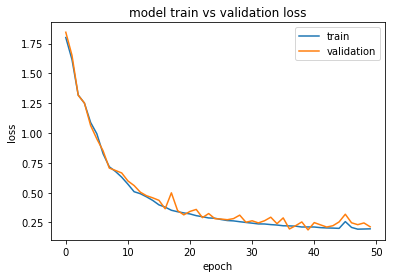

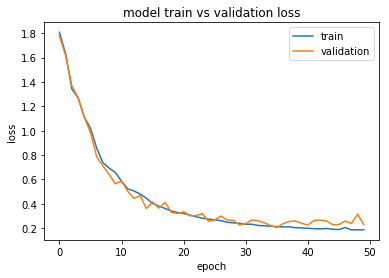

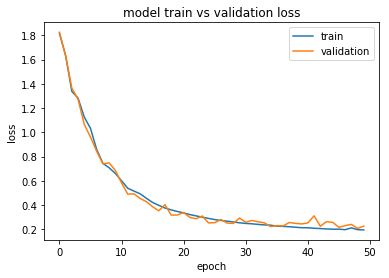

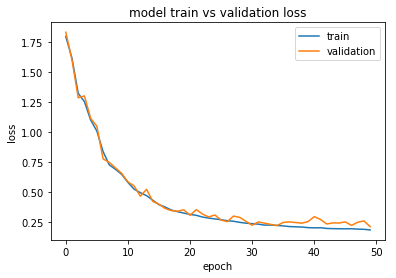

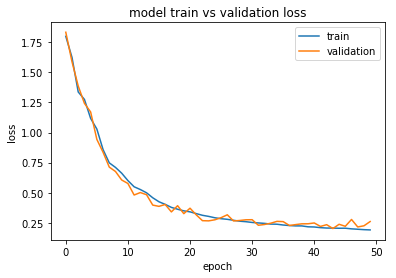

In [15]:
# plot train and validation loss
plt.plot(lloogg_1['train']['epoch'], lloogg_1['train']['loss'])
plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_2['train']['epoch'], lloogg_2['train']['loss'])
plt.plot(lloogg_2['val']['epoch'], lloogg_2['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_3['train']['epoch'], lloogg_3['train']['loss'])
plt.plot(lloogg_3['val']['epoch'], lloogg_3['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_4['train']['epoch'], lloogg_4['train']['loss'])
plt.plot(lloogg_4['val']['epoch'], lloogg_4['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_5['train']['epoch'], lloogg_5['train']['loss'])
plt.plot(lloogg_5['val']['epoch'], lloogg_5['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

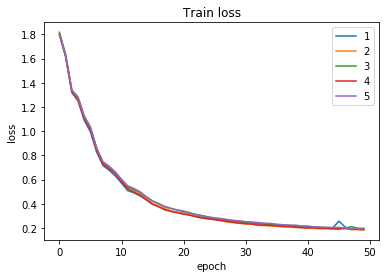

In [16]:
plt.plot(lloogg_1['train']['epoch'], lloogg_1['train']['loss'])
plt.plot(lloogg_2['train']['epoch'], lloogg_2['train']['loss'])
plt.plot(lloogg_3['train']['epoch'], lloogg_3['train']['loss'])
plt.plot(lloogg_4['train']['epoch'], lloogg_4['train']['loss'])
plt.plot(lloogg_5['train']['epoch'], lloogg_5['train']['loss'])
# plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['1','2','3','4','5'], loc='upper right')
plt.show()

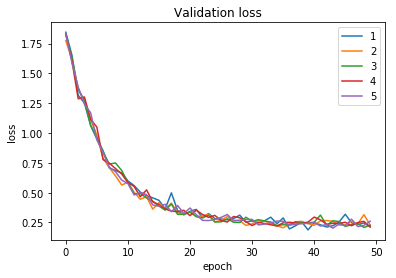

In [17]:
plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.plot(lloogg_2['val']['epoch'], lloogg_2['val']['loss'])
plt.plot(lloogg_3['val']['epoch'], lloogg_3['val']['loss'])
plt.plot(lloogg_4['val']['epoch'], lloogg_4['val']['loss'])
plt.plot(lloogg_5['val']['epoch'], lloogg_5['val']['loss'])
# plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.title('Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['1','2','3','4','5'], loc='upper right')
plt.show()

In [18]:
result_record_f1 = pd.DataFrame.from_dict(data=result_f1, orient='index')
result_record_f1 = np.mean(np.array(result_record_f1), axis = 0)
result_record_f1 = result_record_f1.reshape(-1)

result_record_acc = pd.DataFrame.from_dict(data=result_acc, orient='index')
result_record_acc = np.mean(np.array(result_record_acc), axis = 0)
result_record_acc = result_record_acc.reshape(-1)

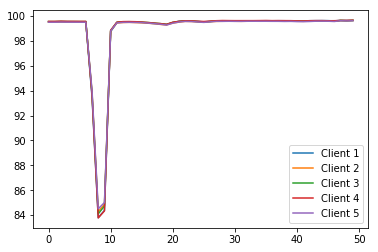

In [19]:
for i in range(client_num):
    plt.plot(np.arange(args.iters), result_acc[i], label = 'Client '+ str(i+1))
plt.legend()
plt.show()

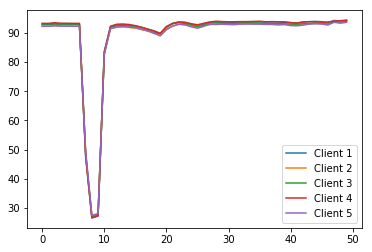

In [20]:
for i in range(client_num):
    plt.plot(np.arange(args.iters), result_f1[i], label =  'Client '+ str(i+1))
plt.legend()
plt.show()